In [1]:
!pip install torchmultimodal-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.5/256.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.5 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=31c0848703f4262727e5241a6c5f7cbf2d8321bd48728c55ba785e7d096e94c8
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successful

In [2]:
import torch
import torchvision
import torchvision.transforms.functional as F

from torch import nn
from tqdm import tqdm
from torchmultimodal.diffusion_labs.modules.adapters.cfguidance import CFGuidance
from torchmultimodal.diffusion_labs.modules.losses.diffusion_hybrid_loss import DiffusionHybridLoss
from torchmultimodal.diffusion_labs.samplers.ddpm import DDPModule
from torchmultimodal.diffusion_labs.predictors.noise_predictor import NoisePredictor
from torchmultimodal.diffusion_labs.schedules.discrete_gaussian_schedule import linear_beta_schedule, DiscreteGaussianSchedule
from torchmultimodal.diffusion_labs.transforms.diffusion_transform import RandomDiffusionSteps
from torchmultimodal.diffusion_labs.utils.common import DiffusionOutput

In [3]:

schedule= DiscreteGaussianSchedule(linear_beta_schedule(1000))

In [4]:

predictor=NoisePredictor(schedule,lambda x: torch.clamp(x,-1,1))
print("yes")

yes


In [5]:

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels):
        super().__init__()
        self.block = nn.Sequential(
        nn.Conv2d(in_channels+cond_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(),
        )
        self.pooling = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, c):
        _, _, w, h = x.size()
        c = c.expand(-1, -1, w, h)
        x = self.block(torch.cat([x, c], 1))
        x_small = self.pooling(x)
        return x, x_small


class UpBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.block = nn.Sequential(
        nn.Conv2d(2*inp,out,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out,out,kernel_size=3,padding=1),
        nn.ReLU(),
        )
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x, x_small):
        x_big = self.upsample(x_small)
        x = torch.cat((x_big, x), dim=1)
        x = self.block(x)
        return x

class UNet(nn.Module):
    def __init__(self, time_size=32, digit_size=32, steps=1000):
        super().__init__()
        # Define UNet
        cond_size=time_size+digit_size
        self.conv=nn.Conv2d(1,128,kernel_size=3,padding=1)
        self.down=nn.ModuleList([DownBlock(128,256,cond_size),DownBlock(256,512,cond_size)])
        self.bottleneck=DownBlock(512,512,cond_size)
        self.up=nn.ModuleList([UpBlock(512,256),UpBlock(256,128)])
        self.time_projection=nn.Embedding(steps,time_size)
        self.prediction = nn.Conv2d(128,1,kernel_size=3,padding=1)
        self.variance=nn.Conv2d(128,1,kernel_size=3,padding=1)

    def forward(self, x, t, conditional_inputs):
        # Define forward
        b,c,h,w=x.shape
        timestep=self.time_projection(t).view(b,-1,1,1)
        condition=conditional_inputs["context"].view(b,-1,1,1)
        condition=torch.cat([timestep,condition],dim=1)
        outs=[]
        x=self.conv(x)
        for block in self.down:
            out,x=block(x,condition)
            outs.append(out)
        x,_=self.bottleneck(x,condition)
        for block in self.up:
            x=block(outs.pop(),x)
        v=self.variance(x)
        p=self.prediction(x)
        return DiffusionOutput(p,v)
print("Completed")

Completed


In [6]:
unet = UNet(time_size=32, digit_size=32)
unet=CFGuidance(unet,{"context":32},guidance=2.0)
# Add support for classifier free guidance

In [7]:

eval_steps=torch.linspace(0,999,250,dtype=torch.long)
model = DDPModule(unet, schedule, predictor, eval_steps)
print("Complete")

Complete


In [8]:

encoder=nn.Embedding(10,32)

In [9]:
from torchvision.transforms import Compose, Resize, ToTensor, Lambda
diffusion_transforms=RandomDiffusionSteps(schedule,batched=False)
transform=Compose([Resize(32),ToTensor(),Lambda(lambda x:2*x-1),Lambda(lambda x:diffusion_transforms({"x":x}))])
print("Complete")




Complete


In [10]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

train_dataset = FashionMNIST("fashion_mnist", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=2, pin_memory=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.6MB/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
epochs = 25

device = "cuda"
encoder.to(device)
model.to(device)

# Apply optimizer to diffusion model and encoder for joint training
optimizer = torch.optim.AdamW(
    [{"params": encoder.parameters()}, {"params": model.parameters()}], lr=0.0001
)
# Define loss
h_loss = DiffusionHybridLoss(schedule)

encoder.train()
model.train()
for e in range(epochs):
    for sample in (pbar := tqdm(train_dataloader)):
        x, c = sample
        x0, xt, noise, t, c = x["x"].to(device), x["xt"].to(device), x["noise"].to(device), x["t"].to(device), c.to(device)
        optimizer.zero_grad()


        # Compute loss
        embedding = encoder(c)
        print(type(embedding))
        out = model(xt, t, {"context": embedding})  # Pass embedding as a dictionary
        loss = h_loss(out.prediction, noise, out.mean, out.log_variance, x0, xt, t)

        loss.backward()
        optimizer.step()

        pbar.set_description(f'{e+1}| Loss: {loss.item()}')

  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


1| Loss: 1.002511978149414:   0%|          | 1/313 [00:02<15:29,  2.98s/it]

<class 'torch.Tensor'>


1| Loss: 0.994036853313446:   1%|          | 2/313 [00:03<07:47,  1.50s/it]

<class 'torch.Tensor'>


1| Loss: 0.9849438071250916:   1%|          | 3/313 [00:03<05:23,  1.04s/it]

<class 'torch.Tensor'>


1| Loss: 0.9674723744392395:   1%|▏         | 4/313 [00:04<04:11,  1.23it/s]

<class 'torch.Tensor'>


1| Loss: 0.9472862482070923:   2%|▏         | 5/313 [00:04<03:34,  1.44it/s]

<class 'torch.Tensor'>


1| Loss: 0.9227831959724426:   2%|▏         | 6/313 [00:05<03:10,  1.61it/s]

<class 'torch.Tensor'>


1| Loss: 0.8917901515960693:   2%|▏         | 7/313 [00:05<02:55,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.8451599478721619:   3%|▎         | 8/313 [00:06<02:45,  1.85it/s]

<class 'torch.Tensor'>


1| Loss: 0.7985883355140686:   3%|▎         | 9/313 [00:06<02:38,  1.92it/s]

<class 'torch.Tensor'>


1| Loss: 0.7591941952705383:   3%|▎         | 10/313 [00:07<02:33,  1.97it/s]

<class 'torch.Tensor'>


1| Loss: 0.8009480237960815:   4%|▎         | 11/313 [00:07<02:30,  2.01it/s]

<class 'torch.Tensor'>


1| Loss: 0.6762056946754456:   4%|▍         | 12/313 [00:08<02:28,  2.03it/s]

<class 'torch.Tensor'>


1| Loss: 0.6749536991119385:   4%|▍         | 13/313 [00:08<02:26,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.622193455696106:   4%|▍         | 14/313 [00:09<02:25,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.5376998782157898:   5%|▍         | 15/313 [00:09<02:24,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.5064757466316223:   5%|▌         | 16/313 [00:10<02:22,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.5013917088508606:   5%|▌         | 17/313 [00:10<02:22,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.43472084403038025:   6%|▌         | 18/313 [00:11<02:21,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.38515806198120117:   6%|▌         | 19/313 [00:11<02:20,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.3475629687309265:   6%|▋         | 20/313 [00:12<02:20,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.29663437604904175:   7%|▋         | 21/313 [00:12<02:19,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.2645606994628906:   7%|▋         | 22/313 [00:13<02:18,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.25118187069892883:   7%|▋         | 23/313 [00:13<02:18,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.2413833737373352:   8%|▊         | 24/313 [00:13<02:18,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.2550601363182068:   8%|▊         | 25/313 [00:14<02:17,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.2588139474391937:   8%|▊         | 26/313 [00:14<02:17,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.23018014430999756:   9%|▊         | 27/313 [00:15<02:17,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.2635941207408905:   9%|▉         | 28/313 [00:15<02:17,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.22910518944263458:   9%|▉         | 29/313 [00:16<02:18,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.19236047565937042:  10%|▉         | 30/313 [00:16<02:17,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.20710471272468567:  10%|▉         | 31/313 [00:17<02:17,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.19067755341529846:  10%|█         | 32/313 [00:17<02:17,  2.04it/s]

<class 'torch.Tensor'>


1| Loss: 0.20406165719032288:  11%|█         | 33/313 [00:18<02:17,  2.04it/s]

<class 'torch.Tensor'>


1| Loss: 0.23137928545475006:  11%|█         | 34/313 [00:18<02:16,  2.04it/s]

<class 'torch.Tensor'>


1| Loss: 0.20764434337615967:  11%|█         | 35/313 [00:19<02:15,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.21041353046894073:  12%|█▏        | 36/313 [00:19<02:14,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.20588937401771545:  12%|█▏        | 37/313 [00:20<02:14,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.2180444598197937:  12%|█▏        | 38/313 [00:20<02:13,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.1982576996088028:  12%|█▏        | 39/313 [00:21<02:14,  2.04it/s]

<class 'torch.Tensor'>


1| Loss: 0.20387013256549835:  13%|█▎        | 40/313 [00:21<02:13,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.21122008562088013:  13%|█▎        | 41/313 [00:22<02:13,  2.04it/s]

<class 'torch.Tensor'>


1| Loss: 0.1991574913263321:  13%|█▎        | 42/313 [00:22<02:12,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.188930481672287:  14%|█▎        | 43/313 [00:23<02:12,  2.03it/s]

<class 'torch.Tensor'>


1| Loss: 0.2008785605430603:  14%|█▍        | 44/313 [00:23<02:12,  2.03it/s]

<class 'torch.Tensor'>


1| Loss: 0.19966338574886322:  14%|█▍        | 45/313 [00:24<02:12,  2.02it/s]

<class 'torch.Tensor'>


1| Loss: 0.17283406853675842:  15%|█▍        | 46/313 [00:24<02:11,  2.02it/s]

<class 'torch.Tensor'>


1| Loss: 0.17978796362876892:  15%|█▌        | 47/313 [00:25<02:12,  2.01it/s]

<class 'torch.Tensor'>


1| Loss: 0.17409154772758484:  15%|█▌        | 48/313 [00:25<02:11,  2.02it/s]

<class 'torch.Tensor'>


1| Loss: 0.20960582792758942:  16%|█▌        | 49/313 [00:26<02:11,  2.01it/s]

<class 'torch.Tensor'>


1| Loss: 0.18655447661876678:  16%|█▌        | 50/313 [00:26<02:11,  2.01it/s]

<class 'torch.Tensor'>


1| Loss: 0.17873947322368622:  16%|█▋        | 51/313 [00:27<02:10,  2.01it/s]

<class 'torch.Tensor'>


1| Loss: 0.16698980331420898:  17%|█▋        | 52/313 [00:27<02:09,  2.01it/s]

<class 'torch.Tensor'>


1| Loss: 0.18786369264125824:  17%|█▋        | 53/313 [00:28<02:09,  2.01it/s]

<class 'torch.Tensor'>


1| Loss: 0.17781978845596313:  17%|█▋        | 54/313 [00:28<02:09,  2.00it/s]

<class 'torch.Tensor'>


1| Loss: 0.20378126204013824:  18%|█▊        | 55/313 [00:29<02:09,  1.99it/s]

<class 'torch.Tensor'>


1| Loss: 0.16252636909484863:  18%|█▊        | 56/313 [00:29<02:09,  1.99it/s]

<class 'torch.Tensor'>


1| Loss: 0.17344388365745544:  18%|█▊        | 57/313 [00:30<02:09,  1.98it/s]

<class 'torch.Tensor'>


1| Loss: 0.1593274623155594:  19%|█▊        | 58/313 [00:30<02:08,  1.98it/s]

<class 'torch.Tensor'>


1| Loss: 0.19194234907627106:  19%|█▉        | 59/313 [00:31<02:09,  1.96it/s]

<class 'torch.Tensor'>


1| Loss: 0.18316635489463806:  19%|█▉        | 60/313 [00:31<02:08,  1.96it/s]

<class 'torch.Tensor'>


1| Loss: 0.19459523260593414:  19%|█▉        | 61/313 [00:32<02:08,  1.96it/s]

<class 'torch.Tensor'>


1| Loss: 0.18068768084049225:  20%|█▉        | 62/313 [00:32<02:08,  1.96it/s]

<class 'torch.Tensor'>


1| Loss: 0.18632197380065918:  20%|██        | 63/313 [00:33<02:07,  1.96it/s]

<class 'torch.Tensor'>


1| Loss: 0.1787554770708084:  20%|██        | 64/313 [00:33<02:07,  1.95it/s]

<class 'torch.Tensor'>


1| Loss: 0.16889043152332306:  21%|██        | 65/313 [00:34<02:06,  1.96it/s]

<class 'torch.Tensor'>


1| Loss: 0.1634751707315445:  21%|██        | 66/313 [00:34<02:06,  1.95it/s]

<class 'torch.Tensor'>


1| Loss: 0.1610042303800583:  21%|██▏       | 67/313 [00:35<02:06,  1.95it/s]

<class 'torch.Tensor'>


1| Loss: 0.1755286306142807:  22%|██▏       | 68/313 [00:35<02:06,  1.94it/s]

<class 'torch.Tensor'>


1| Loss: 0.17230942845344543:  22%|██▏       | 69/313 [00:36<02:06,  1.93it/s]

<class 'torch.Tensor'>


1| Loss: 0.16543632745742798:  22%|██▏       | 70/313 [00:36<02:05,  1.93it/s]

<class 'torch.Tensor'>


1| Loss: 0.18679754436016083:  23%|██▎       | 71/313 [00:37<02:05,  1.93it/s]

<class 'torch.Tensor'>


1| Loss: 0.18859462440013885:  23%|██▎       | 72/313 [00:37<02:05,  1.92it/s]

<class 'torch.Tensor'>


1| Loss: 0.16296809911727905:  23%|██▎       | 73/313 [00:38<02:05,  1.91it/s]

<class 'torch.Tensor'>


1| Loss: 0.16887666285037994:  24%|██▎       | 74/313 [00:39<02:05,  1.91it/s]

<class 'torch.Tensor'>


1| Loss: 0.1743413507938385:  24%|██▍       | 75/313 [00:39<02:04,  1.90it/s]

<class 'torch.Tensor'>


1| Loss: 0.1629524528980255:  24%|██▍       | 76/313 [00:40<02:04,  1.90it/s]

<class 'torch.Tensor'>


1| Loss: 0.17652584612369537:  25%|██▍       | 77/313 [00:40<02:04,  1.90it/s]

<class 'torch.Tensor'>


1| Loss: 0.16316241025924683:  25%|██▍       | 78/313 [00:41<02:04,  1.89it/s]

<class 'torch.Tensor'>


1| Loss: 0.17719048261642456:  25%|██▌       | 79/313 [00:41<02:03,  1.89it/s]

<class 'torch.Tensor'>


1| Loss: 0.17088502645492554:  26%|██▌       | 80/313 [00:42<02:02,  1.90it/s]

<class 'torch.Tensor'>


1| Loss: 0.16813039779663086:  26%|██▌       | 81/313 [00:42<02:03,  1.88it/s]

<class 'torch.Tensor'>


1| Loss: 0.193001851439476:  26%|██▌       | 82/313 [00:43<02:03,  1.87it/s]

<class 'torch.Tensor'>


1| Loss: 0.18133950233459473:  27%|██▋       | 83/313 [00:43<02:04,  1.85it/s]

<class 'torch.Tensor'>


1| Loss: 0.19101499021053314:  27%|██▋       | 84/313 [00:44<02:03,  1.85it/s]

<class 'torch.Tensor'>


1| Loss: 0.14762119948863983:  27%|██▋       | 85/313 [00:44<02:02,  1.86it/s]

<class 'torch.Tensor'>


1| Loss: 0.16015569865703583:  27%|██▋       | 86/313 [00:45<02:02,  1.85it/s]

<class 'torch.Tensor'>


1| Loss: 0.15778881311416626:  28%|██▊       | 87/313 [00:45<02:01,  1.86it/s]

<class 'torch.Tensor'>


1| Loss: 0.14037272334098816:  28%|██▊       | 88/313 [00:46<02:01,  1.85it/s]

<class 'torch.Tensor'>


1| Loss: 0.18807992339134216:  28%|██▊       | 89/313 [00:47<02:00,  1.86it/s]

<class 'torch.Tensor'>


1| Loss: 0.1644667088985443:  29%|██▉       | 90/313 [00:47<02:00,  1.85it/s]

<class 'torch.Tensor'>


1| Loss: 0.1722230613231659:  29%|██▉       | 91/313 [00:48<02:00,  1.85it/s]

<class 'torch.Tensor'>


1| Loss: 0.15113045275211334:  29%|██▉       | 92/313 [00:48<02:00,  1.84it/s]

<class 'torch.Tensor'>


1| Loss: 0.15767334401607513:  30%|██▉       | 93/313 [00:49<02:00,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.16215042769908905:  30%|███       | 94/313 [00:49<01:59,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.13427269458770752:  30%|███       | 95/313 [00:50<01:59,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.14291930198669434:  31%|███       | 96/313 [00:50<01:58,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.1906469613313675:  31%|███       | 97/313 [00:51<01:58,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.16981539130210876:  31%|███▏      | 98/313 [00:51<01:57,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.14797107875347137:  32%|███▏      | 99/313 [00:52<01:57,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.1765671819448471:  32%|███▏      | 100/313 [00:53<01:57,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.15991127490997314:  32%|███▏      | 101/313 [00:53<01:57,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.13463807106018066:  33%|███▎      | 102/313 [00:54<01:57,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.17928993701934814:  33%|███▎      | 103/313 [00:54<01:56,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.15832418203353882:  33%|███▎      | 104/313 [00:55<01:56,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.13383102416992188:  34%|███▎      | 105/313 [00:55<01:55,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.1500183790922165:  34%|███▍      | 106/313 [00:56<01:55,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.12966690957546234:  34%|███▍      | 107/313 [00:57<01:55,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.166562020778656:  35%|███▍      | 108/313 [00:57<01:55,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.11454278230667114:  35%|███▍      | 109/313 [00:58<01:55,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.13573043048381805:  35%|███▌      | 110/313 [00:58<01:55,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.14928273856639862:  35%|███▌      | 111/313 [00:59<01:54,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.1365211308002472:  36%|███▌      | 112/313 [00:59<01:53,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.1435609608888626:  36%|███▌      | 113/313 [01:00<01:53,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.12381872534751892:  36%|███▋      | 114/313 [01:01<01:53,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.14164267480373383:  37%|███▋      | 115/313 [01:01<01:53,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.15625743567943573:  37%|███▋      | 116/313 [01:02<01:52,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.1535852998495102:  37%|███▋      | 117/313 [01:02<01:52,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.14948736131191254:  38%|███▊      | 118/313 [01:03<01:52,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.12791864573955536:  38%|███▊      | 119/313 [01:03<01:52,  1.73it/s]

<class 'torch.Tensor'>


1| Loss: 0.11686009168624878:  38%|███▊      | 120/313 [01:04<01:51,  1.72it/s]

<class 'torch.Tensor'>


1| Loss: 0.12384754419326782:  39%|███▊      | 121/313 [01:05<01:51,  1.72it/s]

<class 'torch.Tensor'>


1| Loss: 0.1439213901758194:  39%|███▉      | 122/313 [01:05<01:51,  1.72it/s]

<class 'torch.Tensor'>


1| Loss: 0.1610253006219864:  39%|███▉      | 123/313 [01:06<01:50,  1.71it/s]

<class 'torch.Tensor'>


1| Loss: 0.14379645884037018:  40%|███▉      | 124/313 [01:06<01:50,  1.71it/s]

<class 'torch.Tensor'>


1| Loss: 0.12972602248191833:  40%|███▉      | 125/313 [01:07<01:50,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.14074526727199554:  40%|████      | 126/313 [01:08<01:49,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.12104533612728119:  41%|████      | 127/313 [01:08<01:49,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.1235625147819519:  41%|████      | 128/313 [01:09<01:49,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.12574458122253418:  41%|████      | 129/313 [01:09<01:48,  1.69it/s]

<class 'torch.Tensor'>


1| Loss: 0.11709107458591461:  42%|████▏     | 130/313 [01:10<01:48,  1.68it/s]

<class 'torch.Tensor'>


1| Loss: 0.11127974092960358:  42%|████▏     | 131/313 [01:10<01:48,  1.68it/s]

<class 'torch.Tensor'>


1| Loss: 0.12257960438728333:  42%|████▏     | 132/313 [01:11<01:47,  1.68it/s]

<class 'torch.Tensor'>


1| Loss: 0.15123024582862854:  42%|████▏     | 133/313 [01:12<01:47,  1.68it/s]

<class 'torch.Tensor'>


1| Loss: 0.1026831790804863:  43%|████▎     | 134/313 [01:12<01:47,  1.67it/s]

<class 'torch.Tensor'>


1| Loss: 0.11315695941448212:  43%|████▎     | 135/313 [01:13<01:46,  1.67it/s]

<class 'torch.Tensor'>


1| Loss: 0.12291787564754486:  43%|████▎     | 136/313 [01:14<01:46,  1.66it/s]

<class 'torch.Tensor'>


1| Loss: 0.13601577281951904:  44%|████▍     | 137/313 [01:14<01:45,  1.67it/s]

<class 'torch.Tensor'>


1| Loss: 0.11805183440446854:  44%|████▍     | 138/313 [01:15<01:45,  1.66it/s]

<class 'torch.Tensor'>


1| Loss: 0.1447063386440277:  44%|████▍     | 139/313 [01:15<01:44,  1.66it/s]

<class 'torch.Tensor'>


1| Loss: 0.12144053727388382:  45%|████▍     | 140/313 [01:16<01:44,  1.66it/s]

<class 'torch.Tensor'>


1| Loss: 0.10608023405075073:  45%|████▌     | 141/313 [01:17<01:43,  1.66it/s]

<class 'torch.Tensor'>


1| Loss: 0.11032088845968246:  45%|████▌     | 142/313 [01:17<01:42,  1.66it/s]

<class 'torch.Tensor'>


1| Loss: 0.1029055193066597:  46%|████▌     | 143/313 [01:18<01:42,  1.66it/s]

<class 'torch.Tensor'>


1| Loss: 0.13085472583770752:  46%|████▌     | 144/313 [01:18<01:41,  1.67it/s]

<class 'torch.Tensor'>


1| Loss: 0.10632960498332977:  46%|████▋     | 145/313 [01:19<01:40,  1.67it/s]

<class 'torch.Tensor'>


1| Loss: 0.11912659555673599:  47%|████▋     | 146/313 [01:20<01:39,  1.67it/s]

<class 'torch.Tensor'>


1| Loss: 0.10836000740528107:  47%|████▋     | 147/313 [01:20<01:38,  1.68it/s]

<class 'torch.Tensor'>


1| Loss: 0.12336422502994537:  47%|████▋     | 148/313 [01:21<01:37,  1.69it/s]

<class 'torch.Tensor'>


1| Loss: 0.10421641170978546:  48%|████▊     | 149/313 [01:21<01:36,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.10737717151641846:  48%|████▊     | 150/313 [01:22<01:36,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.10378199070692062:  48%|████▊     | 151/313 [01:22<01:35,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.11460994184017181:  49%|████▊     | 152/313 [01:23<01:34,  1.70it/s]

<class 'torch.Tensor'>


1| Loss: 0.12300030887126923:  49%|████▉     | 153/313 [01:24<01:33,  1.71it/s]

<class 'torch.Tensor'>


1| Loss: 0.1039314791560173:  49%|████▉     | 154/313 [01:24<01:33,  1.71it/s]

<class 'torch.Tensor'>


1| Loss: 0.09890161454677582:  50%|████▉     | 155/313 [01:25<01:32,  1.71it/s]

<class 'torch.Tensor'>


1| Loss: 0.08921022713184357:  50%|████▉     | 156/313 [01:25<01:31,  1.72it/s]

<class 'torch.Tensor'>


1| Loss: 0.1061650887131691:  50%|█████     | 157/313 [01:26<01:30,  1.73it/s]

<class 'torch.Tensor'>


1| Loss: 0.10896120965480804:  50%|█████     | 158/313 [01:26<01:29,  1.73it/s]

<class 'torch.Tensor'>


1| Loss: 0.08164463937282562:  51%|█████     | 159/313 [01:27<01:28,  1.73it/s]

<class 'torch.Tensor'>


1| Loss: 0.09986419975757599:  51%|█████     | 160/313 [01:28<01:27,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.11829128116369247:  51%|█████▏    | 161/313 [01:28<01:27,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.0974997952580452:  52%|█████▏    | 162/313 [01:29<01:26,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.11476486176252365:  52%|█████▏    | 163/313 [01:29<01:25,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.09674254804849625:  52%|█████▏    | 164/313 [01:30<01:24,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.09146774560213089:  53%|█████▎    | 165/313 [01:30<01:24,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.08668151497840881:  53%|█████▎    | 166/313 [01:31<01:23,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.09028699994087219:  53%|█████▎    | 167/313 [01:32<01:22,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.09129669517278671:  54%|█████▎    | 168/313 [01:32<01:22,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07386057078838348:  54%|█████▍    | 169/313 [01:33<01:21,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.0955948457121849:  54%|█████▍    | 170/313 [01:33<01:21,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.12171758711338043:  55%|█████▍    | 171/313 [01:34<01:20,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.094700388610363:  55%|█████▍    | 172/313 [01:34<01:19,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.09158792346715927:  55%|█████▌    | 173/313 [01:35<01:18,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.07262969762086868:  56%|█████▌    | 174/313 [01:36<01:18,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.1066516637802124:  56%|█████▌    | 175/313 [01:36<01:17,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.11070531606674194:  56%|█████▌    | 176/313 [01:37<01:17,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.08152497559785843:  57%|█████▋    | 177/313 [01:37<01:16,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.10112911462783813:  57%|█████▋    | 178/313 [01:38<01:15,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.09285252541303635:  57%|█████▋    | 179/313 [01:38<01:15,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.09696648269891739:  58%|█████▊    | 180/313 [01:39<01:14,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.09498197585344315:  58%|█████▊    | 181/313 [01:39<01:13,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.07654562592506409:  58%|█████▊    | 182/313 [01:40<01:12,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.10550007969141006:  58%|█████▊    | 183/313 [01:41<01:12,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.10081750899553299:  59%|█████▉    | 184/313 [01:41<01:11,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.09404154866933823:  59%|█████▉    | 185/313 [01:42<01:11,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.11772432178258896:  59%|█████▉    | 186/313 [01:42<01:10,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.07858849316835403:  60%|█████▉    | 187/313 [01:43<01:09,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.10839860886335373:  60%|██████    | 188/313 [01:43<01:09,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.11388939619064331:  60%|██████    | 189/313 [01:44<01:09,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.09698393195867538:  61%|██████    | 190/313 [01:44<01:08,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.09909044951200485:  61%|██████    | 191/313 [01:45<01:07,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.09194378554821014:  61%|██████▏   | 192/313 [01:46<01:06,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.09305787831544876:  62%|██████▏   | 193/313 [01:46<01:06,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.08791764825582504:  62%|██████▏   | 194/313 [01:47<01:05,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.07213205099105835:  62%|██████▏   | 195/313 [01:47<01:04,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.09033817052841187:  63%|██████▎   | 196/313 [01:48<01:04,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.085172139108181:  63%|██████▎   | 197/313 [01:48<01:03,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.09105610102415085:  63%|██████▎   | 198/313 [01:49<01:03,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.07765229791402817:  64%|██████▎   | 199/313 [01:49<01:02,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.07525056600570679:  64%|██████▍   | 200/313 [01:50<01:02,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.08195517212152481:  64%|██████▍   | 201/313 [01:51<01:01,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.10725387185811996:  65%|██████▍   | 202/313 [01:51<01:00,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.09506699442863464:  65%|██████▍   | 203/313 [01:52<01:00,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.09687075763940811:  65%|██████▌   | 204/313 [01:52<00:59,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.07791239768266678:  65%|██████▌   | 205/313 [01:53<00:59,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.08749452233314514:  66%|██████▌   | 206/313 [01:53<00:58,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.09534952044487:  66%|██████▌   | 207/313 [01:54<00:58,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.07805734127759933:  66%|██████▋   | 208/313 [01:54<00:57,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.09762347489595413:  67%|██████▋   | 209/313 [01:55<00:56,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.08562483638525009:  67%|██████▋   | 210/313 [01:55<00:56,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.08307478576898575:  67%|██████▋   | 211/313 [01:56<00:56,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.07511509954929352:  68%|██████▊   | 212/313 [01:57<00:55,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.08571047335863113:  68%|██████▊   | 213/313 [01:57<00:54,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.10238832235336304:  68%|██████▊   | 214/313 [01:58<00:54,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.06886974722146988:  69%|██████▊   | 215/313 [01:58<00:53,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.10706985741853714:  69%|██████▉   | 216/313 [01:59<00:53,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.06832949072122574:  69%|██████▉   | 217/313 [01:59<00:52,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.0798681303858757:  70%|██████▉   | 218/313 [02:00<00:52,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.08449521660804749:  70%|██████▉   | 219/313 [02:00<00:51,  1.83it/s]

<class 'torch.Tensor'>


1| Loss: 0.07421935349702835:  70%|███████   | 220/313 [02:01<00:50,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.08537811040878296:  71%|███████   | 221/313 [02:01<00:50,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.07462150603532791:  71%|███████   | 222/313 [02:02<00:49,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.08345679938793182:  71%|███████   | 223/313 [02:03<00:49,  1.82it/s]

<class 'torch.Tensor'>


1| Loss: 0.08815564215183258:  72%|███████▏  | 224/313 [02:03<00:49,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.08066178113222122:  72%|███████▏  | 225/313 [02:04<00:48,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.08804868161678314:  72%|███████▏  | 226/313 [02:04<00:48,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.08652053773403168:  73%|███████▎  | 227/313 [02:05<00:47,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.08243868499994278:  73%|███████▎  | 228/313 [02:05<00:47,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.07046016305685043:  73%|███████▎  | 229/313 [02:06<00:46,  1.81it/s]

<class 'torch.Tensor'>


1| Loss: 0.10010471940040588:  73%|███████▎  | 230/313 [02:06<00:46,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.07820982486009598:  74%|███████▍  | 231/313 [02:07<00:45,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.10076513141393661:  74%|███████▍  | 232/313 [02:08<00:45,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.09349862486124039:  74%|███████▍  | 233/313 [02:08<00:44,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.06039193645119667:  75%|███████▍  | 234/313 [02:09<00:44,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.08424346894025803:  75%|███████▌  | 235/313 [02:09<00:43,  1.80it/s]

<class 'torch.Tensor'>


1| Loss: 0.09225127846002579:  75%|███████▌  | 236/313 [02:10<00:43,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.06335192918777466:  76%|███████▌  | 237/313 [02:10<00:42,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.09325005859136581:  76%|███████▌  | 238/313 [02:11<00:41,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.08091813325881958:  76%|███████▋  | 239/313 [02:11<00:41,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.09442194551229477:  77%|███████▋  | 240/313 [02:12<00:40,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.06807152926921844:  77%|███████▋  | 241/313 [02:13<00:40,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.09720219671726227:  77%|███████▋  | 242/313 [02:13<00:39,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.10202404111623764:  78%|███████▊  | 243/313 [02:14<00:39,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.07205920666456223:  78%|███████▊  | 244/313 [02:14<00:38,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.08731023222208023:  78%|███████▊  | 245/313 [02:15<00:38,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.06779272109270096:  79%|███████▊  | 246/313 [02:15<00:37,  1.79it/s]

<class 'torch.Tensor'>


1| Loss: 0.061609748750925064:  79%|███████▉  | 247/313 [02:16<00:37,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.0721389427781105:  79%|███████▉  | 248/313 [02:17<00:36,  1.78it/s]

<class 'torch.Tensor'>


1| Loss: 0.06720848381519318:  80%|███████▉  | 249/313 [02:17<00:36,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.07758429646492004:  80%|███████▉  | 250/313 [02:18<00:35,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.07465315610170364:  80%|████████  | 251/313 [02:18<00:35,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.07471144944429398:  81%|████████  | 252/313 [02:19<00:34,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.06996642798185349:  81%|████████  | 253/313 [02:19<00:34,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.0882323831319809:  81%|████████  | 254/313 [02:20<00:33,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.063206247985363:  81%|████████▏ | 255/313 [02:21<00:32,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07541097700595856:  82%|████████▏ | 256/313 [02:21<00:32,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06764882802963257:  82%|████████▏ | 257/313 [02:22<00:31,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.08119206875562668:  82%|████████▏ | 258/313 [02:22<00:31,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06774833053350449:  83%|████████▎ | 259/313 [02:23<00:30,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.09517031162977219:  83%|████████▎ | 260/313 [02:23<00:30,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06346480548381805:  83%|████████▎ | 261/313 [02:24<00:29,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.08758825808763504:  84%|████████▎ | 262/313 [02:24<00:28,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.08425085991621017:  84%|████████▍ | 263/313 [02:25<00:28,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.08379549533128738:  84%|████████▍ | 264/313 [02:26<00:27,  1.77it/s]

<class 'torch.Tensor'>


1| Loss: 0.07848013937473297:  85%|████████▍ | 265/313 [02:26<00:27,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.0797027200460434:  85%|████████▍ | 266/313 [02:27<00:26,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06940692663192749:  85%|████████▌ | 267/313 [02:27<00:26,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06081130728125572:  86%|████████▌ | 268/313 [02:28<00:25,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06311136484146118:  86%|████████▌ | 269/313 [02:28<00:24,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07363422960042953:  86%|████████▋ | 270/313 [02:29<00:24,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06374307721853256:  87%|████████▋ | 271/313 [02:30<00:23,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.09494674205780029:  87%|████████▋ | 272/313 [02:30<00:23,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.08104809373617172:  87%|████████▋ | 273/313 [02:31<00:22,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.08558828383684158:  88%|████████▊ | 274/313 [02:31<00:22,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07209830731153488:  88%|████████▊ | 275/313 [02:32<00:21,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.09149696677923203:  88%|████████▊ | 276/313 [02:32<00:21,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06633969396352768:  88%|████████▊ | 277/313 [02:33<00:20,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.07236701995134354:  89%|████████▉ | 278/313 [02:34<00:20,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.09805022180080414:  89%|████████▉ | 279/313 [02:34<00:19,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.06430034339427948:  89%|████████▉ | 280/313 [02:35<00:18,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.05813676118850708:  90%|████████▉ | 281/313 [02:35<00:18,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07591025531291962:  90%|█████████ | 282/313 [02:36<00:17,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.05484246462583542:  90%|█████████ | 283/313 [02:36<00:17,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.07783118635416031:  91%|█████████ | 284/313 [02:37<00:16,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.08198820054531097:  91%|█████████ | 285/313 [02:38<00:15,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.08648580312728882:  91%|█████████▏| 286/313 [02:38<00:15,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.09177732467651367:  92%|█████████▏| 287/313 [02:39<00:14,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.06289345771074295:  92%|█████████▏| 288/313 [02:39<00:14,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.0918169766664505:  92%|█████████▏| 289/313 [02:40<00:13,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.08793425559997559:  93%|█████████▎| 290/313 [02:40<00:13,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.06411988288164139:  93%|█████████▎| 291/313 [02:41<00:12,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.06419837474822998:  93%|█████████▎| 292/313 [02:42<00:12,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.07642720639705658:  94%|█████████▎| 293/313 [02:42<00:11,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.0751868486404419:  94%|█████████▍| 294/313 [02:43<00:10,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.06334152817726135:  94%|█████████▍| 295/313 [02:43<00:10,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.07657210528850555:  95%|█████████▍| 296/313 [02:44<00:09,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.05380914360284805:  95%|█████████▍| 297/313 [02:44<00:09,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.05354055017232895:  95%|█████████▌| 298/313 [02:45<00:08,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.06611368805170059:  96%|█████████▌| 299/313 [02:46<00:07,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.05575370043516159:  96%|█████████▌| 300/313 [02:46<00:07,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.077342689037323:  96%|█████████▌| 301/313 [02:47<00:06,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.0650501549243927:  96%|█████████▋| 302/313 [02:47<00:06,  1.74it/s]

<class 'torch.Tensor'>


1| Loss: 0.07994592189788818:  97%|█████████▋| 303/313 [02:48<00:05,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.074912428855896:  97%|█████████▋| 304/313 [02:48<00:05,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.054317377507686615:  97%|█████████▋| 305/313 [02:49<00:04,  1.75it/s]

<class 'torch.Tensor'>


1| Loss: 0.07505235075950623:  98%|█████████▊| 306/313 [02:50<00:03,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.08026736229658127:  98%|█████████▊| 307/313 [02:50<00:03,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07594069838523865:  98%|█████████▊| 308/313 [02:51<00:02,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.0747036263346672:  99%|█████████▊| 309/313 [02:51<00:02,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07556116580963135:  99%|█████████▉| 310/313 [02:52<00:01,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06858929246664047:  99%|█████████▉| 311/313 [02:52<00:01,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.06413199007511139: 100%|█████████▉| 312/313 [02:53<00:00,  1.76it/s]

<class 'torch.Tensor'>


1| Loss: 0.07604528963565826: 100%|██████████| 313/313 [02:53<00:00,  1.80it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


2| Loss: 0.07309282571077347:   0%|          | 1/313 [00:00<03:42,  1.40it/s]

<class 'torch.Tensor'>


2| Loss: 0.06932616233825684:   1%|          | 2/313 [00:01<03:19,  1.56it/s]

<class 'torch.Tensor'>


2| Loss: 0.07482172548770905:   1%|          | 3/313 [00:01<03:04,  1.68it/s]

<class 'torch.Tensor'>


2| Loss: 0.06870613247156143:   1%|▏         | 4/313 [00:02<03:03,  1.68it/s]

<class 'torch.Tensor'>


2| Loss: 0.06406211853027344:   2%|▏         | 5/313 [00:02<02:57,  1.73it/s]

<class 'torch.Tensor'>


2| Loss: 0.07675183564424515:   2%|▏         | 6/313 [00:03<02:57,  1.73it/s]

<class 'torch.Tensor'>


2| Loss: 0.06821902096271515:   2%|▏         | 7/313 [00:04<02:55,  1.74it/s]

<class 'torch.Tensor'>


2| Loss: 0.06972349435091019:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06974179297685623:   3%|▎         | 9/313 [00:05<02:54,  1.74it/s]

<class 'torch.Tensor'>


2| Loss: 0.05316619575023651:   3%|▎         | 10/313 [00:05<02:51,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06405741721391678:   4%|▎         | 11/313 [00:06<02:52,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.08226248621940613:   4%|▍         | 12/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.08031746745109558:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06769245862960815:   4%|▍         | 14/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.08432527631521225:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.051667191088199615:   5%|▌         | 16/313 [00:09<02:49,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0702647715806961:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06445475667715073:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.061752304434776306:   6%|▌         | 19/313 [00:10<02:45,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.07795297354459763:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.051186591386795044:   7%|▋         | 21/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05575806647539139:   7%|▋         | 22/313 [00:12<02:44,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06040843576192856:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06760319322347641:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.07031644880771637:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.059327974915504456:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06216872110962868:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06661596894264221:   9%|▉         | 28/313 [00:16<02:40,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.057208213955163956:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.07034027576446533:  10%|▉         | 30/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.057022541761398315:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.08978249877691269:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06983304768800735:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.049828965216875076:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.08717414736747742:  11%|█         | 35/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06265293061733246:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05930659919977188:  12%|█▏        | 37/313 [00:21<02:34,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.05570444092154503:  12%|█▏        | 38/313 [00:21<02:34,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.07382334768772125:  12%|█▏        | 39/313 [00:22<02:33,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.08770615607500076:  13%|█▎        | 40/313 [00:22<02:32,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.056161776185035706:  13%|█▎        | 41/313 [00:23<02:32,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.07212488353252411:  13%|█▎        | 42/313 [00:23<02:30,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.07223518937826157:  14%|█▎        | 43/313 [00:24<02:30,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.06277908384799957:  14%|█▍        | 44/313 [00:25<02:30,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.0712854415178299:  14%|█▍        | 45/313 [00:25<02:30,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.04870331287384033:  15%|█▍        | 46/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.0655665248632431:  15%|█▌        | 47/313 [00:26<02:28,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.08030839264392853:  15%|█▌        | 48/313 [00:27<02:28,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.05467713996767998:  16%|█▌        | 49/313 [00:27<02:28,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.0694737657904625:  16%|█▌        | 50/313 [00:28<02:27,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06974797695875168:  16%|█▋        | 51/313 [00:28<02:26,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.0671309307217598:  17%|█▋        | 52/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.07543978095054626:  17%|█▋        | 53/313 [00:30<02:26,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.05697346106171608:  17%|█▋        | 54/313 [00:30<02:25,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.05358625948429108:  18%|█▊        | 55/313 [00:31<02:24,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.08068200945854187:  18%|█▊        | 56/313 [00:31<02:24,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06153035908937454:  18%|█▊        | 57/313 [00:32<02:23,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.07159381359815598:  19%|█▊        | 58/313 [00:32<02:23,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.05988528952002525:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05909901112318039:  19%|█▉        | 60/313 [00:33<02:22,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.07410217821598053:  19%|█▉        | 61/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.056281864643096924:  20%|█▉        | 62/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06428303569555283:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06209076941013336:  20%|██        | 64/313 [00:36<02:20,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.0520457960665226:  21%|██        | 65/313 [00:36<02:19,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.07101030647754669:  21%|██        | 66/313 [00:37<02:18,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06810468435287476:  21%|██▏       | 67/313 [00:37<02:18,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06023462861776352:  22%|██▏       | 68/313 [00:38<02:17,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06019388884305954:  22%|██▏       | 69/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05767400562763214:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.0702705904841423:  23%|██▎       | 71/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.07106998562812805:  23%|██▎       | 72/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.07733593136072159:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05854034423828125:  24%|██▎       | 74/313 [00:41<02:15,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07070598751306534:  24%|██▍       | 75/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06142546236515045:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06577207148075104:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.04920653626322746:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07054473459720612:  25%|██▌       | 79/313 [00:44<02:12,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.050878964364528656:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.09171263873577118:  26%|██▌       | 81/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.0587022565305233:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0631098523736:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06986359506845474:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05253266170620918:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05888035148382187:  27%|██▋       | 86/313 [00:48<02:08,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07947678118944168:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06189936026930809:  28%|██▊       | 88/313 [00:49<02:07,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05680850148200989:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0656251311302185:  29%|██▉       | 90/313 [00:50<02:06,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0735558420419693:  29%|██▉       | 91/313 [00:51<02:05,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07117965072393417:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0565757229924202:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06891089677810669:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.055598944425582886:  30%|███       | 95/313 [00:53<02:03,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05814763158559799:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0634591206908226:  31%|███       | 97/313 [00:54<02:02,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06393425166606903:  31%|███▏      | 98/313 [00:55<02:01,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.060352031141519547:  32%|███▏      | 99/313 [00:56<02:01,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.061554715037345886:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.055073127150535583:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06767604500055313:  33%|███▎      | 102/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06206119805574417:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05596024543046951:  33%|███▎      | 104/313 [00:58<01:58,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.060012105852365494:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06347349286079407:  34%|███▍      | 106/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06424634903669357:  34%|███▍      | 107/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06532461941242218:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07053840160369873:  35%|███▍      | 109/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06343713402748108:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06918156892061234:  35%|███▌      | 111/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.0490456223487854:  36%|███▌      | 112/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07285051047801971:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05724651739001274:  36%|███▋      | 114/313 [01:04<01:52,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05923520773649216:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07203710079193115:  37%|███▋      | 116/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05528281629085541:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04431891813874245:  38%|███▊      | 118/313 [01:06<01:50,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06234680861234665:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07862985879182816:  38%|███▊      | 120/313 [01:07<01:49,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0567798912525177:  39%|███▊      | 121/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.058187227696180344:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05385586991906166:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06959057599306107:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05808062478899956:  40%|███▉      | 125/313 [01:10<01:47,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.06052101030945778:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06367429345846176:  41%|████      | 127/313 [01:11<01:45,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.059884026646614075:  41%|████      | 128/313 [01:12<01:44,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06545961648225784:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.060106534510850906:  42%|████▏     | 130/313 [01:13<01:43,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06606912612915039:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07376982271671295:  42%|████▏     | 132/313 [01:14<01:42,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06953960657119751:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06787826865911484:  43%|████▎     | 134/313 [01:15<01:41,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05389409884810448:  43%|████▎     | 135/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05391886830329895:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06290759146213531:  44%|████▍     | 137/313 [01:17<01:39,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07400961965322495:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06827951967716217:  44%|████▍     | 139/313 [01:18<01:38,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0536407008767128:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06449136137962341:  45%|████▌     | 141/313 [01:19<01:37,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07496108114719391:  45%|████▌     | 142/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06229235976934433:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.059619177132844925:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04843072220683098:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04810858517885208:  47%|████▋     | 146/313 [01:22<01:34,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06451696902513504:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.050142936408519745:  47%|████▋     | 148/313 [01:23<01:34,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.059322379529476166:  48%|████▊     | 149/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06805821508169174:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05223080515861511:  48%|████▊     | 151/313 [01:25<01:31,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05938321352005005:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.045724038034677505:  49%|████▉     | 153/313 [01:26<01:30,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05828870087862015:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.046914707869291306:  50%|████▉     | 155/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05680159479379654:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0611443966627121:  50%|█████     | 157/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.056056562811136246:  50%|█████     | 158/313 [01:29<01:27,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06080985069274902:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.054813843220472336:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06191263347864151:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0630187839269638:  52%|█████▏    | 162/313 [01:31<01:25,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06700286269187927:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0504007413983345:  52%|█████▏    | 164/313 [01:32<01:24,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06012522801756859:  53%|█████▎    | 165/313 [01:33<01:23,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05266684666275978:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06494158506393433:  53%|█████▎    | 167/313 [01:34<01:22,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07394848763942719:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06250935792922974:  54%|█████▍    | 169/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.04893459379673004:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05293023958802223:  55%|█████▍    | 171/313 [01:36<01:20,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.046348653733730316:  55%|█████▍    | 172/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06037301570177078:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.056150276213884354:  56%|█████▌    | 174/313 [01:38<01:19,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.05380252003669739:  56%|█████▌    | 175/313 [01:39<01:18,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.061961233615875244:  56%|█████▌    | 176/313 [01:39<01:17,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0671975314617157:  57%|█████▋    | 177/313 [01:40<01:17,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06086333096027374:  57%|█████▋    | 178/313 [01:40<01:16,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04523659497499466:  57%|█████▋    | 179/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05936233699321747:  58%|█████▊    | 180/313 [01:42<01:15,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.07819980382919312:  58%|█████▊    | 181/313 [01:42<01:14,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0499703623354435:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06329501420259476:  58%|█████▊    | 183/313 [01:43<01:13,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05482851341366768:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.043190889060497284:  59%|█████▉    | 185/313 [01:44<01:12,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06747572124004364:  59%|█████▉    | 186/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04662080109119415:  60%|█████▉    | 187/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05212400108575821:  60%|██████    | 188/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.059274304658174515:  60%|██████    | 189/313 [01:47<01:10,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.054174989461898804:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06346853822469711:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05559450015425682:  61%|██████▏   | 192/313 [01:48<01:08,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.044474244117736816:  62%|██████▏   | 193/313 [01:49<01:08,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.06371691823005676:  62%|██████▏   | 194/313 [01:50<01:08,  1.74it/s]

<class 'torch.Tensor'>


2| Loss: 0.07247081398963928:  62%|██████▏   | 195/313 [01:50<01:07,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.05433445796370506:  63%|██████▎   | 196/313 [01:51<01:06,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.05327880010008812:  63%|██████▎   | 197/313 [01:51<01:06,  1.75it/s]

<class 'torch.Tensor'>


2| Loss: 0.07276781648397446:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06396522372961044:  64%|██████▎   | 199/313 [01:52<01:04,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.046651486307382584:  64%|██████▍   | 200/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.050403036177158356:  64%|██████▍   | 201/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05966188758611679:  65%|██████▍   | 202/313 [01:54<01:02,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.056712258607149124:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05998004227876663:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06272176653146744:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05658457428216934:  66%|██████▌   | 206/313 [01:56<01:00,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06657025963068008:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05613375082612038:  66%|██████▋   | 208/313 [01:57<00:59,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06744252890348434:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.04968222230672836:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06632872670888901:  67%|██████▋   | 211/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06119324266910553:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05849803611636162:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06207440048456192:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04599498584866524:  69%|██████▊   | 215/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.062133219093084335:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07202461361885071:  69%|██████▉   | 217/313 [02:03<00:54,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.051600489765405655:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.056096311658620834:  70%|██████▉   | 219/313 [02:04<00:53,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05399789288640022:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.048648472875356674:  71%|███████   | 221/313 [02:05<00:52,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.04710681736469269:  71%|███████   | 222/313 [02:05<00:51,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.04834333062171936:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06060853600502014:  72%|███████▏  | 224/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.048761818557977676:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06609418243169785:  72%|███████▏  | 226/313 [02:08<00:49,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06999243050813675:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06898283213376999:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05981689319014549:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04897351935505867:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04544597119092941:  74%|███████▍  | 231/313 [02:11<00:46,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.054808009415864944:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06131932884454727:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04586935415863991:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.051419392228126526:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05279076471924782:  75%|███████▌  | 236/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05277255177497864:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06476128101348877:  76%|███████▌  | 238/313 [02:14<00:42,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05869592726230621:  76%|███████▋  | 239/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04708072543144226:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.050810132175683975:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.07328543066978455:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0654529556632042:  78%|███████▊  | 243/313 [02:17<00:39,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.047724608331918716:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.060321684926748276:  78%|███████▊  | 245/313 [02:18<00:38,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06983096897602081:  79%|███████▊  | 246/313 [02:19<00:37,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06037397310137749:  79%|███████▉  | 247/313 [02:20<00:37,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04887625575065613:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05178946629166603:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05549013987183571:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05388195812702179:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.054169416427612305:  81%|████████  | 252/313 [02:22<00:34,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0743490532040596:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.042876794934272766:  81%|████████  | 254/313 [02:24<00:33,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04495302587747574:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.045669764280319214:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04437367618083954:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.040598802268505096:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06795146316289902:  83%|████████▎ | 259/313 [02:26<00:30,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05650829151272774:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.057227443903684616:  83%|████████▎ | 261/313 [02:28<00:29,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05757274478673935:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.06646779924631119:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04608067497611046:  84%|████████▍ | 264/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.0493401475250721:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.052542638033628464:  85%|████████▍ | 266/313 [02:30<00:26,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06345240771770477:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05504224821925163:  86%|████████▌ | 268/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.048173509538173676:  86%|████████▌ | 269/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05824044719338417:  86%|████████▋ | 270/313 [02:33<00:24,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.059175048023462296:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05510006844997406:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.0444081574678421:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04755806177854538:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05214637145400047:  88%|████████▊ | 275/313 [02:35<00:21,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05072851479053497:  88%|████████▊ | 276/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05507906526327133:  88%|████████▊ | 277/313 [02:37<00:20,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.052617594599723816:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04413525015115738:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.054774485528469086:  89%|████████▉ | 280/313 [02:38<00:18,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.04123033955693245:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06121774762868881:  90%|█████████ | 282/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04524672403931618:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05867502838373184:  91%|█████████ | 284/313 [02:41<00:16,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.0669943168759346:  91%|█████████ | 285/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.050052545964717865:  91%|█████████▏| 286/313 [02:42<00:15,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.05107875168323517:  92%|█████████▏| 287/313 [02:42<00:14,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.0569787472486496:  92%|█████████▏| 288/313 [02:43<00:14,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.047339219599962234:  92%|█████████▏| 289/313 [02:43<00:13,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.04565970227122307:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.05506585165858269:  93%|█████████▎| 291/313 [02:45<00:12,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.051918722689151764:  93%|█████████▎| 292/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.06086955592036247:  94%|█████████▎| 293/313 [02:46<00:11,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.060465723276138306:  94%|█████████▍| 294/313 [02:46<00:10,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.058545298874378204:  94%|█████████▍| 295/313 [02:47<00:10,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.05923137813806534:  95%|█████████▍| 296/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.052415184676647186:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04869721457362175:  95%|█████████▌| 298/313 [02:48<00:08,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.041509032249450684:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.052275095134973526:  96%|█████████▌| 300/313 [02:50<00:07,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.061018191277980804:  96%|█████████▌| 301/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.042688485234975815:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.04973973333835602:  97%|█████████▋| 303/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.050161752849817276:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


2| Loss: 0.06166119873523712:  97%|█████████▋| 305/313 [02:52<00:04,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.042009010910987854:  98%|█████████▊| 306/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.051762763410806656:  98%|█████████▊| 307/313 [02:54<00:03,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.053356848657131195:  98%|█████████▊| 308/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.054577406495809555:  99%|█████████▊| 309/313 [02:55<00:02,  1.79it/s]

<class 'torch.Tensor'>


2| Loss: 0.06519898027181625:  99%|█████████▉| 310/313 [02:55<00:01,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.05062434822320938:  99%|█████████▉| 311/313 [02:56<00:01,  1.78it/s]

<class 'torch.Tensor'>


2| Loss: 0.058097369968891144: 100%|█████████▉| 312/313 [02:56<00:00,  1.77it/s]

<class 'torch.Tensor'>


2| Loss: 0.0707232803106308: 100%|██████████| 313/313 [02:57<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


3| Loss: 0.05783684179186821:   0%|          | 1/313 [00:00<03:50,  1.35it/s]

<class 'torch.Tensor'>


3| Loss: 0.07076405733823776:   1%|          | 2/313 [00:01<03:24,  1.52it/s]

<class 'torch.Tensor'>


3| Loss: 0.043702490627765656:   1%|          | 3/313 [00:01<03:05,  1.67it/s]

<class 'torch.Tensor'>


3| Loss: 0.055212296545505524:   1%|▏         | 4/313 [00:02<03:04,  1.68it/s]

<class 'torch.Tensor'>


3| Loss: 0.05282727628946304:   2%|▏         | 5/313 [00:03<02:58,  1.72it/s]

<class 'torch.Tensor'>


3| Loss: 0.07096242159605026:   2%|▏         | 6/313 [00:03<02:56,  1.74it/s]

<class 'torch.Tensor'>


3| Loss: 0.06954707950353622:   2%|▏         | 7/313 [00:04<02:55,  1.74it/s]

<class 'torch.Tensor'>


3| Loss: 0.05013678967952728:   3%|▎         | 8/313 [00:04<02:52,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06758902966976166:   3%|▎         | 9/313 [00:05<02:53,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05801943317055702:   3%|▎         | 10/313 [00:05<02:50,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06358864158391953:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05612744763493538:   4%|▍         | 12/313 [00:06<02:49,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0420866534113884:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.06496787816286087:   4%|▍         | 14/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04334267973899841:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06509539484977722:   5%|▌         | 16/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04933846369385719:   5%|▌         | 17/313 [00:09<02:45,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.06312765181064606:   6%|▌         | 18/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04889276623725891:   6%|▌         | 19/313 [00:10<02:45,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.0656929612159729:   6%|▋         | 20/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.038345202803611755:   7%|▋         | 21/313 [00:12<02:44,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.054995346814394:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.045881617814302444:   7%|▋         | 23/313 [00:13<02:43,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.044475309550762177:   8%|▊         | 24/313 [00:13<02:41,  1.79it/s]

<class 'torch.Tensor'>


3| Loss: 0.06968319416046143:   8%|▊         | 25/313 [00:14<02:41,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.04732871800661087:   8%|▊         | 26/313 [00:14<02:40,  1.79it/s]

<class 'torch.Tensor'>


3| Loss: 0.06893743574619293:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05572032555937767:   9%|▉         | 28/313 [00:15<02:40,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.05290445312857628:   9%|▉         | 29/313 [00:16<02:39,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.05137229710817337:  10%|▉         | 30/313 [00:17<02:38,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.03767280653119087:  10%|▉         | 31/313 [00:17<02:38,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.06052562966942787:  10%|█         | 32/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06401833146810532:  11%|█         | 33/313 [00:18<02:37,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.050596460700035095:  11%|█         | 34/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06056727468967438:  11%|█         | 35/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05491790920495987:  12%|█▏        | 36/313 [00:20<02:36,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05040084198117256:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.047982893884181976:  12%|█▏        | 38/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05395885929465294:  12%|█▏        | 39/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.058377526700496674:  13%|█▎        | 40/313 [00:22<02:33,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.04193074628710747:  13%|█▎        | 41/313 [00:23<02:33,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.05118001252412796:  13%|█▎        | 42/313 [00:23<02:32,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04706564173102379:  14%|█▎        | 43/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05996887758374214:  14%|█▍        | 44/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.052156057208776474:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.041332442313432693:  15%|█▍        | 46/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04504646360874176:  15%|█▌        | 47/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.0486660897731781:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06336363404989243:  16%|█▌        | 49/313 [00:27<02:28,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05274336412549019:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05732441321015358:  16%|█▋        | 51/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.038766950368881226:  17%|█▋        | 52/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.06075593829154968:  17%|█▋        | 53/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.055876441299915314:  17%|█▋        | 54/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05506431683897972:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05979994311928749:  18%|█▊        | 56/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.044759150594472885:  18%|█▊        | 57/313 [00:32<02:25,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05932013317942619:  19%|█▊        | 58/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.045237381011247635:  19%|█▉        | 59/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.07101594656705856:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04669030383229256:  19%|█▉        | 61/313 [00:34<02:22,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.06901383399963379:  20%|█▉        | 62/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04783952608704567:  20%|██        | 63/313 [00:35<02:21,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.050437405705451965:  20%|██        | 64/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05437188223004341:  21%|██        | 65/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.03015546314418316:  21%|██        | 66/313 [00:37<02:19,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.06963824480772018:  21%|██▏       | 67/313 [00:38<02:19,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05099806189537048:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0481959730386734:  22%|██▏       | 69/313 [00:39<02:18,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05267539620399475:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.048113930970430374:  23%|██▎       | 71/313 [00:40<02:17,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06071935594081879:  23%|██▎       | 72/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06117098033428192:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04185645654797554:  24%|██▎       | 74/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.062026768922805786:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04792977496981621:  24%|██▍       | 76/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.049419764429330826:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05155332386493683:  25%|██▍       | 78/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04632202908396721:  25%|██▌       | 79/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06328695267438889:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05235007405281067:  26%|██▌       | 81/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04678720980882645:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04649119824171066:  27%|██▋       | 83/313 [00:47<02:10,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.047240547835826874:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0438673160970211:  27%|██▋       | 85/313 [00:48<02:09,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04697771742939949:  27%|██▋       | 86/313 [00:48<02:08,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04930802062153816:  28%|██▊       | 87/313 [00:49<02:08,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.041343238204717636:  28%|██▊       | 88/313 [00:49<02:07,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.050828851759433746:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.036386046558618546:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05366388335824013:  29%|██▉       | 91/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04186505451798439:  29%|██▉       | 92/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04804255813360214:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06350384652614594:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04552323743700981:  30%|███       | 95/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.050435978919267654:  31%|███       | 96/313 [00:54<02:02,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04746635630726814:  31%|███       | 97/313 [00:54<02:02,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0582226887345314:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.055836644023656845:  32%|███▏      | 99/313 [00:56<02:01,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0554874986410141:  32%|███▏      | 100/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0540931262075901:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04317617416381836:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05214424058794975:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05264462158083916:  33%|███▎      | 104/313 [00:58<01:58,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.044983070343732834:  34%|███▎      | 105/313 [00:59<01:57,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.042546346783638:  34%|███▍      | 106/313 [01:00<01:57,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04864886775612831:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05021107569336891:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.040574852377176285:  35%|███▍      | 109/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06576832383871078:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05025576055049896:  35%|███▌      | 111/313 [01:02<01:53,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.054249681532382965:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04268406704068184:  36%|███▌      | 113/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.03461335599422455:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.06549655646085739:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04780017212033272:  37%|███▋      | 116/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.041666481643915176:  37%|███▋      | 117/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04669739305973053:  38%|███▊      | 118/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05759486183524132:  38%|███▊      | 119/313 [01:07<01:49,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.053519509732723236:  38%|███▊      | 120/313 [01:07<01:49,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0604044534265995:  39%|███▊      | 121/313 [01:08<01:48,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05007392540574074:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04816538468003273:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04854077845811844:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04533211514353752:  40%|███▉      | 125/313 [01:10<01:46,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0640118271112442:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04737633094191551:  41%|████      | 127/313 [01:11<01:45,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04582575708627701:  41%|████      | 128/313 [01:12<01:44,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04761546105146408:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.041854340583086014:  42%|████▏     | 130/313 [01:13<01:43,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0352533720433712:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.06606917828321457:  42%|████▏     | 132/313 [01:14<01:42,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05617848411202431:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04249925538897514:  43%|████▎     | 134/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05221671611070633:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04460225626826286:  43%|████▎     | 136/313 [01:17<01:40,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.056587401777505875:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04763805866241455:  44%|████▍     | 138/313 [01:18<01:38,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.04277348145842552:  44%|████▍     | 139/313 [01:18<01:37,  1.78it/s]

<class 'torch.Tensor'>


3| Loss: 0.03889663517475128:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05122724920511246:  45%|████▌     | 141/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.059145599603652954:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0518927127122879:  46%|████▌     | 143/313 [01:21<01:36,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.03636818006634712:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03408967703580856:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05756179988384247:  47%|████▋     | 146/313 [01:22<01:34,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.046298183500766754:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.06851638853549957:  47%|████▋     | 148/313 [01:23<01:33,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0445590540766716:  48%|████▊     | 149/313 [01:24<01:33,  1.75it/s]

<class 'torch.Tensor'>


3| Loss: 0.05062581226229668:  48%|████▊     | 150/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.03892374038696289:  48%|████▊     | 151/313 [01:25<01:31,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03825598955154419:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03504988178610802:  49%|████▉     | 153/313 [01:26<01:30,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04442780837416649:  49%|████▉     | 154/313 [01:27<01:30,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04911595210433006:  50%|████▉     | 155/313 [01:27<01:29,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04924624413251877:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0497824065387249:  50%|█████     | 157/313 [01:28<01:28,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04300902411341667:  50%|█████     | 158/313 [01:29<01:27,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04385485127568245:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.054520636796951294:  51%|█████     | 160/313 [01:30<01:26,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.052301470190286636:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.061564378440380096:  52%|█████▏    | 162/313 [01:31<01:25,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04816531017422676:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04689788818359375:  52%|█████▏    | 164/313 [01:32<01:24,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05740773677825928:  53%|█████▎    | 165/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04826614633202553:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.056964579969644547:  53%|█████▎    | 167/313 [01:34<01:22,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05453088507056236:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.049371685832738876:  54%|█████▍    | 169/313 [01:35<01:21,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.048132091760635376:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04673205316066742:  55%|█████▍    | 171/313 [01:36<01:20,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.057700686156749725:  55%|█████▍    | 172/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04778355732560158:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04690893739461899:  56%|█████▌    | 174/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05259043723344803:  56%|█████▌    | 175/313 [01:39<01:18,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04572302848100662:  56%|█████▌    | 176/313 [01:39<01:17,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04667680338025093:  57%|█████▋    | 177/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04873695969581604:  57%|█████▋    | 178/313 [01:40<01:16,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.040623705834150314:  57%|█████▋    | 179/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05041283741593361:  58%|█████▊    | 180/313 [01:42<01:15,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04731423035264015:  58%|█████▊    | 181/313 [01:42<01:14,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05530153214931488:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05365798994898796:  58%|█████▊    | 183/313 [01:43<01:13,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04266706854104996:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04675322771072388:  59%|█████▉    | 185/313 [01:44<01:12,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05481109395623207:  59%|█████▉    | 186/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04787373170256615:  60%|█████▉    | 187/313 [01:45<01:11,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05944322422146797:  60%|██████    | 188/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.043733783066272736:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04038402438163757:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.034584078937768936:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04049300402402878:  61%|██████▏   | 192/313 [01:48<01:08,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05336594954133034:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04687468707561493:  62%|██████▏   | 194/313 [01:49<01:07,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05170198157429695:  62%|██████▏   | 195/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0660342201590538:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04421823471784592:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05258091539144516:  63%|██████▎   | 198/313 [01:52<01:05,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.041631150990724564:  64%|██████▎   | 199/313 [01:52<01:04,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.07087285816669464:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04461515694856644:  64%|██████▍   | 201/313 [01:53<01:03,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03169339895248413:  65%|██████▍   | 202/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04171380400657654:  65%|██████▍   | 203/313 [01:55<01:02,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04700326547026634:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.039974577724933624:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04700278863310814:  66%|██████▌   | 206/313 [01:56<01:00,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.043004464358091354:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.038619644939899445:  66%|██████▋   | 208/313 [01:57<00:59,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.053368937224149704:  67%|██████▋   | 209/313 [01:58<00:58,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05303943529725075:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04439779743552208:  67%|██████▋   | 211/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.040831100195646286:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.041059304028749466:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05241325870156288:  68%|██████▊   | 214/313 [02:01<00:56,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.0511237271130085:  69%|██████▊   | 215/313 [02:01<00:55,  1.75it/s]

<class 'torch.Tensor'>


3| Loss: 0.04411943629384041:  69%|██████▉   | 216/313 [02:02<00:54,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04917624592781067:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05492490530014038:  70%|██████▉   | 218/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04646628350019455:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04345570504665375:  70%|███████   | 220/313 [02:04<00:52,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04544444754719734:  71%|███████   | 221/313 [02:05<00:52,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.046611323952674866:  71%|███████   | 222/313 [02:05<00:51,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.06260358542203903:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.048222605139017105:  72%|███████▏  | 224/313 [02:06<00:50,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04426100105047226:  72%|███████▏  | 225/313 [02:07<00:49,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.059664368629455566:  72%|███████▏  | 226/313 [02:08<00:49,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05230956897139549:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03434782102704048:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03898762911558151:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04872148483991623:  73%|███████▎  | 230/313 [02:10<00:47,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04891347885131836:  74%|███████▍  | 231/313 [02:10<00:46,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04938653111457825:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04803532361984253:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04412780702114105:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.043528564274311066:  75%|███████▌  | 235/313 [02:13<00:44,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05091637372970581:  75%|███████▌  | 236/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04532415792346001:  76%|███████▌  | 237/313 [02:14<00:42,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.039412565529346466:  76%|███████▌  | 238/313 [02:14<00:42,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.049285851418972015:  76%|███████▋  | 239/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04119039699435234:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04580400511622429:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05796990543603897:  77%|███████▋  | 242/313 [02:17<00:40,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05051592364907265:  78%|███████▊  | 243/313 [02:17<00:39,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03862333670258522:  78%|███████▊  | 244/313 [02:18<00:39,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04969731718301773:  78%|███████▊  | 245/313 [02:18<00:38,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04415253922343254:  79%|███████▊  | 246/313 [02:19<00:37,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04304414242506027:  79%|███████▉  | 247/313 [02:20<00:37,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05024849623441696:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04924842715263367:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.056312140077352524:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05486275255680084:  80%|████████  | 251/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05746014043688774:  81%|████████  | 252/313 [02:22<00:34,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.048852402716875076:  81%|████████  | 253/313 [02:23<00:33,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04036390781402588:  81%|████████  | 254/313 [02:23<00:33,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.048456043004989624:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03908773511648178:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05420348420739174:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.050010669976472855:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.057842206209897995:  83%|████████▎ | 259/313 [02:26<00:30,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04375987872481346:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04733261093497276:  83%|████████▎ | 261/313 [02:27<00:29,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04845558851957321:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03676566481590271:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05549992248415947:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04329024255275726:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03486023098230362:  85%|████████▍ | 266/313 [02:30<00:26,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04464120790362358:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.051637064665555954:  86%|████████▌ | 268/313 [02:31<00:25,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04593852534890175:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04851863905787468:  86%|████████▋ | 270/313 [02:33<00:24,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0422702431678772:  87%|████████▋ | 271/313 [02:33<00:23,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.04615456983447075:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04005740210413933:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05164108797907829:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04189430922269821:  88%|████████▊ | 275/313 [02:35<00:21,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05124771222472191:  88%|████████▊ | 276/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.057361260056495667:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04543738067150116:  89%|████████▉ | 278/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.03977327048778534:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04387124627828598:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04781893640756607:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04575660079717636:  90%|█████████ | 282/313 [02:39<00:17,  1.75it/s]

<class 'torch.Tensor'>


3| Loss: 0.0367501862347126:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04655962809920311:  91%|█████████ | 284/313 [02:41<00:16,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03851069509983063:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05578199774026871:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04828201234340668:  92%|█████████▏| 287/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.03471465781331062:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.052399083971977234:  92%|█████████▏| 289/313 [02:43<00:13,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04958350583910942:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.041232746094465256:  93%|█████████▎| 291/313 [02:44<00:12,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04091165214776993:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.06510604172945023:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05955783650279045:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04220234975218773:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05036456882953644:  95%|█████████▍| 296/313 [02:47<00:09,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.037824928760528564:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.048524897545576096:  95%|█████████▌| 298/313 [02:48<00:08,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.042477793991565704:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03211585804820061:  96%|█████████▌| 300/313 [02:50<00:07,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0573091022670269:  96%|█████████▌| 301/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


3| Loss: 0.05072016268968582:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0592176578938961:  97%|█████████▋| 303/313 [02:51<00:05,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04799799993634224:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.048916175961494446:  97%|█████████▋| 305/313 [02:52<00:04,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.036583706736564636:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04627886414527893:  98%|█████████▊| 307/313 [02:54<00:03,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.0485881082713604:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.02994350530207157:  99%|█████████▊| 309/313 [02:55<00:02,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.04133589565753937:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.03701777011156082:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.05492226406931877: 100%|█████████▉| 312/313 [02:56<00:00,  1.76it/s]

<class 'torch.Tensor'>


3| Loss: 0.051661938428878784: 100%|██████████| 313/313 [02:57<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


4| Loss: 0.04231901839375496:   0%|          | 1/313 [00:00<03:49,  1.36it/s]

<class 'torch.Tensor'>


4| Loss: 0.05126453563570976:   1%|          | 2/313 [00:01<03:24,  1.52it/s]

<class 'torch.Tensor'>


4| Loss: 0.04393235966563225:   1%|          | 3/313 [00:01<03:06,  1.66it/s]

<class 'torch.Tensor'>


4| Loss: 0.04022236168384552:   1%|▏         | 4/313 [00:02<03:05,  1.66it/s]

<class 'torch.Tensor'>


4| Loss: 0.051083195954561234:   2%|▏         | 5/313 [00:03<03:00,  1.71it/s]

<class 'torch.Tensor'>


4| Loss: 0.03934892266988754:   2%|▏         | 6/313 [00:03<02:57,  1.73it/s]

<class 'torch.Tensor'>


4| Loss: 0.04043740779161453:   2%|▏         | 7/313 [00:04<02:56,  1.73it/s]

<class 'torch.Tensor'>


4| Loss: 0.05326005071401596:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05189727991819382:   3%|▎         | 9/313 [00:05<02:54,  1.74it/s]

<class 'torch.Tensor'>


4| Loss: 0.045016173273324966:   3%|▎         | 10/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.046946097165346146:   4%|▎         | 11/313 [00:06<02:53,  1.74it/s]

<class 'torch.Tensor'>


4| Loss: 0.05266423523426056:   4%|▍         | 12/313 [00:07<02:52,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.05192025378346443:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.048179224133491516:   4%|▍         | 14/313 [00:08<02:50,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.04132688045501709:   5%|▍         | 15/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04191257059574127:   5%|▌         | 16/313 [00:09<02:49,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.05198264122009277:   5%|▌         | 17/313 [00:09<02:49,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.04791737347841263:   6%|▌         | 18/313 [00:10<02:48,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.034674376249313354:   6%|▌         | 19/313 [00:11<02:47,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04699480161070824:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.037842169404029846:   7%|▋         | 21/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.042957961559295654:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04599299281835556:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03567655757069588:   8%|▊         | 24/313 [00:13<02:43,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03487095981836319:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.06394409388303757:   8%|▊         | 26/313 [00:14<02:42,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.036606814712285995:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05088531970977783:   9%|▉         | 28/313 [00:16<02:41,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.06264813989400864:   9%|▉         | 29/313 [00:16<02:40,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.031108351424336433:  10%|▉         | 30/313 [00:17<02:40,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04543411359190941:  10%|▉         | 31/313 [00:17<02:39,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03252992033958435:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04708278924226761:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04556538909673691:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.038432709872722626:  11%|█         | 35/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04715115576982498:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05761649087071419:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05010228231549263:  12%|█▏        | 38/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03523874282836914:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04488207772374153:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.06102035567164421:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05365468189120293:  13%|█▎        | 42/313 [00:24<02:33,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04001658409833908:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.043756160885095596:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.031120184808969498:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.0479133166372776:  15%|█▍        | 46/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.042729537934064865:  15%|█▌        | 47/313 [00:26<02:30,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03979058191180229:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05318228900432587:  16%|█▌        | 49/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.045810312032699585:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.06217868998646736:  16%|█▋        | 51/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.049349378794431686:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04704755172133446:  17%|█▋        | 53/313 [00:30<02:27,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03318406641483307:  17%|█▋        | 54/313 [00:30<02:26,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0391000397503376:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.0458616204559803:  18%|█▊        | 56/313 [00:31<02:25,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.047827620059251785:  18%|█▊        | 57/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.041329625993967056:  19%|█▊        | 58/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.045246366411447525:  19%|█▉        | 59/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03542429208755493:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.042635101824998856:  19%|█▉        | 61/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.043446317315101624:  20%|█▉        | 62/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04540856182575226:  20%|██        | 63/313 [00:35<02:21,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04470895603299141:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04419231414794922:  21%|██        | 65/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04747669771313667:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.053532011806964874:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05005010962486267:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.035141315311193466:  22%|██▏       | 69/313 [00:39<02:18,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05474850907921791:  22%|██▏       | 70/313 [00:39<02:17,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04785086587071419:  23%|██▎       | 71/313 [00:40<02:17,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04339171200990677:  23%|██▎       | 72/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0395347885787487:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04179481044411659:  24%|██▎       | 74/313 [00:42<02:15,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04642486944794655:  24%|██▍       | 75/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03862804174423218:  24%|██▍       | 76/313 [00:43<02:14,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05760069191455841:  25%|██▍       | 77/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04374757781624794:  25%|██▍       | 78/313 [00:44<02:13,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04328487813472748:  25%|██▌       | 79/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.057833846658468246:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04393691569566727:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04522696137428284:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.06621256470680237:  27%|██▋       | 83/313 [00:47<02:10,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04324836656451225:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.045130662620067596:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03836866840720177:  27%|██▋       | 86/313 [00:48<02:08,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05339820310473442:  28%|██▊       | 87/313 [00:49<02:08,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.056189630180597305:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.049430590122938156:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04177115857601166:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.036378826946020126:  29%|██▉       | 91/313 [00:51<02:05,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03693675622344017:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0506867878139019:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04759792611002922:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.036247529089450836:  30%|███       | 95/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.037497732788324356:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.046094562858343124:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04673212766647339:  31%|███▏      | 98/313 [00:55<02:01,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04735167697072029:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.044653020799160004:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0448177270591259:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04512142762541771:  33%|███▎      | 102/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05294321849942207:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.038952481001615524:  33%|███▎      | 104/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.040950849652290344:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04692423343658447:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04083662107586861:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05698408558964729:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05505653843283653:  35%|███▍      | 109/313 [01:02<01:55,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.051084116101264954:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04651602357625961:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03618365526199341:  36%|███▌      | 112/313 [01:03<01:53,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0424482598900795:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04652915149927139:  36%|███▋      | 114/313 [01:04<01:52,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.040447354316711426:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04497091472148895:  37%|███▋      | 116/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03620173782110214:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03546631708741188:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03809843584895134:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.033158764243125916:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05764270946383476:  39%|███▊      | 121/313 [01:08<01:48,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.059569086879491806:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.032603710889816284:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03929082304239273:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.048158496618270874:  40%|███▉      | 125/313 [01:11<01:46,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.042305056005716324:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03605959191918373:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0558677539229393:  41%|████      | 128/313 [01:12<01:44,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04961136355996132:  41%|████      | 129/313 [01:13<01:44,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04117859899997711:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05322808772325516:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04128524288535118:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04177859425544739:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04216257855296135:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.055556025356054306:  43%|████▎     | 135/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.046016011387109756:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04132815822958946:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04175584018230438:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0428791306912899:  44%|████▍     | 139/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04269559308886528:  45%|████▍     | 140/313 [01:19<01:38,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04186958819627762:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.044874049723148346:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03954865783452988:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03992324322462082:  46%|████▌     | 144/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.037640172988176346:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0476522259414196:  47%|████▋     | 146/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.047449931502342224:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.051612142473459244:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04500201344490051:  48%|████▊     | 149/313 [01:24<01:32,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.057817038148641586:  48%|████▊     | 150/313 [01:25<01:32,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.03267503157258034:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04103434830904007:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.051774051040410995:  49%|████▉     | 153/313 [01:27<01:31,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.044295478612184525:  49%|████▉     | 154/313 [01:27<01:30,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03221326693892479:  50%|████▉     | 155/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04433408007025719:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04369256645441055:  50%|█████     | 157/313 [01:29<01:28,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03727172687649727:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04066367819905281:  51%|█████     | 159/313 [01:30<01:27,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03462743014097214:  51%|█████     | 160/313 [01:30<01:26,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.037655822932720184:  51%|█████▏    | 161/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.035554222762584686:  52%|█████▏    | 162/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.032024867832660675:  52%|█████▏    | 163/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03456875681877136:  52%|█████▏    | 164/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03633691370487213:  53%|█████▎    | 165/313 [01:33<01:23,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03995570167899132:  53%|█████▎    | 166/313 [01:34<01:23,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03666842728853226:  53%|█████▎    | 167/313 [01:34<01:22,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05362449586391449:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03520217165350914:  54%|█████▍    | 169/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03695741295814514:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.0628470927476883:  55%|█████▍    | 171/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05283597111701965:  55%|█████▍    | 172/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.042830973863601685:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03832127898931503:  56%|█████▌    | 174/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05215979367494583:  56%|█████▌    | 175/313 [01:39<01:18,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04150041192770004:  56%|█████▌    | 176/313 [01:40<01:18,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.0351741760969162:  57%|█████▋    | 177/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05565080791711807:  57%|█████▋    | 178/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.039397574961185455:  57%|█████▋    | 179/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04584723338484764:  58%|█████▊    | 180/313 [01:42<01:15,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04065806418657303:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04511048644781113:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04688505828380585:  58%|█████▊    | 183/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04210380092263222:  59%|█████▉    | 184/313 [01:44<01:13,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03845269978046417:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04384304955601692:  59%|█████▉    | 186/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04350949078798294:  60%|█████▉    | 187/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04658430069684982:  60%|██████    | 188/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04921821504831314:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.040681447833776474:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.040160637348890305:  61%|██████    | 191/313 [01:48<01:09,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03824670985341072:  61%|██████▏   | 192/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04057740792632103:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03789610415697098:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05822727456688881:  62%|██████▏   | 195/313 [01:50<01:06,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03877062350511551:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04170113429427147:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04977304860949516:  63%|██████▎   | 198/313 [01:52<01:05,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.0408775731921196:  64%|██████▎   | 199/313 [01:53<01:04,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03357887640595436:  64%|██████▍   | 200/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05610404536128044:  64%|██████▍   | 201/313 [01:54<01:03,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.054170116782188416:  65%|██████▍   | 202/313 [01:54<01:02,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05932958424091339:  65%|██████▍   | 203/313 [01:55<01:02,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04244954511523247:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.044497858732938766:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.036732129752635956:  66%|██████▌   | 206/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05264412239193916:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04003527760505676:  66%|██████▋   | 208/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03274953365325928:  67%|██████▋   | 209/313 [01:58<00:58,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.038544803857803345:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03359699621796608:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04330307990312576:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04137663170695305:  68%|██████▊   | 213/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0391991063952446:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04122904688119888:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03303520381450653:  69%|██████▉   | 216/313 [02:02<00:54,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.039714932441711426:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04375219717621803:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05571254715323448:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04505850747227669:  70%|███████   | 220/313 [02:04<00:52,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03856295719742775:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.052353791892528534:  71%|███████   | 222/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04620194062590599:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05054579675197601:  72%|███████▏  | 224/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.041551146656274796:  72%|███████▏  | 225/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03082883730530739:  72%|███████▏  | 226/313 [02:08<00:49,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05140547454357147:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04520881175994873:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03001037798821926:  73%|███████▎  | 229/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.045291416347026825:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.038051631301641464:  74%|███████▍  | 231/313 [02:11<00:46,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04396480321884155:  74%|███████▍  | 232/313 [02:11<00:46,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.0387900285422802:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.040524374693632126:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05049937963485718:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04494982957839966:  75%|███████▌  | 236/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05213361233472824:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.040795259177684784:  76%|███████▌  | 238/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04371120408177376:  76%|███████▋  | 239/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03685040399432182:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03617720678448677:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04228603094816208:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04140232875943184:  78%|███████▊  | 243/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05657118186354637:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04433460533618927:  78%|███████▊  | 245/313 [02:19<00:38,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04419011250138283:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03949680179357529:  79%|███████▉  | 247/313 [02:20<00:37,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04042637720704079:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04394971579313278:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03157876059412956:  80%|███████▉  | 250/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05349309369921684:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04754400998353958:  81%|████████  | 252/313 [02:23<00:34,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.033452898263931274:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04127216339111328:  81%|████████  | 254/313 [02:24<00:33,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03680092841386795:  81%|████████▏ | 255/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03565773367881775:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03354794159531593:  82%|████████▏ | 257/313 [02:25<00:31,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04144355282187462:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04410644993185997:  83%|████████▎ | 259/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04218006134033203:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.039330124855041504:  83%|████████▎ | 261/313 [02:28<00:29,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03952778875827789:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.044394634664058685:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.036754295229911804:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04171966388821602:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04516785591840744:  85%|████████▍ | 266/313 [02:31<00:26,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05505688115954399:  85%|████████▌ | 267/313 [02:31<00:26,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03223852813243866:  86%|████████▌ | 268/313 [02:32<00:25,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.06053292006254196:  86%|████████▌ | 269/313 [02:32<00:24,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05785756558179855:  86%|████████▋ | 270/313 [02:33<00:24,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04721103981137276:  87%|████████▋ | 271/313 [02:33<00:23,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03829130902886391:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04979763925075531:  87%|████████▋ | 273/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05191250145435333:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04656287655234337:  88%|████████▊ | 275/313 [02:36<00:21,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05204316973686218:  88%|████████▊ | 276/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05038565397262573:  88%|████████▊ | 277/313 [02:37<00:20,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03848998248577118:  89%|████████▉ | 278/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04217115789651871:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03548571467399597:  89%|████████▉ | 280/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.039761025458574295:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04108665883541107:  90%|█████████ | 282/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03702608868479729:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04146748408675194:  91%|█████████ | 284/313 [02:41<00:16,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04549112543463707:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.051205672323703766:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.049174655228853226:  92%|█████████▏| 287/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03734816983342171:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03840048983693123:  92%|█████████▏| 289/313 [02:44<00:13,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.049359653145074844:  93%|█████████▎| 290/313 [02:44<00:13,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05205618962645531:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05826523154973984:  93%|█████████▎| 292/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.0395115502178669:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.058267079293727875:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04316139221191406:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04822809621691704:  95%|█████████▍| 296/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.03884662687778473:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05042475834488869:  95%|█████████▌| 298/313 [02:49<00:08,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04598682001233101:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.03573332726955414:  96%|█████████▌| 300/313 [02:50<00:07,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.041193678975105286:  96%|█████████▌| 301/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.037149202078580856:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04116532951593399:  97%|█████████▋| 303/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04778946563601494:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04729900509119034:  97%|█████████▋| 305/313 [02:53<00:04,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04736116901040077:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.049555420875549316:  98%|█████████▊| 307/313 [02:54<00:03,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.05807232856750488:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.05344848707318306:  99%|█████████▊| 309/313 [02:55<00:02,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04172270745038986:  99%|█████████▉| 310/313 [02:56<00:01,  1.77it/s]

<class 'torch.Tensor'>


4| Loss: 0.04449855536222458:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.038234442472457886: 100%|█████████▉| 312/313 [02:57<00:00,  1.76it/s]

<class 'torch.Tensor'>


4| Loss: 0.04956440627574921: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


5| Loss: 0.04050302132964134:   0%|          | 1/313 [00:00<04:27,  1.17it/s]

<class 'torch.Tensor'>


5| Loss: 0.05031982809305191:   1%|          | 2/313 [00:01<03:41,  1.40it/s]

<class 'torch.Tensor'>


5| Loss: 0.0565151572227478:   1%|          | 3/313 [00:01<03:14,  1.60it/s]

<class 'torch.Tensor'>


5| Loss: 0.036309219896793365:   1%|▏         | 4/313 [00:02<03:09,  1.63it/s]

<class 'torch.Tensor'>


5| Loss: 0.03956642374396324:   2%|▏         | 5/313 [00:03<03:02,  1.68it/s]

<class 'torch.Tensor'>


5| Loss: 0.0437755361199379:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


5| Loss: 0.04652202129364014:   2%|▏         | 7/313 [00:04<02:57,  1.72it/s]

<class 'torch.Tensor'>


5| Loss: 0.04551612585783005:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04140564426779747:   3%|▎         | 9/313 [00:05<02:54,  1.75it/s]

<class 'torch.Tensor'>


5| Loss: 0.0330510176718235:   3%|▎         | 10/313 [00:05<02:51,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.042031850665807724:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03984413295984268:   4%|▍         | 12/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.044343091547489166:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.033670391887426376:   4%|▍         | 14/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.048082686960697174:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.05006374418735504:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03795088455080986:   5%|▌         | 17/313 [00:09<02:46,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.042748983949422836:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04849555715918541:   6%|▌         | 19/313 [00:11<02:46,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.05775555223226547:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0414581261575222:   7%|▋         | 21/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03370998799800873:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04230497404932976:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040096454322338104:   8%|▊         | 24/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04311177507042885:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.032517433166503906:   8%|▊         | 26/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04059490188956261:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.039668940007686615:   9%|▉         | 28/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040229473263025284:   9%|▉         | 29/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.045337576419115067:  10%|▉         | 30/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.032776374369859695:  10%|▉         | 31/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04538010433316231:  10%|█         | 32/313 [00:18<02:39,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03433947637677193:  11%|█         | 33/313 [00:19<02:39,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.038794972002506256:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.041297588497400284:  11%|█         | 35/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.033770788460969925:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.036915771663188934:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.048343077301979065:  12%|█▏        | 38/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03759527951478958:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04513908177614212:  13%|█▎        | 40/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05268682911992073:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03803008049726486:  13%|█▎        | 42/313 [00:24<02:34,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03464978560805321:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04172368347644806:  14%|█▍        | 44/313 [00:25<02:33,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04368595778942108:  14%|█▍        | 45/313 [00:25<02:31,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.038543082773685455:  15%|█▍        | 46/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04852352663874626:  15%|█▌        | 47/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.047396980226039886:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040411148220300674:  16%|█▌        | 49/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04814242199063301:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.031864311546087265:  16%|█▋        | 51/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05587076023221016:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.036235254257917404:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05728951469063759:  17%|█▋        | 54/313 [00:30<02:26,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03585777059197426:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04136260598897934:  18%|█▊        | 56/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03872004151344299:  18%|█▊        | 57/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04962204396724701:  19%|█▊        | 58/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03858540207147598:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04241926223039627:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.034334298223257065:  19%|█▉        | 61/313 [00:34<02:22,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.045998651534318924:  20%|█▉        | 62/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.038654617965221405:  20%|██        | 63/313 [00:36<02:22,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04441923648118973:  20%|██        | 64/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05165671184659004:  21%|██        | 65/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05339915677905083:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03262818604707718:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04404457286000252:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.045719560235738754:  22%|██▏       | 69/313 [00:39<02:18,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.0384753942489624:  22%|██▏       | 70/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03944795951247215:  23%|██▎       | 71/313 [00:40<02:17,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03787308931350708:  23%|██▎       | 72/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.038155704736709595:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.044050432741642:  24%|██▎       | 74/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.041139330714941025:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03742238134145737:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.044713784009218216:  25%|██▍       | 77/313 [00:43<02:13,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04029316082596779:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.038040414452552795:  25%|██▌       | 79/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03853556886315346:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.030084045603871346:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04753033071756363:  26%|██▌       | 82/313 [00:46<02:10,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04619858041405678:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.050535134971141815:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04414802044630051:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.044600408524274826:  27%|██▋       | 86/313 [00:49<02:09,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04558829963207245:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.024793677031993866:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04434318095445633:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04180720075964928:  29%|██▉       | 90/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.043377459049224854:  29%|██▉       | 91/313 [00:51<02:05,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.039126794785261154:  29%|██▉       | 92/313 [00:52<02:05,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.041932906955480576:  30%|██▉       | 93/313 [00:53<02:05,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03954904526472092:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.038827572017908096:  30%|███       | 95/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03935544192790985:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03995800018310547:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04233817756175995:  31%|███▏      | 98/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04223565012216568:  32%|███▏      | 99/313 [00:56<02:01,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04156047850847244:  32%|███▏      | 100/313 [00:57<02:01,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03999045863747597:  32%|███▏      | 101/313 [00:57<02:00,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.037841103971004486:  33%|███▎      | 102/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.056251779198646545:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03535078465938568:  33%|███▎      | 104/313 [00:59<01:58,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03481079638004303:  34%|███▎      | 105/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03793809190392494:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.034530188888311386:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04682394862174988:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03866244852542877:  35%|███▍      | 109/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04360894486308098:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.02555103600025177:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04171662777662277:  36%|███▌      | 112/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.030105965211987495:  36%|███▌      | 113/313 [01:04<01:53,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03497865051031113:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03194478526711464:  37%|███▋      | 115/313 [01:05<01:52,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04281831532716751:  37%|███▋      | 116/313 [01:06<01:51,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.036403656005859375:  37%|███▋      | 117/313 [01:06<01:51,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.036982595920562744:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0493105873465538:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04102145507931709:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.053822677582502365:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04705587029457092:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04728696122765541:  39%|███▉      | 123/313 [01:10<01:47,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.05214155092835426:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03564619645476341:  40%|███▉      | 125/313 [01:11<01:46,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.036845117807388306:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04157034307718277:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03922735154628754:  41%|████      | 128/313 [01:12<01:44,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04443402588367462:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0420573428273201:  42%|████▏     | 130/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03945638984441757:  42%|████▏     | 131/313 [01:14<01:43,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04268134385347366:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04770215228199959:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04881627485156059:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040976572781801224:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04799604043364525:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04472634941339493:  44%|████▍     | 137/313 [01:17<01:39,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.051207851618528366:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05109202861785889:  44%|████▍     | 139/313 [01:19<01:38,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.038753852248191833:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05470795929431915:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.041075851768255234:  45%|████▌     | 142/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03900988772511482:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03560091555118561:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03920091316103935:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03515556827187538:  47%|████▋     | 146/313 [01:23<01:34,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.0432625412940979:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03882342576980591:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03412190079689026:  48%|████▊     | 149/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03520440682768822:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0427350252866745:  48%|████▊     | 151/313 [01:25<01:31,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04559842497110367:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040434613823890686:  49%|████▉     | 153/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040510013699531555:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040574632585048676:  50%|████▉     | 155/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04278774559497833:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0428692027926445:  50%|█████     | 157/313 [01:29<01:28,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03411613777279854:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.0328870452940464:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.041772015392780304:  51%|█████     | 160/313 [01:31<01:26,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.036120086908340454:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03790116310119629:  52%|█████▏    | 162/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03320084884762764:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04104527831077576:  52%|█████▏    | 164/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04265864938497543:  53%|█████▎    | 165/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.042769044637680054:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04290243238210678:  53%|█████▎    | 167/313 [01:35<01:23,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04558512568473816:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.035202573984861374:  54%|█████▍    | 169/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03695974498987198:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03461943939328194:  55%|█████▍    | 171/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03969829902052879:  55%|█████▍    | 172/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04009072482585907:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03393683582544327:  56%|█████▌    | 174/313 [01:38<01:18,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04393646866083145:  56%|█████▌    | 175/313 [01:39<01:18,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04215286299586296:  56%|█████▌    | 176/313 [01:40<01:17,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03850918635725975:  57%|█████▋    | 177/313 [01:40<01:17,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04013447463512421:  57%|█████▋    | 178/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03738366439938545:  57%|█████▋    | 179/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.030925367027521133:  58%|█████▊    | 180/313 [01:42<01:15,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03769177198410034:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04333062842488289:  58%|█████▊    | 182/313 [01:43<01:14,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04058074578642845:  58%|█████▊    | 183/313 [01:44<01:13,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.0293225459754467:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.034355174750089645:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.039985086768865585:  59%|█████▉    | 186/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03305792436003685:  60%|█████▉    | 187/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04685276001691818:  60%|██████    | 188/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03595917299389839:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040551360696554184:  61%|██████    | 190/313 [01:48<01:09,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.039573416113853455:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03658125549554825:  61%|██████▏   | 192/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03949243575334549:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04388109967112541:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03888353705406189:  62%|██████▏   | 195/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03939715772867203:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04109007865190506:  63%|██████▎   | 197/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03630302846431732:  63%|██████▎   | 198/313 [01:52<01:05,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04627116769552231:  64%|██████▎   | 199/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04397226497530937:  64%|██████▍   | 200/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03931933641433716:  64%|██████▍   | 201/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.037376489490270615:  65%|██████▍   | 202/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04357690364122391:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04976256191730499:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.040251750499010086:  65%|██████▌   | 205/313 [01:56<01:01,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.041053406894207:  66%|██████▌   | 206/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04478292167186737:  66%|██████▌   | 207/313 [01:57<01:00,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.040317777544260025:  66%|██████▋   | 208/313 [01:58<00:59,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.041431210935115814:  67%|██████▋   | 209/313 [01:58<00:58,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.041866034269332886:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0433005653321743:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04499690979719162:  68%|██████▊   | 212/313 [02:00<00:57,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03780096396803856:  68%|██████▊   | 213/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03589186072349548:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.044395919889211655:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04605855792760849:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.047845061868429184:  69%|██████▉   | 217/313 [02:03<00:54,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.037851277738809586:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04101182520389557:  70%|██████▉   | 219/313 [02:04<00:53,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04919828474521637:  70%|███████   | 220/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.037945616990327835:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04276389628648758:  71%|███████   | 222/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.032497432082891464:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0422946996986866:  72%|███████▏  | 224/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.050379786640405655:  72%|███████▏  | 225/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.032461345195770264:  72%|███████▏  | 226/313 [02:08<00:49,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.05194002762436867:  73%|███████▎  | 227/313 [02:09<00:48,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.047729816287755966:  73%|███████▎  | 228/313 [02:09<00:48,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03491586446762085:  73%|███████▎  | 229/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04144526645541191:  73%|███████▎  | 230/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03963697701692581:  74%|███████▍  | 231/313 [02:11<00:46,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03562029451131821:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.044701457023620605:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03235658258199692:  75%|███████▍  | 234/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03701796010136604:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.037720583379268646:  75%|███████▌  | 236/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.034705061465501785:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.029455695301294327:  76%|███████▌  | 238/313 [02:15<00:42,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04265546053647995:  76%|███████▋  | 239/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03620106726884842:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0408194437623024:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05881213769316673:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04569653421640396:  78%|███████▊  | 243/313 [02:18<00:39,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.036670979112386703:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04146016761660576:  78%|███████▊  | 245/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04290562495589256:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04183721914887428:  79%|███████▉  | 247/313 [02:20<00:37,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.040654588490724564:  79%|███████▉  | 248/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.041467443108558655:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03551390767097473:  80%|███████▉  | 250/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04803987592458725:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03348530828952789:  81%|████████  | 252/313 [02:23<00:34,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03440031036734581:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05034663528203964:  81%|████████  | 254/313 [02:24<00:33,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03278801962733269:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03316599875688553:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05363498255610466:  82%|████████▏ | 257/313 [02:26<00:31,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.0438510924577713:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03783143311738968:  83%|████████▎ | 259/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03767582029104233:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03245971351861954:  83%|████████▎ | 261/313 [02:28<00:29,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.035252902656793594:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03857596963644028:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05273723229765892:  84%|████████▍ | 264/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.047313157469034195:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03708125278353691:  85%|████████▍ | 266/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.042715687304735184:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03294369578361511:  86%|████████▌ | 268/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.039756890386343:  86%|████████▌ | 269/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04142376407980919:  86%|████████▋ | 270/313 [02:33<00:24,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.046303074806928635:  87%|████████▋ | 271/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05304936692118645:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04350483417510986:  87%|████████▋ | 273/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.0379943922162056:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03495170176029205:  88%|████████▊ | 275/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0370636060833931:  88%|████████▊ | 276/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04219698905944824:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03476419672369957:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0413375049829483:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.031191321089863777:  89%|████████▉ | 280/313 [02:39<00:18,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03753998875617981:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.05558653548359871:  90%|█████████ | 282/313 [02:40<00:17,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03771402686834335:  90%|█████████ | 283/313 [02:40<00:16,  1.78it/s]

<class 'torch.Tensor'>


5| Loss: 0.032336555421352386:  91%|█████████ | 284/313 [02:41<00:16,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03637021780014038:  91%|█████████ | 285/313 [02:41<00:15,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04651199281215668:  91%|█████████▏| 286/313 [02:42<00:15,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04636598750948906:  92%|█████████▏| 287/313 [02:43<00:14,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.0448535718023777:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03773067891597748:  92%|█████████▏| 289/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.0411774143576622:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03117763251066208:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04387245699763298:  93%|█████████▎| 292/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.032533176243305206:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.043727271258831024:  94%|█████████▍| 294/313 [02:47<00:10,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04658425226807594:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04093478247523308:  95%|█████████▍| 296/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04654902592301369:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04217560589313507:  95%|█████████▌| 298/313 [02:49<00:08,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04532789811491966:  96%|█████████▌| 299/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.04328667372465134:  96%|█████████▌| 300/313 [02:50<00:07,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.03129488602280617:  96%|█████████▌| 301/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.033364616334438324:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.032072894275188446:  97%|█████████▋| 303/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03891787305474281:  97%|█████████▋| 304/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.03021964244544506:  97%|█████████▋| 305/313 [02:53<00:04,  1.78it/s]

<class 'torch.Tensor'>


5| Loss: 0.02905857004225254:  98%|█████████▊| 306/313 [02:53<00:03,  1.78it/s]

<class 'torch.Tensor'>


5| Loss: 0.03443692624568939:  98%|█████████▊| 307/313 [02:54<00:03,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.041774991899728775:  98%|█████████▊| 308/313 [02:54<00:02,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.034774456173181534:  99%|█████████▊| 309/313 [02:55<00:02,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04153900220990181:  99%|█████████▉| 310/313 [02:56<00:01,  1.77it/s]

<class 'torch.Tensor'>


5| Loss: 0.05341581627726555:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04043357074260712: 100%|█████████▉| 312/313 [02:57<00:00,  1.76it/s]

<class 'torch.Tensor'>


5| Loss: 0.04513651505112648: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


6| Loss: 0.037014078348875046:   0%|          | 1/313 [00:00<04:37,  1.12it/s]

<class 'torch.Tensor'>


6| Loss: 0.035385992377996445:   1%|          | 2/313 [00:01<03:46,  1.37it/s]

<class 'torch.Tensor'>


6| Loss: 0.03434620052576065:   1%|          | 3/313 [00:02<03:16,  1.58it/s]

<class 'torch.Tensor'>


6| Loss: 0.03762038052082062:   1%|▏         | 4/313 [00:02<03:09,  1.63it/s]

<class 'torch.Tensor'>


6| Loss: 0.03595363721251488:   2%|▏         | 5/313 [00:03<03:02,  1.68it/s]

<class 'torch.Tensor'>


6| Loss: 0.03487132117152214:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


6| Loss: 0.05056487396359444:   2%|▏         | 7/313 [00:04<02:56,  1.73it/s]

<class 'torch.Tensor'>


6| Loss: 0.03162366524338722:   3%|▎         | 8/313 [00:04<02:54,  1.75it/s]

<class 'torch.Tensor'>


6| Loss: 0.03832897171378136:   3%|▎         | 9/313 [00:05<02:54,  1.75it/s]

<class 'torch.Tensor'>


6| Loss: 0.03245091810822487:   3%|▎         | 10/313 [00:05<02:51,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03656182065606117:   4%|▎         | 11/313 [00:06<02:51,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04057316482067108:   4%|▍         | 12/313 [00:07<02:49,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.030870746821165085:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.029286334291100502:   4%|▍         | 14/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04084210842847824:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.039011355489492416:   5%|▌         | 16/313 [00:09<02:48,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03721380606293678:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.033065926283597946:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.040745124220848083:   6%|▌         | 19/313 [00:11<02:46,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03199411928653717:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.029805267229676247:   7%|▋         | 21/313 [00:12<02:45,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04806296154856682:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04619387164711952:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.043226875364780426:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03676985576748848:   8%|▊         | 25/313 [00:14<02:44,  1.75it/s]

<class 'torch.Tensor'>


6| Loss: 0.0421304851770401:   8%|▊         | 26/313 [00:15<02:42,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.048796601593494415:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03773252293467522:   9%|▉         | 28/313 [00:16<02:40,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.0462053008377552:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04170621186494827:  10%|▉         | 30/313 [00:17<02:39,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.03149724006652832:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04365162178874016:  10%|█         | 32/313 [00:18<02:39,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03473798930644989:  11%|█         | 33/313 [00:18<02:37,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03476084768772125:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0409805066883564:  11%|█         | 35/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04428358003497124:  12%|█▏        | 36/313 [00:20<02:36,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.04673859104514122:  12%|█▏        | 37/313 [00:21<02:35,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.03698703274130821:  12%|█▏        | 38/313 [00:21<02:34,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.03974993899464607:  12%|█▏        | 39/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.039386898279190063:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03447592630982399:  13%|█▎        | 41/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.039148006588220596:  13%|█▎        | 42/313 [00:24<02:33,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.046047501266002655:  14%|█▎        | 43/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03464692458510399:  14%|█▍        | 44/313 [00:25<02:32,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03533909097313881:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.0426071397960186:  15%|█▍        | 46/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04295392334461212:  15%|█▌        | 47/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04335666447877884:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03211930766701698:  16%|█▌        | 49/313 [00:28<02:29,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.038386646658182144:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04889487475156784:  16%|█▋        | 51/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03148755431175232:  17%|█▋        | 52/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.033358119428157806:  17%|█▋        | 53/313 [00:30<02:26,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.044424090534448624:  17%|█▋        | 54/313 [00:30<02:25,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03576073423027992:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.036582332104444504:  18%|█▊        | 56/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03946398198604584:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04782026261091232:  19%|█▊        | 58/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.05080946534872055:  19%|█▉        | 59/313 [00:33<02:23,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.03782346099615097:  19%|█▉        | 60/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.032862983644008636:  19%|█▉        | 61/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.035637255758047104:  20%|█▉        | 62/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.04079024866223335:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.03983178362250328:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.028992539271712303:  21%|██        | 65/313 [00:37<02:20,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04538104683160782:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04510137066245079:  21%|██▏       | 67/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04042764753103256:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03379090502858162:  22%|██▏       | 69/313 [00:39<02:16,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.045933354645967484:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.040201183408498764:  23%|██▎       | 71/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.052120864391326904:  23%|██▎       | 72/313 [00:41<02:16,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03636672720313072:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03164328634738922:  24%|██▎       | 74/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04428085312247276:  24%|██▍       | 75/313 [00:42<02:14,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.037974655628204346:  24%|██▍       | 76/313 [00:43<02:13,  1.78it/s]

<class 'torch.Tensor'>


6| Loss: 0.04858491197228432:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04323047026991844:  25%|██▍       | 78/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.036379508674144745:  25%|██▌       | 79/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03437425568699837:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03160737454891205:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03870273754000664:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04493226483464241:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.034417759627103806:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.039378076791763306:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03451507166028023:  27%|██▋       | 86/313 [00:48<02:08,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.033305823802948:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04680315777659416:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.05080661177635193:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04420482739806175:  29%|██▉       | 90/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03592353314161301:  29%|██▉       | 91/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03738721087574959:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.05004908889532089:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04383067786693573:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0446007139980793:  30%|███       | 95/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.035961899906396866:  31%|███       | 96/313 [00:54<02:02,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.0406879186630249:  31%|███       | 97/313 [00:55<02:02,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04290992394089699:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.040168918669223785:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03910910338163376:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03520653769373894:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03188434615731239:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.041186023503541946:  33%|███▎      | 103/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.05413544550538063:  33%|███▎      | 104/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03847160190343857:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.031704459339380264:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03749332204461098:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04389191046357155:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.031021038070321083:  35%|███▍      | 109/313 [01:01<01:55,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.036410700529813766:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03328366205096245:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0329304002225399:  36%|███▌      | 112/313 [01:03<01:53,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03867032751441002:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04878563433885574:  36%|███▋      | 114/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.036526042968034744:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03421836346387863:  37%|███▋      | 116/313 [01:05<01:51,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.030966658145189285:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04253853112459183:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04540317878127098:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.036850929260253906:  38%|███▊      | 120/313 [01:08<01:49,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03436927869915962:  39%|███▊      | 121/313 [01:08<01:48,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03537021204829216:  39%|███▉      | 122/313 [01:09<01:48,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04025239124894142:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.030268993228673935:  40%|███▉      | 124/313 [01:10<01:47,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.0421961285173893:  40%|███▉      | 125/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04506028816103935:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.045882176607847214:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04653261601924896:  41%|████      | 128/313 [01:12<01:44,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04131128266453743:  41%|████      | 129/313 [01:13<01:44,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.031061679124832153:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.035748835653066635:  42%|████▏     | 131/313 [01:14<01:43,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03685230761766434:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03473846614360809:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.042842984199523926:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.042728763073682785:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03867576643824577:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.038869839161634445:  44%|████▍     | 137/313 [01:17<01:40,  1.75it/s]

<class 'torch.Tensor'>


6| Loss: 0.054932527244091034:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03538188338279724:  44%|████▍     | 139/313 [01:18<01:38,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03585422784090042:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03920746594667435:  45%|████▌     | 141/313 [01:20<01:37,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.039142876863479614:  45%|████▌     | 142/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0318724699318409:  46%|████▌     | 143/313 [01:21<01:36,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.033670492470264435:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03549058735370636:  46%|████▋     | 145/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.0355256125330925:  47%|████▋     | 146/313 [01:22<01:34,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03531176596879959:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04193040356040001:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0432882197201252:  48%|████▊     | 149/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03806809335947037:  48%|████▊     | 150/313 [01:25<01:32,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.035063792020082474:  48%|████▊     | 151/313 [01:25<01:31,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.041043154895305634:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04678121581673622:  49%|████▉     | 153/313 [01:26<01:30,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03859056904911995:  49%|████▉     | 154/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.043820351362228394:  50%|████▉     | 155/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.039700355380773544:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04154633358120918:  50%|█████     | 157/313 [01:29<01:28,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0369502492249012:  50%|█████     | 158/313 [01:29<01:27,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03278111293911934:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0379745252430439:  51%|█████     | 160/313 [01:30<01:26,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.02883862890303135:  51%|█████▏    | 161/313 [01:31<01:26,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.047547779977321625:  52%|█████▏    | 162/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.033275116235017776:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03749475255608559:  52%|█████▏    | 164/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03508138656616211:  53%|█████▎    | 165/313 [01:33<01:23,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0398486964404583:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03112063929438591:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.049880627542734146:  54%|█████▎    | 168/313 [01:35<01:22,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04980443790555:  54%|█████▍    | 169/313 [01:35<01:21,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03908286988735199:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.045539677143096924:  55%|█████▍    | 171/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03424932807683945:  55%|█████▍    | 172/313 [01:37<01:19,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.032126229256391525:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03244415670633316:  56%|█████▌    | 174/313 [01:38<01:18,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.030838079750537872:  56%|█████▌    | 175/313 [01:39<01:18,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04185839742422104:  56%|█████▌    | 176/313 [01:39<01:17,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03674675151705742:  57%|█████▋    | 177/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04168466106057167:  57%|█████▋    | 178/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03227739781141281:  57%|█████▋    | 179/313 [01:41<01:15,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03936569765210152:  58%|█████▊    | 180/313 [01:42<01:15,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.032115206122398376:  58%|█████▊    | 181/313 [01:42<01:14,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03751526400446892:  58%|█████▊    | 182/313 [01:43<01:14,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03485102578997612:  58%|█████▊    | 183/313 [01:43<01:14,  1.75it/s]

<class 'torch.Tensor'>


6| Loss: 0.032014768570661545:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04082103446125984:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03858977183699608:  59%|█████▉    | 186/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03753594681620598:  60%|█████▉    | 187/313 [01:46<01:11,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.040108077228069305:  60%|██████    | 188/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04386560991406441:  60%|██████    | 189/313 [01:47<01:10,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03784323111176491:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04018508270382881:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03641548007726669:  61%|██████▏   | 192/313 [01:49<01:08,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03284011408686638:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04275241494178772:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03817927464842796:  62%|██████▏   | 195/313 [01:50<01:06,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.02351078763604164:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03338734805583954:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03947081416845322:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03420111909508705:  64%|██████▎   | 199/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03383255749940872:  64%|██████▍   | 200/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.049663953483104706:  64%|██████▍   | 201/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.036355502903461456:  65%|██████▍   | 202/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04605285823345184:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03930409252643585:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.040462832897901535:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0366290882229805:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03240795433521271:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04267332702875137:  66%|██████▋   | 208/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0457862950861454:  67%|██████▋   | 209/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03674378618597984:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04693703353404999:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03170622140169144:  68%|██████▊   | 212/313 [02:00<00:57,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.040294308215379715:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03354223817586899:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.034791499376297:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.050264470279216766:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04637349396944046:  69%|██████▉   | 217/313 [02:03<00:54,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04396313056349754:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04047892615199089:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04143066704273224:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03205974027514458:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03841909021139145:  71%|███████   | 222/313 [02:06<00:51,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.028765344992280006:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.037560950964689255:  72%|███████▏  | 224/313 [02:07<00:50,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.028752895072102547:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.045452333986759186:  72%|███████▏  | 226/313 [02:08<00:49,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03951860964298248:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03465108573436737:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03332121670246124:  73%|███████▎  | 229/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.039004888385534286:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03766296058893204:  74%|███████▍  | 231/313 [02:11<00:46,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.040001172572374344:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0378868542611599:  74%|███████▍  | 233/313 [02:12<00:45,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.034436874091625214:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04129344969987869:  75%|███████▌  | 235/313 [02:13<00:44,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.052880171686410904:  75%|███████▌  | 236/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03751158341765404:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.039459340274333954:  76%|███████▌  | 238/313 [02:15<00:42,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04332533851265907:  76%|███████▋  | 239/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03850841522216797:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.027129245921969414:  77%|███████▋  | 241/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03354598581790924:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0337345264852047:  78%|███████▊  | 243/313 [02:17<00:39,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04905036836862564:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.05626644939184189:  78%|███████▊  | 245/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03753374516963959:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03632062301039696:  79%|███████▉  | 247/313 [02:20<00:37,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04792853817343712:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.030345479026436806:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03320975974202156:  80%|███████▉  | 250/313 [02:21<00:35,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04422110691666603:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.040580566972494125:  81%|████████  | 252/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04065411910414696:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.038387540727853775:  81%|████████  | 254/313 [02:24<00:33,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04504217207431793:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.02966119535267353:  82%|████████▏ | 256/313 [02:25<00:32,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03640419989824295:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.050661008805036545:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03386653587222099:  83%|████████▎ | 259/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.0418383963406086:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03169414773583412:  83%|████████▎ | 261/313 [02:28<00:29,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.043082598596811295:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.027660900726914406:  84%|████████▍ | 263/313 [02:29<00:28,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03812287002801895:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.029873168095946312:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04302540048956871:  85%|████████▍ | 266/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.031624678522348404:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.033810924738645554:  86%|████████▌ | 268/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04680049419403076:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04676227271556854:  86%|████████▋ | 270/313 [02:33<00:24,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03441780060529709:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.037516310811042786:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03656494617462158:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.05269930139183998:  88%|████████▊ | 274/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.0430741161108017:  88%|████████▊ | 275/313 [02:36<00:21,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.038326725363731384:  88%|████████▊ | 276/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.04480018466711044:  88%|████████▊ | 277/313 [02:37<00:20,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.045895740389823914:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.051686909049749374:  89%|████████▉ | 279/313 [02:38<00:19,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03200848400592804:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03765583783388138:  90%|████████▉ | 281/313 [02:39<00:18,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.05039088800549507:  90%|█████████ | 282/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.036477211862802505:  90%|█████████ | 283/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.05448577180504799:  91%|█████████ | 284/313 [02:41<00:16,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03468351811170578:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03523492068052292:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.037363000214099884:  92%|█████████▏| 287/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04100004583597183:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.033272918313741684:  92%|█████████▏| 289/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03657130151987076:  93%|█████████▎| 290/313 [02:44<00:13,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.034192416816949844:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04379983991384506:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03642019256949425:  94%|█████████▎| 293/313 [02:46<00:11,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.029246395453810692:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.036834269762039185:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03863219916820526:  95%|█████████▍| 296/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.046462658792734146:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03787631914019585:  95%|█████████▌| 298/313 [02:49<00:08,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03747066110372543:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04467916861176491:  96%|█████████▌| 300/313 [02:50<00:07,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.03730195760726929:  96%|█████████▌| 301/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.038935158401727676:  96%|█████████▋| 302/313 [02:51<00:06,  1.77it/s]

<class 'torch.Tensor'>


6| Loss: 0.033889416605234146:  97%|█████████▋| 303/313 [02:51<00:05,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0375850684940815:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.043365828692913055:  97%|█████████▋| 305/313 [02:53<00:04,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.041360966861248016:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.053579557687044144:  98%|█████████▊| 307/313 [02:54<00:03,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03856056183576584:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.0493527315557003:  99%|█████████▊| 309/313 [02:55<00:02,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03226260840892792:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03697461262345314:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.03984830155968666: 100%|█████████▉| 312/313 [02:57<00:00,  1.76it/s]

<class 'torch.Tensor'>


6| Loss: 0.04192110151052475: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


7| Loss: 0.03035837598145008:   0%|          | 1/313 [00:00<04:00,  1.30it/s]

<class 'torch.Tensor'>


7| Loss: 0.04303913563489914:   1%|          | 2/313 [00:01<03:26,  1.51it/s]

<class 'torch.Tensor'>


7| Loss: 0.03168918192386627:   1%|          | 3/313 [00:01<03:06,  1.66it/s]

<class 'torch.Tensor'>


7| Loss: 0.03953881934285164:   1%|▏         | 4/313 [00:02<03:04,  1.67it/s]

<class 'torch.Tensor'>


7| Loss: 0.04665142670273781:   2%|▏         | 5/313 [00:03<02:59,  1.72it/s]

<class 'torch.Tensor'>


7| Loss: 0.02752254717051983:   2%|▏         | 6/313 [00:03<02:57,  1.73it/s]

<class 'torch.Tensor'>


7| Loss: 0.04268914833664894:   2%|▏         | 7/313 [00:04<02:56,  1.74it/s]

<class 'torch.Tensor'>


7| Loss: 0.03501761704683304:   3%|▎         | 8/313 [00:04<02:54,  1.75it/s]

<class 'torch.Tensor'>


7| Loss: 0.04071461036801338:   3%|▎         | 9/313 [00:05<02:53,  1.75it/s]

<class 'torch.Tensor'>


7| Loss: 0.03426038473844528:   3%|▎         | 10/313 [00:05<02:51,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03561875969171524:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03983413428068161:   4%|▍         | 12/313 [00:07<02:50,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0355524905025959:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0314449816942215:   4%|▍         | 14/313 [00:08<02:49,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03290276974439621:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.043055880814790726:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04333791136741638:   5%|▌         | 17/313 [00:09<02:47,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03651408851146698:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03665180131793022:   6%|▌         | 19/313 [00:10<02:46,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03391930088400841:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.040381718426942825:   7%|▋         | 21/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03802162781357765:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.031290266662836075:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.034324388951063156:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04726476967334747:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03397148475050926:   8%|▊         | 26/313 [00:14<02:42,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04192909225821495:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03602287173271179:   9%|▉         | 28/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.02482682093977928:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.036851946264505386:  10%|▉         | 30/313 [00:17<02:41,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.032500337809324265:  10%|▉         | 31/313 [00:17<02:38,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.043108176440000534:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.031548209488391876:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03325699269771576:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.034177958965301514:  11%|█         | 35/313 [00:20<02:37,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.044933147728443146:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04237512871623039:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.02725513093173504:  12%|█▏        | 38/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03941599279642105:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03410649672150612:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04056272655725479:  13%|█▎        | 41/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03999413922429085:  13%|█▎        | 42/313 [00:23<02:32,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.038160186260938644:  14%|█▎        | 43/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03271457552909851:  14%|█▍        | 44/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03572016581892967:  14%|█▍        | 45/313 [00:25<02:30,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03784039989113808:  15%|█▍        | 46/313 [00:26<02:30,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03377418592572212:  15%|█▌        | 47/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.031235290691256523:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.033949460834264755:  16%|█▌        | 49/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04070335626602173:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.033050134778022766:  16%|█▋        | 51/313 [00:29<02:28,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03204350546002388:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03577665239572525:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03841608762741089:  17%|█▋        | 54/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04105479642748833:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.02976447530090809:  18%|█▊        | 56/313 [00:31<02:24,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04457886889576912:  18%|█▊        | 57/313 [00:32<02:25,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.02943786419928074:  19%|█▊        | 58/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.035206831991672516:  19%|█▉        | 59/313 [00:33<02:22,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03277698904275894:  19%|█▉        | 60/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0349540188908577:  19%|█▉        | 61/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04064135253429413:  20%|█▉        | 62/313 [00:35<02:22,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03782723844051361:  20%|██        | 63/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03417622298002243:  20%|██        | 64/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.037328850477933884:  21%|██        | 65/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03605080395936966:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03060164488852024:  21%|██▏       | 67/313 [00:38<02:19,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03700379654765129:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0382053405046463:  22%|██▏       | 69/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04750342294573784:  22%|██▏       | 70/313 [00:39<02:16,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04122571647167206:  23%|██▎       | 71/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.026730071753263474:  23%|██▎       | 72/313 [00:40<02:15,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.036141254007816315:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.039840128272771835:  24%|██▎       | 74/313 [00:42<02:14,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03881699964404106:  24%|██▍       | 75/313 [00:42<02:13,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.039474740624427795:  24%|██▍       | 76/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03946215659379959:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.032496895641088486:  25%|██▍       | 78/313 [00:44<02:13,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03385932743549347:  25%|██▌       | 79/313 [00:44<02:11,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.039569105952978134:  26%|██▌       | 80/313 [00:45<02:10,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03275324031710625:  26%|██▌       | 81/313 [00:46<02:10,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03464273363351822:  26%|██▌       | 82/313 [00:46<02:10,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04001040384173393:  27%|██▋       | 83/313 [00:47<02:09,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03527940437197685:  27%|██▋       | 84/313 [00:47<02:08,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03316017612814903:  27%|██▋       | 85/313 [00:48<02:08,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03375672176480293:  27%|██▋       | 86/313 [00:48<02:07,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03011815994977951:  28%|██▊       | 87/313 [00:49<02:06,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03385024890303612:  28%|██▊       | 88/313 [00:49<02:06,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.038985494524240494:  28%|██▊       | 89/313 [00:50<02:05,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03208218142390251:  29%|██▉       | 90/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.035024043172597885:  29%|██▉       | 91/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04917405918240547:  29%|██▉       | 92/313 [00:52<02:05,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.035734109580516815:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.040466584265232086:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.039019547402858734:  30%|███       | 95/313 [00:53<02:02,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.028951944783329964:  31%|███       | 96/313 [00:54<02:01,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.044350385665893555:  31%|███       | 97/313 [00:55<02:01,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04037965089082718:  31%|███▏      | 98/313 [00:55<02:00,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04383976012468338:  32%|███▏      | 99/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.029902838170528412:  32%|███▏      | 100/313 [00:56<01:59,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03710078075528145:  32%|███▏      | 101/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03590046614408493:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0375824011862278:  33%|███▎      | 103/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.036764539778232574:  33%|███▎      | 104/313 [00:58<01:57,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.036489956080913544:  34%|███▎      | 105/313 [00:59<01:56,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04789465293288231:  34%|███▍      | 106/313 [01:00<01:56,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03782668337225914:  34%|███▍      | 107/313 [01:00<01:55,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03928428888320923:  35%|███▍      | 108/313 [01:01<01:55,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.034363649785518646:  35%|███▍      | 109/313 [01:01<01:54,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.034473828971385956:  35%|███▌      | 110/313 [01:02<01:53,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03978251665830612:  35%|███▌      | 111/313 [01:02<01:53,  1.79it/s]

<class 'torch.Tensor'>


7| Loss: 0.0452265627682209:  36%|███▌      | 112/313 [01:03<01:52,  1.79it/s]

<class 'torch.Tensor'>


7| Loss: 0.04058237001299858:  36%|███▌      | 113/313 [01:03<01:52,  1.79it/s]

<class 'torch.Tensor'>


7| Loss: 0.043687786906957626:  36%|███▋      | 114/313 [01:04<01:51,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.042595718055963516:  37%|███▋      | 115/313 [01:05<01:51,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.037083979696035385:  37%|███▋      | 116/313 [01:05<01:50,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.041646916419267654:  37%|███▋      | 117/313 [01:06<01:49,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03170841187238693:  38%|███▊      | 118/313 [01:06<01:49,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03772645443677902:  38%|███▊      | 119/313 [01:07<01:48,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.031618062406778336:  38%|███▊      | 120/313 [01:07<01:48,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04143905267119408:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03675639256834984:  39%|███▉      | 122/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.049488142132759094:  39%|███▉      | 123/313 [01:09<01:46,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03545934706926346:  40%|███▉      | 124/313 [01:10<01:46,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.031773995608091354:  40%|███▉      | 125/313 [01:10<01:45,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03935420513153076:  40%|████      | 126/313 [01:11<01:45,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04142133891582489:  41%|████      | 127/313 [01:11<01:44,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.036553557962179184:  41%|████      | 128/313 [01:12<01:43,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03317931666970253:  41%|████      | 129/313 [01:12<01:43,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.035740628838539124:  42%|████▏     | 130/313 [01:13<01:43,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03781959414482117:  42%|████▏     | 131/313 [01:14<01:43,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03638441860675812:  42%|████▏     | 132/313 [01:14<01:42,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03263022378087044:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03384411707520485:  43%|████▎     | 134/313 [01:15<01:40,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03849378600716591:  43%|████▎     | 135/313 [01:16<01:40,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.044866107404232025:  43%|████▎     | 136/313 [01:16<01:39,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.026894833892583847:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03231029957532883:  44%|████▍     | 138/313 [01:18<01:38,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03441993519663811:  44%|████▍     | 139/313 [01:18<01:37,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.038399841636419296:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03997564688324928:  45%|████▌     | 141/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03517162427306175:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.033026132732629776:  46%|████▌     | 143/313 [01:20<01:36,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04442849010229111:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03673962876200676:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.034353774040937424:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04982667416334152:  47%|████▋     | 147/313 [01:23<01:34,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03566569834947586:  47%|████▋     | 148/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03917640820145607:  48%|████▊     | 149/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.038515038788318634:  48%|████▊     | 150/313 [01:24<01:31,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03557012602686882:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.037271011620759964:  49%|████▊     | 152/313 [01:25<01:30,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.030708322301506996:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.02959161065518856:  49%|████▉     | 154/313 [01:27<01:29,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03708198666572571:  50%|████▉     | 155/313 [01:27<01:28,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04657791927456856:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03049619495868683:  50%|█████     | 157/313 [01:28<01:27,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.051583342254161835:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03002440556883812:  51%|█████     | 159/313 [01:29<01:26,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.0333239771425724:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03126091510057449:  51%|█████▏    | 161/313 [01:31<01:25,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.026408478617668152:  52%|█████▏    | 162/313 [01:31<01:24,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03896914795041084:  52%|█████▏    | 163/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03738131746649742:  52%|█████▏    | 164/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04289839044213295:  53%|█████▎    | 165/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04072340205311775:  53%|█████▎    | 166/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03674254193902016:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.027465589344501495:  54%|█████▎    | 168/313 [01:34<01:21,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.031548094004392624:  54%|█████▍    | 169/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03874992951750755:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.02809649147093296:  55%|█████▍    | 171/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.027477024123072624:  55%|█████▍    | 172/313 [01:37<01:19,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04836025461554527:  55%|█████▌    | 173/313 [01:37<01:18,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03196760639548302:  56%|█████▌    | 174/313 [01:38<01:18,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.035425104200839996:  56%|█████▌    | 175/313 [01:38<01:17,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.0358162596821785:  56%|█████▌    | 176/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.045127470046281815:  57%|█████▋    | 177/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.035647161304950714:  57%|█████▋    | 178/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.035682953894138336:  57%|█████▋    | 179/313 [01:41<01:15,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.044567886739969254:  58%|█████▊    | 180/313 [01:41<01:14,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04371297359466553:  58%|█████▊    | 181/313 [01:42<01:14,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.05552984029054642:  58%|█████▊    | 182/313 [01:42<01:13,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03788791224360466:  58%|█████▊    | 183/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03956570103764534:  59%|█████▉    | 184/313 [01:44<01:12,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04434995725750923:  59%|█████▉    | 185/313 [01:44<01:12,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03868873417377472:  59%|█████▉    | 186/313 [01:45<01:11,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.034701500087976456:  60%|█████▉    | 187/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03269268572330475:  60%|██████    | 188/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.043808601796627045:  60%|██████    | 189/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.030278243124485016:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03554316982626915:  61%|██████    | 191/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04304105043411255:  61%|██████▏   | 192/313 [01:48<01:08,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.05131778493523598:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04634217917919159:  62%|██████▏   | 194/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04401221498847008:  62%|██████▏   | 195/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03538314625620842:  63%|██████▎   | 196/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03484266251325607:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04008498787879944:  63%|██████▎   | 198/313 [01:51<01:04,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.031030111014842987:  64%|██████▎   | 199/313 [01:52<01:03,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04033598676323891:  64%|██████▍   | 200/313 [01:53<01:03,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03771655634045601:  64%|██████▍   | 201/313 [01:53<01:02,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03579656407237053:  65%|██████▍   | 202/313 [01:54<01:02,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03632408007979393:  65%|██████▍   | 203/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03319701552391052:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03633537515997887:  65%|██████▌   | 205/313 [01:55<01:00,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.028465688228607178:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0337902307510376:  66%|██████▌   | 207/313 [01:57<01:00,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04085836559534073:  66%|██████▋   | 208/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04112124443054199:  67%|██████▋   | 209/313 [01:58<00:58,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.031675323843955994:  67%|██████▋   | 210/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.036227140575647354:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03629758208990097:  68%|██████▊   | 212/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.037592384964227676:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.040234003216028214:  68%|██████▊   | 214/313 [02:00<00:56,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.02865193784236908:  69%|██████▊   | 215/313 [02:01<00:55,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03461993858218193:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04135908558964729:  69%|██████▉   | 217/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03403802216053009:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03762209415435791:  70%|██████▉   | 219/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04410708323121071:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03528592362999916:  71%|███████   | 221/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.02989320270717144:  71%|███████   | 222/313 [02:05<00:51,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03368360549211502:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03627867251634598:  72%|███████▏  | 224/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.033321309834718704:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.035934362560510635:  72%|███████▏  | 226/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04022957384586334:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.05336439236998558:  73%|███████▎  | 228/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03525502607226372:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.042832840234041214:  73%|███████▎  | 230/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03810775279998779:  74%|███████▍  | 231/313 [02:10<00:46,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.034246157854795456:  74%|███████▍  | 232/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03555607050657272:  74%|███████▍  | 233/313 [02:11<00:44,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03205682709813118:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03857050836086273:  75%|███████▌  | 235/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.031211264431476593:  75%|███████▌  | 236/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03578861430287361:  76%|███████▌  | 237/313 [02:13<00:42,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.029658706858754158:  76%|███████▌  | 238/313 [02:14<00:42,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03430210426449776:  76%|███████▋  | 239/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03829943388700485:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0330953374505043:  77%|███████▋  | 241/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04065151512622833:  77%|███████▋  | 242/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03356822207570076:  78%|███████▊  | 243/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03232206404209137:  78%|███████▊  | 244/313 [02:17<00:38,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.03672320023179054:  78%|███████▊  | 245/313 [02:18<00:38,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04176395758986473:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.038821518421173096:  79%|███████▉  | 247/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03297049179673195:  79%|███████▉  | 248/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03761283680796623:  80%|███████▉  | 249/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03382052108645439:  80%|███████▉  | 250/313 [02:21<00:35,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03415624052286148:  80%|████████  | 251/313 [02:21<00:34,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.039157576858997345:  81%|████████  | 252/313 [02:22<00:34,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03402407467365265:  81%|████████  | 253/313 [02:23<00:33,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.031990230083465576:  81%|████████  | 254/313 [02:23<00:33,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03835199028253555:  81%|████████▏ | 255/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03275187313556671:  82%|████████▏ | 256/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.031439848244190216:  82%|████████▏ | 257/313 [02:25<00:31,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04038650169968605:  82%|████████▏ | 258/313 [02:25<00:30,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.024787502363324165:  83%|████████▎ | 259/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.0339130163192749:  83%|████████▎ | 260/313 [02:26<00:29,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.04079187288880348:  83%|████████▎ | 261/313 [02:27<00:29,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03739721700549126:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.034834131598472595:  84%|████████▍ | 263/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.033387843519449234:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.037049345672130585:  85%|████████▍ | 265/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03739091008901596:  85%|████████▍ | 266/313 [02:30<00:26,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04172275960445404:  85%|████████▌ | 267/313 [02:30<00:26,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.02586752362549305:  86%|████████▌ | 268/313 [02:31<00:25,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.02505956031382084:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.043763067573308945:  86%|████████▋ | 270/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.020800866186618805:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03815408796072006:  87%|████████▋ | 272/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.044835835695266724:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.036292240023612976:  88%|████████▊ | 274/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04660876840353012:  88%|████████▊ | 275/313 [02:35<00:21,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03496871143579483:  88%|████████▊ | 276/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03086530603468418:  88%|████████▊ | 277/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03383638337254524:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03473277762532234:  89%|████████▉ | 279/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.043650995939970016:  89%|████████▉ | 280/313 [02:38<00:18,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03953230381011963:  90%|████████▉ | 281/313 [02:38<00:18,  1.78it/s]

<class 'torch.Tensor'>


7| Loss: 0.04124372452497482:  90%|█████████ | 282/313 [02:39<00:17,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.038381073623895645:  90%|█████████ | 283/313 [02:39<00:16,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.035621047019958496:  91%|█████████ | 284/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03640707954764366:  91%|█████████ | 285/313 [02:41<00:15,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03548162057995796:  91%|█████████▏| 286/313 [02:41<00:15,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.047440290451049805:  92%|█████████▏| 287/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.05304572731256485:  92%|█████████▏| 288/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.041361916810274124:  92%|█████████▏| 289/313 [02:43<00:13,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03710763156414032:  93%|█████████▎| 290/313 [02:43<00:13,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04025682061910629:  93%|█████████▎| 291/313 [02:44<00:12,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.037912946194410324:  93%|█████████▎| 292/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03423803299665451:  94%|█████████▎| 293/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.038686059415340424:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03261778876185417:  94%|█████████▍| 295/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03272848576307297:  95%|█████████▍| 296/313 [02:47<00:09,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.029721349477767944:  95%|█████████▍| 297/313 [02:47<00:09,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.0391039177775383:  95%|█████████▌| 298/313 [02:48<00:08,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03434550389647484:  96%|█████████▌| 299/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03711560741066933:  96%|█████████▌| 300/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03514454513788223:  96%|█████████▌| 301/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03748950734734535:  96%|█████████▋| 302/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.03945455700159073:  97%|█████████▋| 303/313 [02:51<00:05,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.031170127913355827:  97%|█████████▋| 304/313 [02:51<00:05,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04150969907641411:  97%|█████████▋| 305/313 [02:52<00:04,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.030518045648932457:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.032602764666080475:  98%|█████████▊| 307/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03719251975417137:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.04205990582704544:  99%|█████████▊| 309/313 [02:54<00:02,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03930797800421715:  99%|█████████▉| 310/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03290732577443123:  99%|█████████▉| 311/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


7| Loss: 0.03201117366552353: 100%|█████████▉| 312/313 [02:56<00:00,  1.76it/s]

<class 'torch.Tensor'>


7| Loss: 0.040063079446554184: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


8| Loss: 0.042663317173719406:   0%|          | 1/313 [00:00<03:52,  1.34it/s]

<class 'torch.Tensor'>


8| Loss: 0.04339922219514847:   1%|          | 2/313 [00:01<03:22,  1.53it/s]

<class 'torch.Tensor'>


8| Loss: 0.0361979641020298:   1%|          | 3/313 [00:01<03:06,  1.66it/s]

<class 'torch.Tensor'>


8| Loss: 0.042045895010232925:   1%|▏         | 4/313 [00:02<03:03,  1.68it/s]

<class 'torch.Tensor'>


8| Loss: 0.034892529249191284:   2%|▏         | 5/313 [00:03<02:57,  1.73it/s]

<class 'torch.Tensor'>


8| Loss: 0.03756062313914299:   2%|▏         | 6/313 [00:03<02:57,  1.73it/s]

<class 'torch.Tensor'>


8| Loss: 0.04228924587368965:   2%|▏         | 7/313 [00:04<02:55,  1.74it/s]

<class 'torch.Tensor'>


8| Loss: 0.030853083357214928:   3%|▎         | 8/313 [00:04<02:53,  1.75it/s]

<class 'torch.Tensor'>


8| Loss: 0.0415973961353302:   3%|▎         | 9/313 [00:05<02:53,  1.75it/s]

<class 'torch.Tensor'>


8| Loss: 0.0359380878508091:   3%|▎         | 10/313 [00:05<02:51,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.026834115386009216:   4%|▎         | 11/313 [00:06<02:52,  1.75it/s]

<class 'torch.Tensor'>


8| Loss: 0.04185297712683678:   4%|▍         | 12/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03617285192012787:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.034082408994436264:   4%|▍         | 14/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0519961379468441:   5%|▍         | 15/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.031172890216112137:   5%|▌         | 16/313 [00:09<02:49,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03251618146896362:   5%|▌         | 17/313 [00:09<02:47,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04502362012863159:   6%|▌         | 18/313 [00:10<02:48,  1.75it/s]

<class 'torch.Tensor'>


8| Loss: 0.03626151755452156:   6%|▌         | 19/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.02958051674067974:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032916780561208725:   7%|▋         | 21/313 [00:12<02:45,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.030305540189146996:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03518727794289589:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035084355622529984:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04342026636004448:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04145020619034767:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03516113758087158:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03801555559039116:   9%|▉         | 28/313 [00:16<02:41,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04595080018043518:   9%|▉         | 29/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03408224508166313:  10%|▉         | 30/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04051720350980759:  10%|▉         | 31/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.039362870156764984:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03828377276659012:  11%|█         | 33/313 [00:18<02:38,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03310505673289299:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03300832211971283:  11%|█         | 35/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.037620168179273605:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03464246168732643:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0309341698884964:  12%|█▏        | 38/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.037991076707839966:  12%|█▏        | 39/313 [00:22<02:36,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04217981547117233:  13%|█▎        | 40/313 [00:22<02:34,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03387291356921196:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0408354327082634:  13%|█▎        | 42/313 [00:24<02:33,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03071373701095581:  14%|█▎        | 43/313 [00:24<02:32,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03508637472987175:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.037160392850637436:  14%|█▍        | 45/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04481379687786102:  15%|█▍        | 46/313 [00:26<02:31,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.038711875677108765:  15%|█▌        | 47/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.034897129982709885:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.034709107130765915:  16%|█▌        | 49/313 [00:27<02:29,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03836889564990997:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03658527135848999:  16%|█▋        | 51/313 [00:29<02:28,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04277941212058067:  17%|█▋        | 52/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028013674542307854:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03892933204770088:  17%|█▋        | 54/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03822790086269379:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.030628856271505356:  18%|█▊        | 56/313 [00:31<02:25,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0386335588991642:  18%|█▊        | 57/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03875003382563591:  19%|█▊        | 58/313 [00:33<02:24,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03589470684528351:  19%|█▉        | 59/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0381714291870594:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041566964238882065:  19%|█▉        | 61/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03198074921965599:  20%|█▉        | 62/313 [00:35<02:23,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04045599699020386:  20%|██        | 63/313 [00:35<02:21,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03968774899840355:  20%|██        | 64/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.034735046327114105:  21%|██        | 65/313 [00:37<02:20,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03775515407323837:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.036275651305913925:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0392039455473423:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.05299294367432594:  22%|██▏       | 69/313 [00:39<02:18,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03775805979967117:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03989211469888687:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04181711748242378:  23%|██▎       | 72/313 [00:41<02:16,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.039051495492458344:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028429975733160973:  24%|██▎       | 74/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03773270919919014:  24%|██▍       | 75/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.030316397547721863:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03768610209226608:  25%|██▍       | 77/313 [00:43<02:13,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03393857181072235:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03435482084751129:  25%|██▌       | 79/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.029166555032134056:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.026572497561573982:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041599344462156296:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0391521081328392:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03348726034164429:  27%|██▋       | 84/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028096884489059448:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03424409404397011:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.039808835834264755:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041357800364494324:  28%|██▊       | 88/313 [00:50<02:07,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.031688157469034195:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03120298683643341:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03742777928709984:  29%|██▉       | 91/313 [00:51<02:05,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.040125370025634766:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028364935889840126:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03374979645013809:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032856300473213196:  30%|███       | 95/313 [00:54<02:03,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04214003309607506:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03748321533203125:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035220906138420105:  31%|███▏      | 98/313 [00:55<02:01,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.038775861263275146:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03549189120531082:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03635551780462265:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.026977267116308212:  33%|███▎      | 102/313 [00:58<01:59,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03471916541457176:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0323818102478981:  33%|███▎      | 104/313 [00:59<01:58,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.027513107284903526:  34%|███▎      | 105/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03434678167104721:  34%|███▍      | 106/313 [01:00<01:57,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.0332094207406044:  34%|███▍      | 107/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03494599461555481:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03257572650909424:  35%|███▍      | 109/313 [01:02<01:55,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03917573764920235:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032417286187410355:  35%|███▌      | 111/313 [01:03<01:54,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04031742364168167:  36%|███▌      | 112/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03413189575076103:  36%|███▌      | 113/313 [01:04<01:53,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03661491721868515:  36%|███▋      | 114/313 [01:04<01:52,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0322413370013237:  37%|███▋      | 115/313 [01:05<01:52,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03462587669491768:  37%|███▋      | 116/313 [01:05<01:51,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.036858007311820984:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03416674956679344:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03129705786705017:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03930829465389252:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.040564559400081635:  39%|███▊      | 121/313 [01:08<01:48,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03810429945588112:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03384273871779442:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035351239144802094:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03271199390292168:  40%|███▉      | 125/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03575650975108147:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03897630423307419:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03822449967265129:  41%|████      | 128/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04445737972855568:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.026412952691316605:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.02953760139644146:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.036116402596235275:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.027741102501749992:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.039703235030174255:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03697389364242554:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035625066608190536:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03948445990681648:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04169325530529022:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0381016880273819:  44%|████▍     | 139/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.031522903591394424:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.033021438866853714:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.045496925711631775:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03918704390525818:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.039743103086948395:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04023630917072296:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.036981746554374695:  47%|████▋     | 146/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03809532895684242:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03312435746192932:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03584621474146843:  48%|████▊     | 149/313 [01:24<01:32,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03391050174832344:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.039399679750204086:  48%|████▊     | 151/313 [01:25<01:31,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03677665442228317:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03696455433964729:  49%|████▉     | 153/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.047560855746269226:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.031629327684640884:  50%|████▉     | 155/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03994138538837433:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03549158200621605:  50%|█████     | 157/313 [01:29<01:28,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03550924360752106:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.02887776307761669:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041652463376522064:  51%|█████     | 160/313 [01:30<01:26,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0324317067861557:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04334758222103119:  52%|█████▏    | 162/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03601861745119095:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04203088954091072:  52%|█████▏    | 164/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041240133345127106:  53%|█████▎    | 165/313 [01:33<01:23,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03251943364739418:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035524290055036545:  53%|█████▎    | 167/313 [01:34<01:22,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03487726300954819:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0431942343711853:  54%|█████▍    | 169/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03275258466601372:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04990287497639656:  55%|█████▍    | 171/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035283271223306656:  55%|█████▍    | 172/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03877011686563492:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03390413522720337:  56%|█████▌    | 174/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.02658853679895401:  56%|█████▌    | 175/313 [01:39<01:18,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.033060476183891296:  56%|█████▌    | 176/313 [01:40<01:18,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04264679178595543:  57%|█████▋    | 177/313 [01:40<01:17,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04254080727696419:  57%|█████▋    | 178/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.047300368547439575:  57%|█████▋    | 179/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03228578716516495:  58%|█████▊    | 180/313 [01:42<01:15,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03368614614009857:  58%|█████▊    | 181/313 [01:42<01:15,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.051259901374578476:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04859349876642227:  58%|█████▊    | 183/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03460417315363884:  59%|█████▉    | 184/313 [01:44<01:12,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03958895057439804:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032297130674123764:  59%|█████▉    | 186/313 [01:45<01:11,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03363103047013283:  60%|█████▉    | 187/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03653052821755409:  60%|██████    | 188/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.046124167740345:  60%|██████    | 189/313 [01:47<01:10,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04287949949502945:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.030406543985009193:  61%|██████    | 191/313 [01:48<01:09,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03185814619064331:  61%|██████▏   | 192/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.037935517728328705:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03480934724211693:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028553476557135582:  62%|██████▏   | 195/313 [01:50<01:06,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03838898241519928:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.030077556148171425:  63%|██████▎   | 197/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03631896525621414:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0347314290702343:  64%|██████▎   | 199/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04190919175744057:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03579241409897804:  64%|██████▍   | 201/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03710917383432388:  65%|██████▍   | 202/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.027828587219119072:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.030172517523169518:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.029640916734933853:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03699125349521637:  66%|██████▌   | 206/313 [01:57<01:00,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.036108970642089844:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032139115035533905:  66%|██████▋   | 208/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03225132077932358:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03464965522289276:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03376134857535362:  67%|██████▋   | 211/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.02939138188958168:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.036458611488342285:  68%|██████▊   | 213/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.029452163726091385:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04501524940133095:  69%|██████▊   | 215/313 [02:02<00:55,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.026777608320116997:  69%|██████▉   | 216/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03619079664349556:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03772875666618347:  70%|██████▉   | 218/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.02946939691901207:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.030713535845279694:  70%|███████   | 220/313 [02:04<00:52,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.026510806754231453:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04077331721782684:  71%|███████   | 222/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03538058325648308:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03159434348344803:  72%|███████▏  | 224/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.033471301198005676:  72%|███████▏  | 225/313 [02:07<00:49,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04126749560236931:  72%|███████▏  | 226/313 [02:08<00:49,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03594767674803734:  73%|███████▎  | 227/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03440716862678528:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03218329697847366:  73%|███████▎  | 229/313 [02:10<00:47,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03626014292240143:  73%|███████▎  | 230/313 [02:10<00:47,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03300108388066292:  74%|███████▍  | 231/313 [02:11<00:46,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.02956630103290081:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03829614073038101:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.030068671330809593:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03504959121346474:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0365854911506176:  75%|███████▌  | 236/313 [02:14<00:43,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03844098746776581:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03043743036687374:  76%|███████▌  | 238/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041112445294857025:  76%|███████▋  | 239/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.029799684882164:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.033982161432504654:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03231149539351463:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.02774832583963871:  78%|███████▊  | 243/313 [02:18<00:39,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03443516418337822:  78%|███████▊  | 244/313 [02:18<00:39,  1.75it/s]

<class 'torch.Tensor'>


8| Loss: 0.027868052944540977:  78%|███████▊  | 245/313 [02:19<00:38,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.030389884486794472:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04023437201976776:  79%|███████▉  | 247/313 [02:20<00:37,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03699219599366188:  79%|███████▉  | 248/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.028851458802819252:  80%|███████▉  | 249/313 [02:21<00:36,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03801153972744942:  80%|███████▉  | 250/313 [02:21<00:35,  1.78it/s]

<class 'torch.Tensor'>


8| Loss: 0.033570170402526855:  80%|████████  | 251/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.037293899804353714:  81%|████████  | 252/313 [02:23<00:34,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04165472835302353:  81%|████████  | 253/313 [02:23<00:33,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.035639792680740356:  81%|████████  | 254/313 [02:24<00:33,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03124641440808773:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03830253332853317:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.029289474710822105:  82%|████████▏ | 257/313 [02:25<00:31,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04302622377872467:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.026026295498013496:  83%|████████▎ | 259/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03519736975431442:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035672955214977264:  83%|████████▎ | 261/313 [02:28<00:29,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.038499608635902405:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03577077388763428:  84%|████████▍ | 263/313 [02:29<00:28,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03600247576832771:  84%|████████▍ | 264/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03399846330285072:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03238818049430847:  85%|████████▍ | 266/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03178473189473152:  85%|████████▌ | 267/313 [02:31<00:26,  1.75it/s]

<class 'torch.Tensor'>


8| Loss: 0.04266349971294403:  86%|████████▌ | 268/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03834062069654465:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028899667784571648:  86%|████████▋ | 270/313 [02:33<00:24,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.02590692602097988:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032055146992206573:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028281835839152336:  87%|████████▋ | 273/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04018469899892807:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03595573455095291:  88%|████████▊ | 275/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03386673331260681:  88%|████████▊ | 276/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041099920868873596:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03416123986244202:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03464770317077637:  89%|████████▉ | 279/313 [02:38<00:19,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03731904923915863:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03350525721907616:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032592978328466415:  90%|█████████ | 282/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.032681580632925034:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03210550546646118:  91%|█████████ | 284/313 [02:41<00:16,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04427201300859451:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03553421050310135:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.02827419340610504:  92%|█████████▏| 287/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.04035563766956329:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.031047074124217033:  92%|█████████▏| 289/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03531799837946892:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.028652923181653023:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03710724040865898:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.035224031656980515:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0409695990383625:  94%|█████████▍| 294/313 [02:46<00:10,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.038258522748947144:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.038330815732479095:  95%|█████████▍| 296/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04468551278114319:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.037516091018915176:  95%|█████████▌| 298/313 [02:49<00:08,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.0393596813082695:  96%|█████████▌| 299/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.041054364293813705:  96%|█████████▌| 300/313 [02:50<00:07,  1.78it/s]

<class 'torch.Tensor'>


8| Loss: 0.027270382270216942:  96%|█████████▌| 301/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03325176239013672:  96%|█████████▋| 302/313 [02:51<00:06,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.045376598834991455:  97%|█████████▋| 303/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.04140549153089523:  97%|█████████▋| 304/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.038457538932561874:  97%|█████████▋| 305/313 [02:53<00:04,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03507295623421669:  98%|█████████▊| 306/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03276972100138664:  98%|█████████▊| 307/313 [02:54<00:03,  1.77it/s]

<class 'torch.Tensor'>


8| Loss: 0.03777211159467697:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.037458598613739014:  99%|█████████▊| 309/313 [02:55<00:02,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.041126009076833725:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.03209701180458069:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.0403592623770237: 100%|█████████▉| 312/313 [02:57<00:00,  1.76it/s]

<class 'torch.Tensor'>


8| Loss: 0.05219953879714012: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


9| Loss: 0.050018880516290665:   0%|          | 1/313 [00:00<03:59,  1.30it/s]

<class 'torch.Tensor'>


9| Loss: 0.03116683103144169:   1%|          | 2/313 [00:01<03:24,  1.52it/s]

<class 'torch.Tensor'>


9| Loss: 0.044827379286289215:   1%|          | 3/313 [00:01<03:06,  1.66it/s]

<class 'torch.Tensor'>


9| Loss: 0.03051992505788803:   1%|▏         | 4/313 [00:02<03:04,  1.67it/s]

<class 'torch.Tensor'>


9| Loss: 0.033049292862415314:   2%|▏         | 5/313 [00:03<02:58,  1.73it/s]

<class 'torch.Tensor'>


9| Loss: 0.03740336373448372:   2%|▏         | 6/313 [00:03<02:57,  1.72it/s]

<class 'torch.Tensor'>


9| Loss: 0.044484108686447144:   2%|▏         | 7/313 [00:04<02:56,  1.74it/s]

<class 'torch.Tensor'>


9| Loss: 0.03732205554842949:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.034419964998960495:   3%|▎         | 9/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03359352797269821:   3%|▎         | 10/313 [00:05<02:50,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04341018199920654:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04073314741253853:   4%|▍         | 12/313 [00:06<02:48,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.034538719803094864:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.031787265092134476:   4%|▍         | 14/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.034243226051330566:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.036754004657268524:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.028070595115423203:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03539778292179108:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03248297795653343:   6%|▌         | 19/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03187531605362892:   6%|▋         | 20/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03675368055701256:   7%|▋         | 21/313 [00:12<02:44,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.041391950100660324:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03427022695541382:   7%|▋         | 23/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.029911257326602936:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03636068105697632:   8%|▊         | 25/313 [00:14<02:43,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03316119313240051:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04129588231444359:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02803608775138855:   9%|▉         | 28/313 [00:16<02:41,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.030750412493944168:   9%|▉         | 29/313 [00:16<02:40,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.043973665684461594:  10%|▉         | 30/313 [00:17<02:40,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03290912136435509:  10%|▉         | 31/313 [00:17<02:39,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03745020553469658:  10%|█         | 32/313 [00:18<02:39,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03606007993221283:  11%|█         | 33/313 [00:18<02:38,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04071963578462601:  11%|█         | 34/313 [00:19<02:38,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04194454476237297:  11%|█         | 35/313 [00:19<02:37,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.038522180169820786:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04222721979022026:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03643953427672386:  12%|█▏        | 38/313 [00:21<02:35,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.033470820635557175:  12%|█▏        | 39/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03327639028429985:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02713874727487564:  13%|█▎        | 41/313 [00:23<02:32,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03306548297405243:  13%|█▎        | 42/313 [00:23<02:32,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04042978584766388:  14%|█▎        | 43/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03547326475381851:  14%|█▍        | 44/313 [00:25<02:32,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03918496146798134:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02527916431427002:  15%|█▍        | 46/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03168270364403725:  15%|█▌        | 47/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04066063091158867:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.0340166836977005:  16%|█▌        | 49/313 [00:27<02:29,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.028492342680692673:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.030412200838327408:  16%|█▋        | 51/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.033705536276102066:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03980065882205963:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.038738053292036057:  17%|█▋        | 54/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03120863065123558:  18%|█▊        | 55/313 [00:31<02:26,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04193229228258133:  18%|█▊        | 56/313 [00:31<02:25,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03761935606598854:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.028364242985844612:  19%|█▊        | 58/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03533466160297394:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03520394116640091:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03626345843076706:  19%|█▉        | 61/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.035758126527071:  20%|█▉        | 62/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.029303424060344696:  20%|██        | 63/313 [00:35<02:21,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.029040584340691566:  20%|██        | 64/313 [00:36<02:21,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03872600197792053:  21%|██        | 65/313 [00:36<02:20,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.034721747040748596:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.033847879618406296:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.035948026925325394:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.038767289370298386:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03296252712607384:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.029511157423257828:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.039251264184713364:  23%|██▎       | 72/313 [00:40<02:16,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03378972411155701:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03440894931554794:  24%|██▎       | 74/313 [00:42<02:15,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03507782518863678:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.0360526517033577:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03520781174302101:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03231639042496681:  25%|██▍       | 78/313 [00:44<02:13,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.034515418112277985:  25%|██▌       | 79/313 [00:44<02:11,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.035199448466300964:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03551078587770462:  26%|██▌       | 81/313 [00:46<02:10,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03151502087712288:  26%|██▌       | 82/313 [00:46<02:10,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02882915921509266:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03348943591117859:  27%|██▋       | 84/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.042289551347494125:  27%|██▋       | 85/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.037714309990406036:  27%|██▋       | 86/313 [00:48<02:07,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.034048907458782196:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.032824963331222534:  28%|██▊       | 88/313 [00:49<02:06,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.029781019315123558:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.0340438149869442:  29%|██▉       | 90/313 [00:51<02:05,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03086794912815094:  29%|██▉       | 91/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03751411661505699:  29%|██▉       | 92/313 [00:52<02:05,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03378353640437126:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.0319688580930233:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03715736046433449:  30%|███       | 95/313 [00:53<02:03,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.045354776084423065:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03841431438922882:  31%|███       | 97/313 [00:55<02:02,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04140624776482582:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03156421333551407:  32%|███▏      | 99/313 [00:56<02:00,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.02816922217607498:  32%|███▏      | 100/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04008437693119049:  32%|███▏      | 101/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.0440637469291687:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03401565179228783:  33%|███▎      | 103/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.044778864830732346:  33%|███▎      | 104/313 [00:59<01:58,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04079065099358559:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04762575402855873:  34%|███▍      | 106/313 [01:00<01:57,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.0389021560549736:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.033972494304180145:  35%|███▍      | 108/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03179702162742615:  35%|███▍      | 109/313 [01:01<01:54,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02859792858362198:  35%|███▌      | 110/313 [01:02<01:54,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.0332060381770134:  35%|███▌      | 111/313 [01:02<01:53,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.036258116364479065:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.032375533133745193:  36%|███▌      | 113/313 [01:04<01:53,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04738852381706238:  36%|███▋      | 114/313 [01:04<01:52,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03284827619791031:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.035506635904312134:  37%|███▋      | 116/313 [01:05<01:51,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03755277395248413:  37%|███▋      | 117/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04236309975385666:  38%|███▊      | 118/313 [01:06<01:50,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04004422575235367:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03122367151081562:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03447891026735306:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03998832032084465:  39%|███▉      | 122/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03263100981712341:  39%|███▉      | 123/313 [01:09<01:47,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03197648748755455:  40%|███▉      | 124/313 [01:10<01:46,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03353457152843475:  40%|███▉      | 125/313 [01:10<01:46,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03959107771515846:  40%|████      | 126/313 [01:11<01:45,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.036858782172203064:  41%|████      | 127/313 [01:12<01:45,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.030680926516652107:  41%|████      | 128/313 [01:12<01:44,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.032721105962991714:  41%|████      | 129/313 [01:13<01:44,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03261706233024597:  42%|████▏     | 130/313 [01:13<01:43,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.036633677780628204:  42%|████▏     | 131/313 [01:14<01:42,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03561423346400261:  42%|████▏     | 132/313 [01:14<01:42,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02874418906867504:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03281356766819954:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03407084196805954:  43%|████▎     | 135/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03171832114458084:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.030359378084540367:  44%|████▍     | 137/313 [01:17<01:39,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03251401707530022:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03051072731614113:  44%|████▍     | 139/313 [01:18<01:38,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.029052909463644028:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.038337498903274536:  45%|████▌     | 141/313 [01:19<01:38,  1.75it/s]

<class 'torch.Tensor'>


9| Loss: 0.041962746530771255:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03511161357164383:  46%|████▌     | 143/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04165313392877579:  46%|████▌     | 144/313 [01:21<01:35,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03173351287841797:  46%|████▋     | 145/313 [01:22<01:34,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03313824534416199:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02916892245411873:  47%|████▋     | 147/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04142601788043976:  47%|████▋     | 148/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04084917530417442:  48%|████▊     | 149/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.030590074136853218:  48%|████▊     | 150/313 [01:25<01:32,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03629239276051521:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03269750252366066:  49%|████▊     | 152/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.027034368366003036:  49%|████▉     | 153/313 [01:26<01:29,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03658397123217583:  49%|████▉     | 154/313 [01:27<01:29,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03140312433242798:  50%|████▉     | 155/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.039207156747579575:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04374992102384567:  50%|█████     | 157/313 [01:28<01:27,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.034252699464559555:  50%|█████     | 158/313 [01:29<01:27,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03568797558546066:  51%|█████     | 159/313 [01:30<01:26,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03195851668715477:  51%|█████     | 160/313 [01:30<01:26,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.034427110105752945:  51%|█████▏    | 161/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02920539863407612:  52%|█████▏    | 162/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.034359581768512726:  52%|█████▏    | 163/313 [01:32<01:24,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.031375110149383545:  52%|█████▏    | 164/313 [01:32<01:23,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.019986413419246674:  53%|█████▎    | 165/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03370106220245361:  53%|█████▎    | 166/313 [01:34<01:22,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03322863206267357:  53%|█████▎    | 167/313 [01:34<01:22,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.02895987778902054:  54%|█████▎    | 168/313 [01:35<01:21,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.032043471932411194:  54%|█████▍    | 169/313 [01:35<01:21,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.035216595977544785:  54%|█████▍    | 170/313 [01:36<01:20,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04127955809235573:  55%|█████▍    | 171/313 [01:36<01:19,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.024432433769106865:  55%|█████▍    | 172/313 [01:37<01:19,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.042209696024656296:  55%|█████▌    | 173/313 [01:37<01:18,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.024530848488211632:  56%|█████▌    | 174/313 [01:38<01:18,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.035280369222164154:  56%|█████▌    | 175/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03794271871447563:  56%|█████▌    | 176/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03475851193070412:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.038179170340299606:  57%|█████▋    | 178/313 [01:40<01:15,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04670711234211922:  57%|█████▋    | 179/313 [01:41<01:14,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.03854387253522873:  58%|█████▊    | 180/313 [01:41<01:14,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.047173865139484406:  58%|█████▊    | 181/313 [01:42<01:14,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.031096894294023514:  58%|█████▊    | 182/313 [01:43<01:13,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04202938824892044:  58%|█████▊    | 183/313 [01:43<01:12,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.026610663160681725:  59%|█████▉    | 184/313 [01:44<01:12,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.035647012293338776:  59%|█████▉    | 185/313 [01:44<01:12,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03033263050019741:  59%|█████▉    | 186/313 [01:45<01:11,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.03223485127091408:  60%|█████▉    | 187/313 [01:45<01:10,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.03651214390993118:  60%|██████    | 188/313 [01:46<01:10,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.036384064704179764:  60%|██████    | 189/313 [01:46<01:09,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04397289454936981:  61%|██████    | 190/313 [01:47<01:09,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03795672953128815:  61%|██████    | 191/313 [01:48<01:08,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.028741171583533287:  61%|██████▏   | 192/313 [01:48<01:08,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03944980353116989:  62%|██████▏   | 193/313 [01:49<01:07,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03579556941986084:  62%|██████▏   | 194/313 [01:49<01:06,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.0385424830019474:  62%|██████▏   | 195/313 [01:50<01:06,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03371954336762428:  63%|██████▎   | 196/313 [01:50<01:05,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.036190927028656006:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.037137702107429504:  63%|██████▎   | 198/313 [01:52<01:04,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.028738612309098244:  64%|██████▎   | 199/313 [01:52<01:04,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03719240799546242:  64%|██████▍   | 200/313 [01:53<01:03,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.046156637370586395:  64%|██████▍   | 201/313 [01:53<01:02,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.030930403620004654:  65%|██████▍   | 202/313 [01:54<01:02,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.038404062390327454:  65%|██████▍   | 203/313 [01:54<01:01,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.02855849266052246:  65%|██████▌   | 204/313 [01:55<01:01,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04084894806146622:  65%|██████▌   | 205/313 [01:55<01:00,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04023147374391556:  66%|██████▌   | 206/313 [01:56<00:59,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.041355930268764496:  66%|██████▌   | 207/313 [01:57<00:59,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03760740906000137:  66%|██████▋   | 208/313 [01:57<00:59,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04268639534711838:  67%|██████▋   | 209/313 [01:58<00:58,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.04135536774992943:  67%|██████▋   | 210/313 [01:58<00:57,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.044824205338954926:  67%|██████▋   | 211/313 [01:59<00:57,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.03013034723699093:  68%|██████▊   | 212/313 [01:59<00:56,  1.79it/s]

<class 'torch.Tensor'>


9| Loss: 0.03959067538380623:  68%|██████▊   | 213/313 [02:00<00:56,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04042501375079155:  68%|██████▊   | 214/313 [02:01<00:55,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.035903554409742355:  69%|██████▊   | 215/313 [02:01<00:54,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.029697787016630173:  69%|██████▉   | 216/313 [02:02<00:54,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.04149308055639267:  69%|██████▉   | 217/313 [02:02<00:54,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.033820606768131256:  70%|██████▉   | 218/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.0340728834271431:  70%|██████▉   | 219/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03928784653544426:  70%|███████   | 220/313 [02:04<00:52,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.040905728936195374:  71%|███████   | 221/313 [02:04<00:52,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02781808376312256:  71%|███████   | 222/313 [02:05<00:51,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.035996872931718826:  71%|███████   | 223/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.031498029828071594:  72%|███████▏  | 224/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03983894735574722:  72%|███████▏  | 225/313 [02:07<00:49,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.044903919100761414:  72%|███████▏  | 226/313 [02:07<00:48,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.03540781885385513:  73%|███████▎  | 227/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02272144891321659:  73%|███████▎  | 228/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03172105550765991:  73%|███████▎  | 229/313 [02:09<00:47,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03841639310121536:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.031258322298526764:  74%|███████▍  | 231/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03251869976520538:  74%|███████▍  | 232/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03580249473452568:  74%|███████▍  | 233/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04433863237500191:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.038949768990278244:  75%|███████▌  | 235/313 [02:12<00:43,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.034529734402894974:  75%|███████▌  | 236/313 [02:13<00:43,  1.78it/s]

<class 'torch.Tensor'>


9| Loss: 0.02991463616490364:  76%|███████▌  | 237/313 [02:13<00:42,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03488820418715477:  76%|███████▌  | 238/313 [02:14<00:42,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03365638852119446:  76%|███████▋  | 239/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.030924689024686813:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03522592782974243:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.02845807746052742:  77%|███████▋  | 242/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.0280382689088583:  78%|███████▊  | 243/313 [02:17<00:39,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.040199026465415955:  78%|███████▊  | 244/313 [02:17<00:39,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.037929750978946686:  78%|███████▊  | 245/313 [02:18<00:38,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.034449364989995956:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.0286084096878767:  79%|███████▉  | 247/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.030433636158704758:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03531934693455696:  80%|███████▉  | 249/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.027754830196499825:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03984139487147331:  80%|████████  | 251/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03387409448623657:  81%|████████  | 252/313 [02:22<00:34,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03178737312555313:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.033796682953834534:  81%|████████  | 254/313 [02:23<00:33,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.033770859241485596:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.030442623421549797:  82%|████████▏ | 256/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03111272118985653:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.034505169838666916:  82%|████████▏ | 258/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03662951663136482:  83%|████████▎ | 259/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04061104729771614:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.024518631398677826:  83%|████████▎ | 261/313 [02:27<00:29,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02672690898180008:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.029187103733420372:  84%|████████▍ | 263/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.0320250429213047:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04133356362581253:  85%|████████▍ | 265/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.030352085828781128:  85%|████████▍ | 266/313 [02:30<00:26,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03102739341557026:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03842686861753464:  86%|████████▌ | 268/313 [02:31<00:25,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.027249084785580635:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.031171409413218498:  86%|████████▋ | 270/313 [02:32<00:24,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04105352610349655:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03661634027957916:  87%|████████▋ | 272/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04022769629955292:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03604438528418541:  88%|████████▊ | 274/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.024821585044264793:  88%|████████▊ | 275/313 [02:35<00:21,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04474717751145363:  88%|████████▊ | 276/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03524179011583328:  88%|████████▊ | 277/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03491076081991196:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04691386595368385:  89%|████████▉ | 279/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.0459386482834816:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.029574941843748093:  90%|████████▉ | 281/313 [02:38<00:18,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03602040186524391:  90%|█████████ | 282/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.029239123687148094:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03376462310552597:  91%|█████████ | 284/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.037107739597558975:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.02612008899450302:  91%|█████████▏| 286/313 [02:41<00:15,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04311953857541084:  92%|█████████▏| 287/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.02534474804997444:  92%|█████████▏| 288/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.034463852643966675:  92%|█████████▏| 289/313 [02:43<00:13,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04445960745215416:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.035823483020067215:  93%|█████████▎| 291/313 [02:44<00:12,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.029238643124699593:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.04009094461798668:  94%|█████████▎| 293/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03725831210613251:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.028966136276721954:  94%|█████████▍| 295/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.028695791959762573:  95%|█████████▍| 296/313 [02:47<00:09,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.0370069220662117:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.037972889840602875:  95%|█████████▌| 298/313 [02:48<00:08,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.041763775050640106:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03652516379952431:  96%|█████████▌| 300/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.04059876129031181:  96%|█████████▌| 301/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.035308901220560074:  96%|█████████▋| 302/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.038322318345308304:  97%|█████████▋| 303/313 [02:51<00:05,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.035269845277071:  97%|█████████▋| 304/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.030768143013119698:  97%|█████████▋| 305/313 [02:52<00:04,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.039848849177360535:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03520989045500755:  98%|█████████▊| 307/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.033691056072711945:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.03696386143565178:  99%|█████████▊| 309/313 [02:54<00:02,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.02848164550960064:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


9| Loss: 0.0530787855386734:  99%|█████████▉| 311/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.043894387781620026: 100%|█████████▉| 312/313 [02:56<00:00,  1.77it/s]

<class 'torch.Tensor'>


9| Loss: 0.03681325539946556: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


10| Loss: 0.0319085568189621:   0%|          | 1/313 [00:00<04:04,  1.28it/s]

<class 'torch.Tensor'>


10| Loss: 0.0350567065179348:   1%|          | 2/313 [00:01<03:29,  1.49it/s]

<class 'torch.Tensor'>


10| Loss: 0.031802866607904434:   1%|          | 3/313 [00:01<03:09,  1.63it/s]

<class 'torch.Tensor'>


10| Loss: 0.039609394967556:   1%|▏         | 4/313 [00:02<03:06,  1.65it/s]

<class 'torch.Tensor'>


10| Loss: 0.02746313251554966:   2%|▏         | 5/313 [00:03<02:58,  1.72it/s]

<class 'torch.Tensor'>


10| Loss: 0.02882451005280018:   2%|▏         | 6/313 [00:03<02:57,  1.73it/s]

<class 'torch.Tensor'>


10| Loss: 0.03609007969498634:   2%|▏         | 7/313 [00:04<02:55,  1.74it/s]

<class 'torch.Tensor'>


10| Loss: 0.037601351737976074:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.038432493805885315:   3%|▎         | 9/313 [00:05<02:53,  1.75it/s]

<class 'torch.Tensor'>


10| Loss: 0.033550165593624115:   3%|▎         | 10/313 [00:05<02:50,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.036157798022031784:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03376281261444092:   4%|▍         | 12/313 [00:06<02:48,  1.79it/s]

<class 'torch.Tensor'>


10| Loss: 0.030284054577350616:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03771384805440903:   4%|▍         | 14/313 [00:08<02:48,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03968308866024017:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03704755753278732:   5%|▌         | 16/313 [00:09<02:47,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.038334522396326065:   5%|▌         | 17/313 [00:09<02:46,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.030397478491067886:   6%|▌         | 18/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03257120028138161:   6%|▌         | 19/313 [00:10<02:45,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.031137710437178612:   6%|▋         | 20/313 [00:11<02:44,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.034640710800886154:   7%|▋         | 21/313 [00:12<02:43,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.02758960612118244:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03595737740397453:   7%|▋         | 23/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03305261209607124:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.0352998822927475:   8%|▊         | 25/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.027443991973996162:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.044375140219926834:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04108830541372299:   9%|▉         | 28/313 [00:16<02:41,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.036705080419778824:   9%|▉         | 29/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03590288385748863:  10%|▉         | 30/313 [00:17<02:40,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.030702481046319008:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03626468405127525:  10%|█         | 32/313 [00:18<02:38,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.040217719972133636:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.040749020874500275:  11%|█         | 34/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.02953667938709259:  11%|█         | 35/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.034246157854795456:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03454121947288513:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03505212441086769:  12%|█▏        | 38/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03286226466298103:  12%|█▏        | 39/313 [00:22<02:34,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03553351014852524:  13%|█▎        | 40/313 [00:22<02:33,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.04086768254637718:  13%|█▎        | 41/313 [00:23<02:32,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03034251742064953:  13%|█▎        | 42/313 [00:23<02:32,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03330773115158081:  14%|█▎        | 43/313 [00:24<02:32,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.040481600910425186:  14%|█▍        | 44/313 [00:25<02:31,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.030466847121715546:  14%|█▍        | 45/313 [00:25<02:30,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03184337913990021:  15%|█▍        | 46/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03171907365322113:  15%|█▌        | 47/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.041623253375291824:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.032065507024526596:  16%|█▌        | 49/313 [00:27<02:28,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03211880847811699:  16%|█▌        | 50/313 [00:28<02:27,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.036306340247392654:  16%|█▋        | 51/313 [00:28<02:27,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03216027468442917:  17%|█▋        | 52/313 [00:29<02:27,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.024919480085372925:  17%|█▋        | 53/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.0368952639400959:  17%|█▋        | 54/313 [00:30<02:25,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.028407486155629158:  18%|█▊        | 55/313 [00:31<02:25,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.030806250870227814:  18%|█▊        | 56/313 [00:31<02:24,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.030298840254545212:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03191585838794708:  19%|█▊        | 58/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.04104599729180336:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.029479246586561203:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.035275574773550034:  19%|█▉        | 61/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.028907522559165955:  20%|█▉        | 62/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03669096529483795:  20%|██        | 63/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03728516772389412:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.0302528478205204:  21%|██        | 65/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.02893393486738205:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03835039585828781:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04159105196595192:  22%|██▏       | 68/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.02544744312763214:  22%|██▏       | 69/313 [00:39<02:18,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03125236555933952:  22%|██▏       | 70/313 [00:39<02:17,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03485174849629402:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.029341937974095345:  23%|██▎       | 72/313 [00:40<02:16,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.02819126285612583:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03116310015320778:  24%|██▎       | 74/313 [00:42<02:15,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.031063728034496307:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.04375064745545387:  24%|██▍       | 76/313 [00:43<02:13,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03221575543284416:  25%|██▍       | 77/313 [00:43<02:12,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03053731471300125:  25%|██▍       | 78/313 [00:44<02:11,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.030304672196507454:  25%|██▌       | 79/313 [00:44<02:11,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.024369556456804276:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.038683708757162094:  26%|██▌       | 81/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03761231154203415:  26%|██▌       | 82/313 [00:46<02:10,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.0288943313062191:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03255576267838478:  27%|██▋       | 84/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.030935145914554596:  27%|██▋       | 85/313 [00:48<02:09,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.036385588347911835:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.035473525524139404:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.04709651321172714:  28%|██▊       | 88/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.037663962692022324:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.04325781762599945:  29%|██▉       | 90/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03513701632618904:  29%|██▉       | 91/313 [00:51<02:04,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.042044688016176224:  29%|██▉       | 92/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03516898676753044:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.043385230004787445:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.031749073415994644:  30%|███       | 95/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.030240396037697792:  31%|███       | 96/313 [00:54<02:02,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.029754607006907463:  31%|███       | 97/313 [00:54<02:02,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.029156358912587166:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.030139554291963577:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03750370070338249:  32%|███▏      | 100/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.035196080803871155:  32%|███▏      | 101/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.028415875509381294:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.029205573722720146:  33%|███▎      | 103/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.038394421339035034:  33%|███▎      | 104/313 [00:58<01:57,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03756154328584671:  34%|███▎      | 105/313 [00:59<01:57,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.036582302302122116:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04061335325241089:  34%|███▍      | 107/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.025762302801012993:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03280520439147949:  35%|███▍      | 109/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.027333160862326622:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.042303044348955154:  35%|███▌      | 111/313 [01:02<01:54,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03212559595704079:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03215467557311058:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031612034887075424:  36%|███▋      | 114/313 [01:04<01:52,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.042634520679712296:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.026166701689362526:  37%|███▋      | 116/313 [01:05<01:51,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03352215513586998:  37%|███▋      | 117/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.029690243303775787:  38%|███▊      | 118/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.044710732996463776:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.030771011486649513:  38%|███▊      | 120/313 [01:08<01:48,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.028384825214743614:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.024200474843382835:  39%|███▉      | 122/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.043831296265125275:  39%|███▉      | 123/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03771718591451645:  40%|███▉      | 124/313 [01:10<01:46,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.042706698179244995:  40%|███▉      | 125/313 [01:10<01:46,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.037547335028648376:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.045295409858226776:  41%|████      | 127/313 [01:11<01:45,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.029304446652531624:  41%|████      | 128/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04119972884654999:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03670509159564972:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03825649991631508:  42%|████▏     | 131/313 [01:14<01:43,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.027253219857811928:  42%|████▏     | 132/313 [01:14<01:42,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03354918584227562:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04111926630139351:  43%|████▎     | 134/313 [01:15<01:41,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.041306376457214355:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.038393378257751465:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031868282705545425:  44%|████▍     | 137/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.039297498762607574:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03358330950140953:  44%|████▍     | 139/313 [01:18<01:38,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.0322067029774189:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.028331289067864418:  45%|████▌     | 141/313 [01:19<01:37,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031241033226251602:  45%|████▌     | 142/313 [01:20<01:36,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03548651561141014:  46%|████▌     | 143/313 [01:21<01:36,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03193555027246475:  46%|████▌     | 144/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03210940212011337:  46%|████▋     | 145/313 [01:22<01:34,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.027162907645106316:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03964124619960785:  47%|████▋     | 147/313 [01:23<01:33,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.027822360396385193:  47%|████▋     | 148/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.041990164667367935:  48%|████▊     | 149/313 [01:24<01:32,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.0369395986199379:  48%|████▊     | 150/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.02626141346991062:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.031609971076250076:  49%|████▊     | 152/313 [01:26<01:31,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03616749867796898:  49%|████▉     | 153/313 [01:26<01:30,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04468413442373276:  49%|████▉     | 154/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.029892126098275185:  50%|████▉     | 155/313 [01:27<01:29,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.025983817875385284:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.04309998080134392:  50%|█████     | 157/313 [01:28<01:27,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03486264497041702:  50%|█████     | 158/313 [01:29<01:27,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03089241310954094:  51%|█████     | 159/313 [01:30<01:26,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03305808827280998:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.02637406997382641:  51%|█████▏    | 161/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.034042686223983765:  52%|█████▏    | 162/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03622645512223244:  52%|█████▏    | 163/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03488117456436157:  52%|█████▏    | 164/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.029160453006625175:  53%|█████▎    | 165/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03265943378210068:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03814812749624252:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.032760050147771835:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03516455367207527:  54%|█████▍    | 169/313 [01:35<01:21,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.035224549472332:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.023602772504091263:  55%|█████▍    | 171/313 [01:36<01:20,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03874555975198746:  55%|█████▍    | 172/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.042557936161756516:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031261686235666275:  56%|█████▌    | 174/313 [01:38<01:18,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03868596628308296:  56%|█████▌    | 175/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.0368681363761425:  56%|█████▌    | 176/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03470106050372124:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.027056902647018433:  57%|█████▋    | 178/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.038969337940216064:  57%|█████▋    | 179/313 [01:41<01:15,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.032022058963775635:  58%|█████▊    | 180/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03546813130378723:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.029522955417633057:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03564224764704704:  58%|█████▊    | 183/313 [01:43<01:13,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03214944526553154:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.027727443724870682:  59%|█████▉    | 185/313 [01:44<01:12,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.029006630182266235:  59%|█████▉    | 186/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03972816467285156:  60%|█████▉    | 187/313 [01:45<01:11,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03052290342748165:  60%|██████    | 188/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03144882991909981:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.030029311776161194:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03346235677599907:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.034224968403577805:  61%|██████▏   | 192/313 [01:48<01:08,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04127166420221329:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.032230667769908905:  62%|██████▏   | 194/313 [01:49<01:07,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03293929621577263:  62%|██████▏   | 195/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.033496130257844925:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03395674377679825:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.030299512669444084:  63%|██████▎   | 198/313 [01:52<01:05,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.034956008195877075:  64%|██████▎   | 199/313 [01:52<01:04,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.030316879972815514:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.034529708325862885:  64%|██████▍   | 201/313 [01:53<01:03,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.039321910589933395:  65%|██████▍   | 202/313 [01:54<01:02,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.030389992520213127:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031353265047073364:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.038992106914520264:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.035628266632556915:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.033524997532367706:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.030665792524814606:  66%|██████▋   | 208/313 [01:57<00:59,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.027720170095562935:  67%|██████▋   | 209/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.0325893871486187:  67%|██████▋   | 210/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.039301831275224686:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.032491251826286316:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.038618721067905426:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03830492123961449:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.027378052473068237:  69%|██████▊   | 215/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03287650644779205:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.0327259786427021:  69%|██████▉   | 217/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03138623759150505:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.039637885987758636:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.027416862547397614:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.040181417018175125:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031017214059829712:  71%|███████   | 222/313 [02:05<00:51,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.035081278532743454:  71%|███████   | 223/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03234735503792763:  72%|███████▏  | 224/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03236934542655945:  72%|███████▏  | 225/313 [02:07<00:49,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03685561940073967:  72%|███████▏  | 226/313 [02:08<00:49,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03931408375501633:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04122725874185562:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03233031556010246:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.026983920484781265:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03290185332298279:  74%|███████▍  | 231/313 [02:10<00:46,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03169654682278633:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03467164561152458:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04924732819199562:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03134423866868019:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03457656875252724:  75%|███████▌  | 236/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03376301750540733:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.026202842593193054:  76%|███████▌  | 238/313 [02:14<00:42,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.02846323698759079:  76%|███████▋  | 239/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.029805773869156837:  77%|███████▋  | 240/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.036422405391931534:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.025256024673581123:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.025741951540112495:  78%|███████▊  | 243/313 [02:17<00:39,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031946320086717606:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.0246221125125885:  78%|███████▊  | 245/313 [02:18<00:38,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03469410538673401:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03511332720518112:  79%|███████▉  | 247/313 [02:19<00:37,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.033100828528404236:  79%|███████▉  | 248/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03814242035150528:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03764643892645836:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.043662577867507935:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03338008373975754:  81%|████████  | 252/313 [02:22<00:34,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.027286509051918983:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.028536751866340637:  81%|████████  | 254/313 [02:23<00:33,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.02918386273086071:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.033386729657649994:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.029371699318289757:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.038521260023117065:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03225693851709366:  83%|████████▎ | 259/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03718629106879234:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03345092758536339:  83%|████████▎ | 261/313 [02:27<00:29,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03900548070669174:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.027837419882416725:  84%|████████▍ | 263/313 [02:29<00:28,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.039917416870594025:  84%|████████▍ | 264/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.04044339060783386:  85%|████████▍ | 265/313 [02:30<00:27,  1.78it/s]

<class 'torch.Tensor'>


10| Loss: 0.03232402727007866:  85%|████████▍ | 266/313 [02:30<00:26,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.031017348170280457:  85%|████████▌ | 267/313 [02:31<00:25,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03714817389845848:  86%|████████▌ | 268/313 [02:31<00:25,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03488113358616829:  86%|████████▌ | 269/313 [02:32<00:24,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.0421137660741806:  86%|████████▋ | 270/313 [02:32<00:24,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03464203700423241:  87%|████████▋ | 271/313 [02:33<00:23,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.031436968594789505:  87%|████████▋ | 272/313 [02:34<00:23,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03430941700935364:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.027456238865852356:  88%|████████▊ | 274/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03502095863223076:  88%|████████▊ | 275/313 [02:35<00:21,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.033560097217559814:  88%|████████▊ | 276/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03584481030702591:  88%|████████▊ | 277/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031160445883870125:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.026914866641163826:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03875802084803581:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04213980585336685:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.02997897006571293:  90%|█████████ | 282/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03406877815723419:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.026528699323534966:  91%|█████████ | 284/313 [02:40<00:16,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03198866546154022:  91%|█████████ | 285/313 [02:41<00:15,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03312309831380844:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03970084339380264:  92%|█████████▏| 287/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03383101522922516:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031494345515966415:  92%|█████████▏| 289/313 [02:43<00:13,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03097301349043846:  93%|█████████▎| 290/313 [02:44<00:13,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.0372527651488781:  93%|█████████▎| 291/313 [02:44<00:12,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03205869719386101:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03165816888213158:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03632626682519913:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04093087092041969:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03408680856227875:  95%|█████████▍| 296/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03517838194966316:  95%|█████████▍| 297/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.030690833926200867:  95%|█████████▌| 298/313 [02:48<00:08,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03740113228559494:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.030006693676114082:  96%|█████████▌| 300/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.036218397319316864:  96%|█████████▌| 301/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


10| Loss: 0.03841666132211685:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.028816360980272293:  97%|█████████▋| 303/313 [02:51<00:05,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03726726397871971:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.026856979355216026:  97%|█████████▋| 305/313 [02:52<00:04,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.028469618409872055:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.031159941107034683:  98%|█████████▊| 307/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.026020526885986328:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03519769757986069:  99%|█████████▊| 309/313 [02:55<00:02,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03348343446850777:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.03800065070390701:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.04033815860748291: 100%|█████████▉| 312/313 [02:56<00:00,  1.76it/s]

<class 'torch.Tensor'>


10| Loss: 0.02848089300096035: 100%|██████████| 313/313 [02:57<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


11| Loss: 0.039620254188776016:   0%|          | 1/313 [00:00<04:22,  1.19it/s]

<class 'torch.Tensor'>


11| Loss: 0.035531897097826004:   1%|          | 2/313 [00:01<03:33,  1.46it/s]

<class 'torch.Tensor'>


11| Loss: 0.028357278555631638:   1%|          | 3/313 [00:01<03:12,  1.61it/s]

<class 'torch.Tensor'>


11| Loss: 0.030679911375045776:   1%|▏         | 4/313 [00:02<03:07,  1.64it/s]

<class 'torch.Tensor'>


11| Loss: 0.027817096561193466:   2%|▏         | 5/313 [00:03<03:00,  1.71it/s]

<class 'torch.Tensor'>


11| Loss: 0.046564918011426926:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


11| Loss: 0.03293132781982422:   2%|▏         | 7/313 [00:04<02:55,  1.74it/s]

<class 'torch.Tensor'>


11| Loss: 0.025327609851956367:   3%|▎         | 8/313 [00:04<02:54,  1.75it/s]

<class 'torch.Tensor'>


11| Loss: 0.02730589173734188:   3%|▎         | 9/313 [00:05<02:53,  1.75it/s]

<class 'torch.Tensor'>


11| Loss: 0.035042595118284225:   3%|▎         | 10/313 [00:05<02:51,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.036146581172943115:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.026079801842570305:   4%|▍         | 12/313 [00:07<02:49,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.038955383002758026:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.039781954139471054:   4%|▍         | 14/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.030198942869901657:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028403127565979958:   5%|▌         | 16/313 [00:09<02:47,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.03194207698106766:   5%|▌         | 17/313 [00:09<02:46,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.025534648448228836:   6%|▌         | 18/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03311104699969292:   6%|▌         | 19/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03155677765607834:   6%|▋         | 20/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.0306110680103302:   7%|▋         | 21/313 [00:12<02:45,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03152051940560341:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030415765941143036:   7%|▋         | 23/313 [00:13<02:44,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.035733744502067566:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03009629063308239:   8%|▊         | 25/313 [00:14<02:43,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028346706181764603:   8%|▊         | 26/313 [00:14<02:42,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04398228973150253:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03698306530714035:   9%|▉         | 28/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03637450560927391:   9%|▉         | 29/313 [00:16<02:40,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.041205283254384995:  10%|▉         | 30/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.0387822724878788:  10%|▉         | 31/313 [00:17<02:39,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03264109045267105:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029740430414676666:  11%|█         | 33/313 [00:18<02:38,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04015173390507698:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03262002766132355:  11%|█         | 35/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.035634201020002365:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03468436747789383:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.042122356593608856:  12%|█▏        | 38/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.04136715829372406:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03446066007018089:  13%|█▎        | 40/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03732896223664284:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.02995404414832592:  13%|█▎        | 42/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.035048212856054306:  14%|█▎        | 43/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03564738854765892:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028385598212480545:  14%|█▍        | 45/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030673880130052567:  15%|█▍        | 46/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03918708860874176:  15%|█▌        | 47/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.032216981053352356:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03523328900337219:  16%|█▌        | 49/313 [00:28<02:30,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03740934655070305:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028238246217370033:  16%|█▋        | 51/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029880259186029434:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.043173570185899734:  17%|█▋        | 53/313 [00:30<02:27,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02315671555697918:  17%|█▋        | 54/313 [00:30<02:25,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.03500531241297722:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.045462511479854584:  18%|█▊        | 56/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03746507316827774:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03366432711482048:  19%|█▊        | 58/313 [00:33<02:24,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.035174496471881866:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03165970742702484:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.02595512568950653:  19%|█▉        | 61/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02893025241792202:  20%|█▉        | 62/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.02309884876012802:  20%|██        | 63/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.029682863503694534:  20%|██        | 64/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03312079608440399:  21%|██        | 65/313 [00:37<02:20,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03933602198958397:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.027007127180695534:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03068373166024685:  22%|██▏       | 68/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.022394049912691116:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.035296957939863205:  22%|██▏       | 70/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029424095526337624:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031060347333550453:  23%|██▎       | 72/313 [00:41<02:16,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028861481696367264:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028936825692653656:  24%|██▎       | 74/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.030148187652230263:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028140388429164886:  24%|██▍       | 76/313 [00:43<02:14,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03035244345664978:  25%|██▍       | 77/313 [00:43<02:13,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03142304718494415:  25%|██▍       | 78/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03686941787600517:  25%|██▌       | 79/313 [00:45<02:11,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.035679589956998825:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.0256484504789114:  26%|██▌       | 81/313 [00:46<02:10,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.02790483646094799:  26%|██▌       | 82/313 [00:46<02:09,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.03148666396737099:  27%|██▋       | 83/313 [00:47<02:09,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.030742915347218513:  27%|██▋       | 84/313 [00:47<02:08,  1.78it/s]

<class 'torch.Tensor'>


11| Loss: 0.02944531850516796:  27%|██▋       | 85/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.032460425049066544:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03904309496283531:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.04332121089100838:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03127548098564148:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.030364667996764183:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02926383726298809:  29%|██▉       | 91/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03472510725259781:  29%|██▉       | 92/313 [00:52<02:05,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03463838994503021:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.02896874211728573:  30%|███       | 94/313 [00:53<02:04,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.043357085436582565:  30%|███       | 95/313 [00:54<02:03,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.024686483666300774:  31%|███       | 96/313 [00:54<02:02,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028576664626598358:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.042164985090494156:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02993529848754406:  32%|███▏      | 99/313 [00:56<02:01,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.029977256432175636:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.043000560253858566:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03389019891619682:  33%|███▎      | 102/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.034522686153650284:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03381133824586868:  33%|███▎      | 104/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03689892962574959:  34%|███▎      | 105/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.034990351647138596:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03234751150012016:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03760604187846184:  35%|███▍      | 108/313 [01:01<01:56,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03950335085391998:  35%|███▍      | 109/313 [01:01<01:55,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03623197227716446:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.033426813781261444:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.0346987321972847:  36%|███▌      | 112/313 [01:03<01:53,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030395230278372765:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03795331344008446:  36%|███▋      | 114/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.036519091576337814:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03353581950068474:  37%|███▋      | 116/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03214574232697487:  37%|███▋      | 117/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02900609001517296:  38%|███▊      | 118/313 [01:07<01:50,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.038574568927288055:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03561537340283394:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.033536646515131:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03370559960603714:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03988470137119293:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029636485502123833:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030672071501612663:  40%|███▉      | 125/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03490269184112549:  40%|████      | 126/313 [01:11<01:45,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.027529483661055565:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029439544305205345:  41%|████      | 128/313 [01:12<01:44,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03547847270965576:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029019277542829514:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04721926525235176:  42%|████▏     | 131/313 [01:14<01:43,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03296070918440819:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03943847864866257:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.038954220712184906:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028691893443465233:  43%|████▎     | 135/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.031158866360783577:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03409440442919731:  44%|████▍     | 137/313 [01:17<01:39,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.035065557807683945:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030547216534614563:  44%|████▍     | 139/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03380478918552399:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03520067781209946:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03440054878592491:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03201104328036308:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.032784443348646164:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029269680380821228:  46%|████▋     | 145/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03943334519863129:  47%|████▋     | 146/313 [01:22<01:34,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03046274743974209:  47%|████▋     | 147/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.04079744219779968:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.0442773811519146:  48%|████▊     | 149/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03163628652691841:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.038764044642448425:  48%|████▊     | 151/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03551192954182625:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.0350407175719738:  49%|████▉     | 153/313 [01:26<01:30,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03968186676502228:  49%|████▉     | 154/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02496478334069252:  50%|████▉     | 155/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03688516840338707:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.04112767428159714:  50%|█████     | 157/313 [01:29<01:28,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031063294038176537:  50%|█████     | 158/313 [01:29<01:27,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.035305604338645935:  51%|█████     | 159/313 [01:30<01:27,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028479961678385735:  51%|█████     | 160/313 [01:30<01:26,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029122229665517807:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.033330805599689484:  52%|█████▏    | 162/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03965279087424278:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029872873798012733:  52%|█████▏    | 164/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03992881998419762:  53%|█████▎    | 165/313 [01:33<01:23,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03638900816440582:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.037846170365810394:  53%|█████▎    | 167/313 [01:34<01:22,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03372325748205185:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028382891789078712:  54%|█████▍    | 169/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031242171302437782:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.0386791005730629:  55%|█████▍    | 171/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03822029381990433:  55%|█████▍    | 172/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.033066462725400925:  55%|█████▌    | 173/313 [01:38<01:19,  1.75it/s]

<class 'torch.Tensor'>


11| Loss: 0.04046819731593132:  56%|█████▌    | 174/313 [01:38<01:18,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03518349677324295:  56%|█████▌    | 175/313 [01:39<01:18,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03417694941163063:  56%|█████▌    | 176/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.030098922550678253:  57%|█████▋    | 177/313 [01:40<01:17,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.026126757264137268:  57%|█████▋    | 178/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03490036353468895:  57%|█████▋    | 179/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03331860527396202:  58%|█████▊    | 180/313 [01:42<01:15,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029477836564183235:  58%|█████▊    | 181/313 [01:42<01:14,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03318213298916817:  58%|█████▊    | 182/313 [01:43<01:14,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03103424794971943:  58%|█████▊    | 183/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028465351089835167:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.044375501573085785:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03194093704223633:  59%|█████▉    | 186/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030955828726291656:  60%|█████▉    | 187/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03415453061461449:  60%|██████    | 188/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031036922708153725:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03204899653792381:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02801745943725109:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.027765298262238503:  61%|██████▏   | 192/313 [01:49<01:08,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03354934602975845:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029502125456929207:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.033960212022066116:  62%|██████▏   | 195/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.02662942372262478:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03918852657079697:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03379785269498825:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03523071110248566:  64%|██████▎   | 199/313 [01:53<01:04,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03201748803257942:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03309845179319382:  64%|██████▍   | 201/313 [01:54<01:03,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.029610637575387955:  65%|██████▍   | 202/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03560859337449074:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03109326958656311:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03343098238110542:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03073607198894024:  66%|██████▌   | 206/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04048561677336693:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03367628529667854:  66%|██████▋   | 208/313 [01:58<00:59,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03370509669184685:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03323747590184212:  67%|██████▋   | 210/313 [01:59<00:58,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03301035985350609:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03075670264661312:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.040296923369169235:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.02987559698522091:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03147493302822113:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03960157185792923:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.036855608224868774:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04046262800693512:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03910122066736221:  70%|██████▉   | 219/313 [02:04<00:53,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03748701512813568:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028708310797810555:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03352277725934982:  71%|███████   | 222/313 [02:06<00:51,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.029043935239315033:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031185675412416458:  72%|███████▏  | 224/313 [02:07<00:50,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03414309769868851:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03720651939511299:  72%|███████▏  | 226/313 [02:08<00:49,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028754059225320816:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03326106816530228:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030611572787165642:  73%|███████▎  | 229/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.033214036375284195:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.033747974783182144:  74%|███████▍  | 231/313 [02:11<00:46,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028433233499526978:  74%|███████▍  | 232/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.046286821365356445:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030800439417362213:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02799118123948574:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.045163076370954514:  75%|███████▌  | 236/313 [02:14<00:43,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03294721245765686:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.0348840095102787:  76%|███████▌  | 238/313 [02:15<00:42,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03188107907772064:  76%|███████▋  | 239/313 [02:15<00:42,  1.75it/s]

<class 'torch.Tensor'>


11| Loss: 0.031446076929569244:  77%|███████▋  | 240/313 [02:16<00:41,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03290760517120361:  77%|███████▋  | 241/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02714865282177925:  77%|███████▋  | 242/313 [02:17<00:40,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.0302988700568676:  78%|███████▊  | 243/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.030211595818400383:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.02692686766386032:  78%|███████▊  | 245/313 [02:19<00:38,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028930149972438812:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03795903921127319:  79%|███████▉  | 247/313 [02:20<00:37,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03804772347211838:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04239794984459877:  80%|███████▉  | 249/313 [02:21<00:36,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.024561451748013496:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031968992203474045:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03110625594854355:  81%|████████  | 252/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028713196516036987:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03214048594236374:  81%|████████  | 254/313 [02:24<00:33,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03477178141474724:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03226737305521965:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030363837257027626:  82%|████████▏ | 257/313 [02:25<00:31,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03283217176795006:  82%|████████▏ | 258/313 [02:26<00:31,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.026627466082572937:  83%|████████▎ | 259/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.029310952872037888:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03281661868095398:  83%|████████▎ | 261/313 [02:28<00:29,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.037367213517427444:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04070672020316124:  84%|████████▍ | 263/313 [02:29<00:28,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.033304665237665176:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03706086054444313:  85%|████████▍ | 265/313 [02:30<00:27,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03588307648897171:  85%|████████▍ | 266/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031228765845298767:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03414085507392883:  86%|████████▌ | 268/313 [02:32<00:25,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.032069236040115356:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.027732647955417633:  86%|████████▋ | 270/313 [02:33<00:24,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.029588283970952034:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03592430800199509:  87%|████████▋ | 272/313 [02:34<00:23,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.032247282564640045:  87%|████████▋ | 273/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03318491578102112:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04426475241780281:  88%|████████▊ | 275/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03245679289102554:  88%|████████▊ | 276/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03794682398438454:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.036466728895902634:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03157656267285347:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03270554542541504:  89%|████████▉ | 280/313 [02:38<00:18,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.031069569289684296:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03466922044754028:  90%|█████████ | 282/313 [02:40<00:17,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.029874106869101524:  90%|█████████ | 283/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03246690705418587:  91%|█████████ | 284/313 [02:41<00:16,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.030059058219194412:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.035125937312841415:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.036378078162670135:  92%|█████████▏| 287/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.04271611571311951:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.027315594255924225:  92%|█████████▏| 289/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029023561626672745:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029029423370957375:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.0360933393239975:  93%|█████████▎| 292/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.028678808361291885:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.028120631352066994:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.035612743347883224:  94%|█████████▍| 295/313 [02:47<00:10,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.033097174018621445:  95%|█████████▍| 296/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03832109272480011:  95%|█████████▍| 297/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.03770219534635544:  95%|█████████▌| 298/313 [02:49<00:08,  1.75it/s]

<class 'torch.Tensor'>


11| Loss: 0.03505457192659378:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.029929373413324356:  96%|█████████▌| 300/313 [02:50<00:07,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.031477704644203186:  96%|█████████▌| 301/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.032112158834934235:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030713465064764023:  97%|█████████▋| 303/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03857805207371712:  97%|█████████▋| 304/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.02497922070324421:  97%|█████████▋| 305/313 [02:53<00:04,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.027375580742955208:  98%|█████████▊| 306/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.031042717397212982:  98%|█████████▊| 307/313 [02:54<00:03,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.038279712200164795:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.030583858489990234:  99%|█████████▊| 309/313 [02:55<00:02,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.0284331776201725:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.032745398581027985:  99%|█████████▉| 311/313 [02:56<00:01,  1.77it/s]

<class 'torch.Tensor'>


11| Loss: 0.034145537763834: 100%|█████████▉| 312/313 [02:57<00:00,  1.76it/s]

<class 'torch.Tensor'>


11| Loss: 0.03436516970396042: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


12| Loss: 0.034344106912612915:   0%|          | 1/313 [00:00<04:05,  1.27it/s]

<class 'torch.Tensor'>


12| Loss: 0.03202506899833679:   1%|          | 2/313 [00:01<03:32,  1.46it/s]

<class 'torch.Tensor'>


12| Loss: 0.02824339084327221:   1%|          | 3/313 [00:01<03:10,  1.63it/s]

<class 'torch.Tensor'>


12| Loss: 0.035148024559020996:   1%|▏         | 4/313 [00:02<03:07,  1.65it/s]

<class 'torch.Tensor'>


12| Loss: 0.04071204364299774:   2%|▏         | 5/313 [00:03<03:02,  1.69it/s]

<class 'torch.Tensor'>


12| Loss: 0.03048953413963318:   2%|▏         | 6/313 [00:03<02:58,  1.72it/s]

<class 'torch.Tensor'>


12| Loss: 0.03540631756186485:   2%|▏         | 7/313 [00:04<02:56,  1.73it/s]

<class 'torch.Tensor'>


12| Loss: 0.030835691839456558:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04147057235240936:   3%|▎         | 9/313 [00:05<02:53,  1.75it/s]

<class 'torch.Tensor'>


12| Loss: 0.04229694604873657:   3%|▎         | 10/313 [00:05<02:50,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03535314276814461:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03086128830909729:   4%|▍         | 12/313 [00:07<02:50,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.032074932008981705:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.025814738124608994:   4%|▍         | 14/313 [00:08<02:49,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.037027761340141296:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.038140490651130676:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03011995740234852:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03679249435663223:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027020791545510292:   6%|▌         | 19/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03089131787419319:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02614734321832657:   7%|▋         | 21/313 [00:12<02:45,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03701993450522423:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030937591567635536:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0298170018941164:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03090248815715313:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02459636889398098:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.020991023629903793:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03358497843146324:   9%|▉         | 28/313 [00:16<02:41,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.031333077698946:   9%|▉         | 29/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.032581448554992676:  10%|▉         | 30/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0299344751983881:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.033284153789281845:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028374304994940758:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03574848920106888:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03066813200712204:  11%|█         | 35/313 [00:20<02:38,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036330509930849075:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0317314937710762:  12%|█▏        | 37/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02766931802034378:  12%|█▏        | 38/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.041194118559360504:  12%|█▏        | 39/313 [00:22<02:35,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03493653982877731:  13%|█▎        | 40/313 [00:22<02:34,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028994645923376083:  13%|█▎        | 41/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02863047458231449:  13%|█▎        | 42/313 [00:24<02:33,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.033750247210264206:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029609626159071922:  14%|█▍        | 44/313 [00:25<02:32,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03228555619716644:  14%|█▍        | 45/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028767045587301254:  15%|█▍        | 46/313 [00:26<02:31,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03191396966576576:  15%|█▌        | 47/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030234558507800102:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.025721682235598564:  16%|█▌        | 49/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036743175238370895:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03147117793560028:  16%|█▋        | 51/313 [00:29<02:28,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.030832644551992416:  17%|█▋        | 52/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.025948449969291687:  17%|█▋        | 53/313 [00:30<02:27,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.030943656340241432:  17%|█▋        | 54/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03447973355650902:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.033498212695121765:  18%|█▊        | 56/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03255923464894295:  18%|█▊        | 57/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03300127014517784:  19%|█▊        | 58/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.026052718982100487:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.040608204901218414:  19%|█▉        | 60/313 [00:34<02:23,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.031239347532391548:  19%|█▉        | 61/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03181254863739014:  20%|█▉        | 62/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03684931993484497:  20%|██        | 63/313 [00:35<02:21,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030867286026477814:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.029831627383828163:  21%|██        | 65/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027985844761133194:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036136262118816376:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03951776772737503:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029911568388342857:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02568705938756466:  22%|██▏       | 70/313 [00:39<02:17,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.039586763828992844:  23%|██▎       | 71/313 [00:40<02:17,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.025952937081456184:  23%|██▎       | 72/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03223801404237747:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.037117891013622284:  24%|██▎       | 74/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03444898501038551:  24%|██▍       | 75/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030502645298838615:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03362255170941353:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03262718766927719:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029115993529558182:  25%|██▌       | 79/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03241367265582085:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03190404176712036:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03325439244508743:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03102056495845318:  27%|██▋       | 83/313 [00:47<02:10,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03619727864861488:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02880190685391426:  27%|██▋       | 85/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03442694991827011:  27%|██▋       | 86/313 [00:48<02:08,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03422596678137779:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.035732630640268326:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028492122888565063:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.024905845522880554:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.033359043300151825:  29%|██▉       | 91/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.032579824328422546:  29%|██▉       | 92/313 [00:52<02:05,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.024902522563934326:  30%|██▉       | 93/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03583763912320137:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027731584385037422:  30%|███       | 95/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03129679337143898:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03452556952834129:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.033650197088718414:  31%|███▏      | 98/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027480335906147957:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0397786907851696:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04450613260269165:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03598925098776817:  33%|███▎      | 102/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.032029759138822556:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03572126850485802:  33%|███▎      | 104/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.035971518605947495:  34%|███▎      | 105/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03260047361254692:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030512113124132156:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.032498959451913834:  35%|███▍      | 108/313 [01:01<01:56,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.0416492260992527:  35%|███▍      | 109/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03308505937457085:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.035996198654174805:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.038280170410871506:  36%|███▌      | 112/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027139518409967422:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03346407040953636:  36%|███▋      | 114/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02853703685104847:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0298446211963892:  37%|███▋      | 116/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03852993622422218:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04268078878521919:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03987633436918259:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036727480590343475:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03567967563867569:  39%|███▊      | 121/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.032695282250642776:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029498262330889702:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.025433434173464775:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03052993305027485:  40%|███▉      | 125/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.031380921602249146:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03478698804974556:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03117074817419052:  41%|████      | 128/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.037498392164707184:  41%|████      | 129/313 [01:13<01:44,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03751060739159584:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028877582401037216:  42%|████▏     | 131/313 [01:14<01:43,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.033698901534080505:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0304955393075943:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03376732021570206:  43%|████▎     | 134/313 [01:16<01:41,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.027769582346081734:  43%|████▎     | 135/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.031420204788446426:  43%|████▎     | 136/313 [01:17<01:40,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02946459874510765:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.028681093826889992:  44%|████▍     | 138/313 [01:18<01:39,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03214094415307045:  44%|████▍     | 139/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027797896414995193:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02956889383494854:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.025664344429969788:  45%|████▌     | 142/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.035677533596754074:  46%|████▌     | 143/313 [01:21<01:36,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.031108930706977844:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03162701800465584:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030752984806895256:  47%|████▋     | 146/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03701126575469971:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029613079503178596:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03103760816156864:  48%|████▊     | 149/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0347813181579113:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04160383716225624:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.029072780162096024:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03357281535863876:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.029193101450800896:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030952002853155136:  50%|████▉     | 155/313 [01:28<01:29,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.04052139073610306:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03421323373913765:  50%|█████     | 157/313 [01:29<01:28,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03243660181760788:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02842758037149906:  51%|█████     | 159/313 [01:30<01:27,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.032698486000299454:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03584016487002373:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03523239493370056:  52%|█████▏    | 162/313 [01:32<01:25,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03561485558748245:  52%|█████▏    | 163/313 [01:32<01:24,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028250478208065033:  52%|█████▏    | 164/313 [01:33<01:24,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.035688407719135284:  53%|█████▎    | 165/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028392545878887177:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04116463661193848:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03696947544813156:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03324402496218681:  54%|█████▍    | 169/313 [01:36<01:21,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03626091778278351:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036703675985336304:  55%|█████▍    | 171/313 [01:37<01:20,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03124189004302025:  55%|█████▍    | 172/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03843490406870842:  55%|█████▌    | 173/313 [01:38<01:19,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03889472037553787:  56%|█████▌    | 174/313 [01:38<01:18,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.0323825404047966:  56%|█████▌    | 175/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03872844949364662:  56%|█████▌    | 176/313 [01:40<01:17,  1.78it/s]

<class 'torch.Tensor'>


12| Loss: 0.03450873866677284:  57%|█████▋    | 177/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.039171990007162094:  57%|█████▋    | 178/313 [01:41<01:16,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03031986393034458:  57%|█████▋    | 179/313 [01:41<01:15,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.037729471921920776:  58%|█████▊    | 180/313 [01:42<01:15,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.024530038237571716:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.024173004552721977:  58%|█████▊    | 182/313 [01:43<01:14,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036943964660167694:  58%|█████▊    | 183/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03181665390729904:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02508777379989624:  59%|█████▉    | 185/313 [01:45<01:12,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.0251112449914217:  59%|█████▉    | 186/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.035807445645332336:  60%|█████▉    | 187/313 [01:46<01:11,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02837907336652279:  60%|██████    | 188/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.037666793912649155:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03601309657096863:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03192487731575966:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028506547212600708:  61%|██████▏   | 192/313 [01:49<01:08,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.031900741159915924:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.037115126848220825:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02612866833806038:  62%|██████▏   | 195/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03575057536363602:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036453086882829666:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03200102224946022:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030686505138874054:  64%|██████▎   | 199/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.034683436155319214:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.035766493529081345:  64%|██████▍   | 201/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030821993947029114:  65%|██████▍   | 202/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03228529170155525:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.031228655949234962:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03444885462522507:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.024925559759140015:  66%|██████▌   | 206/313 [01:57<01:00,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03234817087650299:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030497515574097633:  66%|██████▋   | 208/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03155535086989403:  67%|██████▋   | 209/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.026346825063228607:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03498564660549164:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03099703975021839:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03374708443880081:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03129829093813896:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03605151176452637:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02858521230518818:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.025124099105596542:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.039633169770240784:  70%|██████▉   | 218/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04211083799600601:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.026737172156572342:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03027855046093464:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029171647503972054:  71%|███████   | 222/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029831537976861:  71%|███████   | 223/313 [02:06<00:51,  1.75it/s]

<class 'torch.Tensor'>


12| Loss: 0.030394073575735092:  72%|███████▏  | 224/313 [02:07<00:50,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.031002072617411613:  72%|███████▏  | 225/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.033708490431308746:  72%|███████▏  | 226/313 [02:08<00:49,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03370129317045212:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028525756672024727:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03247720003128052:  73%|███████▎  | 229/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.037746068090200424:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.045810963958501816:  74%|███████▍  | 231/313 [02:11<00:46,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.024644499644637108:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03325188159942627:  74%|███████▍  | 233/313 [02:12<00:45,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.024425817653536797:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.031159065663814545:  75%|███████▌  | 235/313 [02:13<00:44,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.031455475836992264:  75%|███████▌  | 236/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03911537304520607:  76%|███████▌  | 237/313 [02:14<00:43,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.033493220806121826:  76%|███████▌  | 238/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03735065460205078:  76%|███████▋  | 239/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02039991319179535:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03547106683254242:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03398957476019859:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030778001993894577:  78%|███████▊  | 243/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03788226470351219:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.036977045238018036:  78%|███████▊  | 245/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03457877039909363:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03596620261669159:  79%|███████▉  | 247/313 [02:20<00:37,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.029906591400504112:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.031169798225164413:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.0353618860244751:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03273925557732582:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02755945734679699:  81%|████████  | 252/313 [02:23<00:34,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02991628833115101:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03389858081936836:  81%|████████  | 254/313 [02:24<00:33,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028682196512818336:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029078016057610512:  82%|████████▏ | 256/313 [02:25<00:32,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.032300714403390884:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03241764381527901:  82%|████████▏ | 258/313 [02:26<00:31,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.028653256595134735:  83%|████████▎ | 259/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.033093441277742386:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029122164472937584:  83%|████████▎ | 261/313 [02:28<00:29,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.028132516890764236:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027490269392728806:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.035296037793159485:  84%|████████▍ | 264/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02967633306980133:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.031283508986234665:  85%|████████▍ | 266/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029869884252548218:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.032905492931604385:  86%|████████▌ | 268/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03187146037817001:  86%|████████▌ | 269/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.029989801347255707:  86%|████████▋ | 270/313 [02:33<00:24,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03658986836671829:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030973700806498528:  87%|████████▋ | 272/313 [02:34<00:23,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.023143988102674484:  87%|████████▋ | 273/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.026024891063570976:  88%|████████▊ | 274/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.0382089838385582:  88%|████████▊ | 275/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.026592696085572243:  88%|████████▊ | 276/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.035986389964818954:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.033137787133455276:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03015085868537426:  89%|████████▉ | 279/313 [02:38<00:19,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.024914370849728584:  89%|████████▉ | 280/313 [02:38<00:18,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03050418756902218:  90%|████████▉ | 281/313 [02:39<00:18,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03976258635520935:  90%|█████████ | 282/313 [02:40<00:17,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.036452338099479675:  90%|█████████ | 283/313 [02:40<00:16,  1.78it/s]

<class 'torch.Tensor'>


12| Loss: 0.034500785171985626:  91%|█████████ | 284/313 [02:41<00:16,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.029196497052907944:  91%|█████████ | 285/313 [02:41<00:15,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.051427844911813736:  91%|█████████▏| 286/313 [02:42<00:15,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03262434899806976:  92%|█████████▏| 287/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03495709225535393:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.032482024282217026:  92%|█████████▏| 289/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04467787966132164:  93%|█████████▎| 290/313 [02:44<00:13,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.04121828451752663:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.04164024442434311:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03022175282239914:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.038081467151641846:  94%|█████████▍| 294/313 [02:46<00:10,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03813223913311958:  94%|█████████▍| 295/313 [02:47<00:10,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03333766758441925:  95%|█████████▍| 296/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.04251585528254509:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02702929452061653:  95%|█████████▌| 298/313 [02:49<00:08,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03407551348209381:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.028120223432779312:  96%|█████████▌| 300/313 [02:50<00:07,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03533099964261055:  96%|█████████▌| 301/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03434965759515762:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.03145143762230873:  97%|█████████▋| 303/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.02703511342406273:  97%|█████████▋| 304/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03128548339009285:  97%|█████████▋| 305/313 [02:53<00:04,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030025487765669823:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02908202074468136:  98%|█████████▊| 307/313 [02:54<00:03,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.025151269510388374:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.027626775205135345:  99%|█████████▊| 309/313 [02:55<00:02,  1.77it/s]

<class 'torch.Tensor'>


12| Loss: 0.03245316445827484:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.02953922003507614:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.034655604511499405: 100%|█████████▉| 312/313 [02:57<00:00,  1.76it/s]

<class 'torch.Tensor'>


12| Loss: 0.030522717162966728: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


13| Loss: 0.0336216576397419:   0%|          | 1/313 [00:00<05:01,  1.03it/s]

<class 'torch.Tensor'>


13| Loss: 0.030268676578998566:   1%|          | 2/313 [00:01<03:52,  1.34it/s]

<class 'torch.Tensor'>


13| Loss: 0.03151243180036545:   1%|          | 3/313 [00:02<03:21,  1.53it/s]

<class 'torch.Tensor'>


13| Loss: 0.03386685624718666:   1%|▏         | 4/313 [00:02<03:12,  1.61it/s]

<class 'torch.Tensor'>


13| Loss: 0.02695576287806034:   2%|▏         | 5/313 [00:03<03:04,  1.67it/s]

<class 'torch.Tensor'>


13| Loss: 0.029563697054982185:   2%|▏         | 6/313 [00:03<03:00,  1.70it/s]

<class 'torch.Tensor'>


13| Loss: 0.03401951491832733:   2%|▏         | 7/313 [00:04<02:57,  1.72it/s]

<class 'torch.Tensor'>


13| Loss: 0.024431470781564713:   3%|▎         | 8/313 [00:04<02:54,  1.75it/s]

<class 'torch.Tensor'>


13| Loss: 0.03481157869100571:   3%|▎         | 9/313 [00:05<02:54,  1.75it/s]

<class 'torch.Tensor'>


13| Loss: 0.03937773406505585:   3%|▎         | 10/313 [00:06<02:52,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03367501124739647:   4%|▎         | 11/313 [00:06<02:52,  1.75it/s]

<class 'torch.Tensor'>


13| Loss: 0.02957327850162983:   4%|▍         | 12/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.034492071717977524:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.034726567566394806:   4%|▍         | 14/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03307358920574188:   5%|▍         | 15/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027734138071537018:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.04348466545343399:   5%|▌         | 17/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0343325138092041:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.025444921106100082:   6%|▌         | 19/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02820906974375248:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.035464074462652206:   7%|▋         | 21/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026559345424175262:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.04286662116646767:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03600730746984482:   8%|▊         | 24/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030155038461089134:   8%|▊         | 25/313 [00:14<02:44,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027324311435222626:   8%|▊         | 26/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03752225264906883:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.037517864257097244:   9%|▉         | 28/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028082087635993958:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.031169649213552475:  10%|▉         | 30/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.041657693684101105:  10%|▉         | 31/313 [00:17<02:39,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.04216830059885979:  10%|█         | 32/313 [00:18<02:40,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03247157484292984:  11%|█         | 33/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028383780270814896:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03251269832253456:  11%|█         | 35/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031178072094917297:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030888378620147705:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03391491249203682:  12%|█▏        | 38/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.040560659021139145:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030139610171318054:  13%|█▎        | 40/313 [00:23<02:35,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.033343225717544556:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027985265478491783:  13%|█▎        | 42/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0371505506336689:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03429035097360611:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030542979016900063:  14%|█▍        | 45/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03557853773236275:  15%|█▍        | 46/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0390905924141407:  15%|█▌        | 47/313 [00:27<02:31,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03127116337418556:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03906990587711334:  16%|█▌        | 49/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031656473875045776:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.033238209784030914:  16%|█▋        | 51/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.029126040637493134:  17%|█▋        | 52/313 [00:29<02:27,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03444836288690567:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03859406337141991:  17%|█▋        | 54/313 [00:31<02:26,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.0397224985063076:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026973344385623932:  18%|█▊        | 56/313 [00:32<02:25,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03434550762176514:  18%|█▊        | 57/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03888046368956566:  19%|█▊        | 58/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03329348564147949:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.02812384068965912:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03008405864238739:  19%|█▉        | 61/313 [00:35<02:22,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03413514047861099:  20%|█▉        | 62/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.032463595271110535:  20%|██        | 63/313 [00:36<02:21,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.032005149871110916:  20%|██        | 64/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03438455983996391:  21%|██        | 65/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03285323828458786:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031280267983675:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03217087686061859:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03131682053208351:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031216055154800415:  22%|██▏       | 70/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03686477616429329:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028090020641684532:  23%|██▎       | 72/313 [00:41<02:16,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03301030397415161:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03130175918340683:  24%|██▎       | 74/313 [00:42<02:15,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.027600793167948723:  24%|██▍       | 75/313 [00:42<02:14,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.025821184739470482:  24%|██▍       | 76/313 [00:43<02:14,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03777274861931801:  25%|██▍       | 77/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02732689119875431:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03388221189379692:  25%|██▌       | 79/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03197591379284859:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.033575065433979034:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03542966768145561:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.029305271804332733:  27%|██▋       | 83/313 [00:47<02:10,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03633229807019234:  27%|██▋       | 84/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030546830967068672:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03953343629837036:  27%|██▋       | 86/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03616051375865936:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03338402137160301:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03309948369860649:  28%|██▊       | 89/313 [00:50<02:06,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030641701072454453:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.04072112590074539:  29%|██▉       | 91/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02821502275764942:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026541979983448982:  30%|██▉       | 93/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026039544492959976:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.029879363253712654:  30%|███       | 95/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03906412050127983:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03804583102464676:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.034365128725767136:  31%|███▏      | 98/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03218579664826393:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03074675425887108:  32%|███▏      | 100/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030854186043143272:  32%|███▏      | 101/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.022465836256742477:  33%|███▎      | 102/313 [00:58<01:59,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.02602507546544075:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03132215514779091:  33%|███▎      | 104/313 [00:59<01:58,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03398451581597328:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02986249327659607:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03296917304396629:  34%|███▍      | 107/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.029728656634688377:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027055513113737106:  35%|███▍      | 109/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02722935937345028:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03191398084163666:  35%|███▌      | 111/313 [01:03<01:54,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03256596252322197:  36%|███▌      | 112/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03736499324440956:  36%|███▌      | 113/313 [01:04<01:53,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03306106850504875:  36%|███▋      | 114/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02374167926609516:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030024616047739983:  37%|███▋      | 116/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02567266672849655:  37%|███▋      | 117/313 [01:06<01:51,  1.75it/s]

<class 'torch.Tensor'>


13| Loss: 0.03123994916677475:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030007964000105858:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.042388223111629486:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03276969864964485:  39%|███▊      | 121/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.034918226301670074:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03053387627005577:  39%|███▉      | 123/313 [01:10<01:47,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.026355484500527382:  40%|███▉      | 124/313 [01:10<01:47,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03733667731285095:  40%|███▉      | 125/313 [01:11<01:46,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.0419490821659565:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.036022771149873734:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03101043775677681:  41%|████      | 128/313 [01:12<01:44,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03279764577746391:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03453097119927406:  42%|████▏     | 130/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02604125253856182:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.040501661598682404:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03131090849637985:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03961613401770592:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02890242636203766:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027561092749238014:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030506210401654243:  44%|████▍     | 137/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031443625688552856:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03215864673256874:  44%|████▍     | 139/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030292099341750145:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03785466030240059:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02797291986644268:  45%|████▌     | 142/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027609147131443024:  46%|████▌     | 143/313 [01:21<01:36,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.02743079885840416:  46%|████▌     | 144/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026060925796628:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03267843276262283:  47%|████▋     | 146/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03176546469330788:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031227653846144676:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027658788487315178:  48%|████▊     | 149/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027383344247937202:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03800477832555771:  48%|████▊     | 151/313 [01:26<01:32,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0313960462808609:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03162561357021332:  49%|████▉     | 153/313 [01:27<01:31,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03534058853983879:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026668280363082886:  50%|████▉     | 155/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02726731076836586:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03603757917881012:  50%|█████     | 157/313 [01:29<01:28,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03419249877333641:  50%|█████     | 158/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031191393733024597:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03142062574625015:  51%|█████     | 160/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03977348655462265:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03649633377790451:  52%|█████▏    | 162/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03033445030450821:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.032859500497579575:  52%|█████▏    | 164/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026990143582224846:  53%|█████▎    | 165/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03743666410446167:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030970819294452667:  53%|█████▎    | 167/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03598108887672424:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03507364168763161:  54%|█████▍    | 169/313 [01:36<01:21,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.027882670983672142:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03309058025479317:  55%|█████▍    | 171/313 [01:37<01:20,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.02683507837355137:  55%|█████▍    | 172/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03441299498081207:  55%|█████▌    | 173/313 [01:38<01:19,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03294330835342407:  56%|█████▌    | 174/313 [01:39<01:18,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.031082266941666603:  56%|█████▌    | 175/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


13| Loss: 0.02705640345811844:  56%|█████▌    | 176/313 [01:40<01:17,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.0317586325109005:  57%|█████▋    | 177/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.025523176416754723:  57%|█████▋    | 178/313 [01:41<01:16,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.033077385276556015:  57%|█████▋    | 179/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.028020260855555534:  58%|█████▊    | 180/313 [01:42<01:15,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.02903631329536438:  58%|█████▊    | 181/313 [01:43<01:14,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02384822815656662:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.02923857793211937:  58%|█████▊    | 183/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02429817244410515:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030863767489790916:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0232255682349205:  59%|█████▉    | 186/313 [01:45<01:11,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.022394247353076935:  60%|█████▉    | 187/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026544347405433655:  60%|██████    | 188/313 [01:47<01:11,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03251117467880249:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03376854211091995:  61%|██████    | 190/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03471214324235916:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030976297333836555:  61%|██████▏   | 192/313 [01:49<01:08,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.0369182825088501:  62%|██████▏   | 193/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.042417027056217194:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.029316972941160202:  62%|██████▏   | 195/313 [01:50<01:06,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03733919933438301:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03204215317964554:  63%|██████▎   | 197/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0314769521355629:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03087180107831955:  64%|██████▎   | 199/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03802189603447914:  64%|██████▍   | 200/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03349708393216133:  64%|██████▍   | 201/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03635230287909508:  65%|██████▍   | 202/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.019319551065564156:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03930459916591644:  65%|██████▌   | 204/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030012203380465508:  65%|██████▌   | 205/313 [01:56<01:01,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031467799097299576:  66%|██████▌   | 206/313 [01:57<01:00,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03053278475999832:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03809528425335884:  66%|██████▋   | 208/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02194397710263729:  67%|██████▋   | 209/313 [01:58<00:58,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.024808425456285477:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02814740687608719:  67%|██████▋   | 211/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03685719147324562:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03489386662840843:  68%|██████▊   | 213/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03553689643740654:  68%|██████▊   | 214/313 [02:01<00:56,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.029699193313717842:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03333185613155365:  69%|██████▉   | 216/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03075142204761505:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03424835950136185:  70%|██████▉   | 218/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03442630544304848:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02737802267074585:  70%|███████   | 220/313 [02:05<00:52,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.027953917160630226:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02907853201031685:  71%|███████   | 222/313 [02:06<00:51,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.024714553728699684:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.033278148621320724:  72%|███████▏  | 224/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03013034164905548:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03277834877371788:  72%|███████▏  | 226/313 [02:08<00:49,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.032907575368881226:  73%|███████▎  | 227/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03159252554178238:  73%|███████▎  | 228/313 [02:09<00:48,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03527047857642174:  73%|███████▎  | 229/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026828866451978683:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.029536094516515732:  74%|███████▍  | 231/313 [02:11<00:46,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03523563593626022:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03204992040991783:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03009350597858429:  75%|███████▍  | 234/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030190642923116684:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03216317296028137:  75%|███████▌  | 236/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02834252081811428:  76%|███████▌  | 237/313 [02:14<00:42,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.029644861817359924:  76%|███████▌  | 238/313 [02:15<00:42,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.034201912581920624:  76%|███████▋  | 239/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.036673154681921005:  77%|███████▋  | 240/313 [02:16<00:41,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.026126543059945107:  77%|███████▋  | 241/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03067972883582115:  77%|███████▋  | 242/313 [02:17<00:40,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03318685665726662:  78%|███████▊  | 243/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03178245574235916:  78%|███████▊  | 244/313 [02:18<00:39,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.034029897302389145:  78%|███████▊  | 245/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.035968754440546036:  79%|███████▊  | 246/313 [02:19<00:37,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03369029238820076:  79%|███████▉  | 247/313 [02:20<00:37,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030971011146903038:  79%|███████▉  | 248/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030380437150597572:  80%|███████▉  | 249/313 [02:21<00:36,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03661512956023216:  80%|███████▉  | 250/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026113323867321014:  80%|████████  | 251/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.038161225616931915:  81%|████████  | 252/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.025728361681103706:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02576078288257122:  81%|████████  | 254/313 [02:24<00:33,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03294048458337784:  81%|████████▏ | 255/313 [02:25<00:33,  1.75it/s]

<class 'torch.Tensor'>


13| Loss: 0.03050949051976204:  82%|████████▏ | 256/313 [02:25<00:32,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.02448957785964012:  82%|████████▏ | 257/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03555191680788994:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03391360491514206:  83%|████████▎ | 259/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.025233769789338112:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03243500366806984:  83%|████████▎ | 261/313 [02:28<00:29,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028780071064829826:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.039673205465078354:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028802117332816124:  84%|████████▍ | 264/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0346100851893425:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03764529526233673:  85%|████████▍ | 266/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.037135206162929535:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03755160793662071:  86%|████████▌ | 268/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.039738401770591736:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.033049628138542175:  86%|████████▋ | 270/313 [02:33<00:24,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026365268975496292:  87%|████████▋ | 271/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03942600265145302:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03181171417236328:  87%|████████▋ | 273/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028518667444586754:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02707880176603794:  88%|████████▊ | 275/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03157569468021393:  88%|████████▊ | 276/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.034494660794734955:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.027451781556010246:  89%|████████▉ | 278/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.030030805617570877:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0332462303340435:  89%|████████▉ | 280/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03832421451807022:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02754569612443447:  90%|█████████ | 282/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02800074592232704:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03186381608247757:  91%|█████████ | 284/313 [02:41<00:16,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.038822323083877563:  91%|█████████ | 285/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03147180378437042:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02869446575641632:  92%|█████████▏| 287/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03562047332525253:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.0386972613632679:  92%|█████████▏| 289/313 [02:44<00:13,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03382699564099312:  93%|█████████▎| 290/313 [02:44<00:13,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03147604316473007:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03437931090593338:  93%|█████████▎| 292/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02361506037414074:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031203502789139748:  94%|█████████▍| 294/313 [02:47<00:10,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03543851152062416:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028780285269021988:  95%|█████████▍| 296/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03125309199094772:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03194841742515564:  95%|█████████▌| 298/313 [02:49<00:08,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.02796602062880993:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.028690317645668983:  96%|█████████▌| 300/313 [02:50<00:07,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.031154690310359:  96%|█████████▌| 301/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03292689844965935:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.029184788465499878:  97%|█████████▋| 303/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03259428218007088:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03659622743725777:  97%|█████████▋| 305/313 [02:53<00:04,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.029492581263184547:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.03047844208776951:  98%|█████████▊| 307/313 [02:54<00:03,  1.76it/s]

<class 'torch.Tensor'>


13| Loss: 0.026907600462436676:  98%|█████████▊| 308/313 [02:55<00:02,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.030290815979242325:  99%|█████████▊| 309/313 [02:55<00:02,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.031054148450493813:  99%|█████████▉| 310/313 [02:56<00:01,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.033552225679159164:  99%|█████████▉| 311/313 [02:56<00:01,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.03930233046412468: 100%|█████████▉| 312/313 [02:57<00:00,  1.77it/s]

<class 'torch.Tensor'>


13| Loss: 0.021769143640995026: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


14| Loss: 0.03293629735708237:   0%|          | 1/313 [00:00<04:31,  1.15it/s]

<class 'torch.Tensor'>


14| Loss: 0.03114248625934124:   1%|          | 2/313 [00:01<03:42,  1.40it/s]

<class 'torch.Tensor'>


14| Loss: 0.02696913480758667:   1%|          | 3/313 [00:02<03:14,  1.59it/s]

<class 'torch.Tensor'>


14| Loss: 0.037433307617902756:   1%|▏         | 4/313 [00:02<03:10,  1.63it/s]

<class 'torch.Tensor'>


14| Loss: 0.03178396448493004:   2%|▏         | 5/313 [00:03<03:03,  1.68it/s]

<class 'torch.Tensor'>


14| Loss: 0.033104345202445984:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


14| Loss: 0.043092645704746246:   2%|▏         | 7/313 [00:04<02:58,  1.72it/s]

<class 'torch.Tensor'>


14| Loss: 0.03456203266978264:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03200802952051163:   3%|▎         | 9/313 [00:05<02:54,  1.74it/s]

<class 'torch.Tensor'>


14| Loss: 0.035101331770420074:   3%|▎         | 10/313 [00:05<02:51,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03260347247123718:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.04048285260796547:   4%|▍         | 12/313 [00:07<02:50,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02960718236863613:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030870256945490837:   4%|▍         | 14/313 [00:08<02:49,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03229466825723648:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.028840957209467888:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.0263634342700243:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.0279260091483593:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03408549726009369:   6%|▌         | 19/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.027527987957000732:   6%|▋         | 20/313 [00:11<02:44,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.03413735330104828:   7%|▋         | 21/313 [00:12<02:44,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.02710055746138096:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.027491750195622444:   7%|▋         | 23/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029976818710565567:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.022950274869799614:   8%|▊         | 25/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03574800863862038:   8%|▊         | 26/313 [00:15<02:42,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03502514585852623:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02549890987575054:   9%|▉         | 28/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03398440033197403:   9%|▉         | 29/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02848043665289879:  10%|▉         | 30/313 [00:17<02:40,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03518405184149742:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.031241223216056824:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.032466839998960495:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.026969771832227707:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03312274441123009:  11%|█         | 35/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030035292729735374:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.033853549510240555:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03675369545817375:  12%|█▏        | 38/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03224007412791252:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03668888658285141:  13%|█▎        | 40/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03611922264099121:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.034273598343133926:  13%|█▎        | 42/313 [00:24<02:33,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.037621259689331055:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03396584838628769:  14%|█▍        | 44/313 [00:25<02:32,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.0356224924325943:  14%|█▍        | 45/313 [00:25<02:31,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03074813447892666:  15%|█▍        | 46/313 [00:26<02:31,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.023747244849801064:  15%|█▌        | 47/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03378187492489815:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.04052145034074783:  16%|█▌        | 49/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.027659596875309944:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.0304485522210598:  16%|█▋        | 51/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02910926751792431:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03257857263088226:  17%|█▋        | 53/313 [00:30<02:27,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03206305950880051:  17%|█▋        | 54/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02715335786342621:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02974296547472477:  18%|█▊        | 56/313 [00:32<02:24,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.031477898359298706:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030836790800094604:  19%|█▊        | 58/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.034988291561603546:  19%|█▉        | 59/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.024204552173614502:  19%|█▉        | 60/313 [00:34<02:23,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.0369572713971138:  19%|█▉        | 61/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02867705002427101:  20%|█▉        | 62/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02731623873114586:  20%|██        | 63/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03378588706254959:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.0325712114572525:  21%|██        | 65/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.033061038702726364:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.036186784505844116:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03602134808897972:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.031023859977722168:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03540218621492386:  22%|██▏       | 70/313 [00:39<02:17,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.027577949687838554:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025039928033947945:  23%|██▎       | 72/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029339516535401344:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03691988065838814:  24%|██▎       | 74/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.027955802157521248:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029445653781294823:  24%|██▍       | 76/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029749225825071335:  25%|██▍       | 77/313 [00:43<02:12,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.033297665417194366:  25%|██▍       | 78/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02843439392745495:  25%|██▌       | 79/313 [00:45<02:12,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029052024707198143:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03614071011543274:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03022664785385132:  26%|██▌       | 82/313 [00:46<02:10,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.024455266073346138:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.024777350947260857:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02770816534757614:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03407476842403412:  27%|██▋       | 86/313 [00:49<02:08,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03781294822692871:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025908339768648148:  28%|██▊       | 88/313 [00:50<02:07,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030934425070881844:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03243691474199295:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.025988804176449776:  29%|██▉       | 91/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031005164608359337:  29%|██▉       | 92/313 [00:52<02:05,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.028208833187818527:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02563542313873768:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02462739124894142:  30%|███       | 95/313 [00:54<02:03,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.034249067306518555:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03373239189386368:  31%|███       | 97/313 [00:55<02:02,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030029602348804474:  31%|███▏      | 98/313 [00:55<02:01,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03064960055053234:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02610393799841404:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.024026382714509964:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030164504423737526:  33%|███▎      | 102/313 [00:58<01:59,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.036000896245241165:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03152629733085632:  33%|███▎      | 104/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03553961217403412:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03295505419373512:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.033923644572496414:  34%|███▍      | 107/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03367825597524643:  35%|███▍      | 108/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.025544548407197:  35%|███▍      | 109/313 [01:02<01:54,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.02956627495586872:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.0328601635992527:  35%|███▌      | 111/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03837880119681358:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03042496182024479:  36%|███▌      | 113/313 [01:04<01:53,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030710041522979736:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029770519584417343:  37%|███▋      | 115/313 [01:05<01:52,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030593248084187508:  37%|███▋      | 116/313 [01:06<01:51,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03114030323922634:  37%|███▋      | 117/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03205615654587746:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.04116922616958618:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.033219173550605774:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02713710442185402:  39%|███▊      | 121/313 [01:08<01:48,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031705450266599655:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.032676056027412415:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025999536737799644:  40%|███▉      | 124/313 [01:10<01:47,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030570806935429573:  40%|███▉      | 125/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02708054892718792:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029655296355485916:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.034307148307561874:  41%|████      | 128/313 [01:12<01:44,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03445468842983246:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03132636472582817:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029972869902849197:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.042735613882541656:  42%|████▏     | 132/313 [01:15<01:42,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03604074567556381:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.0352725125849247:  43%|████▎     | 134/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03342662751674652:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028941795229911804:  43%|████▎     | 136/313 [01:17<01:40,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03154459595680237:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02627670206129551:  44%|████▍     | 138/313 [01:18<01:39,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03189489245414734:  44%|████▍     | 139/313 [01:19<01:38,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.027174776419997215:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02257990464568138:  45%|████▌     | 141/313 [01:20<01:36,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.02868593856692314:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.035458534955978394:  46%|████▌     | 143/313 [01:21<01:35,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.028882762417197227:  46%|████▌     | 144/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.04354128614068031:  46%|████▋     | 145/313 [01:22<01:35,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.0349588468670845:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03830285742878914:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028093939647078514:  47%|████▋     | 148/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028297413140535355:  48%|████▊     | 149/313 [01:24<01:32,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030632341280579567:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025162192061543465:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02577744424343109:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.036980040371418:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.027671391144394875:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02589433081448078:  50%|████▉     | 155/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02705802582204342:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.026265183463692665:  50%|█████     | 157/313 [01:29<01:28,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02528979815542698:  50%|█████     | 158/313 [01:29<01:27,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02921418286859989:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02990950457751751:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02702437713742256:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03365880250930786:  52%|█████▏    | 162/313 [01:32<01:25,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02881484292447567:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028626158833503723:  52%|█████▏    | 164/313 [01:33<01:24,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029775133356451988:  53%|█████▎    | 165/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02575152926146984:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025054901838302612:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.034438226372003555:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030513284727931023:  54%|█████▍    | 169/313 [01:36<01:21,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02579529397189617:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03337281197309494:  55%|█████▍    | 171/313 [01:37<01:20,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.027687329798936844:  55%|█████▍    | 172/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02741103805601597:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.040678177028894424:  56%|█████▌    | 174/313 [01:38<01:18,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.04009545221924782:  56%|█████▌    | 175/313 [01:39<01:18,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.021563049405813217:  56%|█████▌    | 176/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.026076387614011765:  57%|█████▋    | 177/313 [01:40<01:17,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.033658627420663834:  57%|█████▋    | 178/313 [01:41<01:16,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.031896382570266724:  57%|█████▋    | 179/313 [01:41<01:16,  1.75it/s]

<class 'torch.Tensor'>


14| Loss: 0.032235220074653625:  58%|█████▊    | 180/313 [01:42<01:15,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.033594731241464615:  58%|█████▊    | 181/313 [01:42<01:14,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030777061358094215:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.031875502318143845:  58%|█████▊    | 183/313 [01:43<01:13,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03582189232110977:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03313899040222168:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029594669118523598:  59%|█████▉    | 186/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031611356884241104:  60%|█████▉    | 187/313 [01:46<01:11,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03710116818547249:  60%|██████    | 188/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.019864419475197792:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.034682296216487885:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.04139526188373566:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.027663426473736763:  61%|██████▏   | 192/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.024647274985909462:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031392406672239304:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03272036090493202:  62%|██████▏   | 195/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.027315013110637665:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029315577819943428:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03301716223359108:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030713330954313278:  64%|██████▎   | 199/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030182693153619766:  64%|██████▍   | 200/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03194905072450638:  64%|██████▍   | 201/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.039319273084402084:  65%|██████▍   | 202/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03237549588084221:  65%|██████▍   | 203/313 [01:55<01:02,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02489646151661873:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03163670003414154:  65%|██████▌   | 205/313 [01:56<01:01,  1.75it/s]

<class 'torch.Tensor'>


14| Loss: 0.03402770310640335:  66%|██████▌   | 206/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03206279128789902:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029778694733977318:  66%|██████▋   | 208/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03214466571807861:  67%|██████▋   | 209/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03067697212100029:  67%|██████▋   | 210/313 [01:59<00:58,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03411783650517464:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.027909960597753525:  68%|██████▊   | 212/313 [02:00<00:57,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029591472819447517:  68%|██████▊   | 213/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031226327642798424:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.037739213556051254:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025097927078604698:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03304877504706383:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02668026275932789:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028849614784121513:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03515000641345978:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029548194259405136:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03458503633737564:  71%|███████   | 222/313 [02:06<00:51,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.031519368290901184:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03313158079981804:  72%|███████▏  | 224/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.036056023091077805:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.0295982975512743:  72%|███████▏  | 226/313 [02:08<00:49,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02901751734316349:  73%|███████▎  | 227/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03180921822786331:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03115682490170002:  73%|███████▎  | 229/313 [02:10<00:47,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.034907832741737366:  73%|███████▎  | 230/313 [02:10<00:47,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.027284540235996246:  74%|███████▍  | 231/313 [02:11<00:46,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02256019040942192:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03864838927984238:  74%|███████▍  | 233/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03192315250635147:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02535942569375038:  75%|███████▌  | 235/313 [02:13<00:44,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029270904138684273:  75%|███████▌  | 236/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030277783051133156:  76%|███████▌  | 237/313 [02:14<00:43,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029384609311819077:  76%|███████▌  | 238/313 [02:15<00:42,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025939345359802246:  76%|███████▋  | 239/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02857237122952938:  77%|███████▋  | 240/313 [02:16<00:41,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.04018912464380264:  77%|███████▋  | 241/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03659365326166153:  77%|███████▋  | 242/313 [02:17<00:40,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02965986356139183:  78%|███████▊  | 243/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03561954200267792:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03490597754716873:  78%|███████▊  | 245/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029303206130862236:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.030578002333641052:  79%|███████▉  | 247/313 [02:20<00:37,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03173036128282547:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03906999155879021:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03407825902104378:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03777322918176651:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.041632186621427536:  81%|████████  | 252/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03427283838391304:  81%|████████  | 253/313 [02:23<00:33,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.024967093020677567:  81%|████████  | 254/313 [02:24<00:33,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.031645651906728745:  81%|████████▏ | 255/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.031150342896580696:  82%|████████▏ | 256/313 [02:25<00:32,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03594731166958809:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02671242691576481:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03915839269757271:  83%|████████▎ | 259/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03038720227777958:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.026135312393307686:  83%|████████▎ | 261/313 [02:28<00:29,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029674150049686432:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03139391168951988:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028359297662973404:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.024849936366081238:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.037504736334085464:  85%|████████▍ | 266/313 [02:31<00:26,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.033370789140462875:  85%|████████▌ | 267/313 [02:31<00:26,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.040887631475925446:  86%|████████▌ | 268/313 [02:32<00:25,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.034642502665519714:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03785105049610138:  86%|████████▋ | 270/313 [02:33<00:24,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029961856082081795:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03463238850235939:  87%|████████▋ | 272/313 [02:34<00:23,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02545127086341381:  87%|████████▋ | 273/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02749190852046013:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031668294221162796:  88%|████████▊ | 275/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.027069834992289543:  88%|████████▊ | 276/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031507063657045364:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03005106933414936:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029303686693310738:  89%|████████▉ | 279/313 [02:38<00:19,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.025397801771759987:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03623436763882637:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03175046667456627:  90%|█████████ | 282/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.026225097477436066:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03602676838636398:  91%|█████████ | 284/313 [02:41<00:16,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.025973407551646233:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03674813732504845:  91%|█████████▏| 286/313 [02:42<00:15,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03704696148633957:  92%|█████████▏| 287/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02717229165136814:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03725393861532211:  92%|█████████▏| 289/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.022698763757944107:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03537532314658165:  93%|█████████▎| 291/313 [02:45<00:12,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030585922300815582:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03182420879602432:  94%|█████████▎| 293/313 [02:46<00:11,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.030703073367476463:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03496674820780754:  94%|█████████▍| 295/313 [02:47<00:10,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.029614686965942383:  95%|█████████▍| 296/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028000088408589363:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.037370286881923676:  95%|█████████▌| 298/313 [02:49<00:08,  1.78it/s]

<class 'torch.Tensor'>


14| Loss: 0.03793327137827873:  96%|█████████▌| 299/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.038556572049856186:  96%|█████████▌| 300/313 [02:50<00:07,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.029805410653352737:  96%|█████████▌| 301/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.033990491181612015:  96%|█████████▋| 302/313 [02:51<00:06,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.0348878838121891:  97%|█████████▋| 303/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.03801798075437546:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.035645175725221634:  97%|█████████▋| 305/313 [02:53<00:04,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.03818467631936073:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.036533746868371964:  98%|█████████▊| 307/313 [02:54<00:03,  1.77it/s]

<class 'torch.Tensor'>


14| Loss: 0.02975798398256302:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.026841169223189354:  99%|█████████▊| 309/313 [02:55<00:02,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028216496109962463:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.031491100788116455:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.028050288558006287: 100%|█████████▉| 312/313 [02:57<00:00,  1.76it/s]

<class 'torch.Tensor'>


14| Loss: 0.02945592999458313: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


15| Loss: 0.025302285328507423:   0%|          | 1/313 [00:00<04:28,  1.16it/s]

<class 'torch.Tensor'>


15| Loss: 0.030661502853035927:   1%|          | 2/313 [00:01<03:37,  1.43it/s]

<class 'torch.Tensor'>


15| Loss: 0.02959548868238926:   1%|          | 3/313 [00:01<03:12,  1.61it/s]

<class 'torch.Tensor'>


15| Loss: 0.03633112460374832:   1%|▏         | 4/313 [00:02<03:09,  1.63it/s]

<class 'torch.Tensor'>


15| Loss: 0.035384781658649445:   2%|▏         | 5/313 [00:03<03:00,  1.71it/s]

<class 'torch.Tensor'>


15| Loss: 0.032217346131801605:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


15| Loss: 0.02979065477848053:   2%|▏         | 7/313 [00:04<02:56,  1.73it/s]

<class 'torch.Tensor'>


15| Loss: 0.027847833931446075:   3%|▎         | 8/313 [00:04<02:54,  1.75it/s]

<class 'torch.Tensor'>


15| Loss: 0.02899504266679287:   3%|▎         | 9/313 [00:05<02:54,  1.74it/s]

<class 'torch.Tensor'>


15| Loss: 0.04013650491833687:   3%|▎         | 10/313 [00:05<02:51,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.031122861430048943:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03187239542603493:   4%|▍         | 12/313 [00:07<02:49,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.025925416499376297:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.036183711141347885:   4%|▍         | 14/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.027079159393906593:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03178560733795166:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.024890480563044548:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.031142516061663628:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02862509712576866:   6%|▌         | 19/313 [00:11<02:46,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03729013353586197:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03576617315411568:   7%|▋         | 21/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.031166374683380127:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.030682168900966644:   7%|▋         | 23/313 [00:13<02:43,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.028983188793063164:   8%|▊         | 24/313 [00:13<02:42,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.02910240739583969:   8%|▊         | 25/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02894488163292408:   8%|▊         | 26/313 [00:14<02:41,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.028082706034183502:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03228810057044029:   9%|▉         | 28/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03186831250786781:   9%|▉         | 29/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.036969397217035294:  10%|▉         | 30/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03126918897032738:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.04085404798388481:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030785739421844482:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.032895416021347046:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03048262558877468:  11%|█         | 35/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03006019815802574:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02937835454940796:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03325372189283371:  12%|█▏        | 38/313 [00:21<02:35,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.038109079003334045:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03581129387021065:  13%|█▎        | 40/313 [00:22<02:34,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02538157068192959:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03161460533738136:  13%|█▎        | 42/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03389974683523178:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03202579915523529:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02761550061404705:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.030820587649941444:  15%|█▍        | 46/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03118903748691082:  15%|█▌        | 47/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.02238728478550911:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.026472223922610283:  16%|█▌        | 49/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03781070187687874:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.023605510592460632:  16%|█▋        | 51/313 [00:29<02:28,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02776327170431614:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.0304774958640337:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.025762902572751045:  17%|█▋        | 54/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.036157120019197464:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03819188475608826:  18%|█▊        | 56/313 [00:31<02:24,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.026302076876163483:  18%|█▊        | 57/313 [00:32<02:24,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.03399457409977913:  19%|█▊        | 58/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025759613141417503:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.0383869931101799:  19%|█▉        | 60/313 [00:34<02:23,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03364468365907669:  19%|█▉        | 61/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.028712842613458633:  20%|█▉        | 62/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03534667193889618:  20%|██        | 63/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.032859791070222855:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03286714479327202:  21%|██        | 65/313 [00:37<02:19,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.026647374033927917:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03429140895605087:  21%|██▏       | 67/313 [00:38<02:19,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03756571561098099:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.031003903597593307:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03422753885388374:  22%|██▏       | 70/313 [00:39<02:16,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.029615461826324463:  23%|██▎       | 71/313 [00:40<02:16,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.0291232131421566:  23%|██▎       | 72/313 [00:40<02:15,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.033562373369932175:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02840656228363514:  24%|██▎       | 74/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.027058575302362442:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03095611371099949:  24%|██▍       | 76/313 [00:43<02:14,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.026681890711188316:  25%|██▍       | 77/313 [00:43<02:13,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029851483181118965:  25%|██▍       | 78/313 [00:44<02:13,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025591788813471794:  25%|██▌       | 79/313 [00:44<02:12,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03132928907871246:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.025124385952949524:  26%|██▌       | 81/313 [00:46<02:11,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03335139527916908:  26%|██▌       | 82/313 [00:46<02:10,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.022635726258158684:  27%|██▋       | 83/313 [00:47<02:10,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03196621686220169:  27%|██▋       | 84/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02947387844324112:  27%|██▋       | 85/313 [00:48<02:09,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.030906975269317627:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02791592851281166:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029911505058407784:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.033712733536958694:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025582414120435715:  29%|██▉       | 90/313 [00:51<02:06,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.019612938165664673:  29%|██▉       | 91/313 [00:51<02:05,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02918729931116104:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.035056401044130325:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02869448997080326:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.04069862514734268:  30%|███       | 95/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029517916962504387:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.035658255219459534:  31%|███       | 97/313 [00:55<02:02,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03766293823719025:  31%|███▏      | 98/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.04182093217968941:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.034170057624578476:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029126159846782684:  32%|███▏      | 101/313 [00:57<02:00,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03209078684449196:  33%|███▎      | 102/313 [00:57<01:59,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0398816354572773:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02553073689341545:  33%|███▎      | 104/313 [00:59<01:58,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03313541039824486:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029976842924952507:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03119027055799961:  34%|███▍      | 107/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025651060044765472:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03847936913371086:  35%|███▍      | 109/313 [01:01<01:55,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027040528133511543:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029136626049876213:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027844302356243134:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.032919369637966156:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02340632677078247:  36%|███▋      | 114/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029374869540333748:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.028411639854311943:  37%|███▋      | 116/313 [01:05<01:51,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.034749437123537064:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.023287465795874596:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.025501549243927002:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.030949421226978302:  38%|███▊      | 120/313 [01:08<01:49,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03540121763944626:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.040161777287721634:  39%|███▉      | 122/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03318876773118973:  39%|███▉      | 123/313 [01:09<01:47,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030806176364421844:  40%|███▉      | 124/313 [01:10<01:47,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.035091351717710495:  40%|███▉      | 125/313 [01:11<01:46,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03100944310426712:  40%|████      | 126/313 [01:11<01:45,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.027866393327713013:  41%|████      | 127/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03517669811844826:  41%|████      | 128/313 [01:12<01:44,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.028358418494462967:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02594202384352684:  42%|████▏     | 130/313 [01:13<01:43,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.027893126010894775:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03292974457144737:  42%|████▏     | 132/313 [01:14<01:42,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02813868224620819:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.034771256148815155:  43%|████▎     | 134/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.036080632358789444:  43%|████▎     | 135/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.039437197148799896:  43%|████▎     | 136/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.036674823611974716:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.0374896265566349:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0312427319586277:  44%|████▍     | 139/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03312203288078308:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03458685055375099:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02623780257999897:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03995164483785629:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.037498507648706436:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.033710479736328125:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029062828049063683:  47%|████▋     | 146/313 [01:22<01:34,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.04363352432847023:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03572182357311249:  47%|████▋     | 148/313 [01:24<01:33,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03647235035896301:  48%|████▊     | 149/313 [01:24<01:33,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027101479470729828:  48%|████▊     | 150/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03750315681099892:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03130630403757095:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029268642887473106:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.034152574837207794:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03389338031411171:  50%|████▉     | 155/313 [01:28<01:29,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.022530170157551765:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.034939683973789215:  50%|█████     | 157/313 [01:29<01:28,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025649994611740112:  50%|█████     | 158/313 [01:29<01:27,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.035352397710084915:  51%|█████     | 159/313 [01:30<01:27,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03181660920381546:  51%|█████     | 160/313 [01:30<01:26,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.035511597990989685:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03530357778072357:  52%|█████▏    | 162/313 [01:31<01:25,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.04044537991285324:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030295319855213165:  52%|█████▏    | 164/313 [01:33<01:24,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0260150283575058:  53%|█████▎    | 165/313 [01:33<01:23,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03571934252977371:  53%|█████▎    | 166/313 [01:34<01:23,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.028943805024027824:  53%|█████▎    | 167/313 [01:34<01:22,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027145393192768097:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027391497045755386:  54%|█████▍    | 169/313 [01:35<01:21,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.024116728454828262:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02908739447593689:  55%|█████▍    | 171/313 [01:37<01:20,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.027537554502487183:  55%|█████▍    | 172/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.031323064118623734:  55%|█████▌    | 173/313 [01:38<01:19,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03128243610262871:  56%|█████▌    | 174/313 [01:38<01:18,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0314902700483799:  56%|█████▌    | 175/313 [01:39<01:18,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.024862080812454224:  56%|█████▌    | 176/313 [01:39<01:17,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03386927768588066:  57%|█████▋    | 177/313 [01:40<01:17,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.028561316430568695:  57%|█████▋    | 178/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.032112400978803635:  57%|█████▋    | 179/313 [01:41<01:16,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030928364023566246:  58%|█████▊    | 180/313 [01:42<01:15,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03186293691396713:  58%|█████▊    | 181/313 [01:42<01:14,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030586086213588715:  58%|█████▊    | 182/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025715358555316925:  58%|█████▊    | 183/313 [01:43<01:13,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.031601838767528534:  59%|█████▉    | 184/313 [01:44<01:12,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03515740856528282:  59%|█████▉    | 185/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.025907687842845917:  59%|█████▉    | 186/313 [01:45<01:12,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02741050161421299:  60%|█████▉    | 187/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030317986384034157:  60%|██████    | 188/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.028276149183511734:  60%|██████    | 189/313 [01:47<01:10,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.028258882462978363:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03218524903059006:  61%|██████    | 191/313 [01:48<01:09,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.033271219581365585:  61%|██████▏   | 192/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03780504688620567:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02965708263218403:  62%|██████▏   | 194/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027010418474674225:  62%|██████▏   | 195/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0286576971411705:  63%|██████▎   | 196/313 [01:51<01:06,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03367745876312256:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02694445103406906:  63%|██████▎   | 198/313 [01:52<01:05,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02812649868428707:  64%|██████▎   | 199/313 [01:52<01:04,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.025712577626109123:  64%|██████▍   | 200/313 [01:53<01:03,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.022429712116718292:  64%|██████▍   | 201/313 [01:54<01:02,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.03232447803020477:  65%|██████▍   | 202/313 [01:54<01:02,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.0299301166087389:  65%|██████▍   | 203/313 [01:55<01:02,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.023815175518393517:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.030706120654940605:  65%|██████▌   | 205/313 [01:56<01:01,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02521141804754734:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.026933837682008743:  66%|██████▌   | 207/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.031447287648916245:  66%|██████▋   | 208/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02672245167195797:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03554674983024597:  67%|██████▋   | 210/313 [01:59<00:58,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0361366868019104:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.04069984704256058:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.028589386492967606:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.028030605986714363:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02320854179561138:  69%|██████▊   | 215/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03735620528459549:  69%|██████▉   | 216/313 [02:02<00:55,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03443177416920662:  69%|██████▉   | 217/313 [02:03<00:54,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02890932187438011:  70%|██████▉   | 218/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02904932014644146:  70%|██████▉   | 219/313 [02:04<00:53,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03425361216068268:  70%|███████   | 220/313 [02:04<00:52,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.022494671866297722:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.033235546201467514:  71%|███████   | 222/313 [02:05<00:51,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03030424937605858:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029490645974874496:  72%|███████▏  | 224/313 [02:07<00:50,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0258815735578537:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03406465798616409:  72%|███████▏  | 226/313 [02:08<00:49,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03126237541437149:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029589509591460228:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.04054198041558266:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02912999503314495:  73%|███████▎  | 230/313 [02:10<00:47,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030120311304926872:  74%|███████▍  | 231/313 [02:11<00:46,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.024780629202723503:  74%|███████▍  | 232/313 [02:11<00:45,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.029128342866897583:  74%|███████▍  | 233/313 [02:12<00:45,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02908189408481121:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.0313444659113884:  75%|███████▌  | 235/313 [02:13<00:44,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.0372018925845623:  75%|███████▌  | 236/313 [02:13<00:43,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.026721280068159103:  76%|███████▌  | 237/313 [02:14<00:42,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.030214348807930946:  76%|███████▌  | 238/313 [02:15<00:42,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03675923869013786:  76%|███████▋  | 239/313 [02:15<00:41,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.0309736430644989:  77%|███████▋  | 240/313 [02:16<00:41,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.030519738793373108:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03538940101861954:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03152900189161301:  78%|███████▊  | 243/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.026444587856531143:  78%|███████▊  | 244/313 [02:18<00:39,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02962147444486618:  78%|███████▊  | 245/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03818497061729431:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029201732948422432:  79%|███████▉  | 247/313 [02:20<00:37,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03374580293893814:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03617490082979202:  80%|███████▉  | 249/313 [02:21<00:36,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.034674763679504395:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.025505559518933296:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.04113570228219032:  81%|████████  | 252/313 [02:22<00:34,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03764764964580536:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.023661818355321884:  81%|████████  | 254/313 [02:24<00:33,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03279978781938553:  81%|████████▏ | 255/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03839971497654915:  82%|████████▏ | 256/313 [02:25<00:32,  1.78it/s]

<class 'torch.Tensor'>


15| Loss: 0.021837621927261353:  82%|████████▏ | 257/313 [02:25<00:31,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025390326976776123:  82%|████████▏ | 258/313 [02:26<00:31,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.029204552993178368:  83%|████████▎ | 259/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03643455728888512:  83%|████████▎ | 260/313 [02:27<00:30,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.032549623399972916:  83%|████████▎ | 261/313 [02:28<00:29,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.027523253113031387:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03772132843732834:  84%|████████▍ | 263/313 [02:29<00:28,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027038153260946274:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0314871184527874:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030352279543876648:  85%|████████▍ | 266/313 [02:30<00:26,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.023612145334482193:  85%|████████▌ | 267/313 [02:31<00:26,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03366013616323471:  86%|████████▌ | 268/313 [02:32<00:25,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.02892570197582245:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03054717741906643:  86%|████████▋ | 270/313 [02:33<00:24,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.025754597038030624:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.031627461314201355:  87%|████████▋ | 272/313 [02:34<00:23,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.029488205909729004:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02487962692975998:  88%|████████▊ | 274/313 [02:35<00:22,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03322357311844826:  88%|████████▊ | 275/313 [02:36<00:21,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029655860736966133:  88%|████████▊ | 276/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.0374290756881237:  88%|████████▊ | 277/313 [02:37<00:20,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.033474840223789215:  89%|████████▉ | 278/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029449433088302612:  89%|████████▉ | 279/313 [02:38<00:19,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03304075822234154:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03496292978525162:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.024842502549290657:  90%|█████████ | 282/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.033666517585515976:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.036952048540115356:  91%|█████████ | 284/313 [02:41<00:16,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.026885095983743668:  91%|█████████ | 285/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.025999348610639572:  91%|█████████▏| 286/313 [02:42<00:15,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.032456621527671814:  92%|█████████▏| 287/313 [02:42<00:14,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.035135168582201004:  92%|█████████▏| 288/313 [02:43<00:14,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.036344416439533234:  92%|█████████▏| 289/313 [02:43<00:13,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.036988772451877594:  93%|█████████▎| 290/313 [02:44<00:13,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03750838339328766:  93%|█████████▎| 291/313 [02:45<00:12,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.030568698421120644:  93%|█████████▎| 292/313 [02:45<00:11,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.027102801948785782:  94%|█████████▎| 293/313 [02:46<00:11,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.032906532287597656:  94%|█████████▍| 294/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030666586011648178:  94%|█████████▍| 295/313 [02:47<00:10,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03127089515328407:  95%|█████████▍| 296/313 [02:47<00:09,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.026672041043639183:  95%|█████████▍| 297/313 [02:48<00:09,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03675494343042374:  95%|█████████▌| 298/313 [02:49<00:08,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029385270550847054:  96%|█████████▌| 299/313 [02:49<00:07,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.028482306748628616:  96%|█████████▌| 300/313 [02:50<00:07,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.028006209060549736:  96%|█████████▌| 301/313 [02:50<00:06,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.032582856714725494:  96%|█████████▋| 302/313 [02:51<00:06,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.029372896999120712:  97%|█████████▋| 303/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03598467633128166:  97%|█████████▋| 304/313 [02:52<00:05,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03442680463194847:  97%|█████████▋| 305/313 [02:53<00:04,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.030631333589553833:  98%|█████████▊| 306/313 [02:53<00:03,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.03173135221004486:  98%|█████████▊| 307/313 [02:54<00:03,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.036784037947654724:  98%|█████████▊| 308/313 [02:54<00:02,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.037489086389541626:  99%|█████████▊| 309/313 [02:55<00:02,  1.77it/s]

<class 'torch.Tensor'>


15| Loss: 0.03503669798374176:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02978680282831192:  99%|█████████▉| 311/313 [02:56<00:01,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.026685023680329323: 100%|█████████▉| 312/313 [02:56<00:00,  1.76it/s]

<class 'torch.Tensor'>


15| Loss: 0.02471569925546646: 100%|██████████| 313/313 [02:57<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


16| Loss: 0.024722209200263023:   0%|          | 1/313 [00:00<04:27,  1.17it/s]

<class 'torch.Tensor'>


16| Loss: 0.030783163383603096:   1%|          | 2/313 [00:01<03:36,  1.44it/s]

<class 'torch.Tensor'>


16| Loss: 0.03386128693819046:   1%|          | 3/313 [00:01<03:15,  1.59it/s]

<class 'torch.Tensor'>


16| Loss: 0.03090684302151203:   1%|▏         | 4/313 [00:02<03:08,  1.64it/s]

<class 'torch.Tensor'>


16| Loss: 0.03376535698771477:   2%|▏         | 5/313 [00:03<03:01,  1.70it/s]

<class 'torch.Tensor'>


16| Loss: 0.028602473437786102:   2%|▏         | 6/313 [00:03<03:00,  1.70it/s]

<class 'torch.Tensor'>


16| Loss: 0.026070890948176384:   2%|▏         | 7/313 [00:04<02:57,  1.73it/s]

<class 'torch.Tensor'>


16| Loss: 0.028744665905833244:   3%|▎         | 8/313 [00:04<02:55,  1.74it/s]

<class 'torch.Tensor'>


16| Loss: 0.027414245530962944:   3%|▎         | 9/313 [00:05<02:53,  1.75it/s]

<class 'torch.Tensor'>


16| Loss: 0.04263411834836006:   3%|▎         | 10/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02887318842113018:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03353607654571533:   4%|▍         | 12/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03323351591825485:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.027710888534784317:   4%|▍         | 14/313 [00:08<02:49,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03147559612989426:   5%|▍         | 15/313 [00:08<02:48,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.027820134535431862:   5%|▌         | 16/313 [00:09<02:48,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02462567575275898:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03218744695186615:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03357940912246704:   6%|▌         | 19/313 [00:11<02:46,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03158107027411461:   6%|▋         | 20/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02814471535384655:   7%|▋         | 21/313 [00:12<02:45,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03443240374326706:   7%|▋         | 22/313 [00:12<02:45,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.030917806550860405:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.026279188692569733:   8%|▊         | 24/313 [00:13<02:43,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03680258244276047:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03289670869708061:   8%|▊         | 26/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.026971975341439247:   9%|▊         | 27/313 [00:15<02:42,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.031752824783325195:   9%|▉         | 28/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03194291517138481:   9%|▉         | 29/313 [00:16<02:41,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03086979314684868:  10%|▉         | 30/313 [00:17<02:40,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.029889538884162903:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.040500544011592865:  10%|█         | 32/313 [00:18<02:39,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.029548469930887222:  11%|█         | 33/313 [00:18<02:38,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.035104986280202866:  11%|█         | 34/313 [00:19<02:38,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03451886773109436:  11%|█         | 35/313 [00:20<02:37,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03117634914815426:  12%|█▏        | 36/313 [00:20<02:37,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.031451884657144547:  12%|█▏        | 37/313 [00:21<02:36,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.033550556749105453:  12%|█▏        | 38/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03487876057624817:  12%|█▏        | 39/313 [00:22<02:35,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.021022073924541473:  13%|█▎        | 40/313 [00:22<02:34,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03036382421851158:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.0350235216319561:  13%|█▎        | 42/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03356289863586426:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.026435960084199905:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.027878401800990105:  14%|█▍        | 45/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.027069956064224243:  15%|█▍        | 46/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.04624871909618378:  15%|█▌        | 47/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.0368003249168396:  15%|█▌        | 48/313 [00:27<02:30,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.04404321685433388:  16%|█▌        | 49/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03377464413642883:  16%|█▌        | 50/313 [00:28<02:29,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.032878369092941284:  16%|█▋        | 51/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03034152090549469:  17%|█▋        | 52/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02832239493727684:  17%|█▋        | 53/313 [00:30<02:27,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.04135727137327194:  17%|█▋        | 54/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.035025205463171005:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03234492987394333:  18%|█▊        | 56/313 [00:32<02:26,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.029262760654091835:  18%|█▊        | 57/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03121565282344818:  19%|█▊        | 58/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03296652436256409:  19%|█▉        | 59/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02777775749564171:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.030755450949072838:  19%|█▉        | 61/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02918718382716179:  20%|█▉        | 62/313 [00:35<02:22,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.030936889350414276:  20%|██        | 63/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03148248791694641:  20%|██        | 64/313 [00:36<02:21,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.024177705869078636:  21%|██        | 65/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.037616487592458725:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02814040705561638:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02600395493209362:  22%|██▏       | 68/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.037283413112163544:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03603136166930199:  22%|██▏       | 70/313 [00:40<02:18,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.025284700095653534:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02973918616771698:  23%|██▎       | 72/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03342320770025253:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.031142551451921463:  24%|██▎       | 74/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03308318927884102:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03670874610543251:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.034103874117136:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.034130387008190155:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02868959866464138:  25%|██▌       | 79/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02988692745566368:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02896738052368164:  26%|██▌       | 81/313 [00:46<02:11,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.026799485087394714:  26%|██▌       | 82/313 [00:46<02:10,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02864026091992855:  27%|██▋       | 83/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.029565392062067986:  27%|██▋       | 84/313 [00:47<02:09,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.028865542262792587:  27%|██▋       | 85/313 [00:48<02:09,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.030915025621652603:  27%|██▋       | 86/313 [00:49<02:08,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03289923444390297:  28%|██▊       | 87/313 [00:49<02:08,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.033319562673568726:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.033286143094301224:  28%|██▊       | 89/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.035872507840394974:  29%|██▉       | 90/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03015347383916378:  29%|██▉       | 91/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.027755621820688248:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.023548632860183716:  30%|██▉       | 93/313 [00:53<02:04,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02818024717271328:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.026938334107398987:  30%|███       | 95/313 [00:54<02:03,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.026845289394259453:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02334001287817955:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03735095262527466:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.024798354133963585:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.0385550856590271:  32%|███▏      | 100/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.030253160744905472:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.024955950677394867:  33%|███▎      | 102/313 [00:58<01:59,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02639320306479931:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.027238529175519943:  33%|███▎      | 104/313 [00:59<01:58,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02729148045182228:  34%|███▎      | 105/313 [00:59<01:57,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03431902080774307:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02192266471683979:  34%|███▍      | 107/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.026109252125024796:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.029687155038118362:  35%|███▍      | 109/313 [01:02<01:55,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.028829606249928474:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.030563004314899445:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02658562734723091:  36%|███▌      | 112/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.031017446890473366:  36%|███▌      | 113/313 [01:04<01:53,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03000734932720661:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.029336316511034966:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03319581598043442:  37%|███▋      | 116/313 [01:06<01:51,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.036209315061569214:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03438178077340126:  38%|███▊      | 118/313 [01:07<01:50,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03839841112494469:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.026659321039915085:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.0249287448823452:  39%|███▊      | 121/313 [01:08<01:48,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03357628360390663:  39%|███▉      | 122/313 [01:09<01:48,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.034133635461330414:  39%|███▉      | 123/313 [01:10<01:47,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.028663434088230133:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.029515236616134644:  40%|███▉      | 125/313 [01:11<01:46,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03330074995756149:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.023677995428442955:  41%|████      | 127/313 [01:12<01:45,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.029751278460025787:  41%|████      | 128/313 [01:12<01:44,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03489147126674652:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.032069284468889236:  42%|████▏     | 130/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.029426679015159607:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.044999860227108:  42%|████▏     | 132/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.0378570593893528:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03360529989004135:  43%|████▎     | 134/313 [01:16<01:41,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.035521138459444046:  43%|████▎     | 135/313 [01:16<01:41,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02841479331254959:  43%|████▎     | 136/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.026720505207777023:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03031912073493004:  44%|████▍     | 138/313 [01:18<01:38,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03680416941642761:  44%|████▍     | 139/313 [01:19<01:38,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02593487687408924:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.029670948162674904:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.02963951602578163:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03109884448349476:  46%|████▌     | 143/313 [01:21<01:36,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.030616551637649536:  46%|████▌     | 144/313 [01:21<01:35,  1.76it/s]

<class 'torch.Tensor'>


16| Loss: 0.03504081442952156:  46%|████▋     | 145/313 [01:22<01:35,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02377692237496376:  47%|████▋     | 146/313 [01:23<01:34,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.032934460788965225:  47%|████▋     | 147/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.026097068563103676:  47%|████▋     | 148/313 [01:24<01:33,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.028463367372751236:  48%|████▊     | 149/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03228962793946266:  48%|████▊     | 150/313 [01:25<01:32,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03354090452194214:  48%|████▊     | 151/313 [01:25<01:31,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.031875986605882645:  49%|████▊     | 152/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.028960753232240677:  49%|████▉     | 153/313 [01:27<01:30,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03244403004646301:  49%|████▉     | 154/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.027797512710094452:  50%|████▉     | 155/313 [01:28<01:28,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03349832817912102:  50%|████▉     | 156/313 [01:28<01:28,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.026498019695281982:  50%|█████     | 157/313 [01:29<01:27,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02580888569355011:  50%|█████     | 158/313 [01:29<01:26,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.026961376890540123:  51%|█████     | 159/313 [01:30<01:26,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.028037020936608315:  51%|█████     | 160/313 [01:30<01:25,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03627687320113182:  51%|█████▏    | 161/313 [01:31<01:25,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.027505453675985336:  52%|█████▏    | 162/313 [01:32<01:25,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029198365285992622:  52%|█████▏    | 163/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02825452759861946:  52%|█████▏    | 164/313 [01:33<01:24,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02712465263903141:  53%|█████▎    | 165/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.031166628003120422:  53%|█████▎    | 166/313 [01:34<01:23,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03320329636335373:  53%|█████▎    | 167/313 [01:34<01:22,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03374609351158142:  54%|█████▎    | 168/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03227473422884941:  54%|█████▍    | 169/313 [01:36<01:21,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.024388480931520462:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03297712653875351:  55%|█████▍    | 171/313 [01:37<01:20,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.0350157730281353:  55%|█████▍    | 172/313 [01:37<01:19,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03357372805476189:  55%|█████▌    | 173/313 [01:38<01:18,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02646038308739662:  56%|█████▌    | 174/313 [01:38<01:18,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02679690532386303:  56%|█████▌    | 175/313 [01:39<01:17,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03393324837088585:  56%|█████▌    | 176/313 [01:39<01:16,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02756946161389351:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.031170714646577835:  57%|█████▋    | 178/313 [01:41<01:15,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.028223229572176933:  57%|█████▋    | 179/313 [01:41<01:15,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029296042397618294:  58%|█████▊    | 180/313 [01:42<01:14,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03295562043786049:  58%|█████▊    | 181/313 [01:42<01:14,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03144516423344612:  58%|█████▊    | 182/313 [01:43<01:13,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.030350562185049057:  58%|█████▊    | 183/313 [01:43<01:12,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.031667742878198624:  59%|█████▉    | 184/313 [01:44<01:12,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03370032086968422:  59%|█████▉    | 185/313 [01:45<01:11,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03734481334686279:  59%|█████▉    | 186/313 [01:45<01:11,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.026439962908625603:  60%|█████▉    | 187/313 [01:46<01:10,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03379109501838684:  60%|██████    | 188/313 [01:46<01:09,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03496871888637543:  60%|██████    | 189/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03448905795812607:  61%|██████    | 190/313 [01:47<01:09,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.034246448427438736:  61%|██████    | 191/313 [01:48<01:08,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.026895586401224136:  61%|██████▏   | 192/313 [01:48<01:08,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.022271234542131424:  62%|██████▏   | 193/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.024592962116003036:  62%|██████▏   | 194/313 [01:50<01:06,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03701132908463478:  62%|██████▏   | 195/313 [01:50<01:06,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029367266222834587:  63%|██████▎   | 196/313 [01:51<01:05,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.023601766675710678:  63%|██████▎   | 197/313 [01:51<01:04,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.036533236503601074:  63%|██████▎   | 198/313 [01:52<01:04,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.037531882524490356:  64%|██████▎   | 199/313 [01:52<01:03,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.029766863211989403:  64%|██████▍   | 200/313 [01:53<01:03,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03402768820524216:  64%|██████▍   | 201/313 [01:53<01:02,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.026272358372807503:  65%|██████▍   | 202/313 [01:54<01:02,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.0384242981672287:  65%|██████▍   | 203/313 [01:55<01:01,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03403690457344055:  65%|██████▌   | 204/313 [01:55<01:00,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.026049327105283737:  65%|██████▌   | 205/313 [01:56<01:00,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03210125118494034:  66%|██████▌   | 206/313 [01:56<00:59,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.027367262169718742:  66%|██████▌   | 207/313 [01:57<00:59,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.036470234394073486:  66%|██████▋   | 208/313 [01:57<00:58,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03472830355167389:  67%|██████▋   | 209/313 [01:58<00:58,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03776756674051285:  67%|██████▋   | 210/313 [01:59<00:57,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.028472868725657463:  67%|██████▋   | 211/313 [01:59<00:56,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02632470801472664:  68%|██████▊   | 212/313 [02:00<00:56,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03154613450169563:  68%|██████▊   | 213/313 [02:00<00:55,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.029024776071310043:  68%|██████▊   | 214/313 [02:01<00:55,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.028288133442401886:  69%|██████▊   | 215/313 [02:01<00:54,  1.80it/s]

<class 'torch.Tensor'>


16| Loss: 0.028105150908231735:  69%|██████▉   | 216/313 [02:02<00:53,  1.80it/s]

<class 'torch.Tensor'>


16| Loss: 0.030308282002806664:  69%|██████▉   | 217/313 [02:02<00:53,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.026096493005752563:  70%|██████▉   | 218/313 [02:03<00:52,  1.80it/s]

<class 'torch.Tensor'>


16| Loss: 0.04007572680711746:  70%|██████▉   | 219/313 [02:04<00:52,  1.80it/s]

<class 'torch.Tensor'>


16| Loss: 0.033535756170749664:  70%|███████   | 220/313 [02:04<00:51,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.028066549450159073:  71%|███████   | 221/313 [02:05<00:51,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02888198010623455:  71%|███████   | 222/313 [02:05<00:50,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02956327795982361:  71%|███████   | 223/313 [02:06<00:50,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.031863730400800705:  72%|███████▏  | 224/313 [02:06<00:49,  1.80it/s]

<class 'torch.Tensor'>


16| Loss: 0.02522193267941475:  72%|███████▏  | 225/313 [02:07<00:49,  1.80it/s]

<class 'torch.Tensor'>


16| Loss: 0.025786276906728745:  72%|███████▏  | 226/313 [02:07<00:48,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03665955364704132:  73%|███████▎  | 227/313 [02:08<00:48,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03167770430445671:  73%|███████▎  | 228/313 [02:09<00:47,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.028352897614240646:  73%|███████▎  | 229/313 [02:09<00:46,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.033948175609111786:  73%|███████▎  | 230/313 [02:10<00:46,  1.80it/s]

<class 'torch.Tensor'>


16| Loss: 0.02974618785083294:  74%|███████▍  | 231/313 [02:10<00:45,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.029980044811964035:  74%|███████▍  | 232/313 [02:11<00:45,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03146093338727951:  74%|███████▍  | 233/313 [02:11<00:44,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03248049318790436:  75%|███████▍  | 234/313 [02:12<00:44,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.029140500351786613:  75%|███████▌  | 235/313 [02:12<00:43,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.026697231456637383:  75%|███████▌  | 236/313 [02:13<00:42,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03726625815033913:  76%|███████▌  | 237/313 [02:14<00:42,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.039106812328100204:  76%|███████▌  | 238/313 [02:14<00:41,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03171205520629883:  76%|███████▋  | 239/313 [02:15<00:41,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02267582155764103:  77%|███████▋  | 240/313 [02:15<00:40,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.034062840044498444:  77%|███████▋  | 241/313 [02:16<00:40,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03175009787082672:  77%|███████▋  | 242/313 [02:16<00:39,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.038456279784440994:  78%|███████▊  | 243/313 [02:17<00:39,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02713587135076523:  78%|███████▊  | 244/313 [02:17<00:38,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.031456902623176575:  78%|███████▊  | 245/313 [02:18<00:37,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02871503122150898:  79%|███████▊  | 246/313 [02:19<00:37,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03407636284828186:  79%|███████▉  | 247/313 [02:19<00:36,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.0365118533372879:  79%|███████▉  | 248/313 [02:20<00:36,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.01900830864906311:  80%|███████▉  | 249/313 [02:20<00:35,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03207995742559433:  80%|███████▉  | 250/313 [02:21<00:35,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02866216190159321:  80%|████████  | 251/313 [02:21<00:34,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.0273644607514143:  81%|████████  | 252/313 [02:22<00:34,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.0319245383143425:  81%|████████  | 253/313 [02:23<00:33,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.026703663170337677:  81%|████████  | 254/313 [02:23<00:33,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03079293482005596:  81%|████████▏ | 255/313 [02:24<00:32,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.027120385318994522:  82%|████████▏ | 256/313 [02:24<00:31,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03113587759435177:  82%|████████▏ | 257/313 [02:25<00:31,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03015345148742199:  82%|████████▏ | 258/313 [02:25<00:30,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029958805069327354:  83%|████████▎ | 259/313 [02:26<00:30,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02710752561688423:  83%|████████▎ | 260/313 [02:26<00:29,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.04059566557407379:  83%|████████▎ | 261/313 [02:27<00:29,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03001275844871998:  84%|████████▎ | 262/313 [02:28<00:28,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02754325605928898:  84%|████████▍ | 263/313 [02:28<00:27,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.026711706072092056:  84%|████████▍ | 264/313 [02:29<00:27,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03445745259523392:  85%|████████▍ | 265/313 [02:29<00:26,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.027741534635424614:  85%|████████▍ | 266/313 [02:30<00:26,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.030204743146896362:  85%|████████▌ | 267/313 [02:30<00:25,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03064632974565029:  86%|████████▌ | 268/313 [02:31<00:25,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.02769835852086544:  86%|████████▌ | 269/313 [02:31<00:24,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.029247598722577095:  86%|████████▋ | 270/313 [02:32<00:23,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03269654139876366:  87%|████████▋ | 271/313 [02:33<00:23,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02567756548523903:  87%|████████▋ | 272/313 [02:33<00:23,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029585883021354675:  87%|████████▋ | 273/313 [02:34<00:22,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.033768199384212494:  88%|████████▊ | 274/313 [02:34<00:21,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03954797238111496:  88%|████████▊ | 275/313 [02:35<00:21,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03452833369374275:  88%|████████▊ | 276/313 [02:35<00:20,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03392130881547928:  88%|████████▊ | 277/313 [02:36<00:20,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03304765745997429:  89%|████████▉ | 278/313 [02:37<00:19,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03151940926909447:  89%|████████▉ | 279/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02960575371980667:  89%|████████▉ | 280/313 [02:38<00:18,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029005881398916245:  90%|████████▉ | 281/313 [02:38<00:17,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.028739551082253456:  90%|█████████ | 282/313 [02:39<00:17,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.0405215322971344:  90%|█████████ | 283/313 [02:39<00:16,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03522887080907822:  91%|█████████ | 284/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.03053271770477295:  91%|█████████ | 285/313 [02:40<00:15,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.023956919088959694:  91%|█████████▏| 286/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03146122768521309:  92%|█████████▏| 287/313 [02:42<00:14,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.025337573140859604:  92%|█████████▏| 288/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.026491202414035797:  92%|█████████▏| 289/313 [02:43<00:13,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.033483028411865234:  93%|█████████▎| 290/313 [02:43<00:12,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029028987511992455:  93%|█████████▎| 291/313 [02:44<00:12,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03563478961586952:  93%|█████████▎| 292/313 [02:44<00:11,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02202010713517666:  94%|█████████▎| 293/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029317805543541908:  94%|█████████▍| 294/313 [02:46<00:10,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03371231630444527:  94%|█████████▍| 295/313 [02:46<00:10,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03302834555506706:  95%|█████████▍| 296/313 [02:47<00:09,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03539121896028519:  95%|█████████▍| 297/313 [02:47<00:08,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.027744192630052567:  95%|█████████▌| 298/313 [02:48<00:08,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.029121581465005875:  96%|█████████▌| 299/313 [02:48<00:07,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.03224073722958565:  96%|█████████▌| 300/313 [02:49<00:07,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03209400177001953:  96%|█████████▌| 301/313 [02:49<00:06,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.027631428092718124:  96%|█████████▋| 302/313 [02:50<00:06,  1.79it/s]

<class 'torch.Tensor'>


16| Loss: 0.03821413591504097:  97%|█████████▋| 303/313 [02:51<00:05,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02870110794901848:  97%|█████████▋| 304/313 [02:51<00:05,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.028523970395326614:  97%|█████████▋| 305/313 [02:52<00:04,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.025789784267544746:  98%|█████████▊| 306/313 [02:52<00:03,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.02942243032157421:  98%|█████████▊| 307/313 [02:53<00:03,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.027386264875531197:  98%|█████████▊| 308/313 [02:53<00:02,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.031014518812298775:  99%|█████████▊| 309/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.024031423032283783:  99%|█████████▉| 310/313 [02:55<00:01,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.031206144019961357:  99%|█████████▉| 311/313 [02:55<00:01,  1.78it/s]

<class 'torch.Tensor'>


16| Loss: 0.030044589191675186: 100%|█████████▉| 312/313 [02:56<00:00,  1.77it/s]

<class 'torch.Tensor'>


16| Loss: 0.02964809350669384: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


17| Loss: 0.025335442274808884:   0%|          | 1/313 [00:00<03:58,  1.31it/s]

<class 'torch.Tensor'>


17| Loss: 0.035252369940280914:   1%|          | 2/313 [00:01<03:25,  1.51it/s]

<class 'torch.Tensor'>


17| Loss: 0.024392807856202126:   1%|          | 3/313 [00:01<03:05,  1.67it/s]

<class 'torch.Tensor'>


17| Loss: 0.030298912897706032:   1%|▏         | 4/313 [00:02<03:03,  1.68it/s]

<class 'torch.Tensor'>


17| Loss: 0.03356698900461197:   2%|▏         | 5/313 [00:03<02:56,  1.74it/s]

<class 'torch.Tensor'>


17| Loss: 0.027804506942629814:   2%|▏         | 6/313 [00:03<02:56,  1.74it/s]

<class 'torch.Tensor'>


17| Loss: 0.026439055800437927:   2%|▏         | 7/313 [00:04<02:54,  1.75it/s]

<class 'torch.Tensor'>


17| Loss: 0.027710579335689545:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.03406006470322609:   3%|▎         | 9/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.02948164753615856:   3%|▎         | 10/313 [00:05<02:49,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.031380582600831985:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027085579931735992:   4%|▍         | 12/313 [00:06<02:48,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.030998973175883293:   4%|▍         | 13/313 [00:07<02:47,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.03638223931193352:   4%|▍         | 14/313 [00:08<02:47,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.029700156301259995:   5%|▍         | 15/313 [00:08<02:47,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.039406031370162964:   5%|▌         | 16/313 [00:09<02:46,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.029039012268185616:   5%|▌         | 17/313 [00:09<02:45,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.02589252218604088:   6%|▌         | 18/313 [00:10<02:45,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029801443219184875:   6%|▌         | 19/313 [00:10<02:45,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.023013945668935776:   6%|▋         | 20/313 [00:11<02:44,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.028045888990163803:   7%|▋         | 21/313 [00:11<02:43,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.027119861915707588:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031048893928527832:   7%|▋         | 23/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.0317656435072422:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03193456307053566:   8%|▊         | 25/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028501786291599274:   8%|▊         | 26/313 [00:14<02:41,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029804425314068794:   9%|▊         | 27/313 [00:15<02:40,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03616568073630333:   9%|▉         | 28/313 [00:15<02:40,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03408927470445633:   9%|▉         | 29/313 [00:16<02:39,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03272802010178566:  10%|▉         | 30/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.025121847167611122:  10%|▉         | 31/313 [00:17<02:38,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.023976163938641548:  10%|█         | 32/313 [00:18<02:37,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029093535616993904:  11%|█         | 33/313 [00:18<02:37,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03130095824599266:  11%|█         | 34/313 [00:19<02:36,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.031771402806043625:  11%|█         | 35/313 [00:19<02:36,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02565888874232769:  12%|█▏        | 36/313 [00:20<02:35,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03061187081038952:  12%|█▏        | 37/313 [00:20<02:35,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03819414600729942:  12%|█▏        | 38/313 [00:21<02:34,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.0379670150578022:  12%|█▏        | 39/313 [00:22<02:33,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03381762653589249:  13%|█▎        | 40/313 [00:22<02:33,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03928199037909508:  13%|█▎        | 41/313 [00:23<02:33,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03205707669258118:  13%|█▎        | 42/313 [00:23<02:32,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03130335360765457:  14%|█▎        | 43/313 [00:24<02:32,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.030317582190036774:  14%|█▍        | 44/313 [00:24<02:31,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03308933228254318:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02539064735174179:  15%|█▍        | 46/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03668157756328583:  15%|█▌        | 47/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028071017935872078:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028777269646525383:  16%|█▌        | 49/313 [00:27<02:28,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02992328628897667:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03302090987563133:  16%|█▋        | 51/313 [00:28<02:27,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.025296946987509727:  17%|█▋        | 52/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029133779928088188:  17%|█▋        | 53/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.033991456031799316:  17%|█▋        | 54/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.035410016775131226:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028976235538721085:  18%|█▊        | 56/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03011307865381241:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.032017845660448074:  19%|█▊        | 58/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.021057549864053726:  19%|█▉        | 59/313 [00:33<02:23,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.026791799813508987:  19%|█▉        | 60/313 [00:33<02:22,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.026366090402007103:  19%|█▉        | 61/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02511102519929409:  20%|█▉        | 62/313 [00:35<02:21,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.024666564539074898:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02413984201848507:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029906906187534332:  21%|██        | 65/313 [00:36<02:19,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03371460735797882:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03140798956155777:  21%|██▏       | 67/313 [00:37<02:17,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.024056924507021904:  22%|██▏       | 68/313 [00:38<02:17,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.025304533541202545:  22%|██▏       | 69/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02685103751718998:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02295776456594467:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.03303251788020134:  23%|██▎       | 72/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.0290821623057127:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.027990290895104408:  24%|██▎       | 74/313 [00:41<02:14,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03257232531905174:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.023683112114667892:  24%|██▍       | 76/313 [00:42<02:12,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.028725014999508858:  25%|██▍       | 77/313 [00:43<02:12,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.030196454375982285:  25%|██▍       | 78/313 [00:44<02:11,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03074592910706997:  25%|██▌       | 79/313 [00:44<02:11,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02655869349837303:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029947752133011818:  26%|██▌       | 81/313 [00:45<02:10,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03218274563550949:  26%|██▌       | 82/313 [00:46<02:09,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03935910761356354:  27%|██▋       | 83/313 [00:46<02:09,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.039143942296504974:  27%|██▋       | 84/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03437499701976776:  27%|██▋       | 85/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.024321023374795914:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03125147521495819:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03463413938879967:  28%|██▊       | 88/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.022907689213752747:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03198749199509621:  29%|██▉       | 90/313 [00:50<02:05,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.027269642800092697:  29%|██▉       | 91/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031208863481879234:  29%|██▉       | 92/313 [00:52<02:05,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02538086101412773:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03464534506201744:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.030371803790330887:  30%|███       | 95/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.024930188432335854:  31%|███       | 96/313 [00:54<02:02,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03062538616359234:  31%|███       | 97/313 [00:54<02:02,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.024677716195583344:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028994321823120117:  32%|███▏      | 99/313 [00:55<02:00,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03288162872195244:  32%|███▏      | 100/313 [00:56<01:59,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03783552721142769:  32%|███▏      | 101/313 [00:57<01:59,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03150424361228943:  33%|███▎      | 102/313 [00:57<01:58,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.027407914400100708:  33%|███▎      | 103/313 [00:58<01:57,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.039747945964336395:  33%|███▎      | 104/313 [00:58<01:57,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.027453424409031868:  34%|███▎      | 105/313 [00:59<01:57,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03506205976009369:  34%|███▍      | 106/313 [00:59<01:56,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029499277472496033:  34%|███▍      | 107/313 [01:00<01:55,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03149641677737236:  35%|███▍      | 108/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.035840392112731934:  35%|███▍      | 109/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028550805523991585:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02765774354338646:  35%|███▌      | 111/313 [01:02<01:53,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02735055238008499:  36%|███▌      | 112/313 [01:03<01:53,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.028238406404852867:  36%|███▌      | 113/313 [01:03<01:52,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.04675142094492912:  36%|███▋      | 114/313 [01:04<01:51,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02514016442000866:  37%|███▋      | 115/313 [01:04<01:51,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03794935718178749:  37%|███▋      | 116/313 [01:05<01:50,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.028659934177994728:  37%|███▋      | 117/313 [01:06<01:49,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03482963889837265:  38%|███▊      | 118/313 [01:06<01:49,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03635025396943092:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.023980114609003067:  38%|███▊      | 120/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.020101716741919518:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03800119459629059:  39%|███▉      | 122/313 [01:08<01:47,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.026042964309453964:  39%|███▉      | 123/313 [01:09<01:46,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.027259057387709618:  40%|███▉      | 124/313 [01:10<01:46,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029883679002523422:  40%|███▉      | 125/313 [01:10<01:45,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029167726635932922:  40%|████      | 126/313 [01:11<01:45,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.032827429473400116:  41%|████      | 127/313 [01:11<01:44,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03804491087794304:  41%|████      | 128/313 [01:12<01:43,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03251176327466965:  41%|████      | 129/313 [01:12<01:43,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02760195918381214:  42%|████▏     | 130/313 [01:13<01:42,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.024805577471852303:  42%|████▏     | 131/313 [01:13<01:42,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.030939647927880287:  42%|████▏     | 132/313 [01:14<01:41,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.033273082226514816:  42%|████▏     | 133/313 [01:15<01:41,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03126769885420799:  43%|████▎     | 134/313 [01:15<01:40,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029933635145425797:  43%|████▎     | 135/313 [01:16<01:39,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02805142290890217:  43%|████▎     | 136/313 [01:16<01:39,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03176368772983551:  44%|████▍     | 137/313 [01:17<01:38,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.026231739670038223:  44%|████▍     | 138/313 [01:17<01:38,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027167094871401787:  44%|████▍     | 139/313 [01:18<01:37,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.03327251598238945:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027729490771889687:  45%|████▌     | 141/313 [01:19<01:36,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03338106721639633:  45%|████▌     | 142/313 [01:20<01:36,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.031809985637664795:  46%|████▌     | 143/313 [01:20<01:35,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03411107137799263:  46%|████▌     | 144/313 [01:21<01:34,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.024709150195121765:  46%|████▋     | 145/313 [01:21<01:34,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02874051406979561:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.030412966385483742:  47%|████▋     | 147/313 [01:22<01:33,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.023819908499717712:  47%|████▋     | 148/313 [01:23<01:32,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029455779120326042:  48%|████▊     | 149/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02747730165719986:  48%|████▊     | 150/313 [01:24<01:31,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.031886760145425797:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.026378149166703224:  49%|████▊     | 152/313 [01:25<01:30,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02554871328175068:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028685884550213814:  49%|████▉     | 154/313 [01:26<01:29,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03200054168701172:  50%|████▉     | 155/313 [01:27<01:28,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.030799398198723793:  50%|████▉     | 156/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028747007250785828:  50%|█████     | 157/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027490565553307533:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.04383758082985878:  51%|█████     | 159/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.0293414369225502:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029991203919053078:  51%|█████▏    | 161/313 [01:30<01:25,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02984548732638359:  52%|█████▏    | 162/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031516965478658676:  52%|█████▏    | 163/313 [01:31<01:24,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.028472967445850372:  52%|█████▏    | 164/313 [01:32<01:23,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03017280250787735:  53%|█████▎    | 165/313 [01:33<01:23,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.027423212304711342:  53%|█████▎    | 166/313 [01:33<01:22,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03415430709719658:  53%|█████▎    | 167/313 [01:34<01:21,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03266815468668938:  54%|█████▎    | 168/313 [01:34<01:21,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.030499527230858803:  54%|█████▍    | 169/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03274169936776161:  54%|█████▍    | 170/313 [01:35<01:20,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.021612226963043213:  55%|█████▍    | 171/313 [01:36<01:19,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.0337706096470356:  55%|█████▍    | 172/313 [01:37<01:19,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.026816969737410545:  55%|█████▌    | 173/313 [01:37<01:18,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03255847468972206:  56%|█████▌    | 174/313 [01:38<01:17,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.03091190569102764:  56%|█████▌    | 175/313 [01:38<01:17,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.0356581024825573:  56%|█████▌    | 176/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03321220725774765:  57%|█████▋    | 177/313 [01:39<01:16,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02369091659784317:  57%|█████▋    | 178/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03223307058215141:  57%|█████▋    | 179/313 [01:40<01:15,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.0359235517680645:  58%|█████▊    | 180/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03134464845061302:  58%|█████▊    | 181/313 [01:42<01:14,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.028368623927235603:  58%|█████▊    | 182/313 [01:42<01:13,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.027930397540330887:  58%|█████▊    | 183/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02855541929602623:  59%|█████▉    | 184/313 [01:43<01:12,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.023867081850767136:  59%|█████▉    | 185/313 [01:44<01:11,  1.79it/s]

<class 'torch.Tensor'>


17| Loss: 0.030001850798726082:  59%|█████▉    | 186/313 [01:44<01:11,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02854631468653679:  60%|█████▉    | 187/313 [01:45<01:10,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.036897119134664536:  60%|██████    | 188/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.026741666719317436:  60%|██████    | 189/313 [01:46<01:09,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.0297955721616745:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027947964146733284:  61%|██████    | 191/313 [01:47<01:08,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.034447818994522095:  61%|██████▏   | 192/313 [01:48<01:07,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.032461367547512054:  62%|██████▏   | 193/313 [01:48<01:07,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027517057955265045:  62%|██████▏   | 194/313 [01:49<01:06,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03693389147520065:  62%|██████▏   | 195/313 [01:49<01:06,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.023552628234028816:  63%|██████▎   | 196/313 [01:50<01:05,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.032182324677705765:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.026799799874424934:  63%|██████▎   | 198/313 [01:51<01:04,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.030073296278715134:  64%|██████▎   | 199/313 [01:52<01:04,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.032513342797756195:  64%|██████▍   | 200/313 [01:52<01:03,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.031348392367362976:  64%|██████▍   | 201/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029048427939414978:  65%|██████▍   | 202/313 [01:53<01:02,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029682869091629982:  65%|██████▍   | 203/313 [01:54<01:01,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.030002983286976814:  65%|██████▌   | 204/313 [01:55<01:01,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.025683140382170677:  65%|██████▌   | 205/313 [01:55<01:00,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02730673737823963:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02837452106177807:  66%|██████▌   | 207/313 [01:56<00:59,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02854328416287899:  66%|██████▋   | 208/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029423251748085022:  67%|██████▋   | 209/313 [01:57<00:58,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03788725286722183:  67%|██████▋   | 210/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.034030571579933167:  67%|██████▋   | 211/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03880644962191582:  68%|██████▊   | 212/313 [01:59<00:56,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.029323117807507515:  68%|██████▊   | 213/313 [02:00<00:56,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03140847012400627:  68%|██████▊   | 214/313 [02:00<00:55,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028229348361492157:  69%|██████▊   | 215/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.041099172085523605:  69%|██████▉   | 216/313 [02:01<00:54,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02675775997340679:  69%|██████▉   | 217/313 [02:02<00:54,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03491242229938507:  70%|██████▉   | 218/313 [02:02<00:53,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.030508775264024734:  70%|██████▉   | 219/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02840239554643631:  70%|███████   | 220/313 [02:04<00:52,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03459881246089935:  71%|███████   | 221/313 [02:04<00:51,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03448721021413803:  71%|███████   | 222/313 [02:05<00:51,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02738916128873825:  71%|███████   | 223/313 [02:05<00:50,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.030041884630918503:  72%|███████▏  | 224/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.025204921141266823:  72%|███████▏  | 225/313 [02:06<00:49,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031762346625328064:  72%|███████▏  | 226/313 [02:07<00:48,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.028278429061174393:  73%|███████▎  | 227/313 [02:08<00:48,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.026541519910097122:  73%|███████▎  | 228/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03242190554738045:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.03552383556962013:  73%|███████▎  | 230/313 [02:09<00:46,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.0319158211350441:  74%|███████▍  | 231/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029520772397518158:  74%|███████▍  | 232/313 [02:10<00:45,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.027047976851463318:  74%|███████▍  | 233/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03293107450008392:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.028113216161727905:  75%|███████▌  | 235/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.03273824229836464:  75%|███████▌  | 236/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.027039017528295517:  76%|███████▌  | 237/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.027864260599017143:  76%|███████▌  | 238/313 [02:14<00:42,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03038608469069004:  76%|███████▋  | 239/313 [02:14<00:41,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.023801743984222412:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031327277421951294:  77%|███████▋  | 241/313 [02:15<00:40,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.026660358533263206:  77%|███████▋  | 242/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02706969901919365:  78%|███████▊  | 243/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03930215537548065:  78%|███████▊  | 244/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03810855373740196:  78%|███████▊  | 245/313 [02:18<00:38,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028994357213377953:  79%|███████▊  | 246/313 [02:18<00:37,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02959625981748104:  79%|███████▉  | 247/313 [02:19<00:37,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.024974767118692398:  79%|███████▉  | 248/313 [02:19<00:36,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031053008511662483:  80%|███████▉  | 249/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02766868844628334:  80%|███████▉  | 250/313 [02:21<00:35,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031206045299768448:  80%|████████  | 251/313 [02:21<00:34,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02533089555799961:  81%|████████  | 252/313 [02:22<00:34,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02559749037027359:  81%|████████  | 253/313 [02:22<00:33,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.032569706439971924:  81%|████████  | 254/313 [02:23<00:33,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03447646647691727:  81%|████████▏ | 255/313 [02:23<00:32,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03715725988149643:  82%|████████▏ | 256/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028178565204143524:  82%|████████▏ | 257/313 [02:24<00:31,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.025123901665210724:  82%|████████▏ | 258/313 [02:25<00:31,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.030920684337615967:  83%|████████▎ | 259/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02404828555881977:  83%|████████▎ | 260/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.028707407414913177:  83%|████████▎ | 261/313 [02:27<00:29,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02910415455698967:  84%|████████▎ | 262/313 [02:27<00:29,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.0296569112688303:  84%|████████▍ | 263/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027945950627326965:  84%|████████▍ | 264/313 [02:28<00:27,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03435879200696945:  85%|████████▍ | 265/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03134627640247345:  85%|████████▍ | 266/313 [02:30<00:26,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.025916162878274918:  85%|████████▌ | 267/313 [02:30<00:26,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.027706611901521683:  86%|████████▌ | 268/313 [02:31<00:25,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.038576144725084305:  86%|████████▌ | 269/313 [02:31<00:24,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.03216579556465149:  86%|████████▋ | 270/313 [02:32<00:24,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.022585630416870117:  87%|████████▋ | 271/313 [02:32<00:23,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.029904844239354134:  87%|████████▋ | 272/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.037959493696689606:  87%|████████▋ | 273/313 [02:34<00:22,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.029670022428035736:  88%|████████▊ | 274/313 [02:34<00:22,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03155151754617691:  88%|████████▊ | 275/313 [02:35<00:21,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029872087761759758:  88%|████████▊ | 276/313 [02:35<00:20,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.023595938459038734:  88%|████████▊ | 277/313 [02:36<00:20,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.023704737424850464:  89%|████████▉ | 278/313 [02:36<00:19,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.0345863439142704:  89%|████████▉ | 279/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.027366362512111664:  89%|████████▉ | 280/313 [02:37<00:18,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.034095145761966705:  90%|████████▉ | 281/313 [02:38<00:17,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.0332108773291111:  90%|█████████ | 282/313 [02:39<00:17,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.03596818819642067:  90%|█████████ | 283/313 [02:39<00:16,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03145981207489967:  91%|█████████ | 284/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02588883973658085:  91%|█████████ | 285/313 [02:40<00:15,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.03557881340384483:  91%|█████████▏| 286/313 [02:41<00:15,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.04216614365577698:  92%|█████████▏| 287/313 [02:41<00:14,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03656601533293724:  92%|█████████▏| 288/313 [02:42<00:14,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.04008026793599129:  92%|█████████▏| 289/313 [02:43<00:13,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.0302838496863842:  93%|█████████▎| 290/313 [02:43<00:12,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03165322169661522:  93%|█████████▎| 291/313 [02:44<00:12,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.030708782374858856:  93%|█████████▎| 292/313 [02:44<00:11,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03822930529713631:  94%|█████████▎| 293/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02619413658976555:  94%|█████████▍| 294/313 [02:45<00:10,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.026550522074103355:  94%|█████████▍| 295/313 [02:46<00:10,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.02870185486972332:  95%|█████████▍| 296/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.026974480599164963:  95%|█████████▍| 297/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031406499445438385:  95%|█████████▌| 298/313 [02:48<00:08,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.034606389701366425:  96%|█████████▌| 299/313 [02:48<00:07,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03698137775063515:  96%|█████████▌| 300/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.02960791066288948:  96%|█████████▌| 301/313 [02:49<00:06,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.026766864582896233:  96%|█████████▋| 302/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


17| Loss: 0.024239039048552513:  97%|█████████▋| 303/313 [02:50<00:05,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.031147299334406853:  97%|█████████▋| 304/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03285503759980202:  97%|█████████▋| 305/313 [02:52<00:04,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.020891811698675156:  98%|█████████▊| 306/313 [02:52<00:03,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03813302144408226:  98%|█████████▊| 307/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.03285912051796913:  98%|█████████▊| 308/313 [02:53<00:02,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.02843742072582245:  99%|█████████▊| 309/313 [02:54<00:02,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.026169519871473312:  99%|█████████▉| 310/313 [02:54<00:01,  1.76it/s]

<class 'torch.Tensor'>


17| Loss: 0.030816206708550453:  99%|█████████▉| 311/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.036766063421964645: 100%|█████████▉| 312/313 [02:56<00:00,  1.77it/s]

<class 'torch.Tensor'>


17| Loss: 0.029101943597197533: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


18| Loss: 0.033073004335165024:   0%|          | 1/313 [00:00<04:21,  1.19it/s]

<class 'torch.Tensor'>


18| Loss: 0.02274610847234726:   1%|          | 2/313 [00:01<03:34,  1.45it/s]

<class 'torch.Tensor'>


18| Loss: 0.030480246990919113:   1%|          | 3/313 [00:01<03:11,  1.62it/s]

<class 'torch.Tensor'>


18| Loss: 0.033374395221471786:   1%|▏         | 4/313 [00:02<03:06,  1.66it/s]

<class 'torch.Tensor'>


18| Loss: 0.028596090152859688:   2%|▏         | 5/313 [00:03<02:59,  1.72it/s]

<class 'torch.Tensor'>


18| Loss: 0.026157891377806664:   2%|▏         | 6/313 [00:03<02:57,  1.72it/s]

<class 'torch.Tensor'>


18| Loss: 0.030671989545226097:   2%|▏         | 7/313 [00:04<02:55,  1.75it/s]

<class 'torch.Tensor'>


18| Loss: 0.02792123705148697:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.026637235656380653:   3%|▎         | 9/313 [00:05<02:51,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03105572797358036:   3%|▎         | 10/313 [00:05<02:50,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.031604234129190445:   4%|▎         | 11/313 [00:06<02:49,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.030473528429865837:   4%|▍         | 12/313 [00:07<02:49,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03339722007513046:   4%|▍         | 13/313 [00:07<02:48,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02461458183825016:   4%|▍         | 14/313 [00:08<02:48,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.026985222473740578:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030999211594462395:   5%|▌         | 16/313 [00:09<02:48,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02467096969485283:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.034911662340164185:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.027509449049830437:   6%|▌         | 19/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03237371891736984:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.029499761760234833:   7%|▋         | 21/313 [00:12<02:45,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03322042524814606:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030192041769623756:   7%|▋         | 23/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.03569609671831131:   8%|▊         | 24/313 [00:13<02:44,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.028596756979823112:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.027519110590219498:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.023893797770142555:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02315456047654152:   9%|▉         | 28/313 [00:16<02:40,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03247809782624245:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.029099173843860626:  10%|▉         | 30/313 [00:17<02:40,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.0266718752682209:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.029369160532951355:  10%|█         | 32/313 [00:18<02:38,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02601838856935501:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.036025162786245346:  11%|█         | 34/313 [00:19<02:38,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.026660794392228127:  11%|█         | 35/313 [00:20<02:36,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03296089544892311:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03132358193397522:  12%|█▏        | 37/313 [00:21<02:35,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03449774160981178:  12%|█▏        | 38/313 [00:21<02:34,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02749212086200714:  12%|█▏        | 39/313 [00:22<02:34,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02676514722406864:  13%|█▎        | 40/313 [00:22<02:33,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.029140500351786613:  13%|█▎        | 41/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030071906745433807:  13%|█▎        | 42/313 [00:23<02:33,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.022671597078442574:  14%|█▎        | 43/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.027231262996792793:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.02736414037644863:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.027599530294537544:  15%|█▍        | 46/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03188653662800789:  15%|█▌        | 47/313 [00:26<02:31,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.035545263439416885:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.027510162442922592:  16%|█▌        | 49/313 [00:27<02:29,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.031114328652620316:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03921676427125931:  16%|█▋        | 51/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025799550116062164:  17%|█▋        | 52/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.04083374887704849:  17%|█▋        | 53/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.037022367119789124:  17%|█▋        | 54/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03611019253730774:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03325327858328819:  18%|█▊        | 56/313 [00:31<02:25,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.033867791295051575:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025516044348478317:  19%|█▊        | 58/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.037854526191949844:  19%|█▉        | 59/313 [00:33<02:22,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028650324791669846:  19%|█▉        | 60/313 [00:34<02:22,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.023636354133486748:  19%|█▉        | 61/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02213728427886963:  20%|█▉        | 62/313 [00:35<02:21,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03863827511668205:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03201965242624283:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.037765417248010635:  21%|██        | 65/313 [00:36<02:19,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02552381157875061:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028745226562023163:  21%|██▏       | 67/313 [00:38<02:18,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.030290700495243073:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030375031754374504:  22%|██▏       | 69/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.029763923957943916:  22%|██▏       | 70/313 [00:39<02:16,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.027870498597621918:  23%|██▎       | 71/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03221508488059044:  23%|██▎       | 72/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03291940316557884:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02473009005188942:  24%|██▎       | 74/313 [00:42<02:15,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03180176019668579:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030352361500263214:  24%|██▍       | 76/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.033177755773067474:  25%|██▍       | 77/313 [00:43<02:12,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.024783477187156677:  25%|██▍       | 78/313 [00:44<02:12,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.030764443799853325:  25%|██▌       | 79/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.026822995394468307:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.029751602560281754:  26%|██▌       | 81/313 [00:45<02:11,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.026781631633639336:  26%|██▌       | 82/313 [00:46<02:10,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028628692030906677:  27%|██▋       | 83/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03737553581595421:  27%|██▋       | 84/313 [00:47<02:08,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02604074962437153:  27%|██▋       | 85/313 [00:48<02:08,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03240463510155678:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03047819994390011:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030014825984835625:  28%|██▊       | 88/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02491455338895321:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03245489299297333:  29%|██▉       | 90/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.02372055873274803:  29%|██▉       | 91/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03478219360113144:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.03400788828730583:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02895604632794857:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02986014261841774:  30%|███       | 95/313 [00:53<02:02,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03297778591513634:  31%|███       | 96/313 [00:54<02:02,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.041044920682907104:  31%|███       | 97/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024777647107839584:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028510477393865585:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.030955081805586815:  32%|███▏      | 100/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.026241887360811234:  32%|███▏      | 101/313 [00:57<02:00,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025922128930687904:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02719085104763508:  33%|███▎      | 103/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030860930681228638:  33%|███▎      | 104/313 [00:58<01:58,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.029473066329956055:  34%|███▎      | 105/313 [00:59<01:57,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.0228489451110363:  34%|███▍      | 106/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030053935945034027:  34%|███▍      | 107/313 [01:00<01:55,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.026566922664642334:  35%|███▍      | 108/313 [01:01<01:55,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.030681021511554718:  35%|███▍      | 109/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02807898074388504:  35%|███▌      | 110/313 [01:02<01:54,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02473033219575882:  35%|███▌      | 111/313 [01:02<01:53,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.031665585935115814:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028414485976099968:  36%|███▌      | 113/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025682512670755386:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.026549501344561577:  37%|███▋      | 115/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.022250954061746597:  37%|███▋      | 116/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030242828652262688:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.027203259989619255:  38%|███▊      | 118/313 [01:06<01:49,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.031715646386146545:  38%|███▊      | 119/313 [01:07<01:49,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02722160890698433:  38%|███▊      | 120/313 [01:07<01:47,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.031027238816022873:  39%|███▊      | 121/313 [01:08<01:47,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.025524701923131943:  39%|███▉      | 122/313 [01:09<01:46,  1.80it/s]

<class 'torch.Tensor'>


18| Loss: 0.03389393538236618:  39%|███▉      | 123/313 [01:09<01:46,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.025732439011335373:  40%|███▉      | 124/313 [01:10<01:45,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.030534647405147552:  40%|███▉      | 125/313 [01:10<01:45,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02523217536509037:  40%|████      | 126/313 [01:11<01:44,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.03780326992273331:  41%|████      | 127/313 [01:11<01:44,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.03131271153688431:  41%|████      | 128/313 [01:12<01:43,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028746223077178:  41%|████      | 129/313 [01:13<01:43,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028611445799469948:  42%|████▏     | 130/313 [01:13<01:42,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03217700123786926:  42%|████▏     | 131/313 [01:14<01:42,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03131645917892456:  42%|████▏     | 132/313 [01:14<01:41,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.033887580037117004:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.0312050748616457:  43%|████▎     | 134/313 [01:15<01:40,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02865837886929512:  43%|████▎     | 135/313 [01:16<01:40,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02598046138882637:  43%|████▎     | 136/313 [01:16<01:39,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03505759313702583:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030854882672429085:  44%|████▍     | 138/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025798708200454712:  44%|████▍     | 139/313 [01:18<01:37,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.031582701951265335:  45%|████▍     | 140/313 [01:19<01:37,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03356808423995972:  45%|████▌     | 141/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03194038197398186:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03116004355251789:  46%|████▌     | 143/313 [01:20<01:35,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.034406475722789764:  46%|████▌     | 144/313 [01:21<01:35,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03865888714790344:  46%|████▋     | 145/313 [01:22<01:34,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03466959297657013:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.031108535826206207:  47%|████▋     | 147/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02709922380745411:  47%|████▋     | 148/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.035027049481868744:  48%|████▊     | 149/313 [01:24<01:32,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.025498051196336746:  48%|████▊     | 150/313 [01:24<01:32,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.026935089379549026:  48%|████▊     | 151/313 [01:25<01:32,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.032505571842193604:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.030807815492153168:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.026886098086833954:  49%|████▉     | 154/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028027106076478958:  50%|████▉     | 155/313 [01:27<01:29,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03334420919418335:  50%|████▉     | 156/313 [01:28<01:28,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02112976461648941:  50%|█████     | 157/313 [01:28<01:27,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.037546344101428986:  50%|█████     | 158/313 [01:29<01:27,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.027587179094552994:  51%|█████     | 159/313 [01:29<01:26,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.033525679260492325:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03177469223737717:  51%|█████▏    | 161/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.034876007586717606:  52%|█████▏    | 162/313 [01:31<01:25,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.03268306329846382:  52%|█████▏    | 163/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.032248713076114655:  52%|█████▏    | 164/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.031409285962581635:  53%|█████▎    | 165/313 [01:33<01:23,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.030624620616436005:  53%|█████▎    | 166/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03111160546541214:  53%|█████▎    | 167/313 [01:34<01:21,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.020431384444236755:  54%|█████▎    | 168/313 [01:35<01:22,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.0327845923602581:  54%|█████▍    | 169/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.0312082190066576:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03391724079847336:  55%|█████▍    | 171/313 [01:36<01:20,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.026081791147589684:  55%|█████▍    | 172/313 [01:37<01:19,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03191825747489929:  55%|█████▌    | 173/313 [01:37<01:19,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.021252090111374855:  56%|█████▌    | 174/313 [01:38<01:17,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.026706354692578316:  56%|█████▌    | 175/313 [01:38<01:17,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02909116819500923:  56%|█████▌    | 176/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03537533059716225:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02726222760975361:  57%|█████▋    | 178/313 [01:40<01:15,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.027222346514463425:  57%|█████▋    | 179/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028122203424572945:  58%|█████▊    | 180/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024378884583711624:  58%|█████▊    | 181/313 [01:42<01:14,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.020907793194055557:  58%|█████▊    | 182/313 [01:42<01:13,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.025891443714499474:  58%|█████▊    | 183/313 [01:43<01:13,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.030200179666280746:  59%|█████▉    | 184/313 [01:44<01:12,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02777801640331745:  59%|█████▉    | 185/313 [01:44<01:12,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03235757350921631:  59%|█████▉    | 186/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.027044622227549553:  60%|█████▉    | 187/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03836875408887863:  60%|██████    | 188/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.029128732159733772:  60%|██████    | 189/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.027392195537686348:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.031157637014985085:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.027689402922987938:  61%|██████▏   | 192/313 [01:48<01:08,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.03134937584400177:  62%|██████▏   | 193/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02770952507853508:  62%|██████▏   | 194/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.027707811444997787:  62%|██████▏   | 195/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02889140695333481:  63%|██████▎   | 196/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.031552672386169434:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025105351582169533:  63%|██████▎   | 198/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03682379797101021:  64%|██████▎   | 199/313 [01:52<01:04,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.033704500645399094:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.023990478366613388:  64%|██████▍   | 201/313 [01:53<01:03,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02717837318778038:  65%|██████▍   | 202/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02546030841767788:  65%|██████▍   | 203/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02916204370558262:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024588609114289284:  65%|██████▌   | 205/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024585353210568428:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024842264130711555:  66%|██████▌   | 207/313 [01:57<01:00,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.027590135112404823:  66%|██████▋   | 208/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.038448307663202286:  67%|██████▋   | 209/313 [01:58<00:59,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.028031205758452415:  67%|██████▋   | 210/313 [01:58<00:58,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.0316837802529335:  67%|██████▋   | 211/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02326785959303379:  68%|██████▊   | 212/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028682341799139977:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.03338655084371567:  68%|██████▊   | 214/313 [02:01<00:56,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.028028886765241623:  69%|██████▊   | 215/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.033179983496665955:  69%|██████▉   | 216/313 [02:02<00:54,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.02737065777182579:  69%|██████▉   | 217/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.034692924469709396:  70%|██████▉   | 218/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025127282366156578:  70%|██████▉   | 219/313 [02:03<00:52,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03007999062538147:  70%|███████   | 220/313 [02:04<00:52,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.0291401669383049:  71%|███████   | 221/313 [02:04<00:51,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.027077341452240944:  71%|███████   | 222/313 [02:05<00:51,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.025499682873487473:  71%|███████   | 223/313 [02:06<00:50,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.025345033034682274:  72%|███████▏  | 224/313 [02:06<00:50,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03287794068455696:  72%|███████▏  | 225/313 [02:07<00:49,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02969735488295555:  72%|███████▏  | 226/313 [02:07<00:48,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.041042860597372055:  73%|███████▎  | 227/313 [02:08<00:48,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02578793279826641:  73%|███████▎  | 228/313 [02:08<00:47,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025522444397211075:  73%|███████▎  | 229/313 [02:09<00:47,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.026219673454761505:  73%|███████▎  | 230/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025002526119351387:  74%|███████▍  | 231/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.025710802525281906:  74%|███████▍  | 232/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03369250148534775:  74%|███████▍  | 233/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.021656103432178497:  75%|███████▍  | 234/313 [02:12<00:44,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03468930348753929:  75%|███████▌  | 235/313 [02:12<00:43,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028786450624465942:  75%|███████▌  | 236/313 [02:13<00:43,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02709614858031273:  76%|███████▌  | 237/313 [02:13<00:42,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.026297669857740402:  76%|███████▌  | 238/313 [02:14<00:42,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.033122796565294266:  76%|███████▋  | 239/313 [02:15<00:41,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028177358210086823:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02959725446999073:  77%|███████▋  | 241/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03236214444041252:  77%|███████▋  | 242/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02854982577264309:  78%|███████▊  | 243/313 [02:17<00:39,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.02307165414094925:  78%|███████▊  | 244/313 [02:17<00:38,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024869034066796303:  78%|███████▊  | 245/313 [02:18<00:38,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.026756446808576584:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02919166348874569:  79%|███████▉  | 247/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024820620194077492:  79%|███████▉  | 248/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.0361858569085598:  80%|███████▉  | 249/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.0245127622038126:  80%|███████▉  | 250/313 [02:21<00:35,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.026143867522478104:  80%|████████  | 251/313 [02:21<00:34,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02959752455353737:  81%|████████  | 252/313 [02:22<00:34,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.03441842272877693:  81%|████████  | 253/313 [02:22<00:33,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.038611531257629395:  81%|████████  | 254/313 [02:23<00:33,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.027820929884910583:  81%|████████▏ | 255/313 [02:24<00:32,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03525513783097267:  82%|████████▏ | 256/313 [02:24<00:32,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.031232770532369614:  82%|████████▏ | 257/313 [02:25<00:31,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.027755115181207657:  82%|████████▏ | 258/313 [02:25<00:30,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.032935064285993576:  83%|████████▎ | 259/313 [02:26<00:30,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.0251880194991827:  83%|████████▎ | 260/313 [02:26<00:29,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.027796290814876556:  83%|████████▎ | 261/313 [02:27<00:29,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.026352424174547195:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024373898282647133:  84%|████████▍ | 263/313 [02:28<00:27,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.029364366084337234:  84%|████████▍ | 264/313 [02:29<00:27,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.026150526478886604:  85%|████████▍ | 265/313 [02:29<00:26,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.026753485202789307:  85%|████████▍ | 266/313 [02:30<00:26,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03004993125796318:  85%|████████▌ | 267/313 [02:30<00:25,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028150493279099464:  86%|████████▌ | 268/313 [02:31<00:25,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.03416600823402405:  86%|████████▌ | 269/313 [02:31<00:24,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03143136948347092:  86%|████████▋ | 270/313 [02:32<00:24,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02676418051123619:  87%|████████▋ | 271/313 [02:33<00:23,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028029387816786766:  87%|████████▋ | 272/313 [02:33<00:22,  1.79it/s]

<class 'torch.Tensor'>


18| Loss: 0.03142642229795456:  87%|████████▋ | 273/313 [02:34<00:22,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02616015076637268:  88%|████████▊ | 274/313 [02:34<00:21,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.030497707426548004:  88%|████████▊ | 275/313 [02:35<00:21,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02672349102795124:  88%|████████▊ | 276/313 [02:35<00:20,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.029919080436229706:  88%|████████▊ | 277/313 [02:36<00:20,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.031537242233753204:  89%|████████▉ | 278/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030553260818123817:  89%|████████▉ | 279/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03143919259309769:  89%|████████▉ | 280/313 [02:38<00:18,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.022984588518738747:  90%|████████▉ | 281/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.03706740215420723:  90%|█████████ | 282/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.031173022463917732:  90%|█████████ | 283/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.026193862780928612:  91%|█████████ | 284/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02918821945786476:  91%|█████████ | 285/313 [02:40<00:15,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.027904337272047997:  91%|█████████▏| 286/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03170713409781456:  92%|█████████▏| 287/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02453303337097168:  92%|█████████▏| 288/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02969956398010254:  92%|█████████▏| 289/313 [02:43<00:13,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02449009008705616:  93%|█████████▎| 290/313 [02:43<00:13,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.021286945790052414:  93%|█████████▎| 291/313 [02:44<00:12,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.023594435304403305:  93%|█████████▎| 292/313 [02:44<00:11,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030174681916832924:  94%|█████████▎| 293/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03082595393061638:  94%|█████████▍| 294/313 [02:46<00:10,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.036677706986665726:  94%|█████████▍| 295/313 [02:46<00:10,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.029054060578346252:  95%|█████████▍| 296/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030223069712519646:  95%|█████████▍| 297/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028810355812311172:  95%|█████████▌| 298/313 [02:48<00:08,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028143852949142456:  96%|█████████▌| 299/313 [02:48<00:07,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02948359027504921:  96%|█████████▌| 300/313 [02:49<00:07,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.03252437338232994:  96%|█████████▌| 301/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.028580954298377037:  96%|█████████▋| 302/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.02914273552596569:  97%|█████████▋| 303/313 [02:51<00:05,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.028942711651325226:  97%|█████████▋| 304/313 [02:51<00:05,  1.78it/s]

<class 'torch.Tensor'>


18| Loss: 0.025576718151569366:  97%|█████████▋| 305/313 [02:52<00:04,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.030300840735435486:  98%|█████████▊| 306/313 [02:52<00:03,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02956274151802063:  98%|█████████▊| 307/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.03144622966647148:  98%|█████████▊| 308/313 [02:53<00:02,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.035055745393037796:  99%|█████████▊| 309/313 [02:54<00:02,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.024326343089342117:  99%|█████████▉| 310/313 [02:55<00:01,  1.76it/s]

<class 'torch.Tensor'>


18| Loss: 0.024818988516926765:  99%|█████████▉| 311/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02695622481405735: 100%|█████████▉| 312/313 [02:56<00:00,  1.77it/s]

<class 'torch.Tensor'>


18| Loss: 0.02174815908074379: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


19| Loss: 0.02863706462085247:   0%|          | 1/313 [00:00<04:30,  1.15it/s]

<class 'torch.Tensor'>


19| Loss: 0.028169060125947:   1%|          | 2/313 [00:01<03:38,  1.43it/s]

<class 'torch.Tensor'>


19| Loss: 0.02866756170988083:   1%|          | 3/313 [00:01<03:14,  1.60it/s]

<class 'torch.Tensor'>


19| Loss: 0.03612595796585083:   1%|▏         | 4/313 [00:02<03:08,  1.64it/s]

<class 'torch.Tensor'>


19| Loss: 0.03494010865688324:   2%|▏         | 5/313 [00:03<03:00,  1.71it/s]

<class 'torch.Tensor'>


19| Loss: 0.030073584988713264:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


19| Loss: 0.024875948205590248:   2%|▏         | 7/313 [00:04<02:55,  1.74it/s]

<class 'torch.Tensor'>


19| Loss: 0.03468075394630432:   3%|▎         | 8/313 [00:04<02:53,  1.75it/s]

<class 'torch.Tensor'>


19| Loss: 0.026516234502196312:   3%|▎         | 9/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03739428520202637:   3%|▎         | 10/313 [00:05<02:51,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03662167489528656:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02641000598669052:   4%|▍         | 12/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03124665655195713:   4%|▍         | 13/313 [00:07<02:50,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.029004167765378952:   4%|▍         | 14/313 [00:08<02:48,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.034253645688295364:   5%|▍         | 15/313 [00:08<02:47,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03824854642152786:   5%|▌         | 16/313 [00:09<02:46,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03131682053208351:   5%|▌         | 17/313 [00:09<02:46,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02614075317978859:   6%|▌         | 18/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03115195967257023:   6%|▌         | 19/313 [00:11<02:46,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02425217442214489:   6%|▋         | 20/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03243980184197426:   7%|▋         | 21/313 [00:12<02:45,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.022366955876350403:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028525227680802345:   7%|▋         | 23/313 [00:13<02:42,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.022553211078047752:   8%|▊         | 24/313 [00:13<02:42,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03395839408040047:   8%|▊         | 25/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02894037403166294:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.035484373569488525:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.027431949973106384:   9%|▉         | 28/313 [00:16<02:41,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03629937022924423:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029965972527861595:  10%|▉         | 30/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026166921481490135:  10%|▉         | 31/313 [00:17<02:38,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.030125461518764496:  10%|█         | 32/313 [00:18<02:38,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02400786615908146:  11%|█         | 33/313 [00:18<02:37,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.025455204769968987:  11%|█         | 34/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.033963315188884735:  11%|█         | 35/313 [00:20<02:37,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.031372301280498505:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028847351670265198:  12%|█▏        | 37/313 [00:21<02:36,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.032047659158706665:  12%|█▏        | 38/313 [00:21<02:35,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.0357576347887516:  12%|█▏        | 39/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03126175329089165:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02407572790980339:  13%|█▎        | 41/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03244105353951454:  13%|█▎        | 42/313 [00:24<02:33,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.027581926435232162:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03298695757985115:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.028852012008428574:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.027910374104976654:  15%|█▍        | 46/313 [00:26<02:30,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.027417561039328575:  15%|█▌        | 47/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03143385052680969:  15%|█▌        | 48/313 [00:27<02:28,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.029312247410416603:  16%|█▌        | 49/313 [00:27<02:28,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.029002683237195015:  16%|█▌        | 50/313 [00:28<02:28,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02382175251841545:  16%|█▋        | 51/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.035099729895591736:  17%|█▋        | 52/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02875913679599762:  17%|█▋        | 53/313 [00:30<02:26,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.040178149938583374:  17%|█▋        | 54/313 [00:30<02:25,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.025982888415455818:  18%|█▊        | 55/313 [00:31<02:25,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028974158689379692:  18%|█▊        | 56/313 [00:31<02:24,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03183003142476082:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02768225036561489:  19%|█▊        | 58/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02415410988032818:  19%|█▉        | 59/313 [00:33<02:22,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02880099043250084:  19%|█▉        | 60/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.032520730048418045:  19%|█▉        | 61/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02239404246211052:  20%|█▉        | 62/313 [00:35<02:21,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03547116741538048:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.032298147678375244:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028375502675771713:  21%|██        | 65/313 [00:36<02:19,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.032047469168901443:  21%|██        | 66/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.032471414655447006:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.029153529554605484:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.030375847592949867:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.030073653906583786:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02695814147591591:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.027167219668626785:  23%|██▎       | 72/313 [00:40<02:16,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03303211182355881:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028182730078697205:  24%|██▎       | 74/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.025262538343667984:  24%|██▍       | 75/313 [00:42<02:14,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.025356000289320946:  24%|██▍       | 76/313 [00:43<02:14,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03561854362487793:  25%|██▍       | 77/313 [00:43<02:12,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02337280474603176:  25%|██▍       | 78/313 [00:44<02:12,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.034701280295848846:  25%|██▌       | 79/313 [00:44<02:11,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.032586973160505295:  26%|██▌       | 80/313 [00:45<02:10,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.030548786744475365:  26%|██▌       | 81/313 [00:46<02:10,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.030637329444289207:  26%|██▌       | 82/313 [00:46<02:09,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.030733589082956314:  27%|██▋       | 83/313 [00:47<02:10,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.023800471797585487:  27%|██▋       | 84/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03054237738251686:  27%|██▋       | 85/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03392786905169487:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03646262362599373:  28%|██▊       | 87/313 [00:49<02:07,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.024713680148124695:  28%|██▊       | 88/313 [00:49<02:06,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.033634595572948456:  28%|██▊       | 89/313 [00:50<02:05,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03067791275680065:  29%|██▉       | 90/313 [00:51<02:04,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.030374491587281227:  29%|██▉       | 91/313 [00:51<02:04,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.026366524398326874:  29%|██▉       | 92/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03309926763176918:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03317109867930412:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026432901620864868:  30%|███       | 95/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03224409371614456:  31%|███       | 96/313 [00:54<02:02,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.030393095687031746:  31%|███       | 97/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029506128281354904:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.020834583789110184:  32%|███▏      | 99/313 [00:56<02:00,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03460140898823738:  32%|███▏      | 100/313 [00:56<01:59,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02713187411427498:  32%|███▏      | 101/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03239734470844269:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.024968275800347328:  33%|███▎      | 103/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.033191777765750885:  33%|███▎      | 104/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03652765229344368:  34%|███▎      | 105/313 [00:59<01:57,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.032784175127744675:  34%|███▍      | 106/313 [01:00<01:57,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.031650345772504807:  34%|███▍      | 107/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.027071513235569:  35%|███▍      | 108/313 [01:01<01:56,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03335259109735489:  35%|███▍      | 109/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0256168395280838:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03365721181035042:  35%|███▌      | 111/313 [01:02<01:53,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.031336259096860886:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026912033557891846:  36%|███▌      | 113/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.024991218000650406:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028438962996006012:  37%|███▋      | 115/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03400575742125511:  37%|███▋      | 116/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026317544281482697:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.025253644213080406:  38%|███▊      | 118/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03164880350232124:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.029160773381590843:  38%|███▊      | 120/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02463025599718094:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.027277814224362373:  39%|███▉      | 122/313 [01:09<01:48,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.034866493195295334:  39%|███▉      | 123/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0276747178286314:  40%|███▉      | 124/313 [01:10<01:46,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02690330147743225:  40%|███▉      | 125/313 [01:10<01:45,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.025575965642929077:  40%|████      | 126/313 [01:11<01:44,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03385502099990845:  41%|████      | 127/313 [01:11<01:44,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.03176669403910637:  41%|████      | 128/313 [01:12<01:44,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.025826754048466682:  41%|████      | 129/313 [01:13<01:43,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.028723889961838722:  42%|████▏     | 130/313 [01:13<01:43,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02989175170660019:  42%|████▏     | 131/313 [01:14<01:42,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03100356087088585:  42%|████▏     | 132/313 [01:14<01:41,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.029598645865917206:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.025496475398540497:  43%|████▎     | 134/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03411499038338661:  43%|████▎     | 135/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028356628492474556:  43%|████▎     | 136/313 [01:17<01:40,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.024176515638828278:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028680317103862762:  44%|████▍     | 138/313 [01:18<01:39,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.02852793037891388:  44%|████▍     | 139/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026364857330918312:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03350674733519554:  45%|████▌     | 141/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.036659419536590576:  45%|████▌     | 142/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03279817849397659:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.02895371988415718:  46%|████▌     | 144/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.030780276283621788:  46%|████▋     | 145/313 [01:22<01:35,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.022838979959487915:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03710561618208885:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03216203674674034:  47%|████▋     | 148/313 [01:23<01:33,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.02833510935306549:  48%|████▊     | 149/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03411875292658806:  48%|████▊     | 150/313 [01:24<01:31,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02805688977241516:  48%|████▊     | 151/313 [01:25<01:30,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.031904663890600204:  49%|████▊     | 152/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02857397124171257:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02734835259616375:  49%|████▉     | 154/313 [01:27<01:29,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03231876343488693:  50%|████▉     | 155/313 [01:27<01:28,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03549550101161003:  50%|████▉     | 156/313 [01:28<01:28,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03150781989097595:  50%|█████     | 157/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.023195289075374603:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02197672426700592:  51%|█████     | 159/313 [01:30<01:27,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03027907758951187:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.024376926943659782:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03461386635899544:  52%|█████▏    | 162/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02715950459241867:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.026669654995203018:  52%|█████▏    | 164/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.025788718834519386:  53%|█████▎    | 165/313 [01:33<01:23,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03355870395898819:  53%|█████▎    | 166/313 [01:33<01:22,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03363661468029022:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03314870595932007:  54%|█████▎    | 168/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.031469281762838364:  54%|█████▍    | 169/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02646169438958168:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.030177129432559013:  55%|█████▍    | 171/313 [01:36<01:19,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02604995109140873:  55%|█████▍    | 172/313 [01:37<01:19,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.0285472609102726:  55%|█████▌    | 173/313 [01:37<01:18,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.027613351121544838:  56%|█████▌    | 174/313 [01:38<01:18,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02802087925374508:  56%|█████▌    | 175/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03635704517364502:  56%|█████▌    | 176/313 [01:39<01:16,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.0409403070807457:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.035150062292814255:  57%|█████▋    | 178/313 [01:40<01:15,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.030621526762843132:  57%|█████▋    | 179/313 [01:41<01:15,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02642681822180748:  58%|█████▊    | 180/313 [01:41<01:14,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.028255285695195198:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03089946135878563:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.024863962084054947:  58%|█████▊    | 183/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028095953166484833:  59%|█████▉    | 184/313 [01:44<01:12,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02839934453368187:  59%|█████▉    | 185/313 [01:44<01:11,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.029170894995331764:  59%|█████▉    | 186/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03075249120593071:  60%|█████▉    | 187/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029963485896587372:  60%|██████    | 188/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.019313808530569077:  60%|██████    | 189/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02844177931547165:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03380752354860306:  61%|██████    | 191/313 [01:48<01:09,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03319459408521652:  61%|██████▏   | 192/313 [01:48<01:08,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03454046696424484:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.029081787914037704:  62%|██████▏   | 194/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02742616832256317:  62%|██████▏   | 195/313 [01:50<01:07,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.028175124898552895:  63%|██████▎   | 196/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.033167608082294464:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.024187933653593063:  63%|██████▎   | 198/313 [01:52<01:04,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.033155541867017746:  64%|██████▎   | 199/313 [01:52<01:04,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03320085629820824:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.042674582451581955:  64%|██████▍   | 201/313 [01:53<01:03,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.02381746470928192:  65%|██████▍   | 202/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03631516173481941:  65%|██████▍   | 203/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026290083304047585:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.030461017042398453:  65%|██████▌   | 205/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03198220580816269:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.030620712786912918:  66%|██████▌   | 207/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03671325370669365:  66%|██████▋   | 208/313 [01:57<00:59,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.027128851041197777:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.031306974589824677:  67%|██████▋   | 210/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.033260732889175415:  67%|██████▋   | 211/313 [01:59<00:57,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03781123459339142:  68%|██████▊   | 212/313 [01:59<00:56,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.034144602715969086:  68%|██████▊   | 213/313 [02:00<00:56,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026236502453684807:  68%|██████▊   | 214/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02975112572312355:  69%|██████▊   | 215/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03027528151869774:  69%|██████▉   | 216/313 [02:02<00:54,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.031494200229644775:  69%|██████▉   | 217/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.026535652577877045:  70%|██████▉   | 218/313 [02:03<00:53,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.035063404589891434:  70%|██████▉   | 219/313 [02:03<00:52,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.028747569769620895:  70%|███████   | 220/313 [02:04<00:52,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02795853093266487:  71%|███████   | 221/313 [02:05<00:51,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.023831337690353394:  71%|███████   | 222/313 [02:05<00:51,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029452744871377945:  71%|███████   | 223/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03516480326652527:  72%|███████▏  | 224/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.030967380851507187:  72%|███████▏  | 225/313 [02:07<00:49,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0389292910695076:  72%|███████▏  | 226/313 [02:07<00:49,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0288431067019701:  73%|███████▎  | 227/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0310946274548769:  73%|███████▎  | 228/313 [02:09<00:48,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.030917424708604813:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.030477767810225487:  73%|███████▎  | 230/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03334464132785797:  74%|███████▍  | 231/313 [02:10<00:46,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.023861916735768318:  74%|███████▍  | 232/313 [02:11<00:46,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03670269623398781:  74%|███████▍  | 233/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02579369768500328:  75%|███████▍  | 234/313 [02:12<00:45,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.02979576215147972:  75%|███████▌  | 235/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029354557394981384:  75%|███████▌  | 236/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03332443907856941:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.027744747698307037:  76%|███████▌  | 238/313 [02:14<00:42,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03358115628361702:  76%|███████▋  | 239/313 [02:15<00:41,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.0243685282766819:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03065492771565914:  77%|███████▋  | 241/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03529178723692894:  77%|███████▋  | 242/313 [02:16<00:39,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03013426996767521:  78%|███████▊  | 243/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02131510153412819:  78%|███████▊  | 244/313 [02:18<00:38,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03345952928066254:  78%|███████▊  | 245/313 [02:18<00:38,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02355339191854:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03378087282180786:  79%|███████▉  | 247/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0251777246594429:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03235289081931114:  80%|███████▉  | 249/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0333779938519001:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.029426999390125275:  80%|████████  | 251/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028937779366970062:  81%|████████  | 252/313 [02:22<00:34,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.02060803771018982:  81%|████████  | 253/313 [02:23<00:33,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.025476530194282532:  81%|████████  | 254/313 [02:23<00:33,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03150304779410362:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.024351030588150024:  82%|████████▏ | 256/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.027428679168224335:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03186668083071709:  82%|████████▏ | 258/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.028143607079982758:  83%|████████▎ | 259/313 [02:26<00:30,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03019591234624386:  83%|████████▎ | 260/313 [02:27<00:30,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03547121211886406:  83%|████████▎ | 261/313 [02:27<00:29,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03175629675388336:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02968628704547882:  84%|████████▍ | 263/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0302392840385437:  84%|████████▍ | 264/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.024612048640847206:  85%|████████▍ | 265/313 [02:29<00:27,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02677944488823414:  85%|████████▍ | 266/313 [02:30<00:26,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.02370869740843773:  85%|████████▌ | 267/313 [02:31<00:25,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.036786165088415146:  86%|████████▌ | 268/313 [02:31<00:25,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03766760230064392:  86%|████████▌ | 269/313 [02:32<00:24,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029757658019661903:  86%|████████▋ | 270/313 [02:32<00:24,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03150659427046776:  87%|████████▋ | 271/313 [02:33<00:23,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03384961560368538:  87%|████████▋ | 272/313 [02:33<00:23,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.038892995566129684:  87%|████████▋ | 273/313 [02:34<00:22,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.0319099947810173:  88%|████████▊ | 274/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029552120715379715:  88%|████████▊ | 275/313 [02:35<00:21,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.03287118300795555:  88%|████████▊ | 276/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03296292573213577:  88%|████████▊ | 277/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.033613111823797226:  89%|████████▉ | 278/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03020244836807251:  89%|████████▉ | 279/313 [02:37<00:19,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.024169262498617172:  89%|████████▉ | 280/313 [02:38<00:18,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.026483694091439247:  90%|████████▉ | 281/313 [02:39<00:18,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.028260264545679092:  90%|█████████ | 282/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.031425610184669495:  90%|█████████ | 283/313 [02:40<00:17,  1.76it/s]

<class 'torch.Tensor'>


19| Loss: 0.023539433255791664:  91%|█████████ | 284/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.023004703223705292:  91%|█████████ | 285/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.026974685490131378:  91%|█████████▏| 286/313 [02:41<00:15,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.03191947191953659:  92%|█████████▏| 287/313 [02:42<00:14,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02954864129424095:  92%|█████████▏| 288/313 [02:42<00:13,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.022174766287207603:  92%|█████████▏| 289/313 [02:43<00:13,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.029196428135037422:  93%|█████████▎| 290/313 [02:44<00:12,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.032888323068618774:  93%|█████████▎| 291/313 [02:44<00:12,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.03525923192501068:  93%|█████████▎| 292/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.03685146942734718:  94%|█████████▎| 293/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.034402620047330856:  94%|█████████▍| 294/313 [02:46<00:10,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03184998035430908:  94%|█████████▍| 295/313 [02:46<00:10,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.026195891201496124:  95%|█████████▍| 296/313 [02:47<00:09,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02745625004172325:  95%|█████████▍| 297/313 [02:47<00:08,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.03388261795043945:  95%|█████████▌| 298/313 [02:48<00:08,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03116314485669136:  96%|█████████▌| 299/313 [02:49<00:07,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02819819189608097:  96%|█████████▌| 300/313 [02:49<00:07,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02584659680724144:  96%|█████████▌| 301/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.026164008304476738:  96%|█████████▋| 302/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03139190003275871:  97%|█████████▋| 303/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.029340645298361778:  97%|█████████▋| 304/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


19| Loss: 0.028963806107640266:  97%|█████████▋| 305/313 [02:52<00:04,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02130257710814476:  98%|█████████▊| 306/313 [02:53<00:03,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.026388004422187805:  98%|█████████▊| 307/313 [02:53<00:03,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.03718758746981621:  98%|█████████▊| 308/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.02486678771674633:  99%|█████████▊| 309/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


19| Loss: 0.030071424320340157:  99%|█████████▉| 310/313 [02:55<00:01,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.02554386481642723:  99%|█████████▉| 311/313 [02:55<00:01,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.035931434482336044: 100%|█████████▉| 312/313 [02:56<00:00,  1.79it/s]

<class 'torch.Tensor'>


19| Loss: 0.027618661522865295: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


20| Loss: 0.03651050105690956:   0%|          | 1/313 [00:00<04:10,  1.25it/s]

<class 'torch.Tensor'>


20| Loss: 0.030695393681526184:   1%|          | 2/313 [00:01<03:28,  1.49it/s]

<class 'torch.Tensor'>


20| Loss: 0.03274357318878174:   1%|          | 3/313 [00:01<03:08,  1.65it/s]

<class 'torch.Tensor'>


20| Loss: 0.03782673180103302:   1%|▏         | 4/313 [00:02<03:05,  1.67it/s]

<class 'torch.Tensor'>


20| Loss: 0.03008097968995571:   2%|▏         | 5/313 [00:03<02:58,  1.73it/s]

<class 'torch.Tensor'>


20| Loss: 0.029865164309740067:   2%|▏         | 6/313 [00:03<02:57,  1.73it/s]

<class 'torch.Tensor'>


20| Loss: 0.029448410496115685:   2%|▏         | 7/313 [00:04<02:54,  1.75it/s]

<class 'torch.Tensor'>


20| Loss: 0.020397430285811424:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.029330814257264137:   3%|▎         | 9/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.029033826664090157:   3%|▎         | 10/313 [00:05<02:50,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03172552213072777:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.023687025532126427:   4%|▍         | 12/313 [00:06<02:48,  1.79it/s]

<class 'torch.Tensor'>


20| Loss: 0.02799542434513569:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02482009492814541:   4%|▍         | 14/313 [00:08<02:48,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03010237216949463:   5%|▍         | 15/313 [00:08<02:47,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.026212874799966812:   5%|▌         | 16/313 [00:09<02:46,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.032164983451366425:   5%|▌         | 17/313 [00:09<02:46,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.029271379113197327:   6%|▌         | 18/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.024662204086780548:   6%|▌         | 19/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.04076039791107178:   6%|▋         | 20/313 [00:11<02:46,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.030212244018912315:   7%|▋         | 21/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02984744682908058:   7%|▋         | 22/313 [00:12<02:43,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.023212268948554993:   7%|▋         | 23/313 [00:13<02:42,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.02613712288439274:   8%|▊         | 24/313 [00:13<02:42,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030665483325719833:   8%|▊         | 25/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02813723124563694:   8%|▊         | 26/313 [00:14<02:41,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02732796221971512:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.0346573181450367:   9%|▉         | 28/313 [00:16<02:40,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03204644098877907:   9%|▉         | 29/313 [00:16<02:39,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.0288381427526474:  10%|▉         | 30/313 [00:17<02:38,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.030969975516200066:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02962343581020832:  10%|█         | 32/313 [00:18<02:38,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.029154915362596512:  11%|█         | 33/313 [00:18<02:36,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.02308114431798458:  11%|█         | 34/313 [00:19<02:36,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03643394261598587:  11%|█         | 35/313 [00:19<02:36,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.04322058707475662:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.032293837517499924:  12%|█▏        | 37/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02860301174223423:  12%|█▏        | 38/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.034569792449474335:  12%|█▏        | 39/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.024436768144369125:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02486855536699295:  13%|█▎        | 41/313 [00:23<02:34,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03177885711193085:  13%|█▎        | 42/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.025620214641094208:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02674543671309948:  14%|█▍        | 44/313 [00:25<02:32,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02668311633169651:  14%|█▍        | 45/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.036586612462997437:  15%|█▍        | 46/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03669986501336098:  15%|█▌        | 47/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.024839622899889946:  15%|█▌        | 48/313 [00:27<02:29,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.0304607842117548:  16%|█▌        | 49/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026575960218906403:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03301337733864784:  16%|█▋        | 51/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028794867917895317:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02626178227365017:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.029582388699054718:  17%|█▋        | 54/313 [00:30<02:26,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.029889917001128197:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03561472147703171:  18%|█▊        | 56/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03670215606689453:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.0321204699575901:  19%|█▊        | 58/313 [00:32<02:24,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03180376812815666:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03007260151207447:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02200707606971264:  19%|█▉        | 61/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.025037521496415138:  20%|█▉        | 62/313 [00:35<02:21,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.025709180161356926:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.029852719977498055:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.025243306532502174:  21%|██        | 65/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02726227417588234:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.029526805505156517:  21%|██▏       | 67/313 [00:38<02:19,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.033374909311532974:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.026259485632181168:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03661468252539635:  22%|██▏       | 70/313 [00:39<02:17,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.033037349581718445:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.033815231174230576:  23%|██▎       | 72/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026785017922520638:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02583330124616623:  24%|██▎       | 74/313 [00:42<02:15,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028947221115231514:  24%|██▍       | 75/313 [00:42<02:14,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.026342980563640594:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03177842125296593:  25%|██▍       | 77/313 [00:43<02:13,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02691190503537655:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03601709380745888:  25%|██▌       | 79/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02433147095143795:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.033861082047224045:  26%|██▌       | 81/313 [00:45<02:10,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03378715738654137:  26%|██▌       | 82/313 [00:46<02:10,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.022512365132570267:  27%|██▋       | 83/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.027760161086916924:  27%|██▋       | 84/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030863329768180847:  27%|██▋       | 85/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03180019557476044:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030968204140663147:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02481399103999138:  28%|██▊       | 88/313 [00:49<02:07,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02771889604628086:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03015149012207985:  29%|██▉       | 90/313 [00:51<02:05,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03152564913034439:  29%|██▉       | 91/313 [00:51<02:05,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.0256558358669281:  29%|██▉       | 92/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.020829686895012856:  30%|██▉       | 93/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02396335080265999:  30%|███       | 94/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02698684297502041:  30%|███       | 95/313 [00:53<02:03,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.037174470722675323:  31%|███       | 96/313 [00:54<02:02,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03217694163322449:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02840133011341095:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.033915385603904724:  32%|███▏      | 99/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026081344112753868:  32%|███▏      | 100/313 [00:56<01:59,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.026246365159749985:  32%|███▏      | 101/313 [00:57<01:59,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.029617924243211746:  33%|███▎      | 102/313 [00:57<01:58,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.022030197083950043:  33%|███▎      | 103/313 [00:58<01:57,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.027358120307326317:  33%|███▎      | 104/313 [00:58<01:57,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.021914167329669:  34%|███▎      | 105/313 [00:59<01:56,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03003370575606823:  34%|███▍      | 106/313 [01:00<01:56,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.02766721136868:  34%|███▍      | 107/313 [01:00<01:55,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03389924019575119:  35%|███▍      | 108/313 [01:01<01:55,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.030123701319098473:  35%|███▍      | 109/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03190707042813301:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.029164832085371017:  35%|███▌      | 111/313 [01:02<01:53,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.022099699825048447:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026099814102053642:  36%|███▌      | 113/313 [01:04<01:52,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.025616267696022987:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02698909491300583:  37%|███▋      | 115/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03213169425725937:  37%|███▋      | 116/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030886592343449593:  37%|███▋      | 117/313 [01:06<01:51,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.026073895394802094:  38%|███▊      | 118/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03664349764585495:  38%|███▊      | 119/313 [01:07<01:49,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.025425339117646217:  38%|███▊      | 120/313 [01:07<01:48,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03306781128048897:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03666321188211441:  39%|███▉      | 122/313 [01:09<01:47,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.029355671256780624:  39%|███▉      | 123/313 [01:09<01:46,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.032508816570043564:  40%|███▉      | 124/313 [01:10<01:46,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028101230040192604:  40%|███▉      | 125/313 [01:10<01:45,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.02930567041039467:  40%|████      | 126/313 [01:11<01:45,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.024586094543337822:  41%|████      | 127/313 [01:11<01:44,  1.79it/s]

<class 'torch.Tensor'>


20| Loss: 0.02977181226015091:  41%|████      | 128/313 [01:12<01:44,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.030007878318428993:  41%|████      | 129/313 [01:13<01:42,  1.79it/s]

<class 'torch.Tensor'>


20| Loss: 0.0399186797440052:  42%|████▏     | 130/313 [01:13<01:43,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03086446411907673:  42%|████▏     | 131/313 [01:14<01:42,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.034063540399074554:  42%|████▏     | 132/313 [01:14<01:42,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.023458052426576614:  42%|████▏     | 133/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03913851082324982:  43%|████▎     | 134/313 [01:15<01:41,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02064593881368637:  43%|████▎     | 135/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03363509848713875:  43%|████▎     | 136/313 [01:17<01:40,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03228667750954628:  44%|████▍     | 137/313 [01:17<01:40,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02427055314183235:  44%|████▍     | 138/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03062102198600769:  44%|████▍     | 139/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026233680546283722:  45%|████▍     | 140/313 [01:19<01:37,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.027632374316453934:  45%|████▌     | 141/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02901345305144787:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03093237243592739:  46%|████▌     | 143/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.027565889060497284:  46%|████▌     | 144/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02982221730053425:  46%|████▋     | 145/313 [01:22<01:35,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.022645028308033943:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03417258709669113:  47%|████▋     | 147/313 [01:23<01:34,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.0289398692548275:  47%|████▋     | 148/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.027616731822490692:  48%|████▊     | 149/313 [01:24<01:32,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.026299690827727318:  48%|████▊     | 150/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.022771049290895462:  48%|████▊     | 151/313 [01:25<01:31,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03964729607105255:  49%|████▊     | 152/313 [01:26<01:31,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.028777508065104485:  49%|████▉     | 153/313 [01:26<01:30,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.030874935910105705:  49%|████▉     | 154/313 [01:27<01:30,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.024024374783039093:  50%|████▉     | 155/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028685130178928375:  50%|████▉     | 156/313 [01:28<01:29,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02787952870130539:  50%|█████     | 157/313 [01:28<01:28,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.028635762631893158:  50%|█████     | 158/313 [01:29<01:27,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.024905933067202568:  51%|█████     | 159/313 [01:30<01:27,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02719476819038391:  51%|█████     | 160/313 [01:30<01:26,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.030251363292336464:  51%|█████▏    | 161/313 [01:31<01:26,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.029034188017249107:  52%|█████▏    | 162/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.022331804037094116:  52%|█████▏    | 163/313 [01:32<01:25,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.024827323853969574:  52%|█████▏    | 164/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028531856834888458:  53%|█████▎    | 165/313 [01:33<01:23,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028256738558411598:  53%|█████▎    | 166/313 [01:33<01:22,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.021486787125468254:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03316248580813408:  54%|█████▎    | 168/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030084839090704918:  54%|█████▍    | 169/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03119279071688652:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.033232372254133224:  55%|█████▍    | 171/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026936721056699753:  55%|█████▍    | 172/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03193134069442749:  55%|█████▌    | 173/313 [01:37<01:19,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02775457501411438:  56%|█████▌    | 174/313 [01:38<01:18,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030039144679903984:  56%|█████▌    | 175/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.02291005849838257:  56%|█████▌    | 176/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02776046097278595:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.029141630977392197:  57%|█████▋    | 178/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02721448615193367:  57%|█████▋    | 179/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.029222464188933372:  58%|█████▊    | 180/313 [01:41<01:15,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.030130116268992424:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.031725358217954636:  58%|█████▊    | 182/313 [01:43<01:14,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02438688650727272:  58%|█████▊    | 183/313 [01:43<01:13,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.032836250960826874:  59%|█████▉    | 184/313 [01:44<01:13,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.028832044452428818:  59%|█████▉    | 185/313 [01:44<01:12,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.030050128698349:  59%|█████▉    | 186/313 [01:45<01:11,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.028864804655313492:  60%|█████▉    | 187/313 [01:45<01:11,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.022552598267793655:  60%|██████    | 188/313 [01:46<01:10,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.036939866840839386:  60%|██████    | 189/313 [01:47<01:10,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03442299738526344:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03352850675582886:  61%|██████    | 191/313 [01:48<01:09,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.029113436117768288:  61%|██████▏   | 192/313 [01:48<01:08,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03052976354956627:  62%|██████▏   | 193/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.022501084953546524:  62%|██████▏   | 194/313 [01:49<01:07,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02959355339407921:  62%|██████▏   | 195/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03134530782699585:  63%|██████▎   | 196/313 [01:50<01:06,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03558187559247017:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026523277163505554:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03539348766207695:  64%|██████▎   | 199/313 [01:52<01:04,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.024055132642388344:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03352687135338783:  64%|██████▍   | 201/313 [01:53<01:03,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.035477425903081894:  65%|██████▍   | 202/313 [01:54<01:02,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.034913577139377594:  65%|██████▍   | 203/313 [01:54<01:02,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.027819471433758736:  65%|██████▌   | 204/313 [01:55<01:01,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02487579733133316:  65%|██████▌   | 205/313 [01:56<01:01,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03233460709452629:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03184685483574867:  66%|██████▌   | 207/313 [01:57<00:59,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.028152737766504288:  66%|██████▋   | 208/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02353571727871895:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.024750955402851105:  67%|██████▋   | 210/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.029363490641117096:  67%|██████▋   | 211/313 [01:59<00:57,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02623649872839451:  68%|██████▊   | 212/313 [02:00<00:57,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.01921260543167591:  68%|██████▊   | 213/313 [02:00<00:56,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03474515303969383:  68%|██████▊   | 214/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026792768388986588:  69%|██████▊   | 215/313 [02:01<00:55,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.022687936201691628:  69%|██████▉   | 216/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.032274674624204636:  69%|██████▉   | 217/313 [02:02<00:54,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.033856101334095:  70%|██████▉   | 218/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03087989054620266:  70%|██████▉   | 219/313 [02:03<00:53,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03444095328450203:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.025752108544111252:  71%|███████   | 221/313 [02:05<00:52,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03305179625749588:  71%|███████   | 222/313 [02:05<00:51,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02457158826291561:  71%|███████   | 223/313 [02:06<00:51,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02961409091949463:  72%|███████▏  | 224/313 [02:06<00:50,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.027618182823061943:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.027918139472603798:  72%|███████▏  | 226/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.02541791833937168:  73%|███████▎  | 227/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030583936721086502:  73%|███████▎  | 228/313 [02:09<00:48,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.033107221126556396:  73%|███████▎  | 229/313 [02:09<00:47,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.022033069282770157:  73%|███████▎  | 230/313 [02:10<00:47,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02445817179977894:  74%|███████▍  | 231/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02903461642563343:  74%|███████▍  | 232/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02788006141781807:  74%|███████▍  | 233/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03082999214529991:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028997603803873062:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.026939036324620247:  75%|███████▌  | 236/313 [02:13<00:43,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.022174175828695297:  76%|███████▌  | 237/313 [02:14<00:42,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.029619868844747543:  76%|███████▌  | 238/313 [02:14<00:42,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.027142511680722237:  76%|███████▋  | 239/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030671007931232452:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.029363660141825676:  77%|███████▋  | 241/313 [02:16<00:40,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02903159148991108:  77%|███████▋  | 242/313 [02:17<00:40,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.0359501913189888:  78%|███████▊  | 243/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03231523558497429:  78%|███████▊  | 244/313 [02:18<00:38,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026162954047322273:  78%|███████▊  | 245/313 [02:18<00:38,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03143928945064545:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030253324657678604:  79%|███████▉  | 247/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.036426592618227005:  79%|███████▉  | 248/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03332022204995155:  80%|███████▉  | 249/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03274894505739212:  80%|███████▉  | 250/313 [02:21<00:35,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02612622268497944:  80%|████████  | 251/313 [02:22<00:35,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.031141247600317:  81%|████████  | 252/313 [02:22<00:34,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.024001233279705048:  81%|████████  | 253/313 [02:23<00:34,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.030332326889038086:  81%|████████  | 254/313 [02:23<00:33,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.024301795288920403:  81%|████████▏ | 255/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.029782293364405632:  82%|████████▏ | 256/313 [02:24<00:32,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.025932099670171738:  82%|████████▏ | 257/313 [02:25<00:31,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.0370231457054615:  82%|████████▏ | 258/313 [02:26<00:31,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.018957247957587242:  83%|████████▎ | 259/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.038332294672727585:  83%|████████▎ | 260/313 [02:27<00:29,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.029340816661715508:  83%|████████▎ | 261/313 [02:27<00:29,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.0316578708589077:  84%|████████▎ | 262/313 [02:28<00:28,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03494882583618164:  84%|████████▍ | 263/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030680272728204727:  84%|████████▍ | 264/313 [02:29<00:27,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.022797154262661934:  85%|████████▍ | 265/313 [02:29<00:26,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.030313191935420036:  85%|████████▍ | 266/313 [02:30<00:26,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03171396255493164:  85%|████████▌ | 267/313 [02:31<00:25,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03286340460181236:  86%|████████▌ | 268/313 [02:31<00:25,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.025871748104691505:  86%|████████▌ | 269/313 [02:32<00:24,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03220220282673836:  86%|████████▋ | 270/313 [02:32<00:24,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.0299165528267622:  87%|████████▋ | 271/313 [02:33<00:23,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03164524957537651:  87%|████████▋ | 272/313 [02:33<00:23,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.025213168933987617:  87%|████████▋ | 273/313 [02:34<00:22,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03018627129495144:  88%|████████▊ | 274/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.031766653060913086:  88%|████████▊ | 275/313 [02:35<00:21,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03215929493308067:  88%|████████▊ | 276/313 [02:36<00:20,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.025846321135759354:  88%|████████▊ | 277/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.026490572839975357:  89%|████████▉ | 278/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.025029445067048073:  89%|████████▉ | 279/313 [02:37<00:19,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.023115195333957672:  89%|████████▉ | 280/313 [02:38<00:18,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02557523548603058:  90%|████████▉ | 281/313 [02:39<00:17,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03622729703783989:  90%|█████████ | 282/313 [02:39<00:17,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.027384880930185318:  90%|█████████ | 283/313 [02:40<00:16,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02476138435304165:  91%|█████████ | 284/313 [02:40<00:16,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.03151625767350197:  91%|█████████ | 285/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.029137257486581802:  91%|█████████▏| 286/313 [02:41<00:15,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030182087793946266:  92%|█████████▏| 287/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.035805072635412216:  92%|█████████▏| 288/313 [02:42<00:14,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.025212856009602547:  92%|█████████▏| 289/313 [02:43<00:13,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.031126873567700386:  93%|█████████▎| 290/313 [02:44<00:12,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.023645032197237015:  93%|█████████▎| 291/313 [02:44<00:12,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.031422439962625504:  93%|█████████▎| 292/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.028629222884774208:  94%|█████████▎| 293/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.028979914262890816:  94%|█████████▍| 294/313 [02:46<00:10,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.02686331234872341:  94%|█████████▍| 295/313 [02:46<00:10,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.03130055218935013:  95%|█████████▍| 296/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03068658336997032:  95%|█████████▍| 297/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030485564842820168:  95%|█████████▌| 298/313 [02:48<00:08,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.030952930450439453:  96%|█████████▌| 299/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.040922414511442184:  96%|█████████▌| 300/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02621978521347046:  96%|█████████▌| 301/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.02424328401684761:  96%|█████████▋| 302/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03478623926639557:  97%|█████████▋| 303/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.02371124178171158:  97%|█████████▋| 304/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028543421998620033:  97%|█████████▋| 305/313 [02:52<00:04,  1.76it/s]

<class 'torch.Tensor'>


20| Loss: 0.021762443706393242:  98%|█████████▊| 306/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03050631284713745:  98%|█████████▊| 307/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03517616167664528:  98%|█████████▊| 308/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


20| Loss: 0.028269851580262184:  99%|█████████▊| 309/313 [02:54<00:02,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.03131713345646858:  99%|█████████▉| 310/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.032255496829748154:  99%|█████████▉| 311/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.024478258565068245: 100%|█████████▉| 312/313 [02:56<00:00,  1.77it/s]

<class 'torch.Tensor'>


20| Loss: 0.028486032038927078: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


21| Loss: 0.03237846493721008:   0%|          | 1/313 [00:00<04:28,  1.16it/s]

<class 'torch.Tensor'>


21| Loss: 0.03279217705130577:   1%|          | 2/313 [00:01<03:38,  1.42it/s]

<class 'torch.Tensor'>


21| Loss: 0.029839761555194855:   1%|          | 3/313 [00:01<03:12,  1.61it/s]

<class 'torch.Tensor'>


21| Loss: 0.04049886763095856:   1%|▏         | 4/313 [00:02<03:09,  1.63it/s]

<class 'torch.Tensor'>


21| Loss: 0.029520967975258827:   2%|▏         | 5/313 [00:03<03:02,  1.69it/s]

<class 'torch.Tensor'>


21| Loss: 0.0278448648750782:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


21| Loss: 0.028354469686746597:   2%|▏         | 7/313 [00:04<02:57,  1.73it/s]

<class 'torch.Tensor'>


21| Loss: 0.02518884465098381:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.019814487546682358:   3%|▎         | 9/313 [00:05<02:53,  1.75it/s]

<class 'torch.Tensor'>


21| Loss: 0.028073832392692566:   3%|▎         | 10/313 [00:05<02:50,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.022996705025434494:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03267279267311096:   4%|▍         | 12/313 [00:07<02:48,  1.79it/s]

<class 'torch.Tensor'>


21| Loss: 0.037029266357421875:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.0261992234736681:   4%|▍         | 14/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03506176546216011:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03790821507573128:   5%|▌         | 16/313 [00:09<02:48,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03881743177771568:   5%|▌         | 17/313 [00:09<02:47,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02788200043141842:   6%|▌         | 18/313 [00:10<02:47,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03164730966091156:   6%|▌         | 19/313 [00:11<02:46,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.025139691308140755:   6%|▋         | 20/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.032207190990448:   7%|▋         | 21/313 [00:12<02:44,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.030350707471370697:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02555261179804802:   7%|▋         | 23/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03086860105395317:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.020922429859638214:   8%|▊         | 25/313 [00:14<02:43,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02433893084526062:   8%|▊         | 26/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.0319511778652668:   9%|▊         | 27/313 [00:15<02:41,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029489973559975624:   9%|▉         | 28/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03412352502346039:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.030958203598856926:  10%|▉         | 30/313 [00:17<02:39,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.022391723468899727:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.042240209877491:  10%|█         | 32/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03146815299987793:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02585173025727272:  11%|█         | 34/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028566760942339897:  11%|█         | 35/313 [00:20<02:36,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.027392221614718437:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.034897614270448685:  12%|█▏        | 37/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02386569231748581:  12%|█▏        | 38/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03741652891039848:  12%|█▏        | 39/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03237336874008179:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02725701406598091:  13%|█▎        | 41/313 [00:23<02:34,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02304266393184662:  13%|█▎        | 42/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.029668807983398438:  14%|█▎        | 43/313 [00:24<02:33,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.030236167833209038:  14%|█▍        | 44/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02561553381383419:  14%|█▍        | 45/313 [00:25<02:32,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02496059611439705:  15%|█▍        | 46/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03239313140511513:  15%|█▌        | 47/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.025930605828762054:  15%|█▌        | 48/313 [00:27<02:28,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.024381428956985474:  16%|█▌        | 49/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03300139680504799:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02476680837571621:  16%|█▋        | 51/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.023131156340241432:  17%|█▋        | 52/313 [00:29<02:28,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03008412756025791:  17%|█▋        | 53/313 [00:30<02:26,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.032540760934352875:  17%|█▋        | 54/313 [00:30<02:25,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03690744936466217:  18%|█▊        | 55/313 [00:31<02:24,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.029460303485393524:  18%|█▊        | 56/313 [00:31<02:24,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03088267333805561:  18%|█▊        | 57/313 [00:32<02:24,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028582654893398285:  19%|█▊        | 58/313 [00:33<02:24,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02608281746506691:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02822940982878208:  19%|█▉        | 60/313 [00:34<02:22,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.031477149575948715:  19%|█▉        | 61/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.029366809874773026:  20%|█▉        | 62/313 [00:35<02:21,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.033464085310697556:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.019635828211903572:  20%|██        | 64/313 [00:36<02:20,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02424728311598301:  21%|██        | 65/313 [00:36<02:19,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.027506263926625252:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03228772059082985:  21%|██▏       | 67/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.0341305173933506:  22%|██▏       | 68/313 [00:38<02:18,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027841515839099884:  22%|██▏       | 69/313 [00:39<02:17,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.0345013402402401:  22%|██▏       | 70/313 [00:39<02:17,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03261198475956917:  23%|██▎       | 71/313 [00:40<02:16,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02690725401043892:  23%|██▎       | 72/313 [00:40<02:16,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.027097901329398155:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03475876525044441:  24%|██▎       | 74/313 [00:42<02:15,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029310068115592003:  24%|██▍       | 75/313 [00:42<02:14,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.027425207197666168:  24%|██▍       | 76/313 [00:43<02:14,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029595335945487022:  25%|██▍       | 77/313 [00:43<02:13,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03245535492897034:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.025688420981168747:  25%|██▌       | 79/313 [00:44<02:12,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.030066179111599922:  26%|██▌       | 80/313 [00:45<02:12,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.028902994468808174:  26%|██▌       | 81/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02344270423054695:  26%|██▌       | 82/313 [00:46<02:11,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.023214343935251236:  27%|██▋       | 83/313 [00:47<02:10,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03188697621226311:  27%|██▋       | 84/313 [00:47<02:10,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.030135367065668106:  27%|██▋       | 85/313 [00:48<02:09,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03849805146455765:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027701079845428467:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026122264564037323:  28%|██▊       | 88/313 [00:50<02:06,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.023026127368211746:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026737935841083527:  29%|██▉       | 90/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.04093737527728081:  29%|██▉       | 91/313 [00:51<02:05,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028672780841588974:  29%|██▉       | 92/313 [00:52<02:04,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03074035979807377:  30%|██▉       | 93/313 [00:52<02:04,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03128080070018768:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03406022861599922:  30%|███       | 95/313 [00:53<02:03,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.024468250572681427:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03283490613102913:  31%|███       | 97/313 [00:55<02:02,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028444286435842514:  31%|███▏      | 98/313 [00:55<02:01,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.034933675080537796:  32%|███▏      | 99/313 [00:56<02:01,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.0273039098829031:  32%|███▏      | 100/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03307193145155907:  32%|███▏      | 101/313 [00:57<01:59,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.030168764293193817:  33%|███▎      | 102/313 [00:57<01:59,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029467400163412094:  33%|███▎      | 103/313 [00:58<01:58,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03244107961654663:  33%|███▎      | 104/313 [00:59<01:58,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.030375029891729355:  34%|███▎      | 105/313 [00:59<01:57,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02828333154320717:  34%|███▍      | 106/313 [01:00<01:57,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.025788037106394768:  34%|███▍      | 107/313 [01:00<01:56,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02534095011651516:  35%|███▍      | 108/313 [01:01<01:55,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029966043308377266:  35%|███▍      | 109/313 [01:01<01:55,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.0301106758415699:  35%|███▌      | 110/313 [01:02<01:54,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03589882701635361:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.021303758025169373:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03477560728788376:  36%|███▌      | 113/313 [01:04<01:53,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03344517946243286:  36%|███▋      | 114/313 [01:04<01:51,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.018436316400766373:  37%|███▋      | 115/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03670433536171913:  37%|███▋      | 116/313 [01:05<01:51,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03238177299499512:  37%|███▋      | 117/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.030049994587898254:  38%|███▊      | 118/313 [01:06<01:50,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02567163296043873:  38%|███▊      | 119/313 [01:07<01:49,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.026975687593221664:  38%|███▊      | 120/313 [01:08<01:49,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02584807015955448:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.021520627662539482:  39%|███▉      | 122/313 [01:09<01:48,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03618238866329193:  39%|███▉      | 123/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026444075629115105:  40%|███▉      | 124/313 [01:10<01:47,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.027698414400219917:  40%|███▉      | 125/313 [01:10<01:46,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.025309555232524872:  40%|████      | 126/313 [01:11<01:46,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03244108334183693:  41%|████      | 127/313 [01:12<01:45,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.039516910910606384:  41%|████      | 128/313 [01:12<01:45,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02432837337255478:  41%|████      | 129/313 [01:13<01:44,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03378288820385933:  42%|████▏     | 130/313 [01:13<01:43,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02610197104513645:  42%|████▏     | 131/313 [01:14<01:43,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.026543719694018364:  42%|████▏     | 132/313 [01:14<01:42,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03071245551109314:  42%|████▏     | 133/313 [01:15<01:42,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.030342167243361473:  43%|████▎     | 134/313 [01:16<01:41,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03432062268257141:  43%|████▎     | 135/313 [01:16<01:40,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.04433891549706459:  43%|████▎     | 136/313 [01:17<01:40,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.033922549337148666:  44%|████▍     | 137/313 [01:17<01:39,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02622673287987709:  44%|████▍     | 138/313 [01:18<01:39,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.024409685283899307:  44%|████▍     | 139/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02726762369275093:  45%|████▍     | 140/313 [01:19<01:37,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.036046646535396576:  45%|████▌     | 141/313 [01:20<01:37,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03127170354127884:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.024687062948942184:  46%|████▌     | 143/313 [01:21<01:36,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026001041755080223:  46%|████▌     | 144/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.025373704731464386:  46%|████▋     | 145/313 [01:22<01:35,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02766174077987671:  47%|████▋     | 146/313 [01:22<01:34,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029087984934449196:  47%|████▋     | 147/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029440267011523247:  47%|████▋     | 148/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03321876749396324:  48%|████▊     | 149/313 [01:24<01:32,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.025057999417185783:  48%|████▊     | 150/313 [01:25<01:32,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02441203035414219:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.023123644292354584:  49%|████▊     | 152/313 [01:26<01:31,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027586424723267555:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027186060324311256:  49%|████▉     | 154/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.030438637360930443:  50%|████▉     | 155/313 [01:27<01:28,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03151204437017441:  50%|████▉     | 156/313 [01:28<01:28,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03087797947227955:  50%|█████     | 157/313 [01:29<01:27,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.028765911236405373:  50%|█████     | 158/313 [01:29<01:27,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02311175875365734:  51%|█████     | 159/313 [01:30<01:26,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03362177312374115:  51%|█████     | 160/313 [01:30<01:26,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02767547033727169:  51%|█████▏    | 161/313 [01:31<01:25,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.033567316830158234:  52%|█████▏    | 162/313 [01:31<01:24,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02774219587445259:  52%|█████▏    | 163/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03679438680410385:  52%|█████▏    | 164/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.032636694610118866:  53%|█████▎    | 165/313 [01:33<01:23,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.031365275382995605:  53%|█████▎    | 166/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03293425962328911:  53%|█████▎    | 167/313 [01:34<01:22,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03031638264656067:  54%|█████▎    | 168/313 [01:35<01:22,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026686891913414:  54%|█████▍    | 169/313 [01:35<01:21,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02777676098048687:  54%|█████▍    | 170/313 [01:36<01:21,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03889194875955582:  55%|█████▍    | 171/313 [01:36<01:20,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.023913517594337463:  55%|█████▍    | 172/313 [01:37<01:20,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03215014934539795:  55%|█████▌    | 173/313 [01:38<01:19,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02856965735554695:  56%|█████▌    | 174/313 [01:38<01:18,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.028825687244534492:  56%|█████▌    | 175/313 [01:39<01:17,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03334992006421089:  56%|█████▌    | 176/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.023704737424850464:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.026972506195306778:  57%|█████▋    | 178/313 [01:40<01:16,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03630904480814934:  57%|█████▋    | 179/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03545740991830826:  58%|█████▊    | 180/313 [01:42<01:15,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026998210698366165:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02691468968987465:  58%|█████▊    | 182/313 [01:43<01:14,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.030428316444158554:  58%|█████▊    | 183/313 [01:43<01:13,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.025206470862030983:  59%|█████▉    | 184/313 [01:44<01:12,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03794873505830765:  59%|█████▉    | 185/313 [01:44<01:12,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03270893171429634:  59%|█████▉    | 186/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03406102955341339:  60%|█████▉    | 187/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027043169364333153:  60%|██████    | 188/313 [01:46<01:11,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.021888794377446175:  60%|██████    | 189/313 [01:47<01:10,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.034173961728811264:  61%|██████    | 190/313 [01:47<01:09,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.01978723146021366:  61%|██████    | 191/313 [01:48<01:08,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.023398330435156822:  61%|██████▏   | 192/313 [01:48<01:08,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.0323023684322834:  62%|██████▏   | 193/313 [01:49<01:08,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.028036078438162804:  62%|██████▏   | 194/313 [01:49<01:07,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02829602174460888:  62%|██████▏   | 195/313 [01:50<01:06,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029842646792531013:  63%|██████▎   | 196/313 [01:51<01:06,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027874302119016647:  63%|██████▎   | 197/313 [01:51<01:05,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026218436658382416:  63%|██████▎   | 198/313 [01:52<01:05,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02272416092455387:  64%|██████▎   | 199/313 [01:52<01:04,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.025712398812174797:  64%|██████▍   | 200/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027453675866127014:  64%|██████▍   | 201/313 [01:53<01:03,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02730533294379711:  65%|██████▍   | 202/313 [01:54<01:02,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028739862143993378:  65%|██████▍   | 203/313 [01:55<01:02,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.023763136938214302:  65%|██████▌   | 204/313 [01:55<01:01,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02685515768826008:  65%|██████▌   | 205/313 [01:56<01:00,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.030653389170765877:  66%|██████▌   | 206/313 [01:56<01:00,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03386678546667099:  66%|██████▌   | 207/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026851007714867592:  66%|██████▋   | 208/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.01890583522617817:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03484577313065529:  67%|██████▋   | 210/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029598210006952286:  67%|██████▋   | 211/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.021317793056368828:  68%|██████▊   | 212/313 [02:00<00:56,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02339751645922661:  68%|██████▊   | 213/313 [02:00<00:56,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.026910847052931786:  68%|██████▊   | 214/313 [02:01<00:55,  1.79it/s]

<class 'torch.Tensor'>


21| Loss: 0.02748740091919899:  69%|██████▊   | 215/313 [02:01<00:54,  1.79it/s]

<class 'torch.Tensor'>


21| Loss: 0.030366022139787674:  69%|██████▉   | 216/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03234219178557396:  69%|██████▉   | 217/313 [02:02<00:54,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03358439356088638:  70%|██████▉   | 218/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027376044541597366:  70%|██████▉   | 219/313 [02:04<00:53,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028878888115286827:  70%|███████   | 220/313 [02:04<00:52,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02288111485540867:  71%|███████   | 221/313 [02:05<00:52,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03376258909702301:  71%|███████   | 222/313 [02:05<00:51,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.023518892005085945:  71%|███████   | 223/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.022395018488168716:  72%|███████▏  | 224/313 [02:06<00:50,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02777804248034954:  72%|███████▏  | 225/313 [02:07<00:49,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02862156368792057:  72%|███████▏  | 226/313 [02:08<00:49,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03305339813232422:  73%|███████▎  | 227/313 [02:08<00:48,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026691924780607224:  73%|███████▎  | 228/313 [02:09<00:47,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.027384702116250992:  73%|███████▎  | 229/313 [02:09<00:47,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02481328323483467:  73%|███████▎  | 230/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03049408085644245:  74%|███████▍  | 231/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027687838301062584:  74%|███████▍  | 232/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.0324883796274662:  74%|███████▍  | 233/313 [02:11<00:45,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02028770186007023:  75%|███████▍  | 234/313 [02:12<00:44,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.037825390696525574:  75%|███████▌  | 235/313 [02:13<00:44,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.022946961224079132:  75%|███████▌  | 236/313 [02:13<00:43,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03091384470462799:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03721887990832329:  76%|███████▌  | 238/313 [02:14<00:42,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03039625845849514:  76%|███████▋  | 239/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.030830200761556625:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03096131794154644:  77%|███████▋  | 241/313 [02:16<00:40,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.0333227813243866:  77%|███████▋  | 242/313 [02:17<00:40,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.0305795855820179:  78%|███████▊  | 243/313 [02:17<00:39,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.028813647106289864:  78%|███████▊  | 244/313 [02:18<00:39,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.023378340527415276:  78%|███████▊  | 245/313 [02:18<00:38,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.033094167709350586:  79%|███████▊  | 246/313 [02:19<00:38,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.024438699707388878:  79%|███████▉  | 247/313 [02:19<00:37,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03305575251579285:  79%|███████▉  | 248/313 [02:20<00:36,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03174735978245735:  80%|███████▉  | 249/313 [02:21<00:36,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.024716246873140335:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.025835663080215454:  80%|████████  | 251/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029838409274816513:  81%|████████  | 252/313 [02:22<00:34,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.026690257713198662:  81%|████████  | 253/313 [02:23<00:33,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028227224946022034:  81%|████████  | 254/313 [02:23<00:33,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026136385276913643:  81%|████████▏ | 255/313 [02:24<00:32,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.031088937073946:  82%|████████▏ | 256/313 [02:24<00:32,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03364742919802666:  82%|████████▏ | 257/313 [02:25<00:31,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03034217655658722:  82%|████████▏ | 258/313 [02:26<00:30,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.039823371917009354:  83%|████████▎ | 259/313 [02:26<00:30,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.024050382897257805:  83%|████████▎ | 260/313 [02:27<00:29,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.025767778977751732:  83%|████████▎ | 261/313 [02:27<00:29,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.026119934394955635:  84%|████████▎ | 262/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.024789368733763695:  84%|████████▍ | 263/313 [02:28<00:28,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.028834663331508636:  84%|████████▍ | 264/313 [02:29<00:27,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.034410517662763596:  85%|████████▍ | 265/313 [02:30<00:27,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.029928425326943398:  85%|████████▍ | 266/313 [02:30<00:26,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.027308443561196327:  85%|████████▌ | 267/313 [02:31<00:26,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.032537464052438736:  86%|████████▌ | 268/313 [02:31<00:25,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03282971680164337:  86%|████████▌ | 269/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03086276724934578:  86%|████████▋ | 270/313 [02:32<00:24,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.03026261366903782:  87%|████████▋ | 271/313 [02:33<00:23,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.027360722422599792:  87%|████████▋ | 272/313 [02:34<00:23,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.0269368514418602:  87%|████████▋ | 273/313 [02:34<00:22,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02863806113600731:  88%|████████▊ | 274/313 [02:35<00:21,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.023936677724123:  88%|████████▊ | 275/313 [02:35<00:21,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.029322296380996704:  88%|████████▊ | 276/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.025707313790917397:  88%|████████▊ | 277/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02805558405816555:  89%|████████▉ | 278/313 [02:37<00:19,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03002842143177986:  89%|████████▉ | 279/313 [02:38<00:19,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.029299279674887657:  89%|████████▉ | 280/313 [02:38<00:18,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02093791961669922:  90%|████████▉ | 281/313 [02:39<00:17,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.025347065180540085:  90%|█████████ | 282/313 [02:39<00:17,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.029425034299492836:  90%|█████████ | 283/313 [02:40<00:16,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03146326541900635:  91%|█████████ | 284/313 [02:40<00:16,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.0273125059902668:  91%|█████████ | 285/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.027097884565591812:  91%|█████████▏| 286/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02837562933564186:  92%|█████████▏| 287/313 [02:42<00:14,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.022891497239470482:  92%|█████████▏| 288/313 [02:43<00:14,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.028167886659502983:  92%|█████████▏| 289/313 [02:43<00:13,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02845105156302452:  93%|█████████▎| 290/313 [02:44<00:12,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029319114983081818:  93%|█████████▎| 291/313 [02:44<00:12,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02823439985513687:  93%|█████████▎| 292/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02834198996424675:  94%|█████████▎| 293/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.029262444004416466:  94%|█████████▍| 294/313 [02:46<00:10,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03280014172196388:  94%|█████████▍| 295/313 [02:47<00:10,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03378751501441002:  95%|█████████▍| 296/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.02842952311038971:  95%|█████████▍| 297/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.022293010726571083:  95%|█████████▌| 298/313 [02:48<00:08,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027755867689847946:  96%|█████████▌| 299/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.033771105110645294:  96%|█████████▌| 300/313 [02:49<00:07,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.03698955476284027:  96%|█████████▌| 301/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.02639644779264927:  96%|█████████▋| 302/313 [02:50<00:06,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.027954036369919777:  97%|█████████▋| 303/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.029726453125476837:  97%|█████████▋| 304/313 [02:52<00:05,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03558344766497612:  97%|█████████▋| 305/313 [02:52<00:04,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.023081941530108452:  98%|█████████▊| 306/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.026149598881602287:  98%|█████████▊| 307/313 [02:53<00:03,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03606430068612099:  98%|█████████▊| 308/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


21| Loss: 0.034861091524362564:  99%|█████████▊| 309/313 [02:54<00:02,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.03074035234749317:  99%|█████████▉| 310/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.0321056954562664:  99%|█████████▉| 311/313 [02:56<00:01,  1.77it/s]

<class 'torch.Tensor'>


21| Loss: 0.031381964683532715: 100%|█████████▉| 312/313 [02:56<00:00,  1.76it/s]

<class 'torch.Tensor'>


21| Loss: 0.02194277010858059: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


22| Loss: 0.0267272237688303:   0%|          | 1/313 [00:00<04:39,  1.12it/s]

<class 'torch.Tensor'>


22| Loss: 0.024658363312482834:   1%|          | 2/313 [00:01<03:42,  1.40it/s]

<class 'torch.Tensor'>


22| Loss: 0.027819791808724403:   1%|          | 3/313 [00:02<03:14,  1.59it/s]

<class 'torch.Tensor'>


22| Loss: 0.029591931030154228:   1%|▏         | 4/313 [00:02<03:09,  1.63it/s]

<class 'torch.Tensor'>


22| Loss: 0.0231068953871727:   2%|▏         | 5/313 [00:03<03:01,  1.70it/s]

<class 'torch.Tensor'>


22| Loss: 0.03110678307712078:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


22| Loss: 0.026117892935872078:   2%|▏         | 7/313 [00:04<02:56,  1.73it/s]

<class 'torch.Tensor'>


22| Loss: 0.030312268063426018:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02985464595258236:   3%|▎         | 9/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.020530834794044495:   3%|▎         | 10/313 [00:05<02:51,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.021177489310503006:   4%|▎         | 11/313 [00:06<02:51,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.026192938908934593:   4%|▍         | 12/313 [00:07<02:48,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029318928718566895:   4%|▍         | 13/313 [00:07<02:49,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.023543985560536385:   4%|▍         | 14/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03056599199771881:   5%|▍         | 15/313 [00:08<02:48,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03077167458832264:   5%|▌         | 16/313 [00:09<02:47,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.025744028389453888:   5%|▌         | 17/313 [00:09<02:46,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.031441580504179:   6%|▌         | 18/313 [00:10<02:46,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.019797466695308685:   6%|▌         | 19/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026030251756310463:   6%|▋         | 20/313 [00:11<02:45,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.033729180693626404:   7%|▋         | 21/313 [00:12<02:43,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.03136246278882027:   7%|▋         | 22/313 [00:12<02:44,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03763449564576149:   7%|▋         | 23/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029355842620134354:   8%|▊         | 24/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.024193324148654938:   8%|▊         | 25/313 [00:14<02:42,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029374217614531517:   8%|▊         | 26/313 [00:14<02:41,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02358929254114628:   9%|▊         | 27/313 [00:15<02:41,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.033507101237773895:   9%|▉         | 28/313 [00:16<02:40,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.027523839846253395:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02764582820236683:  10%|▉         | 30/313 [00:17<02:39,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.025862878188490868:  10%|▉         | 31/313 [00:17<02:38,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029687531292438507:  10%|█         | 32/313 [00:18<02:37,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029215561226010323:  11%|█         | 33/313 [00:18<02:37,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02717626467347145:  11%|█         | 34/313 [00:19<02:36,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02770259603857994:  11%|█         | 35/313 [00:20<02:37,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03191881254315376:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.0346607081592083:  12%|█▏        | 37/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03318825364112854:  12%|█▏        | 38/313 [00:21<02:34,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03101426176726818:  12%|█▏        | 39/313 [00:22<02:34,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.023122241720557213:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.030118441209197044:  13%|█▎        | 41/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028601856902241707:  13%|█▎        | 42/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029133599251508713:  14%|█▎        | 43/313 [00:24<02:32,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026559537276625633:  14%|█▍        | 44/313 [00:25<02:31,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.033405404537916183:  14%|█▍        | 45/313 [00:25<02:30,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.034809328615665436:  15%|█▍        | 46/313 [00:26<02:30,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.023014767095446587:  15%|█▌        | 47/313 [00:26<02:30,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028926469385623932:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.021360358223319054:  16%|█▌        | 49/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029599487781524658:  16%|█▌        | 50/313 [00:28<02:28,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02724328823387623:  16%|█▋        | 51/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.031947407871484756:  17%|█▋        | 52/313 [00:29<02:27,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.021878568455576897:  17%|█▋        | 53/313 [00:30<02:27,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.022671423852443695:  17%|█▋        | 54/313 [00:30<02:26,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.0269610732793808:  18%|█▊        | 55/313 [00:31<02:26,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03230832889676094:  18%|█▊        | 56/313 [00:31<02:25,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025389838963747025:  18%|█▊        | 57/313 [00:32<02:25,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.023233963176608086:  19%|█▊        | 58/313 [00:33<02:24,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.036682236939668655:  19%|█▉        | 59/313 [00:33<02:23,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028379350900650024:  19%|█▉        | 60/313 [00:34<02:23,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02612142264842987:  19%|█▉        | 61/313 [00:34<02:22,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025650158524513245:  20%|█▉        | 62/313 [00:35<02:22,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02381712757050991:  20%|██        | 63/313 [00:35<02:21,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.030624372884631157:  20%|██        | 64/313 [00:36<02:20,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.030824679881334305:  21%|██        | 65/313 [00:37<02:20,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03152728080749512:  21%|██        | 66/313 [00:37<02:19,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.019024519249796867:  21%|██▏       | 67/313 [00:38<02:19,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.020185047760605812:  22%|██▏       | 68/313 [00:38<02:18,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03495956212282181:  22%|██▏       | 69/313 [00:39<02:18,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.023799965158104897:  22%|██▏       | 70/313 [00:39<02:17,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.030993379652500153:  23%|██▎       | 71/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.030281199142336845:  23%|██▎       | 72/313 [00:40<02:17,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027204424142837524:  23%|██▎       | 73/313 [00:41<02:16,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025217095389962196:  24%|██▎       | 74/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02143184468150139:  24%|██▍       | 75/313 [00:42<02:15,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03106447495520115:  24%|██▍       | 76/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027575254440307617:  25%|██▍       | 77/313 [00:43<02:14,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.024841176345944405:  25%|██▍       | 78/313 [00:44<02:13,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.024424031376838684:  25%|██▌       | 79/313 [00:44<02:12,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028360767289996147:  26%|██▌       | 80/313 [00:45<02:11,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02169683761894703:  26%|██▌       | 81/313 [00:46<02:10,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.021848192438483238:  26%|██▌       | 82/313 [00:46<02:09,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.030012106522917747:  27%|██▋       | 83/313 [00:47<02:08,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.023767000064253807:  27%|██▋       | 84/313 [00:47<02:09,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.01788243278861046:  27%|██▋       | 85/313 [00:48<02:08,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03148654103279114:  27%|██▋       | 86/313 [00:48<02:08,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.035148195922374725:  28%|██▊       | 87/313 [00:49<02:07,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.038899365812540054:  28%|██▊       | 88/313 [00:50<02:07,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.032004933804273605:  28%|██▊       | 89/313 [00:50<02:06,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02455722540616989:  29%|██▉       | 90/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.028335820883512497:  29%|██▉       | 91/313 [00:51<02:06,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.029691338539123535:  29%|██▉       | 92/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02961529977619648:  30%|██▉       | 93/313 [00:52<02:05,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027814673259854317:  30%|███       | 94/313 [00:53<02:04,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03292417898774147:  30%|███       | 95/313 [00:53<02:03,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.023958344012498856:  31%|███       | 96/313 [00:54<02:03,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.022455694153904915:  31%|███       | 97/313 [00:55<02:02,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.028211470693349838:  31%|███▏      | 98/313 [00:55<02:01,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025459049269557:  32%|███▏      | 99/313 [00:56<02:01,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027117231860756874:  32%|███▏      | 100/313 [00:56<02:00,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.030212434008717537:  32%|███▏      | 101/313 [00:57<02:00,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03142525628209114:  33%|███▎      | 102/313 [00:57<01:59,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02606075443327427:  33%|███▎      | 103/313 [00:58<01:59,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.028766382485628128:  33%|███▎      | 104/313 [00:59<01:58,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03104376792907715:  34%|███▎      | 105/313 [00:59<01:57,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02971191518008709:  34%|███▍      | 106/313 [01:00<01:57,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026639623567461967:  34%|███▍      | 107/313 [01:00<01:56,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.028648769482970238:  35%|███▍      | 108/313 [01:01<01:56,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.031259287148714066:  35%|███▍      | 109/313 [01:01<01:55,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.022818289697170258:  35%|███▌      | 110/313 [01:02<01:55,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02859250083565712:  35%|███▌      | 111/313 [01:03<01:54,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02745237946510315:  36%|███▌      | 112/313 [01:03<01:53,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029047375544905663:  36%|███▌      | 113/313 [01:04<01:53,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02436016872525215:  36%|███▋      | 114/313 [01:04<01:52,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.032529573887586594:  37%|███▋      | 115/313 [01:05<01:52,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02417854778468609:  37%|███▋      | 116/313 [01:05<01:51,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.024049021303653717:  37%|███▋      | 117/313 [01:06<01:51,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.0247348602861166:  38%|███▊      | 118/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.030412904918193817:  38%|███▊      | 119/313 [01:07<01:50,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02522333152592182:  38%|███▊      | 120/313 [01:08<01:49,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03076179139316082:  39%|███▊      | 121/313 [01:08<01:48,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.031174860894680023:  39%|███▉      | 122/313 [01:09<01:47,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02920704148709774:  39%|███▉      | 123/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02523971162736416:  40%|███▉      | 124/313 [01:10<01:46,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.023885224014520645:  40%|███▉      | 125/313 [01:10<01:45,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03331010416150093:  40%|████      | 126/313 [01:11<01:45,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03165268152952194:  41%|████      | 127/313 [01:12<01:44,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.0277924332767725:  41%|████      | 128/313 [01:12<01:44,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.0203604307025671:  41%|████      | 129/313 [01:13<01:43,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.025813113898038864:  42%|████▏     | 130/313 [01:13<01:42,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.03207927569746971:  42%|████▏     | 131/313 [01:14<01:42,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.023073578253388405:  42%|████▏     | 132/313 [01:14<01:41,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.030201515182852745:  42%|████▏     | 133/313 [01:15<01:41,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029085416346788406:  43%|████▎     | 134/313 [01:16<01:40,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.026867756620049477:  43%|████▎     | 135/313 [01:16<01:40,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02663099579513073:  43%|████▎     | 136/313 [01:17<01:39,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.023215485736727715:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03438970819115639:  44%|████▍     | 138/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027541635558009148:  44%|████▍     | 139/313 [01:18<01:38,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028035219758749008:  45%|████▍     | 140/313 [01:19<01:38,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.029512763023376465:  45%|████▌     | 141/313 [01:20<01:37,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02763686329126358:  45%|████▌     | 142/313 [01:20<01:36,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02878650836646557:  46%|████▌     | 143/313 [01:21<01:36,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03157463297247887:  46%|████▌     | 144/313 [01:21<01:35,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.025385446846485138:  46%|████▋     | 145/313 [01:22<01:35,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026202861219644547:  47%|████▋     | 146/313 [01:22<01:34,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.033315323293209076:  47%|████▋     | 147/313 [01:23<01:33,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03268684446811676:  47%|████▋     | 148/313 [01:23<01:32,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02275768294930458:  48%|████▊     | 149/313 [01:24<01:32,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02371562272310257:  48%|████▊     | 150/313 [01:25<01:32,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02890096977353096:  48%|████▊     | 151/313 [01:25<01:31,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.030919549986720085:  49%|████▊     | 152/313 [01:26<01:31,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03552955389022827:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03068496100604534:  49%|████▉     | 154/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02351658046245575:  50%|████▉     | 155/313 [01:27<01:28,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029788605868816376:  50%|████▉     | 156/313 [01:28<01:28,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029733752831816673:  50%|█████     | 157/313 [01:29<01:27,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.03411609306931496:  50%|█████     | 158/313 [01:29<01:26,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.03352819383144379:  51%|█████     | 159/313 [01:30<01:26,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03527922183275223:  51%|█████     | 160/313 [01:30<01:26,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029348796233534813:  51%|█████▏    | 161/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03456810489296913:  52%|█████▏    | 162/313 [01:31<01:25,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029437759891152382:  52%|█████▏    | 163/313 [01:32<01:24,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02909540757536888:  52%|█████▏    | 164/313 [01:32<01:23,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02296697534620762:  53%|█████▎    | 165/313 [01:33<01:23,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.027101045474410057:  53%|█████▎    | 166/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026655951514840126:  53%|█████▎    | 167/313 [01:34<01:22,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03174964711070061:  54%|█████▎    | 168/313 [01:35<01:22,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025443060323596:  54%|█████▍    | 169/313 [01:35<01:21,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.025180092081427574:  54%|█████▍    | 170/313 [01:36<01:20,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02829742804169655:  55%|█████▍    | 171/313 [01:36<01:19,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02869688905775547:  55%|█████▍    | 172/313 [01:37<01:19,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028572531417012215:  55%|█████▌    | 173/313 [01:38<01:18,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.025269072502851486:  56%|█████▌    | 174/313 [01:38<01:18,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03405332192778587:  56%|█████▌    | 175/313 [01:39<01:18,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.031514767557382584:  56%|█████▌    | 176/313 [01:39<01:17,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.026195527985692024:  57%|█████▋    | 177/313 [01:40<01:16,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03747471421957016:  57%|█████▋    | 178/313 [01:40<01:15,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03731823340058327:  57%|█████▋    | 179/313 [01:41<01:15,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028183333575725555:  58%|█████▊    | 180/313 [01:41<01:14,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.020373357459902763:  58%|█████▊    | 181/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028727931901812553:  58%|█████▊    | 182/313 [01:43<01:13,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.030765095725655556:  58%|█████▊    | 183/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03383355960249901:  59%|█████▉    | 184/313 [01:44<01:12,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.027432652190327644:  59%|█████▉    | 185/313 [01:44<01:12,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.025568349286913872:  59%|█████▉    | 186/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027362890541553497:  60%|█████▉    | 187/313 [01:45<01:11,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02802150510251522:  60%|██████    | 188/313 [01:46<01:10,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025605518370866776:  60%|██████    | 189/313 [01:47<01:10,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03747349977493286:  61%|██████    | 190/313 [01:47<01:09,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.031901173293590546:  61%|██████    | 191/313 [01:48<01:08,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.028433142229914665:  61%|██████▏   | 192/313 [01:48<01:08,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02968980185687542:  62%|██████▏   | 193/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026175638660788536:  62%|██████▏   | 194/313 [01:49<01:07,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02712104469537735:  62%|██████▏   | 195/313 [01:50<01:06,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027229206636548042:  63%|██████▎   | 196/313 [01:51<01:06,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02814711444079876:  63%|██████▎   | 197/313 [01:51<01:05,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.03335132822394371:  63%|██████▎   | 198/313 [01:52<01:05,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027906514704227448:  64%|██████▎   | 199/313 [01:52<01:04,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.028623035177588463:  64%|██████▍   | 200/313 [01:53<01:04,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.034188058227300644:  64%|██████▍   | 201/313 [01:53<01:03,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.01834186166524887:  65%|██████▍   | 202/313 [01:54<01:03,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02948223054409027:  65%|██████▍   | 203/313 [01:55<01:02,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029379013925790787:  65%|██████▌   | 204/313 [01:55<01:01,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.029947582632303238:  65%|██████▌   | 205/313 [01:56<01:01,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02764376811683178:  66%|██████▌   | 206/313 [01:56<01:00,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.032760050147771835:  66%|██████▌   | 207/313 [01:57<00:59,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03281792625784874:  66%|██████▋   | 208/313 [01:57<00:59,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02980809658765793:  67%|██████▋   | 209/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.030664676800370216:  67%|██████▋   | 210/313 [01:58<00:58,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02824936993420124:  67%|██████▋   | 211/313 [01:59<00:57,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.023773282766342163:  68%|██████▊   | 212/313 [02:00<00:57,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.0302028339356184:  68%|██████▊   | 213/313 [02:00<00:56,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.031716085970401764:  68%|██████▊   | 214/313 [02:01<00:55,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02581915259361267:  69%|██████▊   | 215/313 [02:01<00:55,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.027776669710874557:  69%|██████▉   | 216/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028234729543328285:  69%|██████▉   | 217/313 [02:02<00:54,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027476850897073746:  70%|██████▉   | 218/313 [02:03<00:53,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03104870766401291:  70%|██████▉   | 219/313 [02:04<00:53,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.024976057931780815:  70%|███████   | 220/313 [02:04<00:52,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.032091397792100906:  71%|███████   | 221/313 [02:05<00:52,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02643316611647606:  71%|███████   | 222/313 [02:05<00:51,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.024967355653643608:  71%|███████   | 223/313 [02:06<00:50,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027101296931505203:  72%|███████▏  | 224/313 [02:06<00:50,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.030525794252753258:  72%|███████▏  | 225/313 [02:07<00:49,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.026209739968180656:  72%|███████▏  | 226/313 [02:08<00:49,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03508410230278969:  73%|███████▎  | 227/313 [02:08<00:48,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02516588196158409:  73%|███████▎  | 228/313 [02:09<00:48,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.021779900416731834:  73%|███████▎  | 229/313 [02:09<00:47,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.024925975129008293:  73%|███████▎  | 230/313 [02:10<00:46,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03778386861085892:  74%|███████▍  | 231/313 [02:10<00:46,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.024701744318008423:  74%|███████▍  | 232/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.026870792731642723:  74%|███████▍  | 233/313 [02:11<00:45,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025365367531776428:  75%|███████▍  | 234/313 [02:12<00:44,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.030180122703313828:  75%|███████▌  | 235/313 [02:13<00:44,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03519415110349655:  75%|███████▌  | 236/313 [02:13<00:43,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027056772261857986:  76%|███████▌  | 237/313 [02:14<00:43,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.0296742245554924:  76%|███████▌  | 238/313 [02:14<00:42,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.029819469898939133:  76%|███████▋  | 239/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029438666999340057:  77%|███████▋  | 240/313 [02:15<00:41,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027654316276311874:  77%|███████▋  | 241/313 [02:16<00:40,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03147358447313309:  77%|███████▋  | 242/313 [02:17<00:40,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027449263259768486:  78%|███████▊  | 243/313 [02:17<00:39,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02942613884806633:  78%|███████▊  | 244/313 [02:18<00:38,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.028738124296069145:  78%|███████▊  | 245/313 [02:18<00:38,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.028260409832000732:  79%|███████▊  | 246/313 [02:19<00:37,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03430623188614845:  79%|███████▉  | 247/313 [02:19<00:37,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.027382954955101013:  79%|███████▉  | 248/313 [02:20<00:36,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02998424880206585:  80%|███████▉  | 249/313 [02:21<00:36,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.02648465521633625:  80%|███████▉  | 250/313 [02:21<00:35,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.026263274252414703:  80%|████████  | 251/313 [02:22<00:35,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026570448651909828:  81%|████████  | 252/313 [02:22<00:34,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.025902042165398598:  81%|████████  | 253/313 [02:23<00:33,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029257895424962044:  81%|████████  | 254/313 [02:23<00:33,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.030564988031983376:  81%|████████▏ | 255/313 [02:24<00:32,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.034289710223674774:  82%|████████▏ | 256/313 [02:24<00:31,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.028785498812794685:  82%|████████▏ | 257/313 [02:25<00:31,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02212563157081604:  82%|████████▏ | 258/313 [02:26<00:30,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.028835883364081383:  83%|████████▎ | 259/313 [02:26<00:30,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029588798061013222:  83%|████████▎ | 260/313 [02:27<00:29,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03860687464475632:  83%|████████▎ | 261/313 [02:27<00:29,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03695740923285484:  84%|████████▎ | 262/313 [02:28<00:28,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.033117473125457764:  84%|████████▍ | 263/313 [02:28<00:28,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03146206587553024:  84%|████████▍ | 264/313 [02:29<00:27,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.024521207436919212:  85%|████████▍ | 265/313 [02:30<00:26,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.0348341129720211:  85%|████████▍ | 266/313 [02:30<00:26,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03391248360276222:  85%|████████▌ | 267/313 [02:31<00:25,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03354239463806152:  86%|████████▌ | 268/313 [02:31<00:25,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03558843582868576:  86%|████████▌ | 269/313 [02:32<00:24,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029379742220044136:  86%|████████▋ | 270/313 [02:32<00:24,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02436636947095394:  87%|████████▋ | 271/313 [02:33<00:23,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029736503958702087:  87%|████████▋ | 272/313 [02:33<00:23,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.026524808257818222:  87%|████████▋ | 273/313 [02:34<00:22,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03229660168290138:  88%|████████▊ | 274/313 [02:35<00:22,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03685633838176727:  88%|████████▊ | 275/313 [02:35<00:21,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.022434765473008156:  88%|████████▊ | 276/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02989497408270836:  88%|████████▊ | 277/313 [02:36<00:20,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02943321131169796:  89%|████████▉ | 278/313 [02:37<00:19,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03592446446418762:  89%|████████▉ | 279/313 [02:37<00:19,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.0317997969686985:  89%|████████▉ | 280/313 [02:38<00:18,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.026241904124617577:  90%|████████▉ | 281/313 [02:39<00:17,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.03361416235566139:  90%|█████████ | 282/313 [02:39<00:17,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.025423798710107803:  90%|█████████ | 283/313 [02:40<00:16,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02100146748125553:  91%|█████████ | 284/313 [02:40<00:16,  1.79it/s]

<class 'torch.Tensor'>


22| Loss: 0.03450385481119156:  91%|█████████ | 285/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03161179646849632:  91%|█████████▏| 286/313 [02:41<00:15,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02127799019217491:  92%|█████████▏| 287/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.026207702234387398:  92%|█████████▏| 288/313 [02:42<00:14,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.031331080943346024:  92%|█████████▏| 289/313 [02:43<00:13,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.038357313722372055:  93%|█████████▎| 290/313 [02:44<00:12,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03238699957728386:  93%|█████████▎| 291/313 [02:44<00:12,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.029192795976996422:  93%|█████████▎| 292/313 [02:45<00:11,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.0229154285043478:  94%|█████████▎| 293/313 [02:45<00:11,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03421847149729729:  94%|█████████▍| 294/313 [02:46<00:10,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.028178269043564796:  94%|█████████▍| 295/313 [02:46<00:10,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.02638404071331024:  95%|█████████▍| 296/313 [02:47<00:09,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03353523463010788:  95%|█████████▍| 297/313 [02:48<00:09,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027454104274511337:  95%|█████████▌| 298/313 [02:48<00:08,  1.76it/s]

<class 'torch.Tensor'>


22| Loss: 0.019900798797607422:  96%|█████████▌| 299/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027062663808465004:  96%|█████████▌| 300/313 [02:49<00:07,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.035518087446689606:  96%|█████████▌| 301/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.025654863566160202:  96%|█████████▋| 302/313 [02:50<00:06,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.027512306347489357:  97%|█████████▋| 303/313 [02:51<00:05,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.03701538220047951:  97%|█████████▋| 304/313 [02:52<00:05,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.028901537880301476:  97%|█████████▋| 305/313 [02:52<00:04,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.029235361143946648:  98%|█████████▊| 306/313 [02:53<00:03,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.025717370212078094:  98%|█████████▊| 307/313 [02:53<00:03,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.02722734399139881:  98%|█████████▊| 308/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.021331408992409706:  99%|█████████▊| 309/313 [02:54<00:02,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.032137200236320496:  99%|█████████▉| 310/313 [02:55<00:01,  1.78it/s]

<class 'torch.Tensor'>


22| Loss: 0.03767064958810806:  99%|█████████▉| 311/313 [02:55<00:01,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.027884384617209435: 100%|█████████▉| 312/313 [02:56<00:00,  1.77it/s]

<class 'torch.Tensor'>


22| Loss: 0.033439405262470245: 100%|██████████| 313/313 [02:56<00:00,  1.77it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


23| Loss: 0.03585245460271835:   0%|          | 1/313 [00:00<04:48,  1.08it/s]

<class 'torch.Tensor'>


23| Loss: 0.03029523603618145:   1%|          | 2/313 [00:01<03:46,  1.37it/s]

<class 'torch.Tensor'>


23| Loss: 0.030020585283637047:   1%|          | 3/313 [00:02<03:16,  1.58it/s]

<class 'torch.Tensor'>


23| Loss: 0.031907979398965836:   1%|▏         | 4/313 [00:02<03:10,  1.62it/s]

<class 'torch.Tensor'>


23| Loss: 0.03290155529975891:   2%|▏         | 5/313 [00:03<03:02,  1.69it/s]

<class 'torch.Tensor'>


23| Loss: 0.03518928587436676:   2%|▏         | 6/313 [00:03<03:00,  1.70it/s]

<class 'torch.Tensor'>


23| Loss: 0.027158109471201897:   2%|▏         | 7/313 [00:04<02:57,  1.73it/s]

<class 'torch.Tensor'>


23| Loss: 0.02835273928940296:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


23| Loss: 0.028528649359941483:   3%|▎         | 9/313 [00:05<02:53,  1.76it/s]

<class 'torch.Tensor'>


23| Loss: 0.027123501524329185:   3%|▎         | 10/313 [00:05<02:50,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.034543171525001526:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.0279240719974041:   4%|▍         | 12/313 [00:07<02:47,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02966560609638691:   4%|▍         | 13/313 [00:07<02:48,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.031525712460279465:   4%|▍         | 14/313 [00:08<02:46,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02833366207778454:   5%|▍         | 15/313 [00:08<02:46,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02341768704354763:   5%|▌         | 16/313 [00:09<02:45,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.026392977684736252:   5%|▌         | 17/313 [00:09<02:46,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03222870081663132:   6%|▌         | 18/313 [00:10<02:45,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03006325475871563:   6%|▌         | 19/313 [00:11<02:45,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.0286114364862442:   6%|▋         | 20/313 [00:11<02:44,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.029263660311698914:   7%|▋         | 21/313 [00:12<02:43,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.0286200363188982:   7%|▋         | 22/313 [00:12<02:43,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.033428724855184555:   7%|▋         | 23/313 [00:13<02:42,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02763427421450615:   8%|▊         | 24/313 [00:13<02:42,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03178500756621361:   8%|▊         | 25/313 [00:14<02:41,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02957582101225853:   8%|▊         | 26/313 [00:14<02:40,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.032384876161813736:   9%|▊         | 27/313 [00:15<02:40,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024827759712934494:   9%|▉         | 28/313 [00:16<02:40,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02783994749188423:   9%|▉         | 29/313 [00:16<02:40,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.02645452506840229:  10%|▉         | 30/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.027189020067453384:  10%|▉         | 31/313 [00:17<02:39,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.028166070580482483:  10%|█         | 32/313 [00:18<02:37,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02656622789800167:  11%|█         | 33/313 [00:18<02:38,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.033120159059762955:  11%|█         | 34/313 [00:19<02:37,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.03560817614197731:  11%|█         | 35/313 [00:20<02:37,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.02265956625342369:  12%|█▏        | 36/313 [00:20<02:36,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.03029770217835903:  12%|█▏        | 37/313 [00:21<02:36,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.03590415418148041:  12%|█▏        | 38/313 [00:21<02:35,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.026849377900362015:  12%|█▏        | 39/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.039051249623298645:  13%|█▎        | 40/313 [00:22<02:34,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.0248927753418684:  13%|█▎        | 41/313 [00:23<02:33,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.030431538820266724:  13%|█▎        | 42/313 [00:23<02:32,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026832297444343567:  14%|█▎        | 43/313 [00:24<02:31,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024480065330863:  14%|█▍        | 44/313 [00:25<02:30,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030837561935186386:  14%|█▍        | 45/313 [00:25<02:30,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.031257499009370804:  15%|█▍        | 46/313 [00:26<02:30,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03214862942695618:  15%|█▌        | 47/313 [00:26<02:29,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.021954208612442017:  15%|█▌        | 48/313 [00:27<02:29,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.027875276282429695:  16%|█▌        | 49/313 [00:27<02:28,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.03320544958114624:  16%|█▌        | 50/313 [00:28<02:27,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024311751127243042:  16%|█▋        | 51/313 [00:29<02:26,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03291083127260208:  17%|█▋        | 52/313 [00:29<02:26,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.030366703867912292:  17%|█▋        | 53/313 [00:30<02:25,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.027923978865146637:  17%|█▋        | 54/313 [00:30<02:25,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03679288551211357:  18%|█▊        | 55/313 [00:31<02:24,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03592602163553238:  18%|█▊        | 56/313 [00:31<02:24,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026170678436756134:  18%|█▊        | 57/313 [00:32<02:23,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.0366622619330883:  19%|█▊        | 58/313 [00:32<02:23,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02267681062221527:  19%|█▉        | 59/313 [00:33<02:22,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.032099008560180664:  19%|█▉        | 60/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.027621420100331306:  19%|█▉        | 61/313 [00:34<02:21,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024577684700489044:  20%|█▉        | 62/313 [00:35<02:21,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.031945742666721344:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.029304567724466324:  20%|██        | 64/313 [00:36<02:19,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026713551953434944:  21%|██        | 65/313 [00:36<02:18,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03393692150712013:  21%|██        | 66/313 [00:37<02:18,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.032384805381298065:  21%|██▏       | 67/313 [00:38<02:17,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03886529058218002:  22%|██▏       | 68/313 [00:38<02:17,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03370697796344757:  22%|██▏       | 69/313 [00:39<02:16,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03772846981883049:  22%|██▏       | 70/313 [00:39<02:15,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02669377624988556:  23%|██▎       | 71/313 [00:40<02:15,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026845498010516167:  23%|██▎       | 72/313 [00:40<02:15,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03062816895544529:  23%|██▎       | 73/313 [00:41<02:15,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.037009917199611664:  24%|██▎       | 74/313 [00:41<02:14,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.031106650829315186:  24%|██▍       | 75/313 [00:42<02:13,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02947162091732025:  24%|██▍       | 76/313 [00:43<02:12,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03198275342583656:  25%|██▍       | 77/313 [00:43<02:11,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.028613371774554253:  25%|██▍       | 78/313 [00:44<02:11,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02473902702331543:  25%|██▌       | 79/313 [00:44<02:10,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03148766979575157:  26%|██▌       | 80/313 [00:45<02:10,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02619827538728714:  26%|██▌       | 81/313 [00:45<02:10,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.027664989233016968:  26%|██▌       | 82/313 [00:46<02:09,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.029487062245607376:  27%|██▋       | 83/313 [00:46<02:09,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028050491586327553:  27%|██▋       | 84/313 [00:47<02:08,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03680984303355217:  27%|██▋       | 85/313 [00:48<02:08,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.023832576349377632:  27%|██▋       | 86/313 [00:48<02:07,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026806792244315147:  28%|██▊       | 87/313 [00:49<02:06,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.025795267894864082:  28%|██▊       | 88/313 [00:49<02:06,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02570226602256298:  28%|██▊       | 89/313 [00:50<02:05,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.026387998834252357:  29%|██▉       | 90/313 [00:50<02:04,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03132907301187515:  29%|██▉       | 91/313 [00:51<02:04,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030139656737446785:  29%|██▉       | 92/313 [00:52<02:03,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02630848065018654:  30%|██▉       | 93/313 [00:52<02:02,  1.80it/s]

<class 'torch.Tensor'>


23| Loss: 0.037545111030340195:  30%|███       | 94/313 [00:53<02:02,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.026667233556509018:  30%|███       | 95/313 [00:53<02:01,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02344931662082672:  31%|███       | 96/313 [00:54<02:01,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02950199879705906:  31%|███       | 97/313 [00:54<02:01,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02809084765613079:  31%|███▏      | 98/313 [00:55<02:00,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02610386535525322:  32%|███▏      | 99/313 [00:55<02:00,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026256542652845383:  32%|███▏      | 100/313 [00:56<02:00,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.030985143035650253:  32%|███▏      | 101/313 [00:57<01:59,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.023622967302799225:  33%|███▎      | 102/313 [00:57<01:58,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028163107112050056:  33%|███▎      | 103/313 [00:58<01:57,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.0314200259745121:  33%|███▎      | 104/313 [00:58<01:57,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.024221155792474747:  34%|███▎      | 105/313 [00:59<01:56,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.031255725771188736:  34%|███▍      | 106/313 [00:59<01:55,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02931123599410057:  34%|███▍      | 107/313 [01:00<01:55,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.024612965062260628:  35%|███▍      | 108/313 [01:00<01:54,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.027018141001462936:  35%|███▍      | 109/313 [01:01<01:53,  1.80it/s]

<class 'torch.Tensor'>


23| Loss: 0.028713762760162354:  35%|███▌      | 110/313 [01:02<01:53,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03141898661851883:  35%|███▌      | 111/313 [01:02<01:52,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030558379366993904:  36%|███▌      | 112/313 [01:03<01:52,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03550885245203972:  36%|███▌      | 113/313 [01:03<01:51,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.028210170567035675:  36%|███▋      | 114/313 [01:04<01:51,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.031103257089853287:  37%|███▋      | 115/313 [01:04<01:50,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030071396380662918:  37%|███▋      | 116/313 [01:05<01:50,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03451501205563545:  37%|███▋      | 117/313 [01:06<01:49,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03050041012465954:  38%|███▊      | 118/313 [01:06<01:49,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.0236847884953022:  38%|███▊      | 119/313 [01:07<01:48,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02161601558327675:  38%|███▊      | 120/313 [01:07<01:48,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028463300317525864:  39%|███▊      | 121/313 [01:08<01:48,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03014892339706421:  39%|███▉      | 122/313 [01:08<01:47,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028259174898266792:  39%|███▉      | 123/313 [01:09<01:46,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.017871536314487457:  40%|███▉      | 124/313 [01:09<01:45,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.035018306225538254:  40%|███▉      | 125/313 [01:10<01:45,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03241746872663498:  40%|████      | 126/313 [01:11<01:44,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03363486006855965:  41%|████      | 127/313 [01:11<01:44,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02980976738035679:  41%|████      | 128/313 [01:12<01:43,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03020622208714485:  41%|████      | 129/313 [01:12<01:43,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026680637151002884:  42%|████▏     | 130/313 [01:13<01:42,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.025173140689730644:  42%|████▏     | 131/313 [01:13<01:41,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030359627678990364:  42%|████▏     | 132/313 [01:14<01:41,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.022491753101348877:  42%|████▏     | 133/313 [01:14<01:40,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.04316612705588341:  43%|████▎     | 134/313 [01:15<01:40,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03322944790124893:  43%|████▎     | 135/313 [01:16<01:39,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024710264056921005:  43%|████▎     | 136/313 [01:16<01:40,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.023287642747163773:  44%|████▍     | 137/313 [01:17<01:39,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.027355538681149483:  44%|████▍     | 138/313 [01:17<01:38,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.032668277621269226:  44%|████▍     | 139/313 [01:18<01:37,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.029862498864531517:  45%|████▍     | 140/313 [01:18<01:37,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.021713482216000557:  45%|████▌     | 141/313 [01:19<01:36,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02300509624183178:  45%|████▌     | 142/313 [01:20<01:35,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030584150925278664:  46%|████▌     | 143/313 [01:20<01:35,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02213217318058014:  46%|████▌     | 144/313 [01:21<01:34,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02823881432414055:  46%|████▋     | 145/313 [01:21<01:33,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.034189775586128235:  47%|████▋     | 146/313 [01:22<01:33,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.01874050684273243:  47%|████▋     | 147/313 [01:22<01:32,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030960911884903908:  47%|████▋     | 148/313 [01:23<01:32,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.034072063863277435:  48%|████▊     | 149/313 [01:23<01:32,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026576723903417587:  48%|████▊     | 150/313 [01:24<01:31,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.030526336282491684:  48%|████▊     | 151/313 [01:25<01:30,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03044917620718479:  49%|████▊     | 152/313 [01:25<01:30,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03050520457327366:  49%|████▉     | 153/313 [01:26<01:30,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.02106945961713791:  49%|████▉     | 154/313 [01:26<01:29,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.024036306887865067:  50%|████▉     | 155/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.040649354457855225:  50%|████▉     | 156/313 [01:27<01:28,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.02108389511704445:  50%|█████     | 157/313 [01:28<01:28,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.027807563543319702:  50%|█████     | 158/313 [01:29<01:27,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.03357206657528877:  51%|█████     | 159/313 [01:29<01:26,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.027993030846118927:  51%|█████     | 160/313 [01:30<01:25,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02445831708610058:  51%|█████▏    | 161/313 [01:30<01:25,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.027361983433365822:  52%|█████▏    | 162/313 [01:31<01:24,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.025928515940904617:  52%|█████▏    | 163/313 [01:31<01:24,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03564538434147835:  52%|█████▏    | 164/313 [01:32<01:23,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02854517102241516:  53%|█████▎    | 165/313 [01:32<01:22,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02696615643799305:  53%|█████▎    | 166/313 [01:33<01:22,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026266086846590042:  53%|█████▎    | 167/313 [01:34<01:21,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.028053276240825653:  54%|█████▎    | 168/313 [01:34<01:21,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02895086631178856:  54%|█████▍    | 169/313 [01:35<01:20,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.028768327087163925:  54%|█████▍    | 170/313 [01:35<01:20,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02498473785817623:  55%|█████▍    | 171/313 [01:36<01:19,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.031321875751018524:  55%|█████▍    | 172/313 [01:36<01:18,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.026803307235240936:  55%|█████▌    | 173/313 [01:37<01:18,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03447318449616432:  56%|█████▌    | 174/313 [01:37<01:17,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026213521137833595:  56%|█████▌    | 175/313 [01:38<01:17,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.031323570758104324:  56%|█████▌    | 176/313 [01:39<01:16,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03764285147190094:  57%|█████▋    | 177/313 [01:39<01:16,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03283773362636566:  57%|█████▋    | 178/313 [01:40<01:15,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.030115025117993355:  57%|█████▋    | 179/313 [01:40<01:15,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.0336102619767189:  58%|█████▊    | 180/313 [01:41<01:14,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026118768379092216:  58%|█████▊    | 181/313 [01:41<01:14,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02209254540503025:  58%|█████▊    | 182/313 [01:42<01:14,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.02994634211063385:  58%|█████▊    | 183/313 [01:43<01:13,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.024433277547359467:  59%|█████▉    | 184/313 [01:43<01:12,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.023877402767539024:  59%|█████▉    | 185/313 [01:44<01:12,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.030397353693842888:  59%|█████▉    | 186/313 [01:44<01:11,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02425878681242466:  60%|█████▉    | 187/313 [01:45<01:10,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.023977216333150864:  60%|██████    | 188/313 [01:45<01:09,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.025975001975893974:  60%|██████    | 189/313 [01:46<01:09,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.026583421975374222:  61%|██████    | 190/313 [01:46<01:08,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030408816412091255:  61%|██████    | 191/313 [01:47<01:08,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030882740393280983:  61%|██████▏   | 192/313 [01:48<01:07,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02595503441989422:  62%|██████▏   | 193/313 [01:48<01:07,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.025057604536414146:  62%|██████▏   | 194/313 [01:49<01:06,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02171473205089569:  62%|██████▏   | 195/313 [01:49<01:05,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.025675252079963684:  63%|██████▎   | 196/313 [01:50<01:05,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.0333632156252861:  63%|██████▎   | 197/313 [01:50<01:04,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.031174037605524063:  63%|██████▎   | 198/313 [01:51<01:04,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030681148171424866:  64%|██████▎   | 199/313 [01:51<01:03,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03119363635778427:  64%|██████▍   | 200/313 [01:52<01:03,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02886378765106201:  64%|██████▍   | 201/313 [01:53<01:02,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.027186281979084015:  65%|██████▍   | 202/313 [01:53<01:02,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.0261983722448349:  65%|██████▍   | 203/313 [01:54<01:01,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03219353407621384:  65%|██████▌   | 204/313 [01:54<01:01,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03192191570997238:  65%|██████▌   | 205/313 [01:55<01:00,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.027521414682269096:  66%|██████▌   | 206/313 [01:55<01:00,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03814147040247917:  66%|██████▌   | 207/313 [01:56<00:59,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03853793442249298:  66%|██████▋   | 208/313 [01:57<00:58,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024799011647701263:  67%|██████▋   | 209/313 [01:57<00:58,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03024383634328842:  67%|██████▋   | 210/313 [01:58<00:57,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030477410182356834:  67%|██████▋   | 211/313 [01:58<00:56,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.028668738901615143:  68%|██████▊   | 212/313 [01:59<00:56,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.035294804722070694:  68%|██████▊   | 213/313 [01:59<00:55,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.024110831320285797:  68%|██████▊   | 214/313 [02:00<00:55,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.026555035263299942:  69%|██████▊   | 215/313 [02:00<00:54,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.025928331539034843:  69%|██████▉   | 216/313 [02:01<00:54,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028299905359745026:  69%|██████▉   | 217/313 [02:02<00:53,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.0270968247205019:  70%|██████▉   | 218/313 [02:02<00:53,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.035075150430202484:  70%|██████▉   | 219/313 [02:03<00:52,  1.80it/s]

<class 'torch.Tensor'>


23| Loss: 0.03321166709065437:  70%|███████   | 220/313 [02:03<00:52,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02926027774810791:  71%|███████   | 221/313 [02:04<00:51,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030284877866506577:  71%|███████   | 222/313 [02:04<00:50,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.025304386392235756:  71%|███████   | 223/313 [02:05<00:50,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030297566205263138:  72%|███████▏  | 224/313 [02:05<00:49,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.023498818278312683:  72%|███████▏  | 225/313 [02:06<00:49,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02538740262389183:  72%|███████▏  | 226/313 [02:07<00:48,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.024899804964661598:  73%|███████▎  | 227/313 [02:07<00:47,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02627404034137726:  73%|███████▎  | 228/313 [02:08<00:47,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.025189418345689774:  73%|███████▎  | 229/313 [02:08<00:47,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.025159765034914017:  73%|███████▎  | 230/313 [02:09<00:46,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.032535191625356674:  74%|███████▍  | 231/313 [02:09<00:46,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.023170482367277145:  74%|███████▍  | 232/313 [02:10<00:45,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03147522360086441:  74%|███████▍  | 233/313 [02:11<00:44,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02296024188399315:  75%|███████▍  | 234/313 [02:11<00:44,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.027889356017112732:  75%|███████▌  | 235/313 [02:12<00:43,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.035978589206933975:  75%|███████▌  | 236/313 [02:12<00:43,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02826547436416149:  76%|███████▌  | 237/313 [02:13<00:42,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.027800023555755615:  76%|███████▌  | 238/313 [02:13<00:41,  1.80it/s]

<class 'torch.Tensor'>


23| Loss: 0.026021786034107208:  76%|███████▋  | 239/313 [02:14<00:41,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02541910856962204:  77%|███████▋  | 240/313 [02:14<00:40,  1.80it/s]

<class 'torch.Tensor'>


23| Loss: 0.033764470368623734:  77%|███████▋  | 241/313 [02:15<00:40,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02531597577035427:  77%|███████▋  | 242/313 [02:16<00:39,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02457616850733757:  78%|███████▊  | 243/313 [02:16<00:38,  1.80it/s]

<class 'torch.Tensor'>


23| Loss: 0.029110640287399292:  78%|███████▊  | 244/313 [02:17<00:38,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030977481976151466:  78%|███████▊  | 245/313 [02:17<00:38,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02361482009291649:  79%|███████▊  | 246/313 [02:18<00:37,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02522353269159794:  79%|███████▉  | 247/313 [02:18<00:36,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.023989805951714516:  79%|███████▉  | 248/313 [02:19<00:36,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02853262796998024:  80%|███████▉  | 249/313 [02:19<00:35,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030905095860362053:  80%|███████▉  | 250/313 [02:20<00:35,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.030164727941155434:  80%|████████  | 251/313 [02:21<00:34,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.024303335696458817:  81%|████████  | 252/313 [02:21<00:34,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02335328422486782:  81%|████████  | 253/313 [02:22<00:33,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.0335850864648819:  81%|████████  | 254/313 [02:22<00:33,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02349814772605896:  81%|████████▏ | 255/313 [02:23<00:32,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02363186702132225:  82%|████████▏ | 256/313 [02:23<00:31,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.029953571036458015:  82%|████████▏ | 257/313 [02:24<00:31,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.025836240500211716:  82%|████████▏ | 258/313 [02:24<00:30,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.028309587389230728:  83%|████████▎ | 259/313 [02:25<00:30,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02103480137884617:  83%|████████▎ | 260/313 [02:26<00:29,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.028248386457562447:  83%|████████▎ | 261/313 [02:26<00:29,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.029036985710263252:  84%|████████▎ | 262/313 [02:27<00:28,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024077415466308594:  84%|████████▍ | 263/313 [02:27<00:27,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02594059891998768:  84%|████████▍ | 264/313 [02:28<00:27,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.029145922511816025:  85%|████████▍ | 265/313 [02:28<00:26,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02070215344429016:  85%|████████▍ | 266/313 [02:29<00:26,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.023067908361554146:  85%|████████▌ | 267/313 [02:30<00:25,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02075228840112686:  86%|████████▌ | 268/313 [02:30<00:25,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.025189269334077835:  86%|████████▌ | 269/313 [02:31<00:24,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03812166303396225:  86%|████████▋ | 270/313 [02:31<00:24,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.030069271102547646:  87%|████████▋ | 271/313 [02:32<00:23,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02800324186682701:  87%|████████▋ | 272/313 [02:32<00:22,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03268451616168022:  87%|████████▋ | 273/313 [02:33<00:22,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03253209963440895:  88%|████████▊ | 274/313 [02:33<00:21,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.027239542454481125:  88%|████████▊ | 275/313 [02:34<00:21,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.023593837395310402:  88%|████████▊ | 276/313 [02:35<00:20,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.026692796498537064:  88%|████████▊ | 277/313 [02:35<00:20,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.033594824373722076:  89%|████████▉ | 278/313 [02:36<00:19,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.025458650663495064:  89%|████████▉ | 279/313 [02:36<00:19,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02531399391591549:  89%|████████▉ | 280/313 [02:37<00:18,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02541421912610531:  90%|████████▉ | 281/313 [02:37<00:17,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030856100842356682:  90%|█████████ | 282/313 [02:38<00:17,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.024122726172208786:  90%|█████████ | 283/313 [02:39<00:16,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028902122750878334:  91%|█████████ | 284/313 [02:39<00:16,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.030077461153268814:  91%|█████████ | 285/313 [02:40<00:15,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02380945160984993:  91%|█████████▏| 286/313 [02:40<00:15,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028009651228785515:  92%|█████████▏| 287/313 [02:41<00:14,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02964691072702408:  92%|█████████▏| 288/313 [02:41<00:13,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03276139497756958:  92%|█████████▏| 289/313 [02:42<00:13,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02540781907737255:  93%|█████████▎| 290/313 [02:42<00:12,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02675934135913849:  93%|█████████▎| 291/313 [02:43<00:12,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03499403968453407:  93%|█████████▎| 292/313 [02:44<00:11,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.023801429197192192:  94%|█████████▎| 293/313 [02:44<00:11,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.024520952254533768:  94%|█████████▍| 294/313 [02:45<00:10,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.028713878244161606:  94%|█████████▍| 295/313 [02:45<00:10,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.022004742175340652:  95%|█████████▍| 296/313 [02:46<00:09,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03295566886663437:  95%|█████████▍| 297/313 [02:46<00:08,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.030324330553412437:  95%|█████████▌| 298/313 [02:47<00:08,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02520396187901497:  96%|█████████▌| 299/313 [02:47<00:07,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.02862996608018875:  96%|█████████▌| 300/313 [02:48<00:07,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.0300540030002594:  96%|█████████▌| 301/313 [02:49<00:06,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.03289051353931427:  96%|█████████▋| 302/313 [02:49<00:06,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03605518117547035:  97%|█████████▋| 303/313 [02:50<00:05,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.0268247127532959:  97%|█████████▋| 304/313 [02:50<00:05,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.031032370403409004:  97%|█████████▋| 305/313 [02:51<00:04,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.022692151367664337:  98%|█████████▊| 306/313 [02:51<00:03,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.029045555740594864:  98%|█████████▊| 307/313 [02:52<00:03,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.03041754476726055:  98%|█████████▊| 308/313 [02:53<00:02,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.027116021141409874:  99%|█████████▊| 309/313 [02:53<00:02,  1.77it/s]

<class 'torch.Tensor'>


23| Loss: 0.03253868967294693:  99%|█████████▉| 310/313 [02:54<00:01,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.026271240785717964:  99%|█████████▉| 311/313 [02:54<00:01,  1.78it/s]

<class 'torch.Tensor'>


23| Loss: 0.02562393993139267: 100%|█████████▉| 312/313 [02:55<00:00,  1.79it/s]

<class 'torch.Tensor'>


23| Loss: 0.027433739975094795: 100%|██████████| 313/313 [02:55<00:00,  1.78it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


24| Loss: 0.03434743359684944:   0%|          | 1/313 [00:00<04:41,  1.11it/s]

<class 'torch.Tensor'>


24| Loss: 0.037284959107637405:   1%|          | 2/313 [00:01<03:43,  1.39it/s]

<class 'torch.Tensor'>


24| Loss: 0.025833681225776672:   1%|          | 3/313 [00:02<03:15,  1.59it/s]

<class 'torch.Tensor'>


24| Loss: 0.0280650295317173:   1%|▏         | 4/313 [00:02<03:09,  1.63it/s]

<class 'torch.Tensor'>


24| Loss: 0.026533272117376328:   2%|▏         | 5/313 [00:03<03:01,  1.70it/s]

<class 'torch.Tensor'>


24| Loss: 0.024905627593398094:   2%|▏         | 6/313 [00:03<02:59,  1.71it/s]

<class 'torch.Tensor'>


24| Loss: 0.02725577913224697:   2%|▏         | 7/313 [00:04<02:56,  1.73it/s]

<class 'torch.Tensor'>


24| Loss: 0.0289085004478693:   3%|▎         | 8/313 [00:04<02:53,  1.76it/s]

<class 'torch.Tensor'>


24| Loss: 0.03397803381085396:   3%|▎         | 9/313 [00:05<02:52,  1.76it/s]

<class 'torch.Tensor'>


24| Loss: 0.030875366181135178:   3%|▎         | 10/313 [00:05<02:49,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.030051613226532936:   4%|▎         | 11/313 [00:06<02:50,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.02172669768333435:   4%|▍         | 12/313 [00:07<02:48,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02973570115864277:   4%|▍         | 13/313 [00:07<02:47,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.026975777000188828:   4%|▍         | 14/313 [00:08<02:46,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028116755187511444:   5%|▍         | 15/313 [00:08<02:46,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02766566537320614:   5%|▌         | 16/313 [00:09<02:45,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.029557250440120697:   5%|▌         | 17/313 [00:09<02:45,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028600646182894707:   6%|▌         | 18/313 [00:10<02:45,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028630701825022697:   6%|▌         | 19/313 [00:10<02:44,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02699452079832554:   6%|▋         | 20/313 [00:11<02:44,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.026562878862023354:   7%|▋         | 21/313 [00:12<02:43,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03144920617341995:   7%|▋         | 22/313 [00:12<02:43,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.025389187037944794:   7%|▋         | 23/313 [00:13<02:43,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.02674303762614727:   8%|▊         | 24/313 [00:13<02:42,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.035907454788684845:   8%|▊         | 25/313 [00:14<02:41,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.025054845958948135:   8%|▊         | 26/313 [00:14<02:40,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.025165213271975517:   9%|▊         | 27/313 [00:15<02:40,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.027798227965831757:   9%|▉         | 28/313 [00:16<02:38,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.023846805095672607:   9%|▉         | 29/313 [00:16<02:38,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03405972942709923:  10%|▉         | 30/313 [00:17<02:37,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02787867933511734:  10%|▉         | 31/313 [00:17<02:37,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.027214813977479935:  10%|█         | 32/313 [00:18<02:36,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03213437646627426:  11%|█         | 33/313 [00:18<02:36,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.027067866176366806:  11%|█         | 34/313 [00:19<02:35,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.027447963133454323:  11%|█         | 35/313 [00:19<02:35,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028330698609352112:  12%|█▏        | 36/313 [00:20<02:34,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02956719882786274:  12%|█▏        | 37/313 [00:21<02:34,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.023418448865413666:  12%|█▏        | 38/313 [00:21<02:33,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028177255764603615:  12%|█▏        | 39/313 [00:22<02:33,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.0220586396753788:  13%|█▎        | 40/313 [00:22<02:32,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.024894461035728455:  13%|█▎        | 41/313 [00:23<02:31,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.0320257842540741:  13%|█▎        | 42/313 [00:23<02:30,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03523123636841774:  14%|█▎        | 43/313 [00:24<02:30,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02900298871099949:  14%|█▍        | 44/313 [00:24<02:31,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.031539782881736755:  14%|█▍        | 45/313 [00:25<02:30,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03504186496138573:  15%|█▍        | 46/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.0352875217795372:  15%|█▌        | 47/313 [00:26<02:29,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02852386236190796:  15%|█▌        | 48/313 [00:27<02:28,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03228975832462311:  16%|█▌        | 49/313 [00:27<02:27,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02467408776283264:  16%|█▌        | 50/313 [00:28<02:26,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031000763177871704:  16%|█▋        | 51/313 [00:28<02:25,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.036720968782901764:  17%|█▋        | 52/313 [00:29<02:25,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02577170357108116:  17%|█▋        | 53/313 [00:29<02:24,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03753435239195824:  17%|█▋        | 54/313 [00:30<02:24,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03410780802369118:  18%|█▊        | 55/313 [00:31<02:24,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.030441533774137497:  18%|█▊        | 56/313 [00:31<02:23,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02726849541068077:  18%|█▊        | 57/313 [00:32<02:23,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.023629218339920044:  19%|█▊        | 58/313 [00:32<02:22,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.024915829300880432:  19%|█▉        | 59/313 [00:33<02:21,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02155238203704357:  19%|█▉        | 60/313 [00:33<02:21,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.024786438792943954:  19%|█▉        | 61/313 [00:34<02:20,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.021790996193885803:  20%|█▉        | 62/313 [00:35<02:20,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028705967590212822:  20%|██        | 63/313 [00:35<02:20,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.030774058774113655:  20%|██        | 64/313 [00:36<02:19,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03194807469844818:  21%|██        | 65/313 [00:36<02:18,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03635337948799133:  21%|██        | 66/313 [00:37<02:18,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.030804652720689774:  21%|██▏       | 67/313 [00:37<02:18,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03279551863670349:  22%|██▏       | 68/313 [00:38<02:17,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03043930046260357:  22%|██▏       | 69/313 [00:38<02:16,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03373125568032265:  22%|██▏       | 70/313 [00:39<02:15,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.023838577792048454:  23%|██▎       | 71/313 [00:40<02:15,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.0369345024228096:  23%|██▎       | 72/313 [00:40<02:14,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02226533181965351:  23%|██▎       | 73/313 [00:41<02:13,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.027437664568424225:  24%|██▎       | 74/313 [00:41<02:13,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03141990303993225:  24%|██▍       | 75/313 [00:42<02:12,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.026861116290092468:  24%|██▍       | 76/313 [00:42<02:11,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.02271127700805664:  25%|██▍       | 77/313 [00:43<02:11,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.02463393285870552:  25%|██▍       | 78/313 [00:43<02:10,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.02808377519249916:  25%|██▌       | 79/313 [00:44<02:10,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.030104229226708412:  26%|██▌       | 80/313 [00:45<02:09,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.0278126522898674:  26%|██▌       | 81/313 [00:45<02:09,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.026449261233210564:  26%|██▌       | 82/313 [00:46<02:09,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.025935638695955276:  27%|██▋       | 83/313 [00:46<02:08,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.026690581813454628:  27%|██▋       | 84/313 [00:47<02:07,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02965215966105461:  27%|██▋       | 85/313 [00:47<02:07,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03589693456888199:  27%|██▋       | 86/313 [00:48<02:06,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03115835227072239:  28%|██▊       | 87/313 [00:48<02:06,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02935306541621685:  28%|██▊       | 88/313 [00:49<02:05,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02527574449777603:  28%|██▊       | 89/313 [00:50<02:05,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.021520210430026054:  29%|██▉       | 90/313 [00:50<02:04,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031019706279039383:  29%|██▉       | 91/313 [00:51<02:03,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03126252070069313:  29%|██▉       | 92/313 [00:51<02:03,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028278114274144173:  30%|██▉       | 93/313 [00:52<02:02,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.034199055284261703:  30%|███       | 94/313 [00:52<02:02,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.029110778123140335:  30%|███       | 95/313 [00:53<02:01,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.028196483850479126:  31%|███       | 96/313 [00:54<02:01,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03648225963115692:  31%|███       | 97/313 [00:54<02:00,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.031053626909852028:  31%|███▏      | 98/313 [00:55<02:00,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02860102429986:  32%|███▏      | 99/313 [00:55<01:58,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.026232853531837463:  32%|███▏      | 100/313 [00:56<01:58,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.039462123066186905:  32%|███▏      | 101/313 [00:56<01:57,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.020654812455177307:  33%|███▎      | 102/313 [00:57<01:57,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.030568931251764297:  33%|███▎      | 103/313 [00:57<01:57,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.022063864395022392:  33%|███▎      | 104/313 [00:58<01:56,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03469354659318924:  34%|███▎      | 105/313 [00:59<01:55,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03371412679553032:  34%|███▍      | 106/313 [00:59<01:55,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02627953141927719:  34%|███▍      | 107/313 [01:00<01:55,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.028937075287103653:  35%|███▍      | 108/313 [01:00<01:55,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.031882144510746:  35%|███▍      | 109/313 [01:01<01:54,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.029079629108309746:  35%|███▌      | 110/313 [01:01<01:53,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02671419270336628:  35%|███▌      | 111/313 [01:02<01:53,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031114812940359116:  36%|███▌      | 112/313 [01:02<01:52,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028559943661093712:  36%|███▌      | 113/313 [01:03<01:51,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02137104421854019:  36%|███▋      | 114/313 [01:04<01:51,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.022759631276130676:  37%|███▋      | 115/313 [01:04<01:51,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.025911975651979446:  37%|███▋      | 116/313 [01:05<01:49,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.029695743694901466:  37%|███▋      | 117/313 [01:05<01:49,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02756856568157673:  38%|███▊      | 118/313 [01:06<01:49,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.029207494109869003:  38%|███▊      | 119/313 [01:06<01:48,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03159485384821892:  38%|███▊      | 120/313 [01:07<01:48,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03565652295947075:  39%|███▊      | 121/313 [01:07<01:47,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.030453944578766823:  39%|███▉      | 122/313 [01:08<01:47,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.023635124787688255:  39%|███▉      | 123/313 [01:09<01:47,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.0277072936296463:  40%|███▉      | 124/313 [01:09<01:46,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.022842751815915108:  40%|███▉      | 125/313 [01:10<01:45,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.037213366478681564:  40%|████      | 126/313 [01:10<01:44,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02425568364560604:  41%|████      | 127/313 [01:11<01:43,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.029864661395549774:  41%|████      | 128/313 [01:11<01:43,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.022679409012198448:  41%|████      | 129/313 [01:12<01:43,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.027467776089906693:  42%|████▏     | 130/313 [01:13<01:42,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.025032317265868187:  42%|████▏     | 131/313 [01:13<01:41,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031439755111932755:  42%|████▏     | 132/313 [01:14<01:41,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.027151085436344147:  42%|████▏     | 133/313 [01:14<01:40,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02765357680618763:  43%|████▎     | 134/313 [01:15<01:40,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031230948865413666:  43%|████▎     | 135/313 [01:15<01:39,  1.80it/s]

<class 'torch.Tensor'>


24| Loss: 0.0283647533506155:  43%|████▎     | 136/313 [01:16<01:39,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03592154011130333:  44%|████▍     | 137/313 [01:16<01:38,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02625185437500477:  44%|████▍     | 138/313 [01:17<01:38,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.024181963875889778:  44%|████▍     | 139/313 [01:18<01:37,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.028386376798152924:  45%|████▍     | 140/313 [01:18<01:37,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.029012007638812065:  45%|████▌     | 141/313 [01:19<01:36,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.023480551317334175:  45%|████▌     | 142/313 [01:19<01:35,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.030266642570495605:  46%|████▌     | 143/313 [01:20<01:35,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02793903276324272:  46%|████▌     | 144/313 [01:20<01:34,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.026009755209088326:  46%|████▋     | 145/313 [01:21<01:34,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02310406044125557:  47%|████▋     | 146/313 [01:22<01:33,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.031792186200618744:  47%|████▋     | 147/313 [01:22<01:33,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.029304342344403267:  47%|████▋     | 148/313 [01:23<01:33,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.03069135546684265:  48%|████▊     | 149/313 [01:23<01:32,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.02725425735116005:  48%|████▊     | 150/313 [01:24<01:32,  1.76it/s]

<class 'torch.Tensor'>


24| Loss: 0.02830888330936432:  48%|████▊     | 151/313 [01:24<01:31,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.028213774785399437:  49%|████▊     | 152/313 [01:25<01:30,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.02422218769788742:  49%|████▉     | 153/313 [01:25<01:30,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.03218374401330948:  49%|████▉     | 154/313 [01:26<01:29,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.02902892790734768:  50%|████▉     | 155/313 [01:27<01:29,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.033259253948926926:  50%|████▉     | 156/313 [01:27<01:28,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.031603503972291946:  50%|█████     | 157/313 [01:28<01:27,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.030628632754087448:  50%|█████     | 158/313 [01:28<01:26,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028883326798677444:  51%|█████     | 159/313 [01:29<01:26,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03110799938440323:  51%|█████     | 160/313 [01:29<01:25,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03815387934446335:  51%|█████▏    | 161/313 [01:30<01:24,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03134170547127724:  52%|█████▏    | 162/313 [01:31<01:24,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03851461037993431:  52%|█████▏    | 163/313 [01:31<01:23,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.023210035637021065:  52%|█████▏    | 164/313 [01:32<01:23,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02637692540884018:  53%|█████▎    | 165/313 [01:32<01:22,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02765205129981041:  53%|█████▎    | 166/313 [01:33<01:21,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02128906548023224:  53%|█████▎    | 167/313 [01:33<01:21,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02298266813158989:  54%|█████▎    | 168/313 [01:34<01:21,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.030566710978746414:  54%|█████▍    | 169/313 [01:34<01:20,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031105468049645424:  54%|█████▍    | 170/313 [01:35<01:20,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03605809435248375:  55%|█████▍    | 171/313 [01:36<01:19,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031976308673620224:  55%|█████▍    | 172/313 [01:36<01:18,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03323209658265114:  55%|█████▌    | 173/313 [01:37<01:18,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03272208571434021:  56%|█████▌    | 174/313 [01:37<01:17,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.024075964465737343:  56%|█████▌    | 175/313 [01:38<01:17,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02234000526368618:  56%|█████▌    | 176/313 [01:38<01:16,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03403140977025032:  57%|█████▋    | 177/313 [01:39<01:16,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.028597857803106308:  57%|█████▋    | 178/313 [01:39<01:15,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02810593694448471:  57%|█████▋    | 179/313 [01:40<01:14,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.029964834451675415:  58%|█████▊    | 180/313 [01:41<01:14,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.024467842653393745:  58%|█████▊    | 181/313 [01:41<01:13,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.023370618000626564:  58%|█████▊    | 182/313 [01:42<01:13,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.0309592392295599:  58%|█████▊    | 183/313 [01:42<01:12,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03231211006641388:  59%|█████▉    | 184/313 [01:43<01:11,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02182142250239849:  59%|█████▉    | 185/313 [01:43<01:11,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.031181899830698967:  59%|█████▉    | 186/313 [01:44<01:10,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03303016722202301:  60%|█████▉    | 187/313 [01:44<01:10,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03007601760327816:  60%|██████    | 188/313 [01:45<01:09,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.029667751863598824:  60%|██████    | 189/313 [01:46<01:09,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02709536999464035:  61%|██████    | 190/313 [01:46<01:08,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03134891390800476:  61%|██████    | 191/313 [01:47<01:08,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.02568555437028408:  61%|██████▏   | 192/313 [01:47<01:07,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.0296965129673481:  62%|██████▏   | 193/313 [01:48<01:07,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.024882595986127853:  62%|██████▏   | 194/313 [01:48<01:06,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.027065766975283623:  62%|██████▏   | 195/313 [01:49<01:06,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.035114940255880356:  63%|██████▎   | 196/313 [01:49<01:05,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.025923678651452065:  63%|██████▎   | 197/313 [01:50<01:05,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.026090670377016068:  63%|██████▎   | 198/313 [01:51<01:04,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.025207675993442535:  64%|██████▎   | 199/313 [01:51<01:03,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.03250204026699066:  64%|██████▍   | 200/313 [01:52<01:03,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02956690639257431:  64%|██████▍   | 201/313 [01:52<01:02,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02910563535988331:  65%|██████▍   | 202/313 [01:53<01:02,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.029263777658343315:  65%|██████▍   | 203/313 [01:53<01:01,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.026705507189035416:  65%|██████▌   | 204/313 [01:54<01:01,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.03264014050364494:  65%|██████▌   | 205/313 [01:55<01:00,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.027358170598745346:  66%|██████▌   | 206/313 [01:55<01:00,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.027656953781843185:  66%|██████▌   | 207/313 [01:56<00:59,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.023936491459608078:  66%|██████▋   | 208/313 [01:56<00:58,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02799507975578308:  67%|██████▋   | 209/313 [01:57<00:58,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.024467740207910538:  67%|██████▋   | 210/313 [01:57<00:57,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02339249476790428:  67%|██████▋   | 211/313 [01:58<00:56,  1.79it/s]

<class 'torch.Tensor'>


24| Loss: 0.030079783871769905:  68%|██████▊   | 212/313 [01:58<00:56,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.02545878291130066:  68%|██████▊   | 213/313 [01:59<00:56,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.026079490780830383:  68%|██████▊   | 214/313 [02:00<00:56,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.02420097403228283:  69%|██████▊   | 215/313 [02:00<00:55,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.028382664546370506:  69%|██████▉   | 216/313 [02:01<00:54,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.03364948928356171:  69%|██████▉   | 217/313 [02:01<00:54,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.025220343843102455:  70%|██████▉   | 218/313 [02:02<00:53,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.03289298713207245:  70%|██████▉   | 219/313 [02:02<00:52,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.029420074075460434:  70%|███████   | 220/313 [02:03<00:52,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.037748124450445175:  71%|███████   | 221/313 [02:04<00:51,  1.78it/s]

<class 'torch.Tensor'>


24| Loss: 0.030929474160075188:  71%|███████   | 222/313 [02:04<00:51,  1.77it/s]

<class 'torch.Tensor'>


24| Loss: 0.03160528466105461:  71%|███████   | 223/313 [02:05<00:50,  1.78it/s]

<class 'torch.Tensor'>


In [ ]:
def fashion_encoder(name, num=1):
    fashion_dict = {"t-shirt": 0, "pants": 1, "sweater": 2, "dress": 3, "coat": 4,
                    "sandal": 5, "shirt": 6, "sneaker": 7, "purse": 8, "boot": 9}
    idx = torch.as_tensor([fashion_dict[name] for _ in range(num)]).to(device)

    encoder.eval()
    with torch.no_grad():
        embed = encoder(idx)
    return embed

  0%|          | 0/250 [00:00<?, ?it/s]

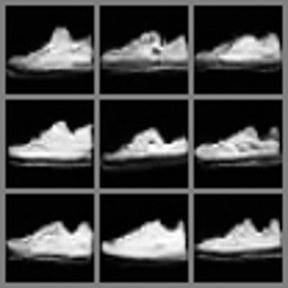

In [14]:
model.eval()

c = fashion_encoder("sneaker", 9)
noise = torch.randn(size=(9,1,32,32)).to(device)

with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))